In [2]:
import numpy as np
import matplotlib.pyplot as pl
import json
from sklearn.utils import class_weight
from keras import Sequential, activations, Input
from keras.models import Model
from keras.layers import BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import (
    recall_precision_fscore_from_confusion_matrix
)

from labelsUtils import (
    Label,
)

from regionUtils import (
    vietnam_labels_coordinates,
)

from rasterUtils import (
    make_dataset_from_raster_files,
)

from convNetUtils import (
    cross_validation,
    plot_confusion_matrix,
    hold_out_split_dataset,
    separate_data_into_images_and_labels,
    evaluate_model,
    add_ndvi_to_dataset,
    add_mndwi_to_dataset,
    add_evi2_to_dataset,
    add_bu_to_dataset,
)

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    PANCHROMATIC = 7
    CIRRUS = 8
    TIRS1 = 9
    TIRS2 = 10
    NDVI = 11
    MNDWI = 12
    EVI2 = 13
    BU = 14

In [4]:
NB_TESTS = 4
EPOCHS = 2000
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [5]:
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

In [6]:
NB_PIXEL_AROUND=4

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_march/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)
add_ndvi_to_dataset(dataset)
add_mndwi_to_dataset(dataset)
add_evi2_to_dataset(dataset)
add_bu_to_dataset(dataset)

This notebook uses :

```
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0,
        rotate_limit=0, p=0.8
    ),
])
```

# NIR, RED, SWIR1

In [6]:
bands = [
    Band.NIR.value,
    Band.RED.value,
    Band.SWIR1.value
]

model_name = "nir_red_swir1"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 3)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 3)           12        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

57/57 [==============================] - 0s 7ms/step - loss: 0.2769 - accuracy: 0.8167 - val_loss: 0.9886 - val_accuracy: 0.7139
Epoch 101/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2584 - accuracy: 0.8406 - val_loss: 0.9636 - val_accuracy: 0.7252
Epoch 102/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2338 - accuracy: 0.8567 - val_loss: 1.0693 - val_accuracy: 0.7112
Epoch 103/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2555 - accuracy: 0.8485 - val_loss: 1.0351 - val_accuracy: 0.7170
Epoch 104/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2394 - accuracy: 0.8577 - val_loss: 1.0280 - val_accuracy: 0.7113
Epoch 105/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2172 - accuracy: 0.8666 - val_loss: 1.0876 - val_accuracy: 0.7146
Epoch 106/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2211 - accuracy: 0.8600 - val_loss: 1.1068 - val_accuracy: 0.7148
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1817 - accuracy: 0.8800 - val_loss: 1.1392 - val_accuracy: 0.7370
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1724 - accuracy: 0.9000 - val_loss: 1.0777 - val_accuracy: 0.7466
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2023 - accuracy: 0.8861 - val_loss: 1.0850 - val_accuracy: 0.7481
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1250 - accuracy: 0.9248 - val_loss: 1.3159 - val_accuracy: 0.7131
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2099 - accuracy: 0.8877 - val_loss: 1.0992 - val_accuracy: 0.7444
Epoch 162/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1362 - accuracy: 0.9124 - val_loss: 1.2135 - val_accuracy: 0.7243
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1940 - accuracy: 0.8944 - val_loss: 1.1493 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 0.9449 - val_loss: 1.3283 - val_accuracy: 0.7471
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0864 - accuracy: 0.9400 - val_loss: 1.4328 - val_accuracy: 0.7398
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0966 - accuracy: 0.9407 - val_loss: 1.3284 - val_accuracy: 0.7435
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1099 - accuracy: 0.9303 - val_loss: 1.3876 - val_accuracy: 0.7435
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0813 - accuracy: 0.9592 - val_loss: 1.3765 - val_accuracy: 0.7488
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1121 - accuracy: 0.9347 - val_loss: 1.3257 - val_accuracy: 0.7462
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1248 - accuracy: 0.9240 - val_loss: 1.2635 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0863 - accuracy: 0.9399 - val_loss: 1.5086 - val_accuracy: 0.7404
Epoch 272/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.1104 - accuracy: 0.9440 - val_loss: 1.5978 - val_accuracy: 0.6942
Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1542 - accuracy: 0.9229 - val_loss: 1.3471 - val_accuracy: 0.7504
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0840 - accuracy: 0.9457 - val_loss: 1.4439 - val_accuracy: 0.7432
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1027 - accuracy: 0.9427 - val_loss: 1.4034 - val_accuracy: 0.7352
Epoch 276/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0739 - accuracy: 0.9417 - val_loss: 1.4123 - val_accuracy: 0.7501
Epoch 277/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0613 - accuracy: 0.9630 - val_loss: 1.5455 - val_accuracy:

Epoch 328/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1007 - accuracy: 0.9542 - val_loss: 1.5453 - val_accuracy: 0.7376
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0968 - accuracy: 0.9517 - val_loss: 1.5384 - val_accuracy: 0.7493
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0601 - accuracy: 0.9693 - val_loss: 1.5278 - val_accuracy: 0.7535
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0658 - accuracy: 0.9587 - val_loss: 1.5338 - val_accuracy: 0.7488
Epoch 332/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1140 - accuracy: 0.9546 - val_loss: 1.5624 - val_accuracy: 0.7299
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0904 - accuracy: 0.9464 - val_loss: 1.3448 - val_accuracy: 0.7344
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0615 - accuracy: 0.9628 - val_loss: 1.4429 - val_accuracy

Epoch 385/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1091 - accuracy: 0.9408 - val_loss: 1.5893 - val_accuracy: 0.7348
Epoch 386/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0816 - accuracy: 0.9503 - val_loss: 1.4945 - val_accuracy: 0.7605
Epoch 387/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0426 - accuracy: 0.9747 - val_loss: 1.5326 - val_accuracy: 0.7511
Epoch 388/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0587 - accuracy: 0.9684 - val_loss: 1.5633 - val_accuracy: 0.7546
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.9571 - val_loss: 1.6410 - val_accuracy: 0.7535
Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9608 - val_loss: 1.6306 - val_accuracy: 0.7577
Epoch 391/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0645 - accuracy: 0.9638 - val_loss: 1.6969 - val_accuracy:

Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9566 - val_loss: 1.5336 - val_accuracy: 0.7520
Epoch 443/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0538 - accuracy: 0.9712 - val_loss: 1.6404 - val_accuracy: 0.7579
Epoch 444/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0505 - accuracy: 0.9713 - val_loss: 1.7292 - val_accuracy: 0.7497
Epoch 445/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0622 - accuracy: 0.9635 - val_loss: 1.7049 - val_accuracy: 0.7499
Epoch 446/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0636 - accuracy: 0.9624 - val_loss: 1.6941 - val_accuracy: 0.7484
Epoch 447/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.9681 - val_loss: 1.6639 - val_accuracy: 0.7534
Epoch 448/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0529 - accuracy: 0.9645 - val_loss: 1.6491 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.4670 - accuracy: 0.7300 - val_loss: 0.9766 - val_accuracy: 0.6533
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4437 - accuracy: 0.7387 - val_loss: 0.8922 - val_accuracy: 0.6894
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4805 - accuracy: 0.7473 - val_loss: 0.8639 - val_accuracy: 0.7059
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4743 - accuracy: 0.7494 - val_loss: 0.9375 - val_accuracy: 0.6639
Epoch 63/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4214 - accuracy: 0.7709 - val_loss: 0.8958 - val_accuracy: 0.6899
Epoch 64/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4179 - accuracy: 0.7753 - val_loss: 1.0451 - val_accuracy: 0.6367
Epoch 65/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5220 - accuracy: 0.7365 - val_loss: 0.9613 - val_accuracy: 0.6421
Epoch 66/2000

Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1512 - accuracy: 0.8913 - val_loss: 1.1819 - val_accuracy: 0.7302
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1395 - accuracy: 0.9066 - val_loss: 1.2478 - val_accuracy: 0.7342
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1472 - accuracy: 0.9063 - val_loss: 1.2654 - val_accuracy: 0.7243
Epoch 176/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1403 - accuracy: 0.9108 - val_loss: 1.2220 - val_accuracy: 0.7356
Epoch 177/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1622 - accuracy: 0.9119 - val_loss: 1.3031 - val_accuracy: 0.7192
Epoch 178/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.9025 - val_loss: 1.2753 - val_accuracy: 0.7161
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1556 - accuracy: 0.8902 - val_loss: 1.2225 - val_accuracy:

Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2401 - accuracy: 0.9166 - val_loss: 1.3450 - val_accuracy: 0.7328
Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1603 - accuracy: 0.9257 - val_loss: 1.2994 - val_accuracy: 0.7222
Epoch 232/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1764 - accuracy: 0.8998 - val_loss: 1.3141 - val_accuracy: 0.7377
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1181 - accuracy: 0.9279 - val_loss: 1.3253 - val_accuracy: 0.7458
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1326 - accuracy: 0.9210 - val_loss: 1.3515 - val_accuracy: 0.7454
Epoch 235/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1169 - accuracy: 0.9291 - val_loss: 1.3388 - val_accuracy: 0.7385
Epoch 236/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1103 - accuracy: 0.9423 - val_loss: 1.3776 - val_accuracy:

Epoch 287/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1638 - accuracy: 0.9152 - val_loss: 1.4035 - val_accuracy: 0.7355
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1542 - accuracy: 0.9263 - val_loss: 1.3719 - val_accuracy: 0.7260
Epoch 289/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0886 - accuracy: 0.9417 - val_loss: 1.3300 - val_accuracy: 0.7375
Epoch 290/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1119 - accuracy: 0.9465 - val_loss: 1.3207 - val_accuracy: 0.7378
Epoch 291/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0918 - accuracy: 0.9495 - val_loss: 1.4080 - val_accuracy: 0.7293
Epoch 292/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1023 - accuracy: 0.9340 - val_loss: 1.4093 - val_accuracy: 0.7272
Epoch 293/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1058 - accuracy: 0.9348 - val_loss: 1.3693 - val_accuracy:

Epoch 344/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0737 - accuracy: 0.9604 - val_loss: 1.6237 - val_accuracy: 0.7321
Epoch 345/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0781 - accuracy: 0.9502 - val_loss: 1.6878 - val_accuracy: 0.7276
Epoch 346/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0795 - accuracy: 0.9541 - val_loss: 1.5601 - val_accuracy: 0.7403
Epoch 347/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1036 - accuracy: 0.9337 - val_loss: 1.6093 - val_accuracy: 0.7435
Epoch 348/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0945 - accuracy: 0.9508 - val_loss: 1.5987 - val_accuracy: 0.7405
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0592 - accuracy: 0.9660 - val_loss: 1.6507 - val_accuracy: 0.7272
Epoch 350/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0801 - accuracy: 0.9567 - val_loss: 1.6075 - val_accuracy:

Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8032 - accuracy: 0.6401 - val_loss: 0.8988 - val_accuracy: 0.6563
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8480 - accuracy: 0.6289 - val_loss: 0.9403 - val_accuracy: 0.6381
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7377 - accuracy: 0.6369 - val_loss: 0.9582 - val_accuracy: 0.6302
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7959 - accuracy: 0.6183 - val_loss: 0.9043 - val_accuracy: 0.6531
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7474 - accuracy: 0.6468 - val_loss: 0.9826 - val_accuracy: 0.6069
Epoch 27/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7923 - accuracy: 0.6055 - val_loss: 1.0486 - val_accuracy: 0.6050
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7876 - accuracy: 0.6366 - val_loss: 0.8479 - val_accuracy: 0.6715

57/57 [==============================] - 0s 7ms/step - loss: 0.2129 - accuracy: 0.8759 - val_loss: 1.0761 - val_accuracy: 0.7287
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2711 - accuracy: 0.8574 - val_loss: 1.0028 - val_accuracy: 0.7241
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2254 - accuracy: 0.8616 - val_loss: 0.9644 - val_accuracy: 0.7247
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2115 - accuracy: 0.8568 - val_loss: 1.1137 - val_accuracy: 0.7206
Epoch 140/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2332 - accuracy: 0.8577 - val_loss: 1.0179 - val_accuracy: 0.7302
Epoch 141/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1858 - accuracy: 0.8855 - val_loss: 1.0332 - val_accuracy: 0.7251
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2191 - accuracy: 0.8564 - val_loss: 1.2100 - val_accuracy: 0.7209
Epoch 1

Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.9197 - val_loss: 1.1463 - val_accuracy: 0.7316
Epoch 194/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1604 - accuracy: 0.9044 - val_loss: 1.3038 - val_accuracy: 0.7161
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1529 - accuracy: 0.9138 - val_loss: 1.2605 - val_accuracy: 0.7500
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1194 - accuracy: 0.9285 - val_loss: 1.3318 - val_accuracy: 0.7097
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.9075 - val_loss: 1.2754 - val_accuracy: 0.7286
Epoch 198/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1411 - accuracy: 0.9158 - val_loss: 1.1906 - val_accuracy: 0.7340
Epoch 199/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1232 - accuracy: 0.9168 - val_loss: 1.2972 - val_accuracy

Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1905 - accuracy: 0.9090 - val_loss: 1.2302 - val_accuracy: 0.7445
Epoch 251/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1093 - accuracy: 0.9383 - val_loss: 1.2707 - val_accuracy: 0.7442
Epoch 252/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.9282 - val_loss: 1.3371 - val_accuracy: 0.7225
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1599 - accuracy: 0.9036 - val_loss: 1.2482 - val_accuracy: 0.7335
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.9480 - val_loss: 1.2716 - val_accuracy: 0.7470
Epoch 255/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0959 - accuracy: 0.9341 - val_loss: 1.2907 - val_accuracy: 0.7409
Epoch 256/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1067 - accuracy: 0.9349 - val_loss: 1.3095 - val_accuracy

Epoch 307/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0824 - accuracy: 0.9519 - val_loss: 1.4955 - val_accuracy: 0.7247
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1136 - accuracy: 0.9394 - val_loss: 1.4005 - val_accuracy: 0.7365
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0959 - accuracy: 0.9430 - val_loss: 1.4778 - val_accuracy: 0.7331
Epoch 310/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1540 - accuracy: 0.9333 - val_loss: 1.4232 - val_accuracy: 0.7447
Epoch 311/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1165 - accuracy: 0.9352 - val_loss: 1.3848 - val_accuracy: 0.7503
Epoch 312/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0877 - accuracy: 0.9491 - val_loss: 1.4501 - val_accuracy: 0.7358
Epoch 313/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0993 - accuracy: 0.9438 - val_loss: 1.4049 - val_accuracy:

Epoch 364/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0948 - accuracy: 0.9524 - val_loss: 1.6596 - val_accuracy: 0.7416
Epoch 365/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1149 - accuracy: 0.9472 - val_loss: 1.5669 - val_accuracy: 0.7468

Validation  1 , fold  4 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.7506 - accuracy: 0.1600 - val_loss: 1.8468 - val_accuracy: 0.0657
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2443 - accuracy: 0.3417 - val_loss: 1.7403 - val_accuracy: 0.2049
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1466 - accuracy: 0.3616 - val_loss: 1.7014 - val_accuracy: 0.4389
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0805 - accuracy: 0.3783 - val_loss: 1.6658 - val_accuracy: 0.3002
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0739 - accur

Epoch 56/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4921 - accuracy: 0.7241 - val_loss: 0.8805 - val_accuracy: 0.6579
Epoch 57/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4925 - accuracy: 0.7391 - val_loss: 0.8869 - val_accuracy: 0.6711
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4430 - accuracy: 0.7261 - val_loss: 0.9130 - val_accuracy: 0.6797
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5235 - accuracy: 0.7458 - val_loss: 1.0156 - val_accuracy: 0.6276
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4911 - accuracy: 0.7308 - val_loss: 0.8499 - val_accuracy: 0.6716
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4348 - accuracy: 0.7318 - val_loss: 0.8888 - val_accuracy: 0.6781
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4701 - accuracy: 0.7317 - val_loss: 0.9123 - val_accuracy: 0.6656

Epoch 170/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.1519 - accuracy: 0.9070 - val_loss: 1.1962 - val_accuracy: 0.7305
Epoch 171/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1852 - accuracy: 0.8849 - val_loss: 1.0631 - val_accuracy: 0.7456
Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1473 - accuracy: 0.9102 - val_loss: 1.0953 - val_accuracy: 0.7351
Epoch 173/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1674 - accuracy: 0.9168 - val_loss: 1.1089 - val_accuracy: 0.7415
Epoch 174/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1572 - accuracy: 0.9044 - val_loss: 1.1705 - val_accuracy: 0.7320
Epoch 175/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1278 - accuracy: 0.9192 - val_loss: 1.2482 - val_accuracy: 0.7272
Epoch 176/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1910 - accuracy: 0.8789 - val_loss: 1.1524 - val_accura

Epoch 227/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 0.9316 - val_loss: 1.2684 - val_accuracy: 0.7411
Epoch 228/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0935 - accuracy: 0.9412 - val_loss: 1.3089 - val_accuracy: 0.7428
Epoch 229/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1500 - accuracy: 0.9319 - val_loss: 1.3212 - val_accuracy: 0.7181
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1362 - accuracy: 0.9165 - val_loss: 1.2639 - val_accuracy: 0.7399
Epoch 231/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1061 - accuracy: 0.9391 - val_loss: 1.2694 - val_accuracy: 0.7437
Epoch 232/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1300 - accuracy: 0.9341 - val_loss: 1.2182 - val_accuracy: 0.7579
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1257 - accuracy: 0.9285 - val_loss: 1.2347 - val_accuracy:

Epoch 284/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1327 - accuracy: 0.9220 - val_loss: 1.3189 - val_accuracy: 0.7378
Epoch 285/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0865 - accuracy: 0.9471 - val_loss: 1.3842 - val_accuracy: 0.7426
Epoch 286/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.9395 - val_loss: 1.3720 - val_accuracy: 0.7473
Epoch 287/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0929 - accuracy: 0.9530 - val_loss: 1.3832 - val_accuracy: 0.7477
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1226 - accuracy: 0.9316 - val_loss: 1.3529 - val_accuracy: 0.7236
Epoch 289/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1178 - accuracy: 0.9271 - val_loss: 1.3309 - val_accuracy: 0.7386
Epoch 290/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0988 - accuracy: 0.9419 - val_loss: 1.3378 - val_accuracy:

Epoch 341/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1012 - accuracy: 0.9401 - val_loss: 1.4817 - val_accuracy: 0.7251
Epoch 342/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0875 - accuracy: 0.9438 - val_loss: 1.4697 - val_accuracy: 0.7371
Epoch 343/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0749 - accuracy: 0.9500 - val_loss: 1.4855 - val_accuracy: 0.7384
Epoch 344/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0890 - accuracy: 0.9475 - val_loss: 1.6526 - val_accuracy: 0.7100
Epoch 345/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0899 - accuracy: 0.9363 - val_loss: 1.5052 - val_accuracy: 0.7502
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9589 - val_loss: 1.5749 - val_accuracy: 0.7598
Epoch 347/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0567 - accuracy: 0.9608 - val_loss: 1.6563 - val_accurac

Epoch 398/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.9669 - val_loss: 1.6862 - val_accuracy: 0.7384
Epoch 399/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.9603 - val_loss: 1.8178 - val_accuracy: 0.7038
Epoch 400/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1238 - accuracy: 0.9318 - val_loss: 1.6160 - val_accuracy: 0.7331
Epoch 401/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0777 - accuracy: 0.9473 - val_loss: 1.5438 - val_accuracy: 0.7503
Epoch 402/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0831 - accuracy: 0.9481 - val_loss: 1.5916 - val_accuracy: 0.7446
Epoch 403/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0728 - accuracy: 0.9571 - val_loss: 1.6415 - val_accuracy: 0.7173
Epoch 404/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0963 - accuracy: 0.9445 - val_loss: 1.4753 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8948 - accuracy: 0.6181 - val_loss: 0.8388 - val_accuracy: 0.6915
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8024 - accuracy: 0.6639 - val_loss: 0.9407 - val_accuracy: 0.6400
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7933 - accuracy: 0.6597 - val_loss: 0.9636 - val_accuracy: 0.6249
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8192 - accuracy: 0.6351 - val_loss: 0.8671 - val_accuracy: 0.6773
Epoch 27/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7847 - accuracy: 0.6573 - val_loss: 0.9637 - val_accuracy: 0.6271
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8071 - accuracy: 0.6186 - val_loss: 0.9192 - val_accuracy: 0.6521
Epoch 29/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7484 - accuracy: 0.6622 - val_loss: 0.9600 - val_accuracy: 0.6308

57/57 [==============================] - 0s 7ms/step - loss: 0.1479 - accuracy: 0.9127 - val_loss: 1.1238 - val_accuracy: 0.7337
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2651 - accuracy: 0.8756 - val_loss: 1.1216 - val_accuracy: 0.7404
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2269 - accuracy: 0.8814 - val_loss: 1.1066 - val_accuracy: 0.7230
Epoch 140/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2221 - accuracy: 0.8785 - val_loss: 1.0188 - val_accuracy: 0.7313
Epoch 141/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1734 - accuracy: 0.9061 - val_loss: 1.0989 - val_accuracy: 0.7435
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2110 - accuracy: 0.9014 - val_loss: 1.1488 - val_accuracy: 0.7198
Epoch 143/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2056 - accuracy: 0.8982 - val_loss: 1.0641 - val_accuracy: 0.7375
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1435 - accuracy: 0.9321 - val_loss: 1.2360 - val_accuracy: 0.7347
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1437 - accuracy: 0.9245 - val_loss: 1.2908 - val_accuracy: 0.7450
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1676 - accuracy: 0.9187 - val_loss: 1.1821 - val_accuracy: 0.7495
Epoch 197/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1555 - accuracy: 0.9265 - val_loss: 1.2249 - val_accuracy: 0.7135
Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1591 - accuracy: 0.9121 - val_loss: 1.1741 - val_accuracy: 0.7388
Epoch 199/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1058 - accuracy: 0.9364 - val_loss: 1.2586 - val_accuracy: 0.7460
Epoch 200/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.9229 - val_loss: 1.2399 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0926 - accuracy: 0.9584 - val_loss: 1.3217 - val_accuracy: 0.7366
Epoch 252/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1094 - accuracy: 0.9511 - val_loss: 1.3228 - val_accuracy: 0.7491
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0818 - accuracy: 0.9522 - val_loss: 1.3628 - val_accuracy: 0.7401
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0713 - accuracy: 0.9623 - val_loss: 1.3679 - val_accuracy: 0.7240
Epoch 255/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1101 - accuracy: 0.9356 - val_loss: 1.4545 - val_accuracy: 0.7542
Epoch 256/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1788 - accuracy: 0.9292 - val_loss: 1.3401 - val_accuracy: 0.7304
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1250 - accuracy: 0.9363 - val_loss: 1.3935 - val_accuracy

Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0642 - accuracy: 0.9683 - val_loss: 1.4097 - val_accuracy: 0.7439
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.9634 - val_loss: 1.5328 - val_accuracy: 0.7456
Epoch 310/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.9598 - val_loss: 1.5410 - val_accuracy: 0.7384
Epoch 311/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0707 - accuracy: 0.9674 - val_loss: 1.4343 - val_accuracy: 0.7294
Epoch 312/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0813 - accuracy: 0.9555 - val_loss: 1.4794 - val_accuracy: 0.7416
Epoch 313/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0893 - accuracy: 0.9688 - val_loss: 1.4791 - val_accuracy: 0.7502
Epoch 314/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0888 - accuracy: 0.9629 - val_loss: 1.4669 - val_accuracy

Epoch 29/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.6471 - accuracy: 0.6559 - val_loss: 1.0299 - val_accuracy: 0.6091
Epoch 30/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.6335 - val_loss: 0.9371 - val_accuracy: 0.6500
Epoch 31/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6538 - accuracy: 0.6875 - val_loss: 0.8423 - val_accuracy: 0.6710
Epoch 32/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6597 - accuracy: 0.6781 - val_loss: 0.9041 - val_accuracy: 0.6406
Epoch 33/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6436 - accuracy: 0.6733 - val_loss: 0.9003 - val_accuracy: 0.6792
Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7413 - accuracy: 0.6669 - val_loss: 0.8827 - val_accuracy: 0.6627
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6864 - accuracy: 0.6667 - val_loss: 0.8846 - val_accuracy: 0.658

57/57 [==============================] - 0s 7ms/step - loss: 0.1708 - accuracy: 0.8993 - val_loss: 1.1150 - val_accuracy: 0.7272
Epoch 144/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2181 - accuracy: 0.8706 - val_loss: 1.1237 - val_accuracy: 0.7273
Epoch 145/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1878 - accuracy: 0.8978 - val_loss: 1.1146 - val_accuracy: 0.7332
Epoch 146/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1726 - accuracy: 0.8900 - val_loss: 1.1700 - val_accuracy: 0.6950
Epoch 147/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1703 - accuracy: 0.8927 - val_loss: 1.1532 - val_accuracy: 0.7224
Epoch 148/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1838 - accuracy: 0.8894 - val_loss: 1.1387 - val_accuracy: 0.7026
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2260 - accuracy: 0.8696 - val_loss: 1.0736 - val_accuracy: 0.7368
Epoch 1

Epoch 200/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1604 - accuracy: 0.9173 - val_loss: 1.2403 - val_accuracy: 0.7412
Epoch 201/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1035 - accuracy: 0.9367 - val_loss: 1.2776 - val_accuracy: 0.7314
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.9188 - val_loss: 1.2910 - val_accuracy: 0.7427
Epoch 203/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.9189 - val_loss: 1.2344 - val_accuracy: 0.7379
Epoch 204/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1299 - accuracy: 0.9289 - val_loss: 1.3340 - val_accuracy: 0.7192
Epoch 205/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.9080 - val_loss: 1.3554 - val_accuracy: 0.7332
Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1723 - accuracy: 0.9037 - val_loss: 1.3255 - val_accuracy:

Epoch 257/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1577 - accuracy: 0.9231 - val_loss: 1.3733 - val_accuracy: 0.7389
Epoch 258/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.9313 - val_loss: 1.4106 - val_accuracy: 0.7359
Epoch 259/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1144 - accuracy: 0.9421 - val_loss: 1.4688 - val_accuracy: 0.7385
Epoch 260/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1085 - accuracy: 0.9317 - val_loss: 1.4088 - val_accuracy: 0.7476
Epoch 261/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.9413 - val_loss: 1.4279 - val_accuracy: 0.7176
Epoch 262/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9074 - val_loss: 1.4844 - val_accuracy: 0.7338
Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1246 - accuracy: 0.9213 - val_loss: 1.4427 - val_accuracy:

Epoch 314/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0910 - accuracy: 0.9428 - val_loss: 1.5978 - val_accuracy: 0.7383
Epoch 315/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1089 - accuracy: 0.9416 - val_loss: 1.4348 - val_accuracy: 0.7480
Epoch 316/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0761 - accuracy: 0.9602 - val_loss: 1.4713 - val_accuracy: 0.7495
Epoch 317/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0705 - accuracy: 0.9650 - val_loss: 1.5362 - val_accuracy: 0.7372
Epoch 318/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0947 - accuracy: 0.9463 - val_loss: 1.5417 - val_accuracy: 0.7484
Epoch 319/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0723 - accuracy: 0.9544 - val_loss: 1.5330 - val_accuracy: 0.7431
Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1064 - accuracy: 0.9465 - val_loss: 1.3967 - val_accuracy

Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5558 - accuracy: 0.7265 - val_loss: 0.8917 - val_accuracy: 0.6753
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5832 - accuracy: 0.7022 - val_loss: 0.8738 - val_accuracy: 0.6788
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5135 - accuracy: 0.7524 - val_loss: 0.9795 - val_accuracy: 0.6241
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5307 - accuracy: 0.7184 - val_loss: 0.9387 - val_accuracy: 0.6469
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5167 - accuracy: 0.7030 - val_loss: 0.8408 - val_accuracy: 0.6986
Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5217 - accuracy: 0.7270 - val_loss: 0.8524 - val_accuracy: 0.6815
Epoch 50/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5055 - accuracy: 0.7362 - val_loss: 0.9212 - val_accuracy: 0.6601

Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1530 - accuracy: 0.8948 - val_loss: 1.1049 - val_accuracy: 0.7441
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1994 - accuracy: 0.8913 - val_loss: 1.2151 - val_accuracy: 0.7234
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.8705 - val_loss: 1.2259 - val_accuracy: 0.7016
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.8788 - val_loss: 1.0167 - val_accuracy: 0.7403
Epoch 162/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2018 - accuracy: 0.8934 - val_loss: 1.1086 - val_accuracy: 0.7274
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1562 - accuracy: 0.9026 - val_loss: 1.1448 - val_accuracy: 0.7243
Epoch 164/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1733 - accuracy: 0.8949 - val_loss: 1.0697 - val_accuracy:

Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1280 - accuracy: 0.9192 - val_loss: 1.1863 - val_accuracy: 0.7369
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1336 - accuracy: 0.9201 - val_loss: 1.3622 - val_accuracy: 0.7271
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1590 - accuracy: 0.9080 - val_loss: 1.2039 - val_accuracy: 0.7268
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1143 - accuracy: 0.9220 - val_loss: 1.2010 - val_accuracy: 0.7295
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1206 - accuracy: 0.9276 - val_loss: 1.1801 - val_accuracy: 0.7488
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1645 - accuracy: 0.9143 - val_loss: 1.1777 - val_accuracy: 0.7367
Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1258 - accuracy: 0.9154 - val_loss: 1.4129 - val_accuracy:

Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1051 - accuracy: 0.9399 - val_loss: 1.4938 - val_accuracy: 0.7157
Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1918 - accuracy: 0.9178 - val_loss: 1.3624 - val_accuracy: 0.7039
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1244 - accuracy: 0.9188 - val_loss: 1.3221 - val_accuracy: 0.7499
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0887 - accuracy: 0.9402 - val_loss: 1.4744 - val_accuracy: 0.7263
Epoch 276/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1355 - accuracy: 0.9237 - val_loss: 1.3028 - val_accuracy: 0.7495
Epoch 277/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0946 - accuracy: 0.9475 - val_loss: 1.3073 - val_accuracy: 0.7447
Epoch 278/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1180 - accuracy: 0.9221 - val_loss: 1.3914 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.3899 - accuracy: 0.8034 - val_loss: 0.8521 - val_accuracy: 0.7029
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3438 - accuracy: 0.8265 - val_loss: 0.8859 - val_accuracy: 0.7027
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4203 - accuracy: 0.7749 - val_loss: 0.8403 - val_accuracy: 0.7179
Epoch 69/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3560 - accuracy: 0.8065 - val_loss: 0.8752 - val_accuracy: 0.7013
Epoch 70/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3967 - accuracy: 0.7816 - val_loss: 0.7849 - val_accuracy: 0.7260
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4833 - accuracy: 0.7643 - val_loss: 0.7862 - val_accuracy: 0.7318
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4056 - accuracy: 0.8110 - val_loss: 0.8522 - val_accuracy: 0.7055
Epoch 73/2000

Epoch 180/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.9128 - val_loss: 1.1966 - val_accuracy: 0.7460
Epoch 181/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1624 - accuracy: 0.9179 - val_loss: 1.2142 - val_accuracy: 0.7450
Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1245 - accuracy: 0.9345 - val_loss: 1.1968 - val_accuracy: 0.7503
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1074 - accuracy: 0.9291 - val_loss: 1.2027 - val_accuracy: 0.7480
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1078 - accuracy: 0.9375 - val_loss: 1.2866 - val_accuracy: 0.7441
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1887 - accuracy: 0.9085 - val_loss: 1.2748 - val_accuracy: 0.7385
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1398 - accuracy: 0.9192 - val_loss: 1.2328 - val_accuracy:

Epoch 18/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.9297 - accuracy: 0.6335 - val_loss: 0.9792 - val_accuracy: 0.6356
Epoch 19/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8660 - accuracy: 0.6294 - val_loss: 1.0947 - val_accuracy: 0.5638
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8527 - accuracy: 0.6533 - val_loss: 0.8861 - val_accuracy: 0.6697
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8531 - accuracy: 0.6469 - val_loss: 0.9325 - val_accuracy: 0.6455
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8430 - accuracy: 0.6585 - val_loss: 0.9910 - val_accuracy: 0.6062
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7881 - accuracy: 0.6606 - val_loss: 0.9166 - val_accuracy: 0.6491
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7772 - accuracy: 0.6589 - val_loss: 0.9983 - val_accuracy: 0.6088

57/57 [==============================] - 0s 7ms/step - loss: 0.2157 - accuracy: 0.8544 - val_loss: 1.1336 - val_accuracy: 0.6887
Epoch 133/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2381 - accuracy: 0.8615 - val_loss: 1.0179 - val_accuracy: 0.7248
Epoch 134/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2022 - accuracy: 0.8632 - val_loss: 1.0559 - val_accuracy: 0.7291
Epoch 135/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2430 - accuracy: 0.8611 - val_loss: 1.0190 - val_accuracy: 0.7230
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2270 - accuracy: 0.8572 - val_loss: 1.0060 - val_accuracy: 0.7271
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2017 - accuracy: 0.8737 - val_loss: 1.0931 - val_accuracy: 0.7221
Epoch 138/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1788 - accuracy: 0.8797 - val_loss: 1.0361 - val_accuracy: 0.7316
Epoch 1

Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1584 - accuracy: 0.9118 - val_loss: 1.1798 - val_accuracy: 0.7473
Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1075 - accuracy: 0.9316 - val_loss: 1.2503 - val_accuracy: 0.7422
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.8919 - val_loss: 1.2063 - val_accuracy: 0.7256
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1313 - accuracy: 0.9155 - val_loss: 1.2125 - val_accuracy: 0.7205
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1843 - accuracy: 0.8882 - val_loss: 1.2289 - val_accuracy: 0.7380
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1543 - accuracy: 0.9068 - val_loss: 1.2194 - val_accuracy: 0.7211
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1501 - accuracy: 0.9057 - val_loss: 1.2111 - val_accuracy:

Epoch 246/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1326 - accuracy: 0.9175 - val_loss: 1.2630 - val_accuracy: 0.7325
Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1284 - accuracy: 0.9228 - val_loss: 1.2913 - val_accuracy: 0.7439
Epoch 248/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1187 - accuracy: 0.9175 - val_loss: 1.3041 - val_accuracy: 0.7399
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1127 - accuracy: 0.9174 - val_loss: 1.3527 - val_accuracy: 0.7290
Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1026 - accuracy: 0.9302 - val_loss: 1.3956 - val_accuracy: 0.7329
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1100 - accuracy: 0.9335 - val_loss: 1.2887 - val_accuracy: 0.7446
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1227 - accuracy: 0.9282 - val_loss: 1.3037 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3599 - accuracy: 0.7909 - val_loss: 0.8829 - val_accuracy: 0.7162
Epoch 74/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3772 - accuracy: 0.8254 - val_loss: 0.9767 - val_accuracy: 0.6844
Epoch 75/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3693 - accuracy: 0.7903 - val_loss: 0.9836 - val_accuracy: 0.6998
Epoch 76/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3669 - accuracy: 0.7959 - val_loss: 0.9100 - val_accuracy: 0.7010
Epoch 77/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3760 - accuracy: 0.7960 - val_loss: 0.8560 - val_accuracy: 0.7203
Epoch 78/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3392 - accuracy: 0.8138 - val_loss: 0.9284 - val_accuracy: 0.7142
Epoch 79/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3684 - accuracy: 0.8020 - val_loss: 0.8565 - val_accuracy: 0.7264
Epoch 80/2000

Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2006 - accuracy: 0.9255 - val_loss: 1.1923 - val_accuracy: 0.7381
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1307 - accuracy: 0.9259 - val_loss: 1.2638 - val_accuracy: 0.7333
Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1312 - accuracy: 0.9153 - val_loss: 1.2670 - val_accuracy: 0.7418
Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0979 - accuracy: 0.9433 - val_loss: 1.2811 - val_accuracy: 0.7477

Validation  3 , fold  1 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.7384 - accuracy: 0.2106 - val_loss: 1.7531 - val_accuracy: 0.0896
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1155 - accuracy: 0.3841 - val_loss: 1.7924 - val_accuracy: 0.0896
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2035 - a

Epoch 54/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5735 - accuracy: 0.6899 - val_loss: 0.8621 - val_accuracy: 0.6979
Epoch 55/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5317 - accuracy: 0.7075 - val_loss: 1.0447 - val_accuracy: 0.5957
Epoch 56/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5055 - accuracy: 0.6968 - val_loss: 0.9593 - val_accuracy: 0.6447
Epoch 57/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5445 - accuracy: 0.7432 - val_loss: 0.7584 - val_accuracy: 0.7195
Epoch 58/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5012 - accuracy: 0.7170 - val_loss: 0.8951 - val_accuracy: 0.6698
Epoch 59/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4567 - accuracy: 0.7494 - val_loss: 0.9439 - val_accuracy: 0.6574
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4475 - accuracy: 0.7458 - val_loss: 0.9827 - val_accuracy: 0.653

Epoch 168/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1879 - accuracy: 0.8753 - val_loss: 1.1197 - val_accuracy: 0.7404
Epoch 169/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1494 - accuracy: 0.8975 - val_loss: 1.1638 - val_accuracy: 0.7448
Epoch 170/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1699 - accuracy: 0.8906 - val_loss: 1.1583 - val_accuracy: 0.7333
Epoch 171/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2031 - accuracy: 0.8822 - val_loss: 1.1766 - val_accuracy: 0.7459
Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1595 - accuracy: 0.9001 - val_loss: 1.2027 - val_accuracy: 0.7504
Epoch 173/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2057 - accuracy: 0.8855 - val_loss: 1.2322 - val_accuracy: 0.7324
Epoch 174/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1782 - accuracy: 0.8813 - val_loss: 1.1132 - val_accuracy:

Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1035 - accuracy: 0.9391 - val_loss: 1.3875 - val_accuracy: 0.7389
Epoch 226/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.9255 - val_loss: 1.4003 - val_accuracy: 0.7455
Epoch 227/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1120 - accuracy: 0.9204 - val_loss: 1.4125 - val_accuracy: 0.7465
Epoch 228/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1017 - accuracy: 0.9331 - val_loss: 1.4604 - val_accuracy: 0.7172
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1461 - accuracy: 0.9159 - val_loss: 1.3719 - val_accuracy: 0.7516
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9190 - val_loss: 1.3552 - val_accuracy: 0.7435
Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1177 - accuracy: 0.9262 - val_loss: 1.3854 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6102 - accuracy: 0.6930 - val_loss: 0.8257 - val_accuracy: 0.6914
Epoch 39/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5919 - accuracy: 0.6898 - val_loss: 0.8911 - val_accuracy: 0.6620
Epoch 40/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5559 - accuracy: 0.7091 - val_loss: 0.8544 - val_accuracy: 0.6845
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5232 - accuracy: 0.7158 - val_loss: 0.8659 - val_accuracy: 0.6725
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5025 - accuracy: 0.7384 - val_loss: 0.8518 - val_accuracy: 0.6841
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5488 - accuracy: 0.6948 - val_loss: 0.8320 - val_accuracy: 0.6848
Epoch 44/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4750 - accuracy: 0.7374 - val_loss: 0.7937 - val_accuracy: 0.7078

Epoch 152/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1838 - accuracy: 0.8813 - val_loss: 1.0948 - val_accuracy: 0.7295
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1946 - accuracy: 0.8758 - val_loss: 1.0805 - val_accuracy: 0.7328
Epoch 154/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1652 - accuracy: 0.9005 - val_loss: 1.1011 - val_accuracy: 0.7403
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1775 - accuracy: 0.8938 - val_loss: 1.0864 - val_accuracy: 0.7380
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1493 - accuracy: 0.9176 - val_loss: 1.1127 - val_accuracy: 0.7446
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1697 - accuracy: 0.9033 - val_loss: 1.2122 - val_accuracy: 0.7255
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1255 - accuracy: 0.9181 - val_loss: 1.2051 - val_accuracy

Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1826 - accuracy: 0.9045 - val_loss: 1.2862 - val_accuracy: 0.7141
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1540 - accuracy: 0.9080 - val_loss: 1.2066 - val_accuracy: 0.7389
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1216 - accuracy: 0.9303 - val_loss: 1.2675 - val_accuracy: 0.7291
Epoch 212/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1440 - accuracy: 0.9168 - val_loss: 1.2501 - val_accuracy: 0.7337
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1507 - accuracy: 0.9027 - val_loss: 1.2543 - val_accuracy: 0.7280
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1251 - accuracy: 0.9166 - val_loss: 1.2679 - val_accuracy: 0.7302
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1139 - accuracy: 0.9336 - val_loss: 1.4253 - val_accuracy

Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.6436 - val_loss: 0.9773 - val_accuracy: 0.6043
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7357 - accuracy: 0.6689 - val_loss: 0.9313 - val_accuracy: 0.6442
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7074 - accuracy: 0.6562 - val_loss: 0.9135 - val_accuracy: 0.6451
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6780 - accuracy: 0.6787 - val_loss: 0.9349 - val_accuracy: 0.6316
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6990 - accuracy: 0.6656 - val_loss: 0.9290 - val_accuracy: 0.6480
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7488 - accuracy: 0.6716 - val_loss: 0.8842 - val_accuracy: 0.6636
Epoch 29/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6701 - accuracy: 0.6840 - val_loss: 0.8585 - val_accuracy: 0.6721

57/57 [==============================] - 0s 7ms/step - loss: 0.2487 - accuracy: 0.8616 - val_loss: 1.0315 - val_accuracy: 0.7299
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1941 - accuracy: 0.8746 - val_loss: 1.0354 - val_accuracy: 0.7366
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1627 - accuracy: 0.9058 - val_loss: 1.0602 - val_accuracy: 0.7424
Epoch 140/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1672 - accuracy: 0.8924 - val_loss: 1.1359 - val_accuracy: 0.7399
Epoch 141/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1881 - accuracy: 0.8918 - val_loss: 1.1272 - val_accuracy: 0.7245
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1682 - accuracy: 0.8846 - val_loss: 1.0611 - val_accuracy: 0.7347
Epoch 143/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1668 - accuracy: 0.9009 - val_loss: 1.0907 - val_accuracy: 0.7420
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1135 - accuracy: 0.9259 - val_loss: 1.2562 - val_accuracy: 0.7384
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1597 - accuracy: 0.9258 - val_loss: 1.2291 - val_accuracy: 0.7529
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1553 - accuracy: 0.9200 - val_loss: 1.3141 - val_accuracy: 0.7055
Epoch 197/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1163 - accuracy: 0.9125 - val_loss: 1.3287 - val_accuracy: 0.7301
Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1322 - accuracy: 0.9198 - val_loss: 1.3410 - val_accuracy: 0.7124
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1448 - accuracy: 0.9079 - val_loss: 1.3104 - val_accuracy: 0.7194
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1684 - accuracy: 0.9114 - val_loss: 1.2394 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1796 - accuracy: 0.9328 - val_loss: 1.4637 - val_accuracy: 0.7002
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1510 - accuracy: 0.9042 - val_loss: 1.4326 - val_accuracy: 0.7443
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1355 - accuracy: 0.9264 - val_loss: 1.3447 - val_accuracy: 0.7335
Epoch 254/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1463 - accuracy: 0.9272 - val_loss: 1.3320 - val_accuracy: 0.7420
Epoch 255/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1481 - accuracy: 0.9207 - val_loss: 1.3815 - val_accuracy: 0.7162
Epoch 256/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1113 - accuracy: 0.9197 - val_loss: 1.3545 - val_accuracy: 0.7450
Epoch 257/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0779 - accuracy: 0.9451 - val_loss: 1.3831 - val_accuracy:

Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.9720 - val_loss: 1.6431 - val_accuracy: 0.7605
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0993 - accuracy: 0.9556 - val_loss: 1.5754 - val_accuracy: 0.7389
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9456 - val_loss: 1.6102 - val_accuracy: 0.7375
Epoch 311/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0821 - accuracy: 0.9446 - val_loss: 1.5573 - val_accuracy: 0.7498
Epoch 312/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0675 - accuracy: 0.9580 - val_loss: 1.6239 - val_accuracy: 0.7285
Epoch 313/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0768 - accuracy: 0.9498 - val_loss: 1.7121 - val_accuracy: 0.7282
Epoch 314/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.9494 - val_loss: 1.5610 - val_accuracy:

Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0594 - accuracy: 0.9650 - val_loss: 1.5972 - val_accuracy: 0.7492
Epoch 366/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.9637 - val_loss: 1.6261 - val_accuracy: 0.7503
Epoch 367/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0697 - accuracy: 0.9609 - val_loss: 1.6325 - val_accuracy: 0.7399
Epoch 368/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1045 - accuracy: 0.9419 - val_loss: 1.7380 - val_accuracy: 0.7371
Epoch 369/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1594 - accuracy: 0.9434 - val_loss: 1.5767 - val_accuracy: 0.7365
Epoch 370/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9535 - val_loss: 1.5959 - val_accuracy: 0.7472
Epoch 371/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy: 0.9518 - val_loss: 1.6774 - val_accuracy:

Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8914 - accuracy: 0.6409 - val_loss: 0.9521 - val_accuracy: 0.6397
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7977 - accuracy: 0.6617 - val_loss: 0.9396 - val_accuracy: 0.6449
Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8726 - accuracy: 0.6327 - val_loss: 0.9765 - val_accuracy: 0.6232
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7471 - accuracy: 0.6697 - val_loss: 0.9598 - val_accuracy: 0.6341
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.8346 - accuracy: 0.6375 - val_loss: 1.0194 - val_accuracy: 0.6081
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7923 - accuracy: 0.6673 - val_loss: 0.9270 - val_accuracy: 0.6586
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7730 - accuracy: 0.6501 - val_loss: 0.9027 - val_accuracy: 0.6503

57/57 [==============================] - 0s 7ms/step - loss: 0.2380 - accuracy: 0.8647 - val_loss: 1.0331 - val_accuracy: 0.7218
Epoch 135/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.8833 - val_loss: 1.0297 - val_accuracy: 0.7181
Epoch 136/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2508 - accuracy: 0.8788 - val_loss: 1.0341 - val_accuracy: 0.7222
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2558 - accuracy: 0.8632 - val_loss: 1.0170 - val_accuracy: 0.7257
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2215 - accuracy: 0.8652 - val_loss: 0.9500 - val_accuracy: 0.7354
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2020 - accuracy: 0.8905 - val_loss: 0.9132 - val_accuracy: 0.7468
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2060 - accuracy: 0.9020 - val_loss: 0.9573 - val_accuracy: 0.7365
Epoch 1

Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1139 - accuracy: 0.9337 - val_loss: 1.1651 - val_accuracy: 0.7446
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.9312 - val_loss: 1.1769 - val_accuracy: 0.7401
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9268 - val_loss: 1.2516 - val_accuracy: 0.7420
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1430 - accuracy: 0.9236 - val_loss: 1.2282 - val_accuracy: 0.7394
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1776 - accuracy: 0.9163 - val_loss: 1.1156 - val_accuracy: 0.7374
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1439 - accuracy: 0.9176 - val_loss: 1.1370 - val_accuracy: 0.7442
Epoch 197/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1366 - accuracy: 0.9224 - val_loss: 1.1457 - val_accuracy:

Epoch 248/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1280 - accuracy: 0.9454 - val_loss: 1.2649 - val_accuracy: 0.7397
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1401 - accuracy: 0.9287 - val_loss: 1.2410 - val_accuracy: 0.7451
Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1000 - accuracy: 0.9452 - val_loss: 1.1852 - val_accuracy: 0.7439
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2043 - accuracy: 0.9265 - val_loss: 1.1886 - val_accuracy: 0.7382
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1559 - accuracy: 0.9192 - val_loss: 1.2162 - val_accuracy: 0.7385
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1195 - accuracy: 0.9241 - val_loss: 1.3509 - val_accuracy: 0.7327
Epoch 254/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1777 - accuracy: 0.9155 - val_loss: 1.2185 - val_accuracy:

Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1498 - accuracy: 0.9384 - val_loss: 1.3910 - val_accuracy: 0.7340
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 0.9444 - val_loss: 1.4109 - val_accuracy: 0.7356
Epoch 307/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1058 - accuracy: 0.9493 - val_loss: 1.3852 - val_accuracy: 0.7456
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1178 - accuracy: 0.9480 - val_loss: 1.3405 - val_accuracy: 0.7344
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0850 - accuracy: 0.9503 - val_loss: 1.3600 - val_accuracy: 0.7462
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0621 - accuracy: 0.9554 - val_loss: 1.3628 - val_accuracy: 0.7529
Epoch 311/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1324 - accuracy: 0.9461 - val_loss: 1.4457 - val_accuracy:

Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5706 - accuracy: 0.7274 - val_loss: 0.8697 - val_accuracy: 0.6724
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5943 - accuracy: 0.7230 - val_loss: 0.8396 - val_accuracy: 0.6823
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5968 - accuracy: 0.7206 - val_loss: 0.8180 - val_accuracy: 0.6977
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6099 - accuracy: 0.7108 - val_loss: 0.8729 - val_accuracy: 0.6715
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6076 - accuracy: 0.6906 - val_loss: 0.8156 - val_accuracy: 0.6854
Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5155 - accuracy: 0.7330 - val_loss: 0.7517 - val_accuracy: 0.7233
Epoch 50/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5306 - accuracy: 0.7307 - val_loss: 0.8632 - val_accuracy: 0.6736

Epoch 158/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1956 - accuracy: 0.8816 - val_loss: 1.0768 - val_accuracy: 0.7472
Epoch 159/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1414 - accuracy: 0.9164 - val_loss: 1.2165 - val_accuracy: 0.7354
Epoch 160/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1407 - accuracy: 0.9044 - val_loss: 1.1054 - val_accuracy: 0.7500
Epoch 161/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1838 - accuracy: 0.9011 - val_loss: 1.1809 - val_accuracy: 0.7309
Epoch 162/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1876 - accuracy: 0.8822 - val_loss: 1.1379 - val_accuracy: 0.7378
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1641 - accuracy: 0.8918 - val_loss: 1.2295 - val_accuracy: 0.7333
Epoch 164/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2084 - accuracy: 0.8733 - val_loss: 1.1421 - val_accuracy

Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1464 - accuracy: 0.9060 - val_loss: 1.3320 - val_accuracy: 0.7312
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1291 - accuracy: 0.9066 - val_loss: 1.3744 - val_accuracy: 0.7449
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1137 - accuracy: 0.9237 - val_loss: 1.2713 - val_accuracy: 0.7325
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1079 - accuracy: 0.9377 - val_loss: 1.3065 - val_accuracy: 0.7401
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1184 - accuracy: 0.9343 - val_loss: 1.3762 - val_accuracy: 0.7361
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1327 - accuracy: 0.9244 - val_loss: 1.4083 - val_accuracy: 0.7314
Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1484 - accuracy: 0.9006 - val_loss: 1.3931 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.5033 - accuracy: 0.7337 - val_loss: 0.8965 - val_accuracy: 0.6615
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4811 - accuracy: 0.7323 - val_loss: 0.8725 - val_accuracy: 0.6771
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4861 - accuracy: 0.7480 - val_loss: 0.8429 - val_accuracy: 0.6891
Epoch 63/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4308 - accuracy: 0.7751 - val_loss: 0.9004 - val_accuracy: 0.6595
Epoch 64/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4501 - accuracy: 0.7565 - val_loss: 0.9426 - val_accuracy: 0.6726
Epoch 65/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4310 - accuracy: 0.7482 - val_loss: 0.9299 - val_accuracy: 0.6825
Epoch 66/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4208 - accuracy: 0.7819 - val_loss: 0.9392 - val_accuracy: 0.6702
Epoch 67/2000

Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1352 - accuracy: 0.9169 - val_loss: 1.1377 - val_accuracy: 0.7447
Epoch 175/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1606 - accuracy: 0.9072 - val_loss: 1.1462 - val_accuracy: 0.7357
Epoch 176/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1742 - accuracy: 0.9081 - val_loss: 1.2052 - val_accuracy: 0.7264
Epoch 177/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1477 - accuracy: 0.9161 - val_loss: 1.1710 - val_accuracy: 0.7317
Epoch 178/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1683 - accuracy: 0.9041 - val_loss: 1.1945 - val_accuracy: 0.7376
Epoch 179/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1242 - accuracy: 0.9182 - val_loss: 1.1958 - val_accuracy: 0.7440
Epoch 180/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1226 - accuracy: 0.9217 - val_loss: 1.1329 - val_accuracy:

Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1501 - accuracy: 0.9116 - val_loss: 1.6376 - val_accuracy: 0.6697
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3394 - accuracy: 0.8537 - val_loss: 1.1552 - val_accuracy: 0.7197
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1967 - accuracy: 0.8953 - val_loss: 1.1897 - val_accuracy: 0.7347
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9322 - val_loss: 1.2893 - val_accuracy: 0.7347
Epoch 235/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.9202 - val_loss: 1.2638 - val_accuracy: 0.7432
Epoch 236/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1683 - accuracy: 0.9086 - val_loss: 1.3202 - val_accuracy: 0.7165
Epoch 237/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.9128 - val_loss: 1.3070 - val_accuracy:

Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1081 - accuracy: 0.9488 - val_loss: 1.3871 - val_accuracy: 0.7309
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1084 - accuracy: 0.9408 - val_loss: 1.3816 - val_accuracy: 0.7319
Epoch 290/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0841 - accuracy: 0.9346 - val_loss: 1.4893 - val_accuracy: 0.7237
Epoch 291/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.9277 - val_loss: 1.4369 - val_accuracy: 0.7419
Epoch 292/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1053 - accuracy: 0.9457 - val_loss: 1.5517 - val_accuracy: 0.7254
Epoch 293/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1620 - accuracy: 0.9242 - val_loss: 1.3733 - val_accuracy: 0.7390
Epoch 294/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1168 - accuracy: 0.9328 - val_loss: 1.4038 - val_accuracy:

Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7926 - accuracy: 0.6279 - val_loss: 0.9528 - val_accuracy: 0.6293
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7934 - accuracy: 0.6373 - val_loss: 0.9500 - val_accuracy: 0.6379
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7622 - accuracy: 0.6493 - val_loss: 0.9220 - val_accuracy: 0.6455
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7077 - accuracy: 0.6622 - val_loss: 0.9299 - val_accuracy: 0.6512
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7547 - accuracy: 0.6677 - val_loss: 0.8720 - val_accuracy: 0.6670
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7410 - accuracy: 0.6871 - val_loss: 0.9896 - val_accuracy: 0.6084
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7151 - accuracy: 0.6717 - val_loss: 0.9383 - val_accuracy: 0.6447

57/57 [==============================] - 0s 7ms/step - loss: 0.2308 - accuracy: 0.8616 - val_loss: 1.0298 - val_accuracy: 0.7354
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1804 - accuracy: 0.8886 - val_loss: 1.1344 - val_accuracy: 0.7180
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1913 - accuracy: 0.8789 - val_loss: 1.1001 - val_accuracy: 0.7251
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2471 - accuracy: 0.8617 - val_loss: 1.0786 - val_accuracy: 0.7089
Epoch 140/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2605 - accuracy: 0.8570 - val_loss: 1.0479 - val_accuracy: 0.7291
Epoch 141/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.8767 - val_loss: 1.0511 - val_accuracy: 0.7401
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1685 - accuracy: 0.8985 - val_loss: 1.0674 - val_accuracy: 0.7370
Epoch 1

Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1191 - accuracy: 0.9262 - val_loss: 1.3082 - val_accuracy: 0.7479
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.9138 - val_loss: 1.2957 - val_accuracy: 0.7293
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1457 - accuracy: 0.9160 - val_loss: 1.2147 - val_accuracy: 0.7245
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1709 - accuracy: 0.9113 - val_loss: 1.1380 - val_accuracy: 0.7408
Epoch 197/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1803 - accuracy: 0.8984 - val_loss: 1.2161 - val_accuracy: 0.7203
Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1336 - accuracy: 0.9075 - val_loss: 1.2867 - val_accuracy: 0.7055
Epoch 199/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1323 - accuracy: 0.9271 - val_loss: 1.3130 - val_accuracy:

Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0941 - accuracy: 0.9499 - val_loss: 1.3847 - val_accuracy: 0.7461
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.9570 - val_loss: 1.3951 - val_accuracy: 0.7449
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1092 - accuracy: 0.9416 - val_loss: 1.3888 - val_accuracy: 0.7451
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1405 - accuracy: 0.9314 - val_loss: 1.4942 - val_accuracy: 0.7325
Epoch 254/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1090 - accuracy: 0.9275 - val_loss: 1.3892 - val_accuracy: 0.7446
Epoch 255/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1072 - accuracy: 0.9439 - val_loss: 1.3710 - val_accuracy: 0.7286
Epoch 256/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1428 - accuracy: 0.9302 - val_loss: 1.4142 - val_accuracy:


Validation  4 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 7ms/step - loss: 1.6148 - accuracy: 0.2274 - val_loss: 1.7113 - val_accuracy: 0.0919
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2429 - accuracy: 0.3290 - val_loss: 1.7259 - val_accuracy: 0.0919
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2131 - accuracy: 0.3318 - val_loss: 1.6904 - val_accuracy: 0.0923
Epoch 4/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.1463 - accuracy: 0.4176 - val_loss: 1.6752 - val_accuracy: 0.1039
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1285 - accuracy: 0.3652 - val_loss: 1.6714 - val_accuracy: 0.1244
Epoch 6/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0815 - accuracy: 0.4206 - val_loss: 1.5889 - val_accuracy: 0.2337
Epoch 7/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0538 - accuracy:

Epoch 58/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.4359 - accuracy: 0.7638 - val_loss: 0.8206 - val_accuracy: 0.7040
Epoch 59/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4569 - accuracy: 0.7667 - val_loss: 0.8024 - val_accuracy: 0.7100
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4066 - accuracy: 0.7981 - val_loss: 0.7964 - val_accuracy: 0.7217
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4363 - accuracy: 0.7790 - val_loss: 0.8901 - val_accuracy: 0.6963
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4357 - accuracy: 0.7815 - val_loss: 0.9444 - val_accuracy: 0.6777
Epoch 63/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4718 - accuracy: 0.7689 - val_loss: 1.1366 - val_accuracy: 0.6241
Epoch 64/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4933 - accuracy: 0.7533 - val_loss: 0.8919 - val_accuracy: 0.6932

Epoch 172/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.1519 - accuracy: 0.9262 - val_loss: 1.2779 - val_accuracy: 0.7373
Epoch 173/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1760 - accuracy: 0.9167 - val_loss: 1.2142 - val_accuracy: 0.7408
Epoch 174/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1604 - accuracy: 0.9167 - val_loss: 1.2482 - val_accuracy: 0.7405
Epoch 175/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1359 - accuracy: 0.9148 - val_loss: 1.2378 - val_accuracy: 0.7285
Epoch 176/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1504 - accuracy: 0.9145 - val_loss: 1.1764 - val_accuracy: 0.7324
Epoch 177/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1082 - accuracy: 0.9341 - val_loss: 1.2561 - val_accuracy: 0.7481
Epoch 178/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1491 - accuracy: 0.9271 - val_loss: 1.3428 - val_accuracy:

Epoch 229/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1142 - accuracy: 0.9394 - val_loss: 1.4299 - val_accuracy: 0.7411
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1481 - accuracy: 0.9265 - val_loss: 1.3564 - val_accuracy: 0.7362
Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0996 - accuracy: 0.9411 - val_loss: 1.4788 - val_accuracy: 0.7081
Epoch 232/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0961 - accuracy: 0.9294 - val_loss: 1.4005 - val_accuracy: 0.7309
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0989 - accuracy: 0.9421 - val_loss: 1.4301 - val_accuracy: 0.7272
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.9366 - val_loss: 1.3446 - val_accuracy: 0.7234
Epoch 235/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.9238 - val_loss: 1.3675 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0862 - accuracy: 0.9544 - val_loss: 1.5217 - val_accuracy: 0.7299
Epoch 287/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.9243 - val_loss: 1.4102 - val_accuracy: 0.7392
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1057 - accuracy: 0.9426 - val_loss: 1.7695 - val_accuracy: 0.7199
Epoch 289/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1598 - accuracy: 0.9249 - val_loss: 1.5884 - val_accuracy: 0.7247
Epoch 290/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2088 - accuracy: 0.9196 - val_loss: 1.3929 - val_accuracy: 0.7352
Epoch 291/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1440 - accuracy: 0.9205 - val_loss: 1.4293 - val_accuracy: 0.7375
Epoch 292/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0948 - accuracy: 0.9487 - val_loss: 1.5206 - val_accuracy

Epoch 343/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0559 - accuracy: 0.9639 - val_loss: 1.7475 - val_accuracy: 0.7438
Epoch 344/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0605 - accuracy: 0.9648 - val_loss: 1.7938 - val_accuracy: 0.7348
Epoch 345/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0784 - accuracy: 0.9643 - val_loss: 1.7097 - val_accuracy: 0.7450
Epoch 346/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0684 - accuracy: 0.9601 - val_loss: 1.7364 - val_accuracy: 0.7224
Epoch 347/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0982 - accuracy: 0.9436 - val_loss: 1.7065 - val_accuracy: 0.7287
Epoch 348/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0915 - accuracy: 0.9526 - val_loss: 1.7061 - val_accuracy: 0.7282
Epoch 349/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1020 - accuracy: 0.9569 - val_loss: 1.6716 - val_accuracy:

Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5906 - accuracy: 0.7249 - val_loss: 0.9005 - val_accuracy: 0.6404
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5795 - accuracy: 0.7207 - val_loss: 0.8635 - val_accuracy: 0.6592
Epoch 41/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.6218 - accuracy: 0.6831 - val_loss: 0.8264 - val_accuracy: 0.6757
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5934 - accuracy: 0.7215 - val_loss: 0.8217 - val_accuracy: 0.6774
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5904 - accuracy: 0.6984 - val_loss: 0.8930 - val_accuracy: 0.6557
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5891 - accuracy: 0.7096 - val_loss: 0.9685 - val_accuracy: 0.6108
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5743 - accuracy: 0.7068 - val_loss: 0.8862 - val_accuracy: 0.6560

57/57 [==============================] - 0s 7ms/step - loss: 0.1997 - accuracy: 0.8767 - val_loss: 1.1039 - val_accuracy: 0.7293
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1943 - accuracy: 0.8830 - val_loss: 1.1409 - val_accuracy: 0.6974
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2071 - accuracy: 0.8797 - val_loss: 1.1371 - val_accuracy: 0.7168
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1781 - accuracy: 0.8928 - val_loss: 1.0211 - val_accuracy: 0.7325
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1612 - accuracy: 0.9089 - val_loss: 1.1274 - val_accuracy: 0.7160
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2034 - accuracy: 0.8981 - val_loss: 1.1356 - val_accuracy: 0.7066
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2133 - accuracy: 0.8766 - val_loss: 1.0395 - val_accuracy: 0.7294
Epoch 1

Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.9345 - val_loss: 1.2621 - val_accuracy: 0.7249
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1651 - accuracy: 0.9213 - val_loss: 1.1966 - val_accuracy: 0.7229
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1473 - accuracy: 0.9153 - val_loss: 1.1637 - val_accuracy: 0.7316
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1266 - accuracy: 0.9253 - val_loss: 1.2019 - val_accuracy: 0.7342
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.9073 - val_loss: 1.1730 - val_accuracy: 0.7359
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1235 - accuracy: 0.9278 - val_loss: 1.2242 - val_accuracy: 0.7304
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1084 - accuracy: 0.9314 - val_loss: 1.2689 - val_accuracy:

Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0844 - accuracy: 0.9417 - val_loss: 1.2772 - val_accuracy: 0.7366
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1000 - accuracy: 0.9517 - val_loss: 1.3821 - val_accuracy: 0.7160
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 0.9153 - val_loss: 1.2607 - val_accuracy: 0.7492
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1026 - accuracy: 0.9497 - val_loss: 1.2627 - val_accuracy: 0.7377
Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0995 - accuracy: 0.9392 - val_loss: 1.3270 - val_accuracy: 0.7350
Epoch 272/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.1176 - accuracy: 0.9357 - val_loss: 1.3171 - val_accuracy: 0.7287
Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0860 - accuracy: 0.9469 - val_loss: 1.2818 - val_accuracy:

Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0758 - accuracy: 0.9516 - val_loss: 1.4392 - val_accuracy: 0.7465
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0725 - accuracy: 0.9620 - val_loss: 1.3778 - val_accuracy: 0.7442
Epoch 326/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9582 - val_loss: 1.5012 - val_accuracy: 0.7350
Epoch 327/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.9520 - val_loss: 1.5329 - val_accuracy: 0.7374
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1177 - accuracy: 0.9377 - val_loss: 1.4514 - val_accuracy: 0.7285
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0902 - accuracy: 0.9511 - val_loss: 1.3995 - val_accuracy: 0.7465
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 0.9531 - val_loss: 1.4567 - val_accuracy:

Epoch 32/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7529 - accuracy: 0.6508 - val_loss: 0.9980 - val_accuracy: 0.6219
Epoch 33/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7079 - accuracy: 0.6412 - val_loss: 0.8180 - val_accuracy: 0.6845
Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7038 - accuracy: 0.6556 - val_loss: 0.9035 - val_accuracy: 0.6549
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7177 - accuracy: 0.6766 - val_loss: 0.9358 - val_accuracy: 0.6359
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6953 - accuracy: 0.6716 - val_loss: 0.8826 - val_accuracy: 0.6662
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6498 - accuracy: 0.6766 - val_loss: 0.8484 - val_accuracy: 0.6678
Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6416 - accuracy: 0.6603 - val_loss: 0.8754 - val_accuracy: 0.6621

57/57 [==============================] - 0s 7ms/step - loss: 0.2378 - accuracy: 0.8506 - val_loss: 1.0493 - val_accuracy: 0.7336
Epoch 147/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2355 - accuracy: 0.8507 - val_loss: 1.1180 - val_accuracy: 0.7213
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2699 - accuracy: 0.8285 - val_loss: 1.0997 - val_accuracy: 0.7365
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2710 - accuracy: 0.8552 - val_loss: 0.9492 - val_accuracy: 0.7226
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2207 - accuracy: 0.8623 - val_loss: 1.0380 - val_accuracy: 0.7476
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2153 - accuracy: 0.8720 - val_loss: 1.0378 - val_accuracy: 0.7325
Epoch 152/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2011 - accuracy: 0.8756 - val_loss: 1.0780 - val_accuracy: 0.7224
Epoch 1

Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1271 - accuracy: 0.9067 - val_loss: 1.3577 - val_accuracy: 0.7323
Epoch 204/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1675 - accuracy: 0.9082 - val_loss: 1.2300 - val_accuracy: 0.7131
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1616 - accuracy: 0.9031 - val_loss: 1.2536 - val_accuracy: 0.7297
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1711 - accuracy: 0.9032 - val_loss: 1.1283 - val_accuracy: 0.7431
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1361 - accuracy: 0.9169 - val_loss: 1.2363 - val_accuracy: 0.7438
Epoch 208/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1414 - accuracy: 0.9021 - val_loss: 1.1918 - val_accuracy: 0.7552
Epoch 209/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1887 - accuracy: 0.9027 - val_loss: 1.1652 - val_accuracy:

Epoch 260/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1992 - accuracy: 0.8843 - val_loss: 1.2146 - val_accuracy: 0.7430
Epoch 261/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1210 - accuracy: 0.9376 - val_loss: 1.3162 - val_accuracy: 0.7456
Epoch 262/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.9254 - val_loss: 1.3049 - val_accuracy: 0.7533
Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1567 - accuracy: 0.9163 - val_loss: 1.3894 - val_accuracy: 0.6848
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1417 - accuracy: 0.9065 - val_loss: 1.2578 - val_accuracy: 0.7420
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1699 - accuracy: 0.9135 - val_loss: 1.2814 - val_accuracy: 0.7453
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1056 - accuracy: 0.9391 - val_loss: 1.3372 - val_accuracy:

Epoch 317/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1130 - accuracy: 0.9395 - val_loss: 1.4609 - val_accuracy: 0.7200
Epoch 318/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.9225 - val_loss: 1.4407 - val_accuracy: 0.7523
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0950 - accuracy: 0.9466 - val_loss: 1.4574 - val_accuracy: 0.7291
Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1107 - accuracy: 0.9417 - val_loss: 1.4699 - val_accuracy: 0.7209
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1098 - accuracy: 0.9347 - val_loss: 1.4321 - val_accuracy: 0.7407
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1225 - accuracy: 0.9364 - val_loss: 1.4960 - val_accuracy: 0.7257
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1466 - accuracy: 0.9162 - val_loss: 1.3507 - val_accuracy:

Epoch 374/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0615 - accuracy: 0.9615 - val_loss: 1.4352 - val_accuracy: 0.7466
Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0972 - accuracy: 0.9461 - val_loss: 1.4927 - val_accuracy: 0.7462
Epoch 376/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1165 - accuracy: 0.9427 - val_loss: 1.3509 - val_accuracy: 0.7488
Epoch 377/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0858 - accuracy: 0.9438 - val_loss: 1.4989 - val_accuracy: 0.7526
Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0874 - accuracy: 0.9559 - val_loss: 1.5120 - val_accuracy: 0.7337
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0871 - accuracy: 0.9547 - val_loss: 1.4423 - val_accuracy: 0.7443
Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0695 - accuracy: 0.9532 - val_loss: 1.5679 - val_accuracy:

In [7]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.495411078150272
mean accuracy:  0.7390139302000811


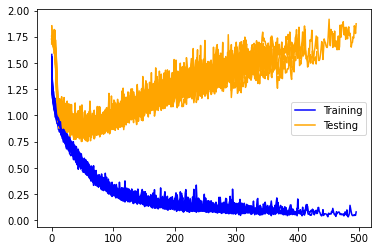

In [8]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

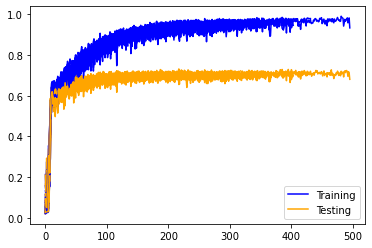

In [9]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

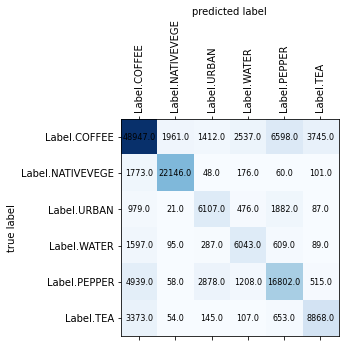

In [10]:
plot_confusion_matrix(conf_matrix, labels)

In [11]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.79449098 0.91004726 0.56145996 0.57295914 0.63155916 0.6615442 ]
Mean precision:  0.6886767821469414

Recalls:  [0.75072086 0.91120803 0.63934255 0.69300459 0.63643939 0.67181818]
Mean recall:  0.7170889332454388

F-Score:  [0.77198599 0.91062727 0.59787557 0.62729019 0.63398989 0.66664161]
Mean f-score:  0.7014017532657731


# All bands (excepted cirrus)

In [12]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
    Band.PANCHROMATIC.value, 
    # Band.CIRRUS.value, 
    Band.TIRS1.value, 
    Band.TIRS2.value,
]

model_name = "all_bands"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 9, 9, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 10)          40        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          2912      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 64)         

57/57 [==============================] - 0s 8ms/step - loss: 0.1482 - accuracy: 0.9103 - val_loss: 0.7324 - val_accuracy: 0.8017
Epoch 101/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1849 - accuracy: 0.8904 - val_loss: 0.8358 - val_accuracy: 0.7495
Epoch 102/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1950 - accuracy: 0.8909 - val_loss: 0.7580 - val_accuracy: 0.7876
Epoch 103/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9171 - val_loss: 0.6889 - val_accuracy: 0.8113
Epoch 104/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1345 - accuracy: 0.9223 - val_loss: 0.8118 - val_accuracy: 0.7759
Epoch 105/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1285 - accuracy: 0.9140 - val_loss: 0.7643 - val_accuracy: 0.8054
Epoch 106/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9106 - val_loss: 0.7639 - val_accuracy: 0.7815
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0915 - accuracy: 0.9458 - val_loss: 0.8837 - val_accuracy: 0.8105
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9438 - val_loss: 0.9169 - val_accuracy: 0.8070
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1061 - accuracy: 0.9368 - val_loss: 0.9062 - val_accuracy: 0.7975
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1249 - accuracy: 0.9439 - val_loss: 0.9984 - val_accuracy: 0.7888
Epoch 161/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.9394 - val_loss: 1.1076 - val_accuracy: 0.7784
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1313 - accuracy: 0.9353 - val_loss: 0.8419 - val_accuracy: 0.8013
Epoch 163/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1074 - accuracy: 0.9425 - val_loss: 0.7907 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9624 - val_loss: 1.0213 - val_accuracy: 0.7866
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1058 - accuracy: 0.9466 - val_loss: 1.0143 - val_accuracy: 0.8012
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0556 - accuracy: 0.9710 - val_loss: 0.9037 - val_accuracy: 0.8166
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0367 - accuracy: 0.9780 - val_loss: 1.1699 - val_accuracy: 0.7949
Epoch 218/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0798 - accuracy: 0.9561 - val_loss: 0.9452 - val_accuracy: 0.8185
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0739 - accuracy: 0.9633 - val_loss: 1.0609 - val_accuracy: 0.8050
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2013 - accuracy: 0.9273 - val_loss: 1.0586 - val_accuracy:

Epoch 32/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5258 - accuracy: 0.7351 - val_loss: 0.8541 - val_accuracy: 0.6891
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5451 - accuracy: 0.7379 - val_loss: 0.8276 - val_accuracy: 0.6670
Epoch 34/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5268 - accuracy: 0.7386 - val_loss: 0.7516 - val_accuracy: 0.7158
Epoch 35/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5161 - accuracy: 0.7043 - val_loss: 0.7489 - val_accuracy: 0.7256
Epoch 36/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5692 - accuracy: 0.7063 - val_loss: 0.6991 - val_accuracy: 0.7363
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4893 - accuracy: 0.7171 - val_loss: 0.9748 - val_accuracy: 0.6272
Epoch 38/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.5105 - accuracy: 0.7265 - val_loss: 0.8443 - val_accuracy: 0

57/57 [==============================] - 1s 9ms/step - loss: 0.1283 - accuracy: 0.9068 - val_loss: 0.8389 - val_accuracy: 0.7916
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1835 - accuracy: 0.9114 - val_loss: 0.8248 - val_accuracy: 0.7959
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1646 - accuracy: 0.9177 - val_loss: 0.8115 - val_accuracy: 0.7954
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1522 - accuracy: 0.9146 - val_loss: 0.7942 - val_accuracy: 0.8110
Epoch 150/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1323 - accuracy: 0.9285 - val_loss: 0.8821 - val_accuracy: 0.7793
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1325 - accuracy: 0.9087 - val_loss: 0.8574 - val_accuracy: 0.7897
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1251 - accuracy: 0.9284 - val_loss: 0.7757 - val_accuracy: 0.8095
Epoch 

Epoch 203/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1049 - accuracy: 0.9527 - val_loss: 0.8922 - val_accuracy: 0.8023
Epoch 204/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0998 - accuracy: 0.9360 - val_loss: 0.9246 - val_accuracy: 0.7876
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.9337 - val_loss: 0.8850 - val_accuracy: 0.8099
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0730 - accuracy: 0.9558 - val_loss: 0.8977 - val_accuracy: 0.7962
Epoch 207/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0835 - accuracy: 0.9500 - val_loss: 0.9187 - val_accuracy: 0.8059
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1009 - accuracy: 0.9411 - val_loss: 0.9118 - val_accuracy: 0.8129
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0791 - accuracy: 0.9488 - val_loss: 0.8148 - val_accuracy:

Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0446 - accuracy: 0.9714 - val_loss: 0.9349 - val_accuracy: 0.8129
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0458 - accuracy: 0.9713 - val_loss: 1.0040 - val_accuracy: 0.8097
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0589 - accuracy: 0.9707 - val_loss: 0.9945 - val_accuracy: 0.7916
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0930 - accuracy: 0.9526 - val_loss: 0.9211 - val_accuracy: 0.8076
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0402 - accuracy: 0.9728 - val_loss: 0.9611 - val_accuracy: 0.8217
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0521 - accuracy: 0.9740 - val_loss: 0.9799 - val_accuracy: 0.7977
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1066 - accuracy: 0.9612 - val_loss: 0.9551 - val_accuracy:

Epoch 317/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0374 - accuracy: 0.9776 - val_loss: 1.0405 - val_accuracy: 0.8226
Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0516 - accuracy: 0.9693 - val_loss: 1.0286 - val_accuracy: 0.8192
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0549 - accuracy: 0.9684 - val_loss: 1.0128 - val_accuracy: 0.8243
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0991 - accuracy: 0.9585 - val_loss: 1.2118 - val_accuracy: 0.7730
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1304 - accuracy: 0.9217 - val_loss: 0.9324 - val_accuracy: 0.8061
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0950 - accuracy: 0.9452 - val_loss: 0.8816 - val_accuracy: 0.8198
Epoch 323/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0612 - accuracy: 0.9605 - val_loss: 0.9708 - val_accuracy

Epoch 374/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0632 - accuracy: 0.9748 - val_loss: 1.0767 - val_accuracy: 0.8154
Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.9741 - val_loss: 1.1270 - val_accuracy: 0.8146
Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0463 - accuracy: 0.9679 - val_loss: 1.1595 - val_accuracy: 0.8019
Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0801 - accuracy: 0.9658 - val_loss: 1.0221 - val_accuracy: 0.8039
Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 0.9666 - val_loss: 1.0835 - val_accuracy: 0.8016
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0544 - accuracy: 0.9740 - val_loss: 1.0951 - val_accuracy: 0.8096
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9523 - val_loss: 1.1667 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.3172 - accuracy: 0.8056 - val_loss: 0.6616 - val_accuracy: 0.7719
Epoch 65/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2419 - accuracy: 0.8361 - val_loss: 0.6434 - val_accuracy: 0.7625
Epoch 66/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2430 - accuracy: 0.8420 - val_loss: 0.7664 - val_accuracy: 0.7306
Epoch 67/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2633 - accuracy: 0.8315 - val_loss: 0.7547 - val_accuracy: 0.7422
Epoch 68/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2954 - accuracy: 0.8209 - val_loss: 0.6284 - val_accuracy: 0.7800
Epoch 69/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2521 - accuracy: 0.8263 - val_loss: 0.6237 - val_accuracy: 0.7821
Epoch 70/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2732 - accuracy: 0.8291 - val_loss: 0.7267 - val_accuracy: 0.7544
Epoch 71/

Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1249 - accuracy: 0.9221 - val_loss: 0.9441 - val_accuracy: 0.7726
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9285 - val_loss: 0.7776 - val_accuracy: 0.8093
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0727 - accuracy: 0.9546 - val_loss: 0.8737 - val_accuracy: 0.8005
Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0843 - accuracy: 0.9476 - val_loss: 0.8180 - val_accuracy: 0.8157
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0922 - accuracy: 0.9407 - val_loss: 0.8618 - val_accuracy: 0.8045
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0775 - accuracy: 0.9472 - val_loss: 0.8600 - val_accuracy: 0.8196
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0464 - accuracy: 0.9735 - val_loss: 0.8795 - val_accuracy:

Epoch 235/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0455 - accuracy: 0.9655 - val_loss: 1.2611 - val_accuracy: 0.7836
Epoch 236/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1295 - accuracy: 0.9537 - val_loss: 0.9191 - val_accuracy: 0.7981
Epoch 237/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0573 - accuracy: 0.9594 - val_loss: 0.8769 - val_accuracy: 0.8107
Epoch 238/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0610 - accuracy: 0.9630 - val_loss: 0.9538 - val_accuracy: 0.8142
Epoch 239/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0566 - accuracy: 0.9706 - val_loss: 0.9953 - val_accuracy: 0.7979
Epoch 240/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1024 - accuracy: 0.9300 - val_loss: 0.9319 - val_accuracy: 0.8115
Epoch 241/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0520 - accuracy: 0.9708 - val_loss: 0.8661 - val_accur

Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0822 - accuracy: 0.9519 - val_loss: 0.9811 - val_accuracy: 0.8074
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.9711 - val_loss: 1.0635 - val_accuracy: 0.7826
Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0746 - accuracy: 0.9461 - val_loss: 1.1729 - val_accuracy: 0.7819
Epoch 295/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1080 - accuracy: 0.9555 - val_loss: 0.9727 - val_accuracy: 0.8140
Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9790 - val_loss: 0.9773 - val_accuracy: 0.8133
Epoch 297/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0377 - accuracy: 0.9838 - val_loss: 0.9873 - val_accuracy: 0.8228
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9900 - val_loss: 1.0196 - val_accuracy:

Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5003 - accuracy: 0.7718 - val_loss: 0.8261 - val_accuracy: 0.6891
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5236 - accuracy: 0.7345 - val_loss: 0.7978 - val_accuracy: 0.7073
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5191 - accuracy: 0.7484 - val_loss: 0.7100 - val_accuracy: 0.7380
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4959 - accuracy: 0.7637 - val_loss: 0.6695 - val_accuracy: 0.7530
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4632 - accuracy: 0.7633 - val_loss: 0.7483 - val_accuracy: 0.7199
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4730 - accuracy: 0.7516 - val_loss: 0.6919 - val_accuracy: 0.7367
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4651 - accuracy: 0.7610 - val_loss: 0.7501 - val_accuracy: 0.7195

57/57 [==============================] - 0s 8ms/step - loss: 0.1720 - accuracy: 0.9059 - val_loss: 0.7961 - val_accuracy: 0.8084
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1278 - accuracy: 0.9296 - val_loss: 0.8205 - val_accuracy: 0.7886
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1331 - accuracy: 0.9276 - val_loss: 0.8112 - val_accuracy: 0.8061
Epoch 151/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1386 - accuracy: 0.9213 - val_loss: 0.8005 - val_accuracy: 0.8023
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0992 - accuracy: 0.9400 - val_loss: 0.7827 - val_accuracy: 0.8141
Epoch 153/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1183 - accuracy: 0.9238 - val_loss: 0.8384 - val_accuracy: 0.8061
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1324 - accuracy: 0.9306 - val_loss: 0.8532 - val_accuracy: 0.8081
Epoch 1

Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9614 - val_loss: 0.8770 - val_accuracy: 0.8107
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0632 - accuracy: 0.9650 - val_loss: 0.8440 - val_accuracy: 0.8202
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9583 - val_loss: 0.9402 - val_accuracy: 0.8000
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0931 - accuracy: 0.9440 - val_loss: 0.8952 - val_accuracy: 0.8157
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.9545 - val_loss: 0.8786 - val_accuracy: 0.8152
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0483 - accuracy: 0.9709 - val_loss: 0.9143 - val_accuracy: 0.8114
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0502 - accuracy: 0.9648 - val_loss: 0.9801 - val_accuracy:

Epoch 262/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0509 - accuracy: 0.9694 - val_loss: 1.0247 - val_accuracy: 0.8154
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0522 - accuracy: 0.9691 - val_loss: 1.0282 - val_accuracy: 0.8165
Epoch 264/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.0838 - accuracy: 0.9510 - val_loss: 1.1057 - val_accuracy: 0.7902
Epoch 265/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0944 - accuracy: 0.9337 - val_loss: 0.9733 - val_accuracy: 0.8118
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0667 - accuracy: 0.9623 - val_loss: 1.0821 - val_accuracy: 0.8083
Epoch 267/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0710 - accuracy: 0.9602 - val_loss: 0.9278 - val_accuracy: 0.8118
Epoch 268/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0834 - accuracy: 0.9753 - val_loss: 1.0335 - val_accur

Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4693 - accuracy: 0.7540 - val_loss: 0.7187 - val_accuracy: 0.7403
Epoch 38/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4638 - accuracy: 0.7781 - val_loss: 0.7086 - val_accuracy: 0.7492
Epoch 39/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4340 - accuracy: 0.7687 - val_loss: 0.7626 - val_accuracy: 0.7146
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4273 - accuracy: 0.7697 - val_loss: 0.6780 - val_accuracy: 0.7498
Epoch 41/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.4095 - accuracy: 0.7940 - val_loss: 0.6657 - val_accuracy: 0.7646
Epoch 42/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.4248 - accuracy: 0.7983 - val_loss: 0.8111 - val_accuracy: 0.7200
Epoch 43/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4404 - accuracy: 0.7740 - val_loss: 0.6932 - val_accuracy: 0.74

Epoch 151/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1371 - accuracy: 0.9375 - val_loss: 0.9952 - val_accuracy: 0.7868
Epoch 152/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0991 - accuracy: 0.9430 - val_loss: 0.8785 - val_accuracy: 0.8040
Epoch 153/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1152 - accuracy: 0.9354 - val_loss: 0.8527 - val_accuracy: 0.7906
Epoch 154/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0745 - accuracy: 0.9540 - val_loss: 0.9034 - val_accuracy: 0.7931
Epoch 155/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0978 - accuracy: 0.9371 - val_loss: 0.8686 - val_accuracy: 0.7944
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0985 - accuracy: 0.9461 - val_loss: 0.9594 - val_accuracy: 0.7762
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1296 - accuracy: 0.9309 - val_loss: 0.9091 - val_accur

Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0539 - accuracy: 0.9705 - val_loss: 1.0182 - val_accuracy: 0.7971
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9379 - val_loss: 0.9085 - val_accuracy: 0.8148
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0649 - accuracy: 0.9549 - val_loss: 1.0093 - val_accuracy: 0.8020
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0588 - accuracy: 0.9664 - val_loss: 1.0155 - val_accuracy: 0.7955
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0678 - accuracy: 0.9636 - val_loss: 1.0384 - val_accuracy: 0.7982
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0727 - accuracy: 0.9572 - val_loss: 0.9381 - val_accuracy: 0.8148
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9664 - val_loss: 1.0264 - val_accuracy:

Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0517 - accuracy: 0.9759 - val_loss: 1.0475 - val_accuracy: 0.8053
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0790 - accuracy: 0.9549 - val_loss: 1.0335 - val_accuracy: 0.7996
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0752 - accuracy: 0.9627 - val_loss: 1.1143 - val_accuracy: 0.8043
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9728 - val_loss: 1.1183 - val_accuracy: 0.8017
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.9695 - val_loss: 1.0660 - val_accuracy: 0.8040
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0827 - accuracy: 0.9680 - val_loss: 1.0315 - val_accuracy: 0.7956
Epoch 271/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0875 - accuracy: 0.9643 - val_loss: 0.9945 - val_accuracy:

Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0332 - accuracy: 0.9880 - val_loss: 1.1202 - val_accuracy: 0.8102
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0416 - accuracy: 0.9792 - val_loss: 1.0762 - val_accuracy: 0.8182
Epoch 324/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0299 - accuracy: 0.9766 - val_loss: 1.1678 - val_accuracy: 0.8053
Epoch 325/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0323 - accuracy: 0.9799 - val_loss: 1.1547 - val_accuracy: 0.8150
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.9819 - val_loss: 1.1791 - val_accuracy: 0.8057
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0451 - accuracy: 0.9757 - val_loss: 1.1810 - val_accuracy: 0.8187
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.9754 - val_loss: 1.1888 - val_accuracy:

Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0318 - accuracy: 0.9840 - val_loss: 1.2475 - val_accuracy: 0.8019
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0542 - accuracy: 0.9718 - val_loss: 1.2912 - val_accuracy: 0.7703
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.9651 - val_loss: 1.2752 - val_accuracy: 0.7860
Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 0.9689 - val_loss: 1.2272 - val_accuracy: 0.8089
Epoch 383/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0870 - accuracy: 0.9669 - val_loss: 1.2992 - val_accuracy: 0.7865
Epoch 384/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0810 - accuracy: 0.9594 - val_loss: 1.1203 - val_accuracy: 0.8004
Epoch 385/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0872 - accuracy: 0.9721 - val_loss: 1.1185 - val_accuracy:

Epoch 32/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5271 - accuracy: 0.7371 - val_loss: 0.8548 - val_accuracy: 0.6695
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5428 - accuracy: 0.7049 - val_loss: 0.7181 - val_accuracy: 0.7226
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5651 - accuracy: 0.7035 - val_loss: 0.8715 - val_accuracy: 0.6663
Epoch 35/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5539 - accuracy: 0.7145 - val_loss: 0.8602 - val_accuracy: 0.6755
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5711 - accuracy: 0.7072 - val_loss: 1.0688 - val_accuracy: 0.6135
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5690 - accuracy: 0.7040 - val_loss: 0.8021 - val_accuracy: 0.6904
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4999 - accuracy: 0.7404 - val_loss: 0.8028 - val_accuracy: 0.687

57/57 [==============================] - 0s 8ms/step - loss: 0.3247 - accuracy: 0.8820 - val_loss: 0.7648 - val_accuracy: 0.7823
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1327 - accuracy: 0.9145 - val_loss: 0.7527 - val_accuracy: 0.7940
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1119 - accuracy: 0.9401 - val_loss: 0.8134 - val_accuracy: 0.7902
Epoch 149/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1254 - accuracy: 0.9315 - val_loss: 0.7860 - val_accuracy: 0.7968
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1120 - accuracy: 0.9286 - val_loss: 0.8900 - val_accuracy: 0.7900
Epoch 151/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1303 - accuracy: 0.9247 - val_loss: 0.8705 - val_accuracy: 0.7947
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1295 - accuracy: 0.9344 - val_loss: 0.8488 - val_accuracy: 0.7963
Epoch 

Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9500 - val_loss: 0.9458 - val_accuracy: 0.7980
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0693 - accuracy: 0.9602 - val_loss: 0.9735 - val_accuracy: 0.8055
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0820 - accuracy: 0.9603 - val_loss: 1.0098 - val_accuracy: 0.7892
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1513 - accuracy: 0.9390 - val_loss: 0.9465 - val_accuracy: 0.7857
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0675 - accuracy: 0.9575 - val_loss: 0.9150 - val_accuracy: 0.8065
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0690 - accuracy: 0.9525 - val_loss: 0.9822 - val_accuracy: 0.7915

Validation  2 , fold  2 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.5959

Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3657 - accuracy: 0.7862 - val_loss: 0.7073 - val_accuracy: 0.7513
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3816 - accuracy: 0.7972 - val_loss: 0.7119 - val_accuracy: 0.7361
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3253 - accuracy: 0.7997 - val_loss: 0.7171 - val_accuracy: 0.7494
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3832 - accuracy: 0.8037 - val_loss: 0.7640 - val_accuracy: 0.7191
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4308 - accuracy: 0.7608 - val_loss: 0.6621 - val_accuracy: 0.7601
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3516 - accuracy: 0.8038 - val_loss: 0.6560 - val_accuracy: 0.7708
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3112 - accuracy: 0.8251 - val_loss: 0.6738 - val_accuracy: 0.7732

Epoch 166/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0982 - accuracy: 0.9325 - val_loss: 0.9041 - val_accuracy: 0.8004
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.9405 - val_loss: 0.9805 - val_accuracy: 0.7985
Epoch 168/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0980 - accuracy: 0.9406 - val_loss: 1.0485 - val_accuracy: 0.7815
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1259 - accuracy: 0.9160 - val_loss: 0.9156 - val_accuracy: 0.8045
Epoch 170/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1614 - accuracy: 0.9238 - val_loss: 0.8523 - val_accuracy: 0.8005
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1094 - accuracy: 0.9337 - val_loss: 0.8581 - val_accuracy: 0.8092
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0547 - accuracy: 0.9677 - val_loss: 0.9438 - val_accuracy:

Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1214 - accuracy: 0.9474 - val_loss: 0.9871 - val_accuracy: 0.7977
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0739 - accuracy: 0.9579 - val_loss: 0.9576 - val_accuracy: 0.8032
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.9608 - val_loss: 1.0433 - val_accuracy: 0.8099
Epoch 226/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0853 - accuracy: 0.9545 - val_loss: 1.1561 - val_accuracy: 0.7959
Epoch 227/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1633 - accuracy: 0.9301 - val_loss: 1.0119 - val_accuracy: 0.7810
Epoch 228/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1063 - accuracy: 0.9328 - val_loss: 0.9537 - val_accuracy: 0.8049
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0867 - accuracy: 0.9691 - val_loss: 1.0120 - val_accuracy:

Epoch 280/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.9483 - val_loss: 1.0907 - val_accuracy: 0.7912
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.9654 - val_loss: 1.0811 - val_accuracy: 0.8008
Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0603 - accuracy: 0.9655 - val_loss: 1.1700 - val_accuracy: 0.7838
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9535 - val_loss: 1.0936 - val_accuracy: 0.8077
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9679 - val_loss: 1.0730 - val_accuracy: 0.7974
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0483 - accuracy: 0.9708 - val_loss: 1.0752 - val_accuracy: 0.8110
Epoch 286/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0457 - accuracy: 0.9696 - val_loss: 1.1575 - val_accuracy:

Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4557 - accuracy: 0.7421 - val_loss: 0.8060 - val_accuracy: 0.6868
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4092 - accuracy: 0.7553 - val_loss: 1.0489 - val_accuracy: 0.6170
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4477 - accuracy: 0.7671 - val_loss: 0.8156 - val_accuracy: 0.6994
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4405 - accuracy: 0.7677 - val_loss: 0.8949 - val_accuracy: 0.6624
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4766 - accuracy: 0.7404 - val_loss: 0.7461 - val_accuracy: 0.7238
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4285 - accuracy: 0.7727 - val_loss: 0.8290 - val_accuracy: 0.6765
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4009 - accuracy: 0.7603 - val_loss: 0.9935 - val_accuracy: 0.6305

57/57 [==============================] - 0s 8ms/step - loss: 0.0927 - accuracy: 0.9416 - val_loss: 0.8833 - val_accuracy: 0.7899
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1386 - accuracy: 0.9078 - val_loss: 0.9086 - val_accuracy: 0.7869
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1569 - accuracy: 0.9046 - val_loss: 0.8240 - val_accuracy: 0.7920
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9428 - val_loss: 0.8199 - val_accuracy: 0.8070
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1076 - accuracy: 0.9391 - val_loss: 0.8673 - val_accuracy: 0.7833
Epoch 152/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1095 - accuracy: 0.9328 - val_loss: 0.8240 - val_accuracy: 0.8058
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0753 - accuracy: 0.9536 - val_loss: 0.9632 - val_accuracy: 0.7985
Epoch 1

Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9406 - val_loss: 1.0687 - val_accuracy: 0.7831
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1440 - accuracy: 0.9186 - val_loss: 1.0475 - val_accuracy: 0.7871
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0819 - accuracy: 0.9492 - val_loss: 0.9677 - val_accuracy: 0.7861
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0889 - accuracy: 0.9446 - val_loss: 0.9974 - val_accuracy: 0.7789
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.9417 - val_loss: 0.9862 - val_accuracy: 0.7893
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1135 - accuracy: 0.9419 - val_loss: 0.9100 - val_accuracy: 0.8104
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.9577 - val_loss: 0.9895 - val_accuracy:

Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9666 - val_loss: 1.0232 - val_accuracy: 0.8070
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9492 - val_loss: 1.1166 - val_accuracy: 0.8045
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0552 - accuracy: 0.9627 - val_loss: 1.2471 - val_accuracy: 0.7875
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1117 - accuracy: 0.9415 - val_loss: 1.1632 - val_accuracy: 0.7449
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1282 - accuracy: 0.9088 - val_loss: 1.0100 - val_accuracy: 0.7922
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9554 - val_loss: 1.0023 - val_accuracy: 0.7948
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0619 - accuracy: 0.9651 - val_loss: 1.0232 - val_accuracy:

Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.9729 - val_loss: 1.1864 - val_accuracy: 0.8068
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0518 - accuracy: 0.9785 - val_loss: 1.2026 - val_accuracy: 0.8035
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0351 - accuracy: 0.9830 - val_loss: 1.2199 - val_accuracy: 0.7859
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0365 - accuracy: 0.9726 - val_loss: 1.2647 - val_accuracy: 0.7912
Epoch 322/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0512 - accuracy: 0.9725 - val_loss: 1.0776 - val_accuracy: 0.8175
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1602 - accuracy: 0.9469 - val_loss: 1.1014 - val_accuracy: 0.7838
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1412 - accuracy: 0.9555 - val_loss: 1.0164 - val_accuracy:

Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0355 - accuracy: 0.9802 - val_loss: 1.1185 - val_accuracy: 0.8138
Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9730 - val_loss: 1.2141 - val_accuracy: 0.7963
Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9546 - val_loss: 1.0038 - val_accuracy: 0.8150
Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0352 - accuracy: 0.9817 - val_loss: 1.1115 - val_accuracy: 0.8116
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.9856 - val_loss: 1.1312 - val_accuracy: 0.8225
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9822 - val_loss: 1.1983 - val_accuracy: 0.8180
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0437 - accuracy: 0.9770 - val_loss: 1.3380 - val_accuracy:

Epoch 42/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4352 - accuracy: 0.7641 - val_loss: 0.7250 - val_accuracy: 0.7200
Epoch 43/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4368 - accuracy: 0.7620 - val_loss: 0.7199 - val_accuracy: 0.7070
Epoch 44/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4082 - accuracy: 0.7833 - val_loss: 0.7044 - val_accuracy: 0.7228
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.8000 - val_loss: 0.6751 - val_accuracy: 0.7443
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4207 - accuracy: 0.7936 - val_loss: 0.6745 - val_accuracy: 0.7491
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3624 - accuracy: 0.8052 - val_loss: 0.6875 - val_accuracy: 0.7280
Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3952 - accuracy: 0.7994 - val_loss: 0.8127 - val_accuracy: 0.6901

Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1039 - accuracy: 0.9405 - val_loss: 0.8847 - val_accuracy: 0.8016
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0868 - accuracy: 0.9541 - val_loss: 1.0200 - val_accuracy: 0.7812
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1235 - accuracy: 0.9352 - val_loss: 0.9024 - val_accuracy: 0.7936
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1608 - accuracy: 0.9148 - val_loss: 0.9051 - val_accuracy: 0.8042
Epoch 160/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1223 - accuracy: 0.9338 - val_loss: 0.8948 - val_accuracy: 0.7922
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1228 - accuracy: 0.9405 - val_loss: 1.0353 - val_accuracy: 0.7233
Epoch 162/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1200 - accuracy: 0.9207 - val_loss: 0.8872 - val_accuracy

Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0549 - accuracy: 0.9590 - val_loss: 0.9561 - val_accuracy: 0.8092
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0490 - accuracy: 0.9850 - val_loss: 0.9580 - val_accuracy: 0.8130
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1447 - accuracy: 0.9332 - val_loss: 0.9201 - val_accuracy: 0.7769
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0880 - accuracy: 0.9481 - val_loss: 0.9922 - val_accuracy: 0.7952
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0733 - accuracy: 0.9675 - val_loss: 0.9488 - val_accuracy: 0.8019
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0843 - accuracy: 0.9555 - val_loss: 0.9730 - val_accuracy: 0.7922
Epoch 219/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0426 - accuracy: 0.9712 - val_loss: 0.9899 - val_accuracy

Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0796 - accuracy: 0.9587 - val_loss: 1.0683 - val_accuracy: 0.8008
Epoch 271/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0574 - accuracy: 0.9656 - val_loss: 1.0629 - val_accuracy: 0.8040
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 0.9844 - val_loss: 1.0662 - val_accuracy: 0.8062
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0285 - accuracy: 0.9859 - val_loss: 1.1247 - val_accuracy: 0.8119
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.9804 - val_loss: 1.1764 - val_accuracy: 0.8187
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 0.9776 - val_loss: 1.2184 - val_accuracy: 0.7883
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1180 - accuracy: 0.9610 - val_loss: 0.9953 - val_accuracy:

Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.9713 - val_loss: 1.1152 - val_accuracy: 0.8119
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0776 - accuracy: 0.9666 - val_loss: 1.0218 - val_accuracy: 0.8020
Epoch 329/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0808 - accuracy: 0.9495 - val_loss: 1.0032 - val_accuracy: 0.7909
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0407 - accuracy: 0.9730 - val_loss: 1.0256 - val_accuracy: 0.8096
Epoch 331/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0613 - accuracy: 0.9738 - val_loss: 1.0690 - val_accuracy: 0.8061
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0482 - accuracy: 0.9691 - val_loss: 1.0642 - val_accuracy: 0.8000
Epoch 333/2000
57/57 [==============================] - 1s 15ms/step - loss: 0.0935 - accuracy: 0.9645 - val_loss: 1.0273 - val_accura

Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0734 - accuracy: 0.9596 - val_loss: 1.1294 - val_accuracy: 0.7849
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.9739 - val_loss: 1.2474 - val_accuracy: 0.7940

Validation  2 , fold  5 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.7235 - accuracy: 0.1695 - val_loss: 1.7649 - val_accuracy: 0.1039
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2493 - accuracy: 0.3364 - val_loss: 1.7400 - val_accuracy: 0.0892
Epoch 3/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1120 - accuracy: 0.4108 - val_loss: 1.8046 - val_accuracy: 0.0892
Epoch 4/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.0024 - accuracy: 0.4469 - val_loss: 1.6981 - val_accuracy: 0.1599
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0941 - accur

Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3082 - accuracy: 0.8334 - val_loss: 0.6673 - val_accuracy: 0.7739
Epoch 57/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2886 - accuracy: 0.8305 - val_loss: 0.8144 - val_accuracy: 0.7247
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2906 - accuracy: 0.8246 - val_loss: 0.7311 - val_accuracy: 0.7525
Epoch 59/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.3003 - accuracy: 0.8338 - val_loss: 0.6724 - val_accuracy: 0.7609
Epoch 60/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2854 - accuracy: 0.8283 - val_loss: 0.6761 - val_accuracy: 0.7724
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2785 - accuracy: 0.8491 - val_loss: 0.6918 - val_accuracy: 0.7620
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2832 - accuracy: 0.8492 - val_loss: 0.7157 - val_accuracy: 0.76

Epoch 170/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1252 - accuracy: 0.9309 - val_loss: 0.8183 - val_accuracy: 0.7997
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1149 - accuracy: 0.9415 - val_loss: 0.8094 - val_accuracy: 0.8083
Epoch 172/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0809 - accuracy: 0.9536 - val_loss: 0.9237 - val_accuracy: 0.8013
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1060 - accuracy: 0.9401 - val_loss: 0.8703 - val_accuracy: 0.8125
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0747 - accuracy: 0.9596 - val_loss: 0.8922 - val_accuracy: 0.8160
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0713 - accuracy: 0.9542 - val_loss: 0.9950 - val_accuracy: 0.7815
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1169 - accuracy: 0.9249 - val_loss: 0.8665 - val_accuracy:

Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1389 - accuracy: 0.9323 - val_loss: 0.9281 - val_accuracy: 0.8024
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0900 - accuracy: 0.9458 - val_loss: 0.9675 - val_accuracy: 0.8000
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0746 - accuracy: 0.9574 - val_loss: 0.9345 - val_accuracy: 0.8078
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9462 - val_loss: 0.9702 - val_accuracy: 0.7864
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.9617 - val_loss: 0.9073 - val_accuracy: 0.7982
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.9168 - val_loss: 0.9820 - val_accuracy: 0.7792
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.9524 - val_loss: 0.9656 - val_accuracy:

Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0986 - accuracy: 0.9625 - val_loss: 1.1022 - val_accuracy: 0.7817
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.9575 - val_loss: 1.1052 - val_accuracy: 0.7929
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0942 - accuracy: 0.9624 - val_loss: 1.2148 - val_accuracy: 0.7831
Epoch 287/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0515 - accuracy: 0.9629 - val_loss: 1.0159 - val_accuracy: 0.8070
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0392 - accuracy: 0.9738 - val_loss: 1.0552 - val_accuracy: 0.8088
Epoch 289/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0343 - accuracy: 0.9782 - val_loss: 1.1054 - val_accuracy: 0.8168
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0302 - accuracy: 0.9805 - val_loss: 1.1604 - val_accuracy

Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5475 - accuracy: 0.7128 - val_loss: 0.7902 - val_accuracy: 0.7125
Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5322 - accuracy: 0.7400 - val_loss: 0.8752 - val_accuracy: 0.6447
Epoch 31/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5308 - accuracy: 0.7206 - val_loss: 0.8192 - val_accuracy: 0.6979
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5080 - accuracy: 0.7508 - val_loss: 0.8179 - val_accuracy: 0.6728
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4940 - accuracy: 0.7315 - val_loss: 0.7798 - val_accuracy: 0.7140
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4879 - accuracy: 0.7408 - val_loss: 0.7736 - val_accuracy: 0.7018
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5077 - accuracy: 0.7384 - val_loss: 0.7931 - val_accuracy: 0.704

57/57 [==============================] - 0s 8ms/step - loss: 0.1162 - accuracy: 0.9333 - val_loss: 0.8801 - val_accuracy: 0.7944
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0873 - accuracy: 0.9511 - val_loss: 0.9387 - val_accuracy: 0.7963
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9448 - val_loss: 0.9613 - val_accuracy: 0.8013
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0932 - accuracy: 0.9515 - val_loss: 0.9714 - val_accuracy: 0.7850
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1186 - accuracy: 0.9316 - val_loss: 0.8989 - val_accuracy: 0.8004
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0833 - accuracy: 0.9436 - val_loss: 0.9804 - val_accuracy: 0.7826
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1079 - accuracy: 0.9369 - val_loss: 0.8806 - val_accuracy: 0.7966
Epoch 1

Epoch 200/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0831 - accuracy: 0.9443 - val_loss: 1.0446 - val_accuracy: 0.7866
Epoch 201/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0645 - accuracy: 0.9541 - val_loss: 1.0487 - val_accuracy: 0.7899
Epoch 202/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0917 - accuracy: 0.9407 - val_loss: 1.0279 - val_accuracy: 0.7963
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0556 - accuracy: 0.9690 - val_loss: 1.0819 - val_accuracy: 0.7978
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0978 - accuracy: 0.9576 - val_loss: 1.2896 - val_accuracy: 0.7492
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1724 - accuracy: 0.9204 - val_loss: 0.9698 - val_accuracy: 0.7843
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1202 - accuracy: 0.9427 - val_loss: 0.9120 - val_accurac

Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9556 - val_loss: 1.1329 - val_accuracy: 0.7932
Epoch 258/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0756 - accuracy: 0.9582 - val_loss: 1.0012 - val_accuracy: 0.8035
Epoch 259/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0411 - accuracy: 0.9806 - val_loss: 1.0979 - val_accuracy: 0.7997
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.9706 - val_loss: 1.1282 - val_accuracy: 0.8028
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0426 - accuracy: 0.9736 - val_loss: 1.1537 - val_accuracy: 0.8032
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0637 - accuracy: 0.9657 - val_loss: 1.1761 - val_accuracy: 0.7814
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0429 - accuracy: 0.9784 - val_loss: 1.2584 - val_accuracy:

Epoch 314/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0249 - accuracy: 0.9829 - val_loss: 1.2970 - val_accuracy: 0.7995
Epoch 315/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0299 - accuracy: 0.9862 - val_loss: 1.2211 - val_accuracy: 0.8124
Epoch 316/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0387 - accuracy: 0.9734 - val_loss: 1.2268 - val_accuracy: 0.8100
Epoch 317/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0200 - accuracy: 0.9848 - val_loss: 1.2852 - val_accuracy: 0.8115
Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0284 - accuracy: 0.9824 - val_loss: 1.2924 - val_accuracy: 0.8032
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0356 - accuracy: 0.9816 - val_loss: 1.2332 - val_accuracy: 0.8123
Epoch 320/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0422 - accuracy: 0.9711 - val_loss: 1.2280 - val_accuracy:

Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5072 - accuracy: 0.7442 - val_loss: 0.8434 - val_accuracy: 0.6826
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5147 - accuracy: 0.7469 - val_loss: 0.7077 - val_accuracy: 0.7415
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4340 - accuracy: 0.7759 - val_loss: 0.8649 - val_accuracy: 0.6629
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4321 - accuracy: 0.7684 - val_loss: 0.8920 - val_accuracy: 0.6632
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4877 - accuracy: 0.7290 - val_loss: 0.7609 - val_accuracy: 0.7295
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3991 - accuracy: 0.8080 - val_loss: 0.6484 - val_accuracy: 0.7579
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4157 - accuracy: 0.8007 - val_loss: 0.6429 - val_accuracy: 0.7688

57/57 [==============================] - 1s 9ms/step - loss: 0.1055 - accuracy: 0.9384 - val_loss: 0.8571 - val_accuracy: 0.8030
Epoch 150/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0856 - accuracy: 0.9417 - val_loss: 0.9209 - val_accuracy: 0.8114
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0920 - accuracy: 0.9459 - val_loss: 0.8880 - val_accuracy: 0.8077
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1103 - accuracy: 0.9337 - val_loss: 1.0488 - val_accuracy: 0.7831
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1197 - accuracy: 0.9272 - val_loss: 0.9177 - val_accuracy: 0.7897
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1379 - accuracy: 0.9178 - val_loss: 0.9891 - val_accuracy: 0.7796
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2067 - accuracy: 0.9035 - val_loss: 0.8269 - val_accuracy: 0.8024
Epoch 

Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0593 - accuracy: 0.9668 - val_loss: 0.9444 - val_accuracy: 0.8210
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0787 - accuracy: 0.9545 - val_loss: 1.0472 - val_accuracy: 0.8137
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.9553 - val_loss: 0.9428 - val_accuracy: 0.8099
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.9578 - val_loss: 0.9611 - val_accuracy: 0.8156
Epoch 210/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0539 - accuracy: 0.9724 - val_loss: 1.0005 - val_accuracy: 0.8130
Epoch 211/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0559 - accuracy: 0.9614 - val_loss: 1.0453 - val_accuracy: 0.7944
Epoch 212/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0659 - accuracy: 0.9483 - val_loss: 1.0478 - val_accuracy

Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 0.9755 - val_loss: 1.0086 - val_accuracy: 0.8222
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.9702 - val_loss: 1.0120 - val_accuracy: 0.8183
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0302 - accuracy: 0.9840 - val_loss: 1.1390 - val_accuracy: 0.8168
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0733 - accuracy: 0.9653 - val_loss: 1.0660 - val_accuracy: 0.8040
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9637 - val_loss: 1.0480 - val_accuracy: 0.8121
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0402 - accuracy: 0.9793 - val_loss: 1.0725 - val_accuracy: 0.8194
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0458 - accuracy: 0.9694 - val_loss: 1.1677 - val_accuracy:

Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0436 - accuracy: 0.9786 - val_loss: 1.1220 - val_accuracy: 0.8256
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9863 - val_loss: 1.2346 - val_accuracy: 0.8131
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9845 - val_loss: 1.2450 - val_accuracy: 0.8165
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0167 - accuracy: 0.9895 - val_loss: 1.2786 - val_accuracy: 0.8160
Epoch 324/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0334 - accuracy: 0.9812 - val_loss: 1.2619 - val_accuracy: 0.8081
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0409 - accuracy: 0.9830 - val_loss: 1.2366 - val_accuracy: 0.8045
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.9624 - val_loss: 1.1293 - val_accuracy:

Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4358 - accuracy: 0.7448 - val_loss: 0.7840 - val_accuracy: 0.7156
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4872 - accuracy: 0.7390 - val_loss: 0.7319 - val_accuracy: 0.7264
Epoch 48/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3881 - accuracy: 0.7754 - val_loss: 0.6673 - val_accuracy: 0.7415
Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3924 - accuracy: 0.7725 - val_loss: 0.6740 - val_accuracy: 0.7466
Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3642 - accuracy: 0.7929 - val_loss: 0.7154 - val_accuracy: 0.7251
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4060 - accuracy: 0.7697 - val_loss: 0.6681 - val_accuracy: 0.7595
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3437 - accuracy: 0.7996 - val_loss: 0.6658 - val_accuracy: 0.758

Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0916 - accuracy: 0.9475 - val_loss: 0.7915 - val_accuracy: 0.8102
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1161 - accuracy: 0.9320 - val_loss: 0.7833 - val_accuracy: 0.8121
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9441 - val_loss: 0.8873 - val_accuracy: 0.7944
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1199 - accuracy: 0.9217 - val_loss: 0.8513 - val_accuracy: 0.8106
Epoch 164/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1051 - accuracy: 0.9331 - val_loss: 1.0878 - val_accuracy: 0.7507
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2363 - accuracy: 0.8950 - val_loss: 0.7803 - val_accuracy: 0.8008
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1271 - accuracy: 0.9111 - val_loss: 0.8257 - val_accuracy:

Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1179 - accuracy: 0.9254 - val_loss: 0.8153 - val_accuracy: 0.8027
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 0.9373 - val_loss: 0.8979 - val_accuracy: 0.8163
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9513 - val_loss: 0.9259 - val_accuracy: 0.8083
Epoch 220/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0774 - accuracy: 0.9555 - val_loss: 0.8704 - val_accuracy: 0.8168
Epoch 221/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0452 - accuracy: 0.9676 - val_loss: 0.9070 - val_accuracy: 0.8213
Epoch 222/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0599 - accuracy: 0.9586 - val_loss: 1.0255 - val_accuracy: 0.8070
Epoch 223/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0827 - accuracy: 0.9486 - val_loss: 0.8847 - val_accuracy

Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9593 - val_loss: 1.0036 - val_accuracy: 0.8100
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1418 - accuracy: 0.9369 - val_loss: 1.0375 - val_accuracy: 0.7878
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2158 - accuracy: 0.9101 - val_loss: 0.9249 - val_accuracy: 0.8046
Epoch 277/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1087 - accuracy: 0.9332 - val_loss: 0.9307 - val_accuracy: 0.7959
Epoch 278/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0882 - accuracy: 0.9471 - val_loss: 0.9444 - val_accuracy: 0.8100
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0594 - accuracy: 0.9643 - val_loss: 0.9523 - val_accuracy: 0.8096
Epoch 280/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0878 - accuracy: 0.9436 - val_loss: 0.9517 - val_accuracy:

Epoch 47/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.3929 - accuracy: 0.7920 - val_loss: 0.7894 - val_accuracy: 0.7164
Epoch 48/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.3794 - accuracy: 0.7883 - val_loss: 0.6232 - val_accuracy: 0.7764
Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3918 - accuracy: 0.8058 - val_loss: 0.7185 - val_accuracy: 0.7523
Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3576 - accuracy: 0.8088 - val_loss: 0.7186 - val_accuracy: 0.7270
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3318 - accuracy: 0.8072 - val_loss: 0.7741 - val_accuracy: 0.7302
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3612 - accuracy: 0.7877 - val_loss: 0.6624 - val_accuracy: 0.7686
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3759 - accuracy: 0.8113 - val_loss: 0.7777 - val_accuracy: 0.73

Epoch 161/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1097 - accuracy: 0.9346 - val_loss: 0.9291 - val_accuracy: 0.7937
Epoch 162/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.0928 - accuracy: 0.9394 - val_loss: 0.9313 - val_accuracy: 0.7964
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0874 - accuracy: 0.9398 - val_loss: 0.9213 - val_accuracy: 0.8046
Epoch 164/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0729 - accuracy: 0.9517 - val_loss: 0.9712 - val_accuracy: 0.7887
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.9387 - val_loss: 0.9269 - val_accuracy: 0.8008
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0968 - accuracy: 0.9553 - val_loss: 0.9220 - val_accuracy: 0.8005
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1352 - accuracy: 0.9232 - val_loss: 0.9725 - val_accurac

Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0715 - accuracy: 0.9495 - val_loss: 1.0383 - val_accuracy: 0.8026
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.9532 - val_loss: 0.9805 - val_accuracy: 0.8153
Epoch 220/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0766 - accuracy: 0.9543 - val_loss: 1.1264 - val_accuracy: 0.7837
Epoch 221/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.0870 - accuracy: 0.9461 - val_loss: 1.0537 - val_accuracy: 0.8220
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0812 - accuracy: 0.9566 - val_loss: 1.1057 - val_accuracy: 0.8013
Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0894 - accuracy: 0.9581 - val_loss: 1.0281 - val_accuracy: 0.7928
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1457 - accuracy: 0.9277 - val_loss: 0.9759 - val_accuracy

Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0462 - accuracy: 0.9655 - val_loss: 1.1150 - val_accuracy: 0.8045
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9564 - val_loss: 1.1214 - val_accuracy: 0.8042
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0450 - accuracy: 0.9715 - val_loss: 1.1888 - val_accuracy: 0.8055
Epoch 278/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.9712 - val_loss: 1.2146 - val_accuracy: 0.8133
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0557 - accuracy: 0.9649 - val_loss: 1.3303 - val_accuracy: 0.7480
Epoch 280/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1760 - accuracy: 0.9302 - val_loss: 1.0780 - val_accuracy: 0.7888
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9529 - val_loss: 1.1217 - val_accuracy:

Epoch 332/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0378 - accuracy: 0.9775 - val_loss: 1.1372 - val_accuracy: 0.8145
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 1.2521 - val_accuracy: 0.8144
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0217 - accuracy: 0.9801 - val_loss: 1.2474 - val_accuracy: 0.8148
Epoch 335/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0255 - accuracy: 0.9862 - val_loss: 1.2698 - val_accuracy: 0.8121
Epoch 336/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.9880 - val_loss: 1.3290 - val_accuracy: 0.8122
Epoch 337/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9567 - val_loss: 1.0559 - val_accuracy: 0.7978
Epoch 338/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0639 - accuracy: 0.9668 - val_loss: 1.1145 - val_accuracy:

Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4098 - accuracy: 0.7411 - val_loss: 0.7277 - val_accuracy: 0.7274
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4376 - accuracy: 0.7337 - val_loss: 0.7031 - val_accuracy: 0.7346
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4367 - accuracy: 0.7623 - val_loss: 0.6893 - val_accuracy: 0.7394
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4332 - accuracy: 0.7515 - val_loss: 0.7447 - val_accuracy: 0.6960
Epoch 43/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4230 - accuracy: 0.7584 - val_loss: 0.6789 - val_accuracy: 0.7392
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3803 - accuracy: 0.7551 - val_loss: 0.7517 - val_accuracy: 0.7249
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4289 - accuracy: 0.7549 - val_loss: 0.6912 - val_accuracy: 0.7461

Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1536 - accuracy: 0.9114 - val_loss: 0.8704 - val_accuracy: 0.7912
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1502 - accuracy: 0.9158 - val_loss: 0.8438 - val_accuracy: 0.7709
Epoch 155/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1171 - accuracy: 0.9255 - val_loss: 0.8160 - val_accuracy: 0.8011
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1006 - accuracy: 0.9226 - val_loss: 0.8847 - val_accuracy: 0.7914
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.9289 - val_loss: 0.8781 - val_accuracy: 0.7906
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1069 - accuracy: 0.9302 - val_loss: 0.8811 - val_accuracy: 0.7914
Epoch 159/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0957 - accuracy: 0.9327 - val_loss: 0.8895 - val_accuracy:

Epoch 210/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0984 - accuracy: 0.9307 - val_loss: 0.9524 - val_accuracy: 0.7970
Epoch 211/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0622 - accuracy: 0.9645 - val_loss: 0.9527 - val_accuracy: 0.8000
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0858 - accuracy: 0.9465 - val_loss: 1.0450 - val_accuracy: 0.7875
Epoch 213/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0775 - accuracy: 0.9482 - val_loss: 0.9431 - val_accuracy: 0.7989
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.9615 - val_loss: 1.1302 - val_accuracy: 0.7861
Epoch 215/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1156 - accuracy: 0.9327 - val_loss: 1.0405 - val_accuracy: 0.7982
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0973 - accuracy: 0.9472 - val_loss: 1.0694 - val_accurac

57/57 [==============================] - 0s 8ms/step - loss: 0.2578 - accuracy: 0.8343 - val_loss: 0.7123 - val_accuracy: 0.7634
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2929 - accuracy: 0.8272 - val_loss: 0.8124 - val_accuracy: 0.7254
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3288 - accuracy: 0.8061 - val_loss: 0.6764 - val_accuracy: 0.7588
Epoch 65/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3203 - accuracy: 0.8175 - val_loss: 0.6732 - val_accuracy: 0.7622
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2499 - accuracy: 0.8409 - val_loss: 0.7683 - val_accuracy: 0.7402
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2836 - accuracy: 0.8363 - val_loss: 0.9131 - val_accuracy: 0.7233
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2777 - accuracy: 0.8199 - val_loss: 0.7309 - val_accuracy: 0.7500
Epoch 69/2000

Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1022 - accuracy: 0.9491 - val_loss: 0.8866 - val_accuracy: 0.7993
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0935 - accuracy: 0.9328 - val_loss: 1.0027 - val_accuracy: 0.7932
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1503 - accuracy: 0.9121 - val_loss: 1.0560 - val_accuracy: 0.7774
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2385 - accuracy: 0.8739 - val_loss: 0.8827 - val_accuracy: 0.7974
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0701 - accuracy: 0.9536 - val_loss: 0.8844 - val_accuracy: 0.8029
Epoch 181/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0683 - accuracy: 0.9525 - val_loss: 0.9251 - val_accuracy: 0.8008
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1330 - accuracy: 0.9111 - val_loss: 0.9620 - val_accuracy

Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0513 - accuracy: 0.9661 - val_loss: 1.0870 - val_accuracy: 0.8097
Epoch 234/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1616 - accuracy: 0.9376 - val_loss: 0.9790 - val_accuracy: 0.7805
Epoch 235/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0699 - accuracy: 0.9571 - val_loss: 0.9458 - val_accuracy: 0.8092
Epoch 236/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0730 - accuracy: 0.9661 - val_loss: 1.0277 - val_accuracy: 0.7936
Epoch 237/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0690 - accuracy: 0.9567 - val_loss: 1.0962 - val_accuracy: 0.8130
Epoch 238/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0545 - accuracy: 0.9730 - val_loss: 0.9941 - val_accuracy: 0.8160
Epoch 239/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0706 - accuracy: 0.9583 - val_loss: 1.3431 - val_accurac

Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0600 - accuracy: 0.9629 - val_loss: 1.1009 - val_accuracy: 0.8050
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0889 - accuracy: 0.9597 - val_loss: 1.0557 - val_accuracy: 0.8143
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9625 - val_loss: 0.9888 - val_accuracy: 0.8158
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9666 - val_loss: 1.0049 - val_accuracy: 0.7974
Epoch 294/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0788 - accuracy: 0.9552 - val_loss: 1.1293 - val_accuracy: 0.7484
Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0793 - accuracy: 0.9474 - val_loss: 0.9573 - val_accuracy: 0.8042
Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.9630 - val_loss: 1.0117 - val_accuracy:

Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.9655 - val_loss: 1.1272 - val_accuracy: 0.8138
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0304 - accuracy: 0.9833 - val_loss: 1.3083 - val_accuracy: 0.7881
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0596 - accuracy: 0.9682 - val_loss: 1.1679 - val_accuracy: 0.7936
Epoch 350/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0763 - accuracy: 0.9587 - val_loss: 1.2576 - val_accuracy: 0.7880
Epoch 351/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9628 - val_loss: 1.1467 - val_accuracy: 0.8111
Epoch 352/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9766 - val_loss: 1.2147 - val_accuracy: 0.7989
Epoch 353/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0923 - accuracy: 0.9539 - val_loss: 1.1273 - val_accuracy:

Epoch 28/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.6158 - accuracy: 0.7111 - val_loss: 0.9366 - val_accuracy: 0.6332
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5698 - accuracy: 0.7310 - val_loss: 0.7428 - val_accuracy: 0.7278
Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6303 - accuracy: 0.7083 - val_loss: 0.6351 - val_accuracy: 0.7583
Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5621 - accuracy: 0.7647 - val_loss: 0.6604 - val_accuracy: 0.7408
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5470 - accuracy: 0.7615 - val_loss: 0.8111 - val_accuracy: 0.6890
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5166 - accuracy: 0.7421 - val_loss: 0.8373 - val_accuracy: 0.6826
Epoch 34/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5439 - accuracy: 0.7495 - val_loss: 0.6619 - val_accuracy: 0.741

57/57 [==============================] - 0s 8ms/step - loss: 0.1238 - accuracy: 0.9143 - val_loss: 0.8554 - val_accuracy: 0.7910
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 0.9333 - val_loss: 0.8934 - val_accuracy: 0.7969
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1247 - accuracy: 0.9263 - val_loss: 0.8817 - val_accuracy: 0.7742
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1106 - accuracy: 0.9224 - val_loss: 0.8035 - val_accuracy: 0.8085
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0769 - accuracy: 0.9535 - val_loss: 0.8198 - val_accuracy: 0.8100
Epoch 147/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0843 - accuracy: 0.9518 - val_loss: 0.8398 - val_accuracy: 0.8103
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0617 - accuracy: 0.9630 - val_loss: 0.9337 - val_accuracy: 0.7993
Epoch 1

Epoch 199/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0797 - accuracy: 0.9583 - val_loss: 0.9067 - val_accuracy: 0.8038
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0760 - accuracy: 0.9560 - val_loss: 0.9055 - val_accuracy: 0.8138
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0716 - accuracy: 0.9568 - val_loss: 0.8382 - val_accuracy: 0.8165
Epoch 202/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1039 - accuracy: 0.9522 - val_loss: 0.9983 - val_accuracy: 0.7971
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0847 - accuracy: 0.9481 - val_loss: 0.9007 - val_accuracy: 0.8126
Epoch 204/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0601 - accuracy: 0.9631 - val_loss: 0.9087 - val_accuracy: 0.8019
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0908 - accuracy: 0.9442 - val_loss: 1.1176 - val_accurac

Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9719 - val_loss: 1.0412 - val_accuracy: 0.8236
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0301 - accuracy: 0.9761 - val_loss: 1.0909 - val_accuracy: 0.8152
Epoch 258/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0416 - accuracy: 0.9757 - val_loss: 1.0770 - val_accuracy: 0.7898
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1549 - accuracy: 0.9292 - val_loss: 0.8843 - val_accuracy: 0.8111
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0622 - accuracy: 0.9651 - val_loss: 0.9141 - val_accuracy: 0.8127
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.9544 - val_loss: 0.9955 - val_accuracy: 0.8036
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0490 - accuracy: 0.9674 - val_loss: 0.9105 - val_accuracy:

57/57 [==============================] - 1s 11ms/step - loss: 0.2780 - accuracy: 0.8384 - val_loss: 0.7884 - val_accuracy: 0.7556
Epoch 59/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2785 - accuracy: 0.8481 - val_loss: 0.7235 - val_accuracy: 0.7711
Epoch 60/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2518 - accuracy: 0.8564 - val_loss: 0.7882 - val_accuracy: 0.7616
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3210 - accuracy: 0.8274 - val_loss: 0.7620 - val_accuracy: 0.7597
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2391 - accuracy: 0.8347 - val_loss: 0.7067 - val_accuracy: 0.7823
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2557 - accuracy: 0.8489 - val_loss: 0.7827 - val_accuracy: 0.7483
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2452 - accuracy: 0.8379 - val_loss: 0.6958 - val_accuracy: 0.7842
Epoch 65/2

Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9533 - val_loss: 1.4407 - val_accuracy: 0.7793
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2712 - accuracy: 0.8974 - val_loss: 0.9126 - val_accuracy: 0.7651
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1478 - accuracy: 0.9198 - val_loss: 0.8406 - val_accuracy: 0.8058
Epoch 175/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0705 - accuracy: 0.9566 - val_loss: 0.9515 - val_accuracy: 0.7983
Epoch 176/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0556 - accuracy: 0.9661 - val_loss: 1.0507 - val_accuracy: 0.7928
Epoch 177/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0664 - accuracy: 0.9566 - val_loss: 1.0993 - val_accuracy: 0.8020
Epoch 178/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1101 - accuracy: 0.9393 - val_loss: 1.0298 - val_accur

Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0411 - accuracy: 0.9758 - val_loss: 1.2284 - val_accuracy: 0.7826
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0696 - accuracy: 0.9558 - val_loss: 1.1407 - val_accuracy: 0.8028
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0823 - accuracy: 0.9560 - val_loss: 1.1307 - val_accuracy: 0.7960
Epoch 232/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0645 - accuracy: 0.9601 - val_loss: 1.1306 - val_accuracy: 0.7951
Epoch 233/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1059 - accuracy: 0.9486 - val_loss: 1.1110 - val_accuracy: 0.7850
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1045 - accuracy: 0.9508 - val_loss: 1.0962 - val_accuracy: 0.7937
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0728 - accuracy: 0.9610 - val_loss: 1.0741 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0926 - accuracy: 0.9702 - val_loss: 1.1023 - val_accuracy: 0.8061
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9666 - val_loss: 1.1752 - val_accuracy: 0.7936
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0674 - accuracy: 0.9582 - val_loss: 1.0916 - val_accuracy: 0.8083
Epoch 289/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0970 - accuracy: 0.9614 - val_loss: 1.0835 - val_accuracy: 0.8064
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 0.9836 - val_loss: 1.2185 - val_accuracy: 0.7948
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9685 - val_loss: 1.1843 - val_accuracy: 0.8072
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0345 - accuracy: 0.9832 - val_loss: 1.1507 - val_accuracy:

Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.9752 - val_loss: 1.4132 - val_accuracy: 0.7770
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 0.9484 - val_loss: 1.2394 - val_accuracy: 0.8102
Epoch 345/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0825 - accuracy: 0.9576 - val_loss: 1.2533 - val_accuracy: 0.8096
Epoch 346/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0968 - accuracy: 0.9547 - val_loss: 1.1445 - val_accuracy: 0.8023
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.9680 - val_loss: 1.2798 - val_accuracy: 0.8047
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9799 - val_loss: 1.2967 - val_accuracy: 0.8095
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9895 - val_loss: 1.3739 - val_accuracy:

Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3551 - accuracy: 0.8135 - val_loss: 0.7888 - val_accuracy: 0.7238
Epoch 50/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3309 - accuracy: 0.8216 - val_loss: 0.6956 - val_accuracy: 0.7555
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2993 - accuracy: 0.8307 - val_loss: 0.7154 - val_accuracy: 0.7526
Epoch 52/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3434 - accuracy: 0.8033 - val_loss: 0.7035 - val_accuracy: 0.7618
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3416 - accuracy: 0.8251 - val_loss: 0.7179 - val_accuracy: 0.7464
Epoch 54/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3157 - accuracy: 0.8167 - val_loss: 0.8208 - val_accuracy: 0.7221
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3409 - accuracy: 0.8189 - val_loss: 0.6730 - val_accuracy: 0.7644

Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0916 - accuracy: 0.9422 - val_loss: 0.9183 - val_accuracy: 0.7978
Epoch 164/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1216 - accuracy: 0.9458 - val_loss: 0.8424 - val_accuracy: 0.8092
Epoch 165/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0959 - accuracy: 0.9503 - val_loss: 0.9252 - val_accuracy: 0.7928
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.9410 - val_loss: 0.8688 - val_accuracy: 0.8072
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9539 - val_loss: 0.9981 - val_accuracy: 0.7829
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9423 - val_loss: 0.8696 - val_accuracy: 0.8096
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0603 - accuracy: 0.9650 - val_loss: 0.9287 - val_accuracy:

Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1247 - accuracy: 0.9466 - val_loss: 1.0910 - val_accuracy: 0.7685
Epoch 221/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.1107 - accuracy: 0.9382 - val_loss: 0.9575 - val_accuracy: 0.8062
Epoch 222/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0834 - accuracy: 0.9598 - val_loss: 0.8810 - val_accuracy: 0.8097
Epoch 223/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0629 - accuracy: 0.9669 - val_loss: 0.9529 - val_accuracy: 0.8115
Epoch 224/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0744 - accuracy: 0.9672 - val_loss: 1.0183 - val_accuracy: 0.8058
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9587 - val_loss: 1.0452 - val_accuracy: 0.8068
Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.9675 - val_loss: 1.1804 - val_accurac

Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9849 - val_loss: 1.1020 - val_accuracy: 0.8112
Epoch 278/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0493 - accuracy: 0.9747 - val_loss: 1.0076 - val_accuracy: 0.8145
Epoch 279/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0510 - accuracy: 0.9682 - val_loss: 1.0623 - val_accuracy: 0.8049
Epoch 280/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0528 - accuracy: 0.9765 - val_loss: 1.2026 - val_accuracy: 0.7808
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0770 - accuracy: 0.9580 - val_loss: 0.9950 - val_accuracy: 0.8081
Epoch 282/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0486 - accuracy: 0.9699 - val_loss: 1.0527 - val_accuracy: 0.8163
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0481 - accuracy: 0.9761 - val_loss: 0.9486 - val_accuracy:

Epoch 334/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0409 - accuracy: 0.9778 - val_loss: 1.0813 - val_accuracy: 0.8186
Epoch 335/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0580 - accuracy: 0.9665 - val_loss: 1.0223 - val_accuracy: 0.8159
Epoch 336/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0351 - accuracy: 0.9764 - val_loss: 1.1995 - val_accuracy: 0.8168
Epoch 337/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9893 - val_loss: 1.1871 - val_accuracy: 0.8104
Epoch 338/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.9869 - val_loss: 1.1825 - val_accuracy: 0.8176
Epoch 339/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0257 - accuracy: 0.9816 - val_loss: 1.2443 - val_accuracy: 0.8001
Epoch 340/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0434 - accuracy: 0.9685 - val_loss: 1.1681 - val_accurac

Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5797 - accuracy: 0.7163 - val_loss: 0.8124 - val_accuracy: 0.7008
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5564 - accuracy: 0.7248 - val_loss: 0.7694 - val_accuracy: 0.7240
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5602 - accuracy: 0.7402 - val_loss: 0.8795 - val_accuracy: 0.6776
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5871 - accuracy: 0.7065 - val_loss: 0.8886 - val_accuracy: 0.6778
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5345 - accuracy: 0.7309 - val_loss: 0.7595 - val_accuracy: 0.7139
Epoch 28/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5730 - accuracy: 0.7107 - val_loss: 0.7235 - val_accuracy: 0.7342
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5388 - accuracy: 0.7461 - val_loss: 0.8061 - val_accuracy: 0.6982

57/57 [==============================] - 0s 8ms/step - loss: 0.1181 - accuracy: 0.9331 - val_loss: 0.8255 - val_accuracy: 0.7760
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1198 - accuracy: 0.9187 - val_loss: 0.7713 - val_accuracy: 0.7846
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1226 - accuracy: 0.9384 - val_loss: 0.8034 - val_accuracy: 0.7959
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0904 - accuracy: 0.9353 - val_loss: 0.8356 - val_accuracy: 0.8019
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0937 - accuracy: 0.9294 - val_loss: 0.8821 - val_accuracy: 0.7951
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1201 - accuracy: 0.9345 - val_loss: 0.8155 - val_accuracy: 0.8047
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1002 - accuracy: 0.9344 - val_loss: 0.8099 - val_accuracy: 0.7970
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0969 - accuracy: 0.9480 - val_loss: 0.8289 - val_accuracy: 0.8077
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9571 - val_loss: 0.9802 - val_accuracy: 0.8035
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0620 - accuracy: 0.9531 - val_loss: 0.9622 - val_accuracy: 0.7993
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1111 - accuracy: 0.9387 - val_loss: 0.9120 - val_accuracy: 0.8150
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0939 - accuracy: 0.9553 - val_loss: 0.8818 - val_accuracy: 0.8171
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0686 - accuracy: 0.9549 - val_loss: 0.9508 - val_accuracy: 0.8047
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0766 - accuracy: 0.9546 - val_loss: 0.8888 - val_accuracy:

In [13]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.1225140854585263
mean accuracy:  0.8062161787909208


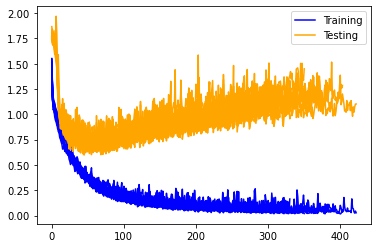

In [14]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

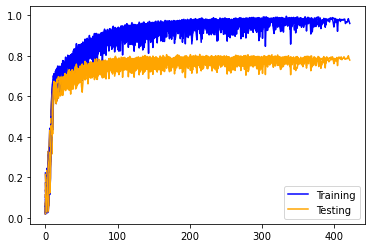

In [15]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

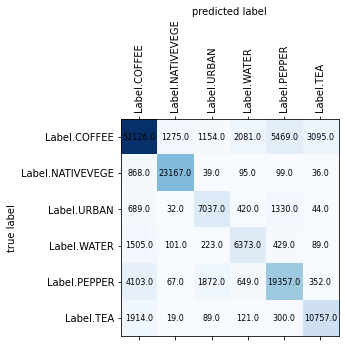

In [16]:
plot_confusion_matrix(conf_matrix, labels)

In [17]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.85166245 0.93941852 0.67572499 0.6543793  0.71735102 0.74841717]
Mean precision:  0.7644922400291615

Recalls:  [0.79947853 0.95321758 0.73670436 0.73084862 0.7332197  0.81492424]
Mean recall:  0.7947321705528188

F-Score:  [0.82474586 0.94626774 0.70489833 0.69050328 0.72519856 0.78025605]
Mean f-score:  0.778644968746109


# COASTAL_AEROSOL, BLUE, GREEN, RED, NIR, SWIR1, SWIR2

In [18]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

model_name = "coastal_aerosol_blue_green_red_nir_swir1_swir2"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)         

57/57 [==============================] - 0s 7ms/step - loss: 0.1573 - accuracy: 0.9102 - val_loss: 0.7671 - val_accuracy: 0.7653
Epoch 101/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1860 - accuracy: 0.8919 - val_loss: 0.9099 - val_accuracy: 0.7462
Epoch 102/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2251 - accuracy: 0.8706 - val_loss: 0.7955 - val_accuracy: 0.7721
Epoch 103/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1653 - accuracy: 0.9119 - val_loss: 0.7834 - val_accuracy: 0.7869
Epoch 104/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1865 - accuracy: 0.8879 - val_loss: 0.8482 - val_accuracy: 0.7486
Epoch 105/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1917 - accuracy: 0.8862 - val_loss: 0.8363 - val_accuracy: 0.7573
Epoch 106/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1930 - accuracy: 0.8662 - val_loss: 0.8333 - val_accuracy: 0.7571
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1361 - accuracy: 0.9219 - val_loss: 0.8199 - val_accuracy: 0.8009
Epoch 158/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1404 - accuracy: 0.9295 - val_loss: 0.8600 - val_accuracy: 0.7732
Epoch 159/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1798 - accuracy: 0.9019 - val_loss: 0.8529 - val_accuracy: 0.7827
Epoch 160/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1314 - accuracy: 0.9162 - val_loss: 0.9214 - val_accuracy: 0.7809
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1239 - accuracy: 0.9304 - val_loss: 0.8978 - val_accuracy: 0.7845
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9443 - val_loss: 0.9049 - val_accuracy: 0.7830
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1276 - accuracy: 0.9419 - val_loss: 0.8705 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0977 - accuracy: 0.9416 - val_loss: 0.9853 - val_accuracy: 0.7864
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0964 - accuracy: 0.9494 - val_loss: 0.9853 - val_accuracy: 0.7842
Epoch 216/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0554 - accuracy: 0.9625 - val_loss: 0.9866 - val_accuracy: 0.7959
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0867 - accuracy: 0.9556 - val_loss: 1.0817 - val_accuracy: 0.7888
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0671 - accuracy: 0.9585 - val_loss: 1.2363 - val_accuracy: 0.7590
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1771 - accuracy: 0.9126 - val_loss: 0.9812 - val_accuracy: 0.7929
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.9366 - val_loss: 0.9360 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0642 - accuracy: 0.9686 - val_loss: 1.0589 - val_accuracy: 0.7951
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0568 - accuracy: 0.9646 - val_loss: 1.1817 - val_accuracy: 0.7857
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1133 - accuracy: 0.9387 - val_loss: 1.0257 - val_accuracy: 0.7937
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0621 - accuracy: 0.9674 - val_loss: 1.1241 - val_accuracy: 0.7987
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9688 - val_loss: 1.1498 - val_accuracy: 0.7917
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.9737 - val_loss: 1.1493 - val_accuracy: 0.7907
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0554 - accuracy: 0.9525 - val_loss: 1.1134 - val_accuracy:

Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9877 - val_loss: 1.1368 - val_accuracy: 0.8108
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9874 - val_loss: 1.1676 - val_accuracy: 0.8092
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.9409 - val_loss: 1.2181 - val_accuracy: 0.7595
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1066 - accuracy: 0.9434 - val_loss: 1.0209 - val_accuracy: 0.7967
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0573 - accuracy: 0.9620 - val_loss: 1.0942 - val_accuracy: 0.7914
Epoch 333/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0607 - accuracy: 0.9653 - val_loss: 1.1553 - val_accuracy: 0.7849
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0843 - accuracy: 0.9545 - val_loss: 1.0736 - val_accuracy:

Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.9748 - val_loss: 1.2631 - val_accuracy: 0.8002
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.9717 - val_loss: 1.2245 - val_accuracy: 0.7975
Epoch 387/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0549 - accuracy: 0.9694 - val_loss: 1.3100 - val_accuracy: 0.7909
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0481 - accuracy: 0.9698 - val_loss: 1.3070 - val_accuracy: 0.7913
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.9783 - val_loss: 1.3286 - val_accuracy: 0.8004
Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9628 - val_loss: 1.2421 - val_accuracy: 0.7854
Epoch 391/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0881 - accuracy: 0.9579 - val_loss: 1.2574 - val_accuracy:

Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0655 - accuracy: 0.9663 - val_loss: 1.2864 - val_accuracy: 0.7982
Epoch 443/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0468 - accuracy: 0.9708 - val_loss: 1.2398 - val_accuracy: 0.7919
Epoch 444/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0516 - accuracy: 0.9676 - val_loss: 1.2611 - val_accuracy: 0.8008
Epoch 445/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0301 - accuracy: 0.9791 - val_loss: 1.3346 - val_accuracy: 0.7856
Epoch 446/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.9765 - val_loss: 1.3427 - val_accuracy: 0.8046
Epoch 447/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0481 - accuracy: 0.9750 - val_loss: 1.3508 - val_accuracy: 0.8050
Epoch 448/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 0.9632 - val_loss: 1.2446 - val_accuracy:

Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4246 - accuracy: 0.7764 - val_loss: 0.6995 - val_accuracy: 0.7464
Epoch 50/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4355 - accuracy: 0.7807 - val_loss: 0.8131 - val_accuracy: 0.7156
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3763 - accuracy: 0.7924 - val_loss: 0.7402 - val_accuracy: 0.7329
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3314 - accuracy: 0.8172 - val_loss: 0.8163 - val_accuracy: 0.7264
Epoch 53/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3826 - accuracy: 0.7991 - val_loss: 0.6940 - val_accuracy: 0.7618
Epoch 54/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3904 - accuracy: 0.8064 - val_loss: 0.7833 - val_accuracy: 0.7262
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4208 - accuracy: 0.7940 - val_loss: 0.6932 - val_accuracy: 0.7565

Epoch 163/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1444 - accuracy: 0.9206 - val_loss: 0.9813 - val_accuracy: 0.7686
Epoch 164/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1151 - accuracy: 0.9348 - val_loss: 0.9484 - val_accuracy: 0.7754
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1075 - accuracy: 0.9424 - val_loss: 0.9823 - val_accuracy: 0.7842
Epoch 166/2000
57/57 [==============================] - 1s 15ms/step - loss: 0.0939 - accuracy: 0.9398 - val_loss: 0.9670 - val_accuracy: 0.7812
Epoch 167/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1406 - accuracy: 0.9115 - val_loss: 1.0323 - val_accuracy: 0.7709
Epoch 168/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1237 - accuracy: 0.9174 - val_loss: 1.0117 - val_accuracy: 0.7747
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1849 - accuracy: 0.9024 - val_loss: 0.8458 - val_accura

Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1062 - accuracy: 0.9434 - val_loss: 0.9688 - val_accuracy: 0.7981
Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0703 - accuracy: 0.9568 - val_loss: 1.0301 - val_accuracy: 0.7867
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0681 - accuracy: 0.9599 - val_loss: 1.1091 - val_accuracy: 0.7883
Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1306 - accuracy: 0.9242 - val_loss: 1.2077 - val_accuracy: 0.7507
Epoch 224/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1588 - accuracy: 0.9276 - val_loss: 1.0669 - val_accuracy: 0.7686
Epoch 225/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1043 - accuracy: 0.9300 - val_loss: 1.0536 - val_accuracy: 0.7841
Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0997 - accuracy: 0.9307 - val_loss: 1.0183 - val_accuracy:

Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1071 - accuracy: 0.9486 - val_loss: 1.1940 - val_accuracy: 0.7808
Epoch 278/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0941 - accuracy: 0.9462 - val_loss: 1.2216 - val_accuracy: 0.7582
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2126 - accuracy: 0.9096 - val_loss: 1.3307 - val_accuracy: 0.7541
Epoch 280/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1866 - accuracy: 0.9142 - val_loss: 1.0338 - val_accuracy: 0.7745
Epoch 281/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0958 - accuracy: 0.9384 - val_loss: 1.0584 - val_accuracy: 0.7863
Epoch 282/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.9628 - val_loss: 1.0948 - val_accuracy: 0.7859
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9632 - val_loss: 1.0849 - val_accuracy:

Epoch 334/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0575 - accuracy: 0.9693 - val_loss: 1.1605 - val_accuracy: 0.7844
Epoch 335/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0514 - accuracy: 0.9688 - val_loss: 1.3073 - val_accuracy: 0.7770
Epoch 336/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0813 - accuracy: 0.9434 - val_loss: 1.1053 - val_accuracy: 0.7901
Epoch 337/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 0.9476 - val_loss: 1.2119 - val_accuracy: 0.7791
Epoch 338/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1125 - accuracy: 0.9575 - val_loss: 1.0774 - val_accuracy: 0.7899
Epoch 339/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1131 - accuracy: 0.9383 - val_loss: 1.0379 - val_accuracy: 0.7996
Epoch 340/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0526 - accuracy: 0.9697 - val_loss: 1.1248 - val_accuracy:

Epoch 391/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0467 - accuracy: 0.9698 - val_loss: 1.3308 - val_accuracy: 0.7697
Epoch 392/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0825 - accuracy: 0.9440 - val_loss: 1.2593 - val_accuracy: 0.7882
Epoch 393/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0588 - accuracy: 0.9637 - val_loss: 1.2059 - val_accuracy: 0.7825
Epoch 394/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9478 - val_loss: 1.1647 - val_accuracy: 0.7787
Epoch 395/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1266 - accuracy: 0.9427 - val_loss: 1.0913 - val_accuracy: 0.7796
Epoch 396/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.9426 - val_loss: 1.1422 - val_accuracy: 0.7804
Epoch 397/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0783 - accuracy: 0.9538 - val_loss: 1.1978 - val_accuracy:

Epoch 448/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9627 - val_loss: 1.2274 - val_accuracy: 0.7937
Epoch 449/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0561 - accuracy: 0.9688 - val_loss: 1.1757 - val_accuracy: 0.8036
Epoch 450/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9852 - val_loss: 1.3159 - val_accuracy: 0.7907
Epoch 451/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9808 - val_loss: 1.2612 - val_accuracy: 0.8008
Epoch 452/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0738 - accuracy: 0.9619 - val_loss: 1.3178 - val_accuracy: 0.8008
Epoch 453/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0275 - accuracy: 0.9784 - val_loss: 1.2979 - val_accuracy: 0.7975
Epoch 454/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.9817 - val_loss: 1.2849 - val_accuracy:

Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5627 - accuracy: 0.7212 - val_loss: 0.8641 - val_accuracy: 0.6956
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4779 - accuracy: 0.7439 - val_loss: 0.8959 - val_accuracy: 0.6692
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4736 - accuracy: 0.7459 - val_loss: 0.8120 - val_accuracy: 0.7061
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5082 - accuracy: 0.7497 - val_loss: 0.7252 - val_accuracy: 0.7388
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4607 - accuracy: 0.7661 - val_loss: 0.7676 - val_accuracy: 0.7245
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4562 - accuracy: 0.7391 - val_loss: 0.7322 - val_accuracy: 0.7465
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4820 - accuracy: 0.7454 - val_loss: 0.7730 - val_accuracy: 0.7286

Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1491 - accuracy: 0.9143 - val_loss: 0.8844 - val_accuracy: 0.7826
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1199 - accuracy: 0.9355 - val_loss: 0.8994 - val_accuracy: 0.7952
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.9306 - val_loss: 0.8809 - val_accuracy: 0.7868
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0902 - accuracy: 0.9444 - val_loss: 0.8781 - val_accuracy: 0.7986
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1188 - accuracy: 0.9201 - val_loss: 0.8753 - val_accuracy: 0.7951
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1050 - accuracy: 0.9268 - val_loss: 0.9198 - val_accuracy: 0.7893
Epoch 162/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0881 - accuracy: 0.9414 - val_loss: 0.9319 - val_accuracy:

Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1270 - accuracy: 0.9352 - val_loss: 0.9686 - val_accuracy: 0.7941
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1052 - accuracy: 0.9412 - val_loss: 1.0132 - val_accuracy: 0.7955
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0900 - accuracy: 0.9418 - val_loss: 1.0599 - val_accuracy: 0.7878
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1604 - accuracy: 0.9200 - val_loss: 1.0496 - val_accuracy: 0.7697
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.9277 - val_loss: 1.0354 - val_accuracy: 0.7848
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1184 - accuracy: 0.9237 - val_loss: 1.0042 - val_accuracy: 0.7931
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0671 - accuracy: 0.9548 - val_loss: 1.0001 - val_accuracy:

Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0976 - accuracy: 0.9471 - val_loss: 1.2010 - val_accuracy: 0.7749
Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0932 - accuracy: 0.9322 - val_loss: 1.1320 - val_accuracy: 0.7878
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0901 - accuracy: 0.9496 - val_loss: 1.1417 - val_accuracy: 0.7935
Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0450 - accuracy: 0.9706 - val_loss: 1.1825 - val_accuracy: 0.7969
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0707 - accuracy: 0.9686 - val_loss: 1.0886 - val_accuracy: 0.8091
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0694 - accuracy: 0.9551 - val_loss: 1.1140 - val_accuracy: 0.7955
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0732 - accuracy: 0.9559 - val_loss: 1.2194 - val_accuracy:

Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9695 - val_loss: 1.1639 - val_accuracy: 0.7958
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.9649 - val_loss: 1.1534 - val_accuracy: 0.8047
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0455 - accuracy: 0.9691 - val_loss: 1.2189 - val_accuracy: 0.8061
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9713 - val_loss: 1.1847 - val_accuracy: 0.8040
Epoch 331/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.9657 - val_loss: 1.3602 - val_accuracy: 0.7993
Epoch 332/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0914 - accuracy: 0.9664 - val_loss: 1.2467 - val_accuracy: 0.7663
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0963 - accuracy: 0.9455 - val_loss: 1.1593 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.2921 - accuracy: 0.8170 - val_loss: 0.8190 - val_accuracy: 0.7457
Epoch 67/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2765 - accuracy: 0.8347 - val_loss: 0.7843 - val_accuracy: 0.7491
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2984 - accuracy: 0.8331 - val_loss: 0.7940 - val_accuracy: 0.7492
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2862 - accuracy: 0.8307 - val_loss: 0.8408 - val_accuracy: 0.7249
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3057 - accuracy: 0.8187 - val_loss: 0.9003 - val_accuracy: 0.7203
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2899 - accuracy: 0.8255 - val_loss: 0.9913 - val_accuracy: 0.7048
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2650 - accuracy: 0.8191 - val_loss: 0.8974 - val_accuracy: 0.7184
Epoch 73/2000

Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2163 - accuracy: 0.8844 - val_loss: 1.3171 - val_accuracy: 0.7312
Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1966 - accuracy: 0.8957 - val_loss: 1.0505 - val_accuracy: 0.7665
Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1194 - accuracy: 0.9157 - val_loss: 1.0637 - val_accuracy: 0.7741
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0992 - accuracy: 0.9256 - val_loss: 1.0634 - val_accuracy: 0.7833
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.9516 - val_loss: 1.0773 - val_accuracy: 0.7874
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0839 - accuracy: 0.9474 - val_loss: 1.1601 - val_accuracy: 0.7730
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0834 - accuracy: 0.9519 - val_loss: 1.2128 - val_accuracy:

Epoch 237/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0855 - accuracy: 0.9482 - val_loss: 1.1155 - val_accuracy: 0.7693
Epoch 238/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0965 - accuracy: 0.9283 - val_loss: 1.1628 - val_accuracy: 0.7776
Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0888 - accuracy: 0.9438 - val_loss: 1.1768 - val_accuracy: 0.7692
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1810 - accuracy: 0.9187 - val_loss: 1.1099 - val_accuracy: 0.7728
Epoch 241/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1178 - accuracy: 0.9404 - val_loss: 1.0189 - val_accuracy: 0.7876
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0965 - accuracy: 0.9500 - val_loss: 1.3063 - val_accuracy: 0.7062
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1671 - accuracy: 0.9134 - val_loss: 1.0902 - val_accuracy:

Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1038 - accuracy: 0.9481 - val_loss: 1.1804 - val_accuracy: 0.7822
Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0440 - accuracy: 0.9722 - val_loss: 1.1774 - val_accuracy: 0.7830
Epoch 296/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.9643 - val_loss: 1.2964 - val_accuracy: 0.7912
Epoch 297/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.9716 - val_loss: 1.3006 - val_accuracy: 0.7865
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0998 - accuracy: 0.9539 - val_loss: 1.2890 - val_accuracy: 0.7821
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9594 - val_loss: 1.2635 - val_accuracy: 0.7903
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0717 - accuracy: 0.9553 - val_loss: 1.3629 - val_accuracy:

Epoch 351/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9840 - val_loss: 1.3763 - val_accuracy: 0.7898
Epoch 352/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0564 - accuracy: 0.9636 - val_loss: 1.3697 - val_accuracy: 0.7827
Epoch 353/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1320 - accuracy: 0.9559 - val_loss: 1.2715 - val_accuracy: 0.7773
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.9691 - val_loss: 1.3343 - val_accuracy: 0.7902
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.9677 - val_loss: 1.3282 - val_accuracy: 0.7979
Epoch 356/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9789 - val_loss: 1.2733 - val_accuracy: 0.7988
Epoch 357/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0458 - accuracy: 0.9729 - val_loss: 1.3389 - val_accuracy:

Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3672 - accuracy: 0.7999 - val_loss: 0.7650 - val_accuracy: 0.7237
Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3928 - accuracy: 0.7934 - val_loss: 0.6725 - val_accuracy: 0.7601
Epoch 51/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3636 - accuracy: 0.7998 - val_loss: 0.6893 - val_accuracy: 0.7514
Epoch 52/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3867 - accuracy: 0.7980 - val_loss: 0.6767 - val_accuracy: 0.7690
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3705 - accuracy: 0.7879 - val_loss: 0.7685 - val_accuracy: 0.7203
Epoch 54/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3314 - accuracy: 0.8195 - val_loss: 0.6556 - val_accuracy: 0.7694
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3540 - accuracy: 0.8114 - val_loss: 0.8315 - val_accuracy: 0.7130

Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1226 - accuracy: 0.9367 - val_loss: 1.0090 - val_accuracy: 0.7856
Epoch 164/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1463 - accuracy: 0.9138 - val_loss: 0.9848 - val_accuracy: 0.7785
Epoch 165/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1028 - accuracy: 0.9349 - val_loss: 0.9137 - val_accuracy: 0.7921
Epoch 166/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0845 - accuracy: 0.9433 - val_loss: 0.9112 - val_accuracy: 0.8015
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1146 - accuracy: 0.9328 - val_loss: 0.9616 - val_accuracy: 0.7918
Epoch 168/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1225 - accuracy: 0.9436 - val_loss: 1.0679 - val_accuracy: 0.7856
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1629 - accuracy: 0.9080 - val_loss: 0.9273 - val_accuracy:

Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1279 - accuracy: 0.9294 - val_loss: 1.2535 - val_accuracy: 0.7423
Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2192 - accuracy: 0.8891 - val_loss: 0.9774 - val_accuracy: 0.7841
Epoch 222/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9547 - val_loss: 0.9589 - val_accuracy: 0.8008
Epoch 223/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0819 - accuracy: 0.9616 - val_loss: 1.0123 - val_accuracy: 0.8046
Epoch 224/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0999 - accuracy: 0.9507 - val_loss: 1.0272 - val_accuracy: 0.7897
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0645 - accuracy: 0.9623 - val_loss: 1.0254 - val_accuracy: 0.8000
Epoch 226/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0634 - accuracy: 0.9622 - val_loss: 1.0946 - val_accuracy:

Epoch 277/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0890 - accuracy: 0.9525 - val_loss: 1.1245 - val_accuracy: 0.8024
Epoch 278/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0371 - accuracy: 0.9755 - val_loss: 1.2121 - val_accuracy: 0.8026
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9668 - val_loss: 1.1196 - val_accuracy: 0.7948
Epoch 280/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0701 - accuracy: 0.9612 - val_loss: 1.1305 - val_accuracy: 0.8134
Epoch 281/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0479 - accuracy: 0.9638 - val_loss: 1.2405 - val_accuracy: 0.8021
Epoch 282/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0564 - accuracy: 0.9683 - val_loss: 1.1547 - val_accuracy: 0.8053
Epoch 283/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0523 - accuracy: 0.9726 - val_loss: 1.1476 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5094 - accuracy: 0.7593 - val_loss: 0.7252 - val_accuracy: 0.7277
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5109 - accuracy: 0.7552 - val_loss: 0.7676 - val_accuracy: 0.7029
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4977 - accuracy: 0.7396 - val_loss: 0.8239 - val_accuracy: 0.6920
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4731 - accuracy: 0.7545 - val_loss: 0.7505 - val_accuracy: 0.7205
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4393 - accuracy: 0.7640 - val_loss: 0.7632 - val_accuracy: 0.7159
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4605 - accuracy: 0.7624 - val_loss: 0.7173 - val_accuracy: 0.7286
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4270 - accuracy: 0.7806 - val_loss: 0.7550 - val_accuracy: 0.7277

57/57 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.9104 - val_loss: 0.9214 - val_accuracy: 0.7930
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.9418 - val_loss: 1.1809 - val_accuracy: 0.7262
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2005 - accuracy: 0.9074 - val_loss: 0.8885 - val_accuracy: 0.7808
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1296 - accuracy: 0.9177 - val_loss: 1.1193 - val_accuracy: 0.7548
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1128 - accuracy: 0.9175 - val_loss: 1.0347 - val_accuracy: 0.7671
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1180 - accuracy: 0.9195 - val_loss: 1.0141 - val_accuracy: 0.7811
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1149 - accuracy: 0.9223 - val_loss: 0.9613 - val_accuracy: 0.7853
Epoch 1

Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1000 - accuracy: 0.9465 - val_loss: 1.0928 - val_accuracy: 0.7761
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0756 - accuracy: 0.9563 - val_loss: 1.0735 - val_accuracy: 0.7704
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0950 - accuracy: 0.9479 - val_loss: 0.9903 - val_accuracy: 0.7881
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0816 - accuracy: 0.9498 - val_loss: 1.0517 - val_accuracy: 0.7748
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0796 - accuracy: 0.9479 - val_loss: 1.0565 - val_accuracy: 0.7917
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0659 - accuracy: 0.9611 - val_loss: 1.0834 - val_accuracy: 0.7858
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0674 - accuracy: 0.9547 - val_loss: 1.1125 - val_accuracy:

Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0797 - accuracy: 0.9617 - val_loss: 1.2978 - val_accuracy: 0.7645
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0772 - accuracy: 0.9491 - val_loss: 1.2490 - val_accuracy: 0.7770
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.9422 - val_loss: 1.1071 - val_accuracy: 0.7782
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0725 - accuracy: 0.9470 - val_loss: 1.1875 - val_accuracy: 0.7736
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1005 - accuracy: 0.9407 - val_loss: 1.1253 - val_accuracy: 0.7811
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0555 - accuracy: 0.9627 - val_loss: 1.1379 - val_accuracy: 0.7964
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.9771 - val_loss: 1.2171 - val_accuracy:

Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0667 - accuracy: 0.9646 - val_loss: 1.2191 - val_accuracy: 0.7923
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0367 - accuracy: 0.9825 - val_loss: 1.3137 - val_accuracy: 0.7860
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0636 - accuracy: 0.9619 - val_loss: 1.2756 - val_accuracy: 0.7887
Epoch 326/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0337 - accuracy: 0.9792 - val_loss: 1.4254 - val_accuracy: 0.7898
Epoch 327/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1257 - accuracy: 0.9513 - val_loss: 1.2268 - val_accuracy: 0.7716
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.9468 - val_loss: 1.1301 - val_accuracy: 0.7847
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0895 - accuracy: 0.9645 - val_loss: 1.1650 - val_accuracy:

Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9774 - val_loss: 1.2434 - val_accuracy: 0.8066
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0620 - accuracy: 0.9686 - val_loss: 1.2593 - val_accuracy: 0.7951
Epoch 382/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.9769 - val_loss: 1.4055 - val_accuracy: 0.7660
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9625 - val_loss: 1.3702 - val_accuracy: 0.7721
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9543 - val_loss: 1.2696 - val_accuracy: 0.7838
Epoch 385/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0341 - accuracy: 0.9782 - val_loss: 1.3561 - val_accuracy: 0.7904
Epoch 386/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0614 - accuracy: 0.9687 - val_loss: 1.3970 - val_accuracy:

Epoch 437/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1000 - accuracy: 0.9519 - val_loss: 1.2572 - val_accuracy: 0.7926
Epoch 438/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.9758 - val_loss: 1.2972 - val_accuracy: 0.7989
Epoch 439/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0285 - accuracy: 0.9833 - val_loss: 1.3102 - val_accuracy: 0.7909
Epoch 440/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9665 - val_loss: 1.2733 - val_accuracy: 0.7985
Epoch 441/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.9732 - val_loss: 1.2579 - val_accuracy: 0.8014
Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9861 - val_loss: 1.3028 - val_accuracy: 0.7960
Epoch 443/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0173 - accuracy: 0.9897 - val_loss: 1.3892 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.2659 - accuracy: 0.8531 - val_loss: 0.7322 - val_accuracy: 0.7552
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2752 - accuracy: 0.8518 - val_loss: 0.8017 - val_accuracy: 0.7458
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3122 - accuracy: 0.8406 - val_loss: 0.7548 - val_accuracy: 0.7532
Epoch 73/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2503 - accuracy: 0.8760 - val_loss: 0.7970 - val_accuracy: 0.7352
Epoch 74/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2912 - accuracy: 0.8474 - val_loss: 0.7000 - val_accuracy: 0.7656
Epoch 75/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2518 - accuracy: 0.8674 - val_loss: 0.8257 - val_accuracy: 0.7351
Epoch 76/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2279 - accuracy: 0.8753 - val_loss: 0.7870 - val_accuracy: 0.7538
Epoch 77/2000

Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1014 - accuracy: 0.9340 - val_loss: 0.9126 - val_accuracy: 0.7921
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9295 - val_loss: 0.9071 - val_accuracy: 0.7906
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1188 - accuracy: 0.9352 - val_loss: 0.9535 - val_accuracy: 0.7859
Epoch 187/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0962 - accuracy: 0.9388 - val_loss: 0.9968 - val_accuracy: 0.7936
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9336 - val_loss: 0.9658 - val_accuracy: 0.7791
Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2228 - accuracy: 0.9023 - val_loss: 0.9006 - val_accuracy: 0.7804
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1779 - accuracy: 0.9100 - val_loss: 0.9160 - val_accuracy:

Epoch 241/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0687 - accuracy: 0.9643 - val_loss: 1.0773 - val_accuracy: 0.7879
Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0828 - accuracy: 0.9488 - val_loss: 1.1306 - val_accuracy: 0.7859
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0568 - accuracy: 0.9659 - val_loss: 1.0935 - val_accuracy: 0.7898
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0551 - accuracy: 0.9651 - val_loss: 1.3408 - val_accuracy: 0.7523
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1015 - accuracy: 0.9343 - val_loss: 1.1503 - val_accuracy: 0.7848
Epoch 246/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 0.9571 - val_loss: 1.1865 - val_accuracy: 0.7766
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.9487 - val_loss: 1.0831 - val_accuracy:

Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.9659 - val_loss: 1.0682 - val_accuracy: 0.7852
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9708 - val_loss: 1.0997 - val_accuracy: 0.7840
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.9626 - val_loss: 1.0791 - val_accuracy: 0.7897
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0757 - accuracy: 0.9668 - val_loss: 1.0639 - val_accuracy: 0.7921
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9722 - val_loss: 1.1486 - val_accuracy: 0.7893
Epoch 303/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0549 - accuracy: 0.9759 - val_loss: 1.0964 - val_accuracy: 0.7956
Epoch 304/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.9701 - val_loss: 1.1539 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5483 - accuracy: 0.6928 - val_loss: 0.7497 - val_accuracy: 0.7008
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5374 - accuracy: 0.6978 - val_loss: 0.9248 - val_accuracy: 0.6407
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5011 - accuracy: 0.7068 - val_loss: 0.9681 - val_accuracy: 0.6428
Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6812 - accuracy: 0.6999 - val_loss: 0.8784 - val_accuracy: 0.6696
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5133 - accuracy: 0.7188 - val_loss: 0.7245 - val_accuracy: 0.7253
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5224 - accuracy: 0.7207 - val_loss: 0.8770 - val_accuracy: 0.6568
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5135 - accuracy: 0.7168 - val_loss: 0.7944 - val_accuracy: 0.7108

57/57 [==============================] - 0s 7ms/step - loss: 0.1101 - accuracy: 0.9297 - val_loss: 0.8617 - val_accuracy: 0.8072
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1129 - accuracy: 0.9360 - val_loss: 0.9507 - val_accuracy: 0.7988
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1425 - accuracy: 0.9328 - val_loss: 0.8629 - val_accuracy: 0.7817
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1653 - accuracy: 0.9175 - val_loss: 1.0772 - val_accuracy: 0.7650
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1947 - accuracy: 0.8970 - val_loss: 0.9321 - val_accuracy: 0.7761
Epoch 157/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1292 - accuracy: 0.9302 - val_loss: 0.9173 - val_accuracy: 0.7808
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1405 - accuracy: 0.9072 - val_loss: 0.8960 - val_accuracy: 0.7776
Epoch 1

Epoch 209/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0800 - accuracy: 0.9611 - val_loss: 1.0385 - val_accuracy: 0.7760
Epoch 210/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1508 - accuracy: 0.9306 - val_loss: 0.9562 - val_accuracy: 0.7859
Epoch 211/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0751 - accuracy: 0.9589 - val_loss: 0.9393 - val_accuracy: 0.8040
Epoch 212/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0653 - accuracy: 0.9565 - val_loss: 0.9831 - val_accuracy: 0.7977
Epoch 213/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0809 - accuracy: 0.9491 - val_loss: 1.0171 - val_accuracy: 0.8049
Epoch 214/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0552 - accuracy: 0.9650 - val_loss: 1.1394 - val_accuracy: 0.7890
Epoch 215/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1736 - accuracy: 0.9258 - val_loss: 1.0598 - val_acc

Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0908 - accuracy: 0.9551 - val_loss: 1.0294 - val_accuracy: 0.7940
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0583 - accuracy: 0.9728 - val_loss: 1.0605 - val_accuracy: 0.7993
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9506 - val_loss: 1.0808 - val_accuracy: 0.7846
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1490 - accuracy: 0.9231 - val_loss: 1.0697 - val_accuracy: 0.7924
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0968 - accuracy: 0.9437 - val_loss: 1.0434 - val_accuracy: 0.7996
Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0565 - accuracy: 0.9680 - val_loss: 1.0543 - val_accuracy: 0.8078
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0714 - accuracy: 0.9631 - val_loss: 1.1405 - val_accuracy:

Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1079 - accuracy: 0.9588 - val_loss: 1.2393 - val_accuracy: 0.7831
Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 0.9519 - val_loss: 1.1523 - val_accuracy: 0.8103
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0799 - accuracy: 0.9700 - val_loss: 1.2291 - val_accuracy: 0.7787
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9552 - val_loss: 1.1422 - val_accuracy: 0.7990
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0815 - accuracy: 0.9594 - val_loss: 1.1336 - val_accuracy: 0.7956
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0562 - accuracy: 0.9655 - val_loss: 1.2745 - val_accuracy: 0.7834
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0610 - accuracy: 0.9578 - val_loss: 1.2819 - val_accuracy:

Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0705 - accuracy: 0.9518 - val_loss: 1.1504 - val_accuracy: 0.7899
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9727 - val_loss: 1.1539 - val_accuracy: 0.8008
Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0545 - accuracy: 0.9744 - val_loss: 1.1783 - val_accuracy: 0.8019
Epoch 383/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.9733 - val_loss: 1.1503 - val_accuracy: 0.7986
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0443 - accuracy: 0.9772 - val_loss: 1.2286 - val_accuracy: 0.8028
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0359 - accuracy: 0.9789 - val_loss: 1.2349 - val_accuracy: 0.8017
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0402 - accuracy: 0.9754 - val_loss: 1.2700 - val_accuracy:

Epoch 437/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.9549 - val_loss: 1.1823 - val_accuracy: 0.7983
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0493 - accuracy: 0.9705 - val_loss: 1.3398 - val_accuracy: 0.7912
Epoch 439/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1396 - accuracy: 0.9390 - val_loss: 1.1502 - val_accuracy: 0.7925
Epoch 440/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0739 - accuracy: 0.9624 - val_loss: 1.2176 - val_accuracy: 0.7793
Epoch 441/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0447 - accuracy: 0.9704 - val_loss: 1.1234 - val_accuracy: 0.8040
Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9835 - val_loss: 1.2120 - val_accuracy: 0.8054
Epoch 443/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0283 - accuracy: 0.9852 - val_loss: 1.4051 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5014 - accuracy: 0.7353 - val_loss: 0.7355 - val_accuracy: 0.7169
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5201 - accuracy: 0.7216 - val_loss: 0.7137 - val_accuracy: 0.7325
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4861 - accuracy: 0.7273 - val_loss: 0.8158 - val_accuracy: 0.6970
Epoch 41/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.4277 - accuracy: 0.7526 - val_loss: 0.8009 - val_accuracy: 0.7019
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4574 - accuracy: 0.7579 - val_loss: 0.8635 - val_accuracy: 0.6811
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4222 - accuracy: 0.7486 - val_loss: 0.7364 - val_accuracy: 0.7342
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4612 - accuracy: 0.7578 - val_loss: 0.6767 - val_accuracy: 0.744

57/57 [==============================] - 0s 7ms/step - loss: 0.1248 - accuracy: 0.9292 - val_loss: 0.9080 - val_accuracy: 0.7935
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0969 - accuracy: 0.9379 - val_loss: 0.8901 - val_accuracy: 0.8019
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0813 - accuracy: 0.9542 - val_loss: 1.3384 - val_accuracy: 0.7275
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1779 - accuracy: 0.9130 - val_loss: 0.8115 - val_accuracy: 0.7993
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1335 - accuracy: 0.9243 - val_loss: 0.8878 - val_accuracy: 0.7884
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0939 - accuracy: 0.9379 - val_loss: 0.9930 - val_accuracy: 0.7491
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0814 - accuracy: 0.9488 - val_loss: 0.9051 - val_accuracy: 0.8054
Epoch 1

Epoch 209/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1314 - accuracy: 0.9324 - val_loss: 0.9843 - val_accuracy: 0.7959
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.9618 - val_loss: 1.0189 - val_accuracy: 0.7929
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0700 - accuracy: 0.9501 - val_loss: 0.9978 - val_accuracy: 0.7917
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0590 - accuracy: 0.9615 - val_loss: 1.0100 - val_accuracy: 0.7920
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0928 - accuracy: 0.9568 - val_loss: 1.0886 - val_accuracy: 0.7799
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.9625 - val_loss: 1.0496 - val_accuracy: 0.7979
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0479 - accuracy: 0.9684 - val_loss: 1.0806 - val_accuracy

Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6003 - accuracy: 0.7270 - val_loss: 0.9165 - val_accuracy: 0.6579
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5728 - accuracy: 0.6935 - val_loss: 0.8171 - val_accuracy: 0.6934
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5789 - accuracy: 0.7094 - val_loss: 0.8622 - val_accuracy: 0.6643
Epoch 27/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5898 - accuracy: 0.6891 - val_loss: 0.7599 - val_accuracy: 0.7224
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6321 - accuracy: 0.6825 - val_loss: 0.7568 - val_accuracy: 0.7198
Epoch 29/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6381 - accuracy: 0.6830 - val_loss: 0.8091 - val_accuracy: 0.7036
Epoch 30/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5680 - accuracy: 0.6954 - val_loss: 0.7348 - val_accuracy: 0.7267

57/57 [==============================] - 0s 8ms/step - loss: 0.1607 - accuracy: 0.8945 - val_loss: 0.8643 - val_accuracy: 0.7967
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1259 - accuracy: 0.9138 - val_loss: 0.8785 - val_accuracy: 0.7910
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2192 - accuracy: 0.8842 - val_loss: 0.8317 - val_accuracy: 0.7692
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1466 - accuracy: 0.9043 - val_loss: 0.8864 - val_accuracy: 0.8024
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1038 - accuracy: 0.9434 - val_loss: 0.9235 - val_accuracy: 0.8068
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.9205 - val_loss: 0.9217 - val_accuracy: 0.7875
Epoch 144/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1077 - accuracy: 0.9194 - val_loss: 0.9565 - val_accuracy: 0.8091
Epoch 1

Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0906 - accuracy: 0.9359 - val_loss: 1.0626 - val_accuracy: 0.7855
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1274 - accuracy: 0.9148 - val_loss: 0.9457 - val_accuracy: 0.7909
Epoch 197/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0723 - accuracy: 0.9340 - val_loss: 0.9775 - val_accuracy: 0.8032
Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1903 - accuracy: 0.9170 - val_loss: 0.9705 - val_accuracy: 0.7916
Epoch 199/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1494 - accuracy: 0.9203 - val_loss: 0.9258 - val_accuracy: 0.8042
Epoch 200/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0867 - accuracy: 0.9582 - val_loss: 0.9641 - val_accuracy: 0.8059
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0651 - accuracy: 0.9489 - val_loss: 1.0060 - val_accuracy:

Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0786 - accuracy: 0.9538 - val_loss: 1.1599 - val_accuracy: 0.7931
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0817 - accuracy: 0.9552 - val_loss: 1.2046 - val_accuracy: 0.7936
Epoch 254/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1273 - accuracy: 0.9326 - val_loss: 1.1006 - val_accuracy: 0.7861
Epoch 255/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1784 - accuracy: 0.9127 - val_loss: 1.1062 - val_accuracy: 0.7920
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0804 - accuracy: 0.9506 - val_loss: 1.0082 - val_accuracy: 0.8051
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0614 - accuracy: 0.9595 - val_loss: 1.0925 - val_accuracy: 0.8083
Epoch 258/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.9645 - val_loss: 1.0719 - val_accuracy:

Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1595 - accuracy: 0.9360 - val_loss: 1.1612 - val_accuracy: 0.7971
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0580 - accuracy: 0.9647 - val_loss: 1.0988 - val_accuracy: 0.8053
Epoch 311/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0561 - accuracy: 0.9617 - val_loss: 1.1256 - val_accuracy: 0.8036
Epoch 312/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0554 - accuracy: 0.9647 - val_loss: 1.1326 - val_accuracy: 0.7997
Epoch 313/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0459 - accuracy: 0.9666 - val_loss: 1.1955 - val_accuracy: 0.7998
Epoch 314/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0476 - accuracy: 0.9633 - val_loss: 1.1875 - val_accuracy: 0.8049
Epoch 315/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0651 - accuracy: 0.9616 - val_loss: 1.1994 - val_accurac

Epoch 34/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5258 - accuracy: 0.7201 - val_loss: 0.8665 - val_accuracy: 0.6815
Epoch 35/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4847 - accuracy: 0.7351 - val_loss: 0.7450 - val_accuracy: 0.7166
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5862 - accuracy: 0.7391 - val_loss: 0.8962 - val_accuracy: 0.6604
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5064 - accuracy: 0.7210 - val_loss: 0.8041 - val_accuracy: 0.6939
Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5204 - accuracy: 0.7323 - val_loss: 0.7443 - val_accuracy: 0.7212
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5053 - accuracy: 0.7452 - val_loss: 0.7931 - val_accuracy: 0.7005
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4795 - accuracy: 0.7306 - val_loss: 0.8785 - val_accuracy: 0.6758

Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1861 - accuracy: 0.8967 - val_loss: 1.0825 - val_accuracy: 0.7609
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1539 - accuracy: 0.8855 - val_loss: 0.9905 - val_accuracy: 0.7634
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1222 - accuracy: 0.9212 - val_loss: 0.9269 - val_accuracy: 0.7827
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1729 - accuracy: 0.9058 - val_loss: 1.0437 - val_accuracy: 0.7645
Epoch 152/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1452 - accuracy: 0.9129 - val_loss: 0.9135 - val_accuracy: 0.7843
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1321 - accuracy: 0.9185 - val_loss: 0.9249 - val_accuracy: 0.7716
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1673 - accuracy: 0.9102 - val_loss: 0.9706 - val_accuracy:

Epoch 205/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0993 - accuracy: 0.9446 - val_loss: 1.1023 - val_accuracy: 0.7824
Epoch 206/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0843 - accuracy: 0.9370 - val_loss: 1.1545 - val_accuracy: 0.7929
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0813 - accuracy: 0.9525 - val_loss: 1.1167 - val_accuracy: 0.7944
Epoch 208/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0869 - accuracy: 0.9604 - val_loss: 1.2769 - val_accuracy: 0.7424
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0818 - accuracy: 0.9475 - val_loss: 1.2801 - val_accuracy: 0.7645
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0928 - accuracy: 0.9489 - val_loss: 1.1483 - val_accuracy: 0.7747
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 0.9370 - val_loss: 1.2676 - val_accuracy:

Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9643 - val_loss: 1.1983 - val_accuracy: 0.7930
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9617 - val_loss: 1.2993 - val_accuracy: 0.7716
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2056 - accuracy: 0.9089 - val_loss: 0.9391 - val_accuracy: 0.7933
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.9500 - val_loss: 1.0767 - val_accuracy: 0.7824
Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0791 - accuracy: 0.9552 - val_loss: 1.0444 - val_accuracy: 0.7968
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0688 - accuracy: 0.9644 - val_loss: 1.1077 - val_accuracy: 0.7693
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0953 - accuracy: 0.9457 - val_loss: 1.1024 - val_accuracy:

Epoch 319/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1639 - accuracy: 0.9275 - val_loss: 1.1262 - val_accuracy: 0.7915
Epoch 320/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0762 - accuracy: 0.9633 - val_loss: 1.1110 - val_accuracy: 0.7885
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0487 - accuracy: 0.9701 - val_loss: 1.1270 - val_accuracy: 0.8010
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.9750 - val_loss: 1.1834 - val_accuracy: 0.7989
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0902 - accuracy: 0.9590 - val_loss: 1.2361 - val_accuracy: 0.7672
Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0806 - accuracy: 0.9570 - val_loss: 1.0743 - val_accuracy: 0.7961
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0646 - accuracy: 0.9638 - val_loss: 1.2034 - val_accuracy:

Epoch 376/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9618 - val_loss: 1.2336 - val_accuracy: 0.7856
Epoch 377/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0795 - accuracy: 0.9537 - val_loss: 1.4380 - val_accuracy: 0.7641
Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9492 - val_loss: 1.2775 - val_accuracy: 0.7975
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0680 - accuracy: 0.9724 - val_loss: 1.2395 - val_accuracy: 0.7960
Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.9734 - val_loss: 1.2750 - val_accuracy: 0.8066
Epoch 381/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9824 - val_loss: 1.2805 - val_accuracy: 0.8018
Epoch 382/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9822 - val_loss: 1.2483 - val_accuracy:

Epoch 433/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0343 - accuracy: 0.9769 - val_loss: 1.5710 - val_accuracy: 0.7706
Epoch 434/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 0.9587 - val_loss: 1.6033 - val_accuracy: 0.7816
Epoch 435/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0517 - accuracy: 0.9626 - val_loss: 1.4986 - val_accuracy: 0.7910
Epoch 436/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0565 - accuracy: 0.9718 - val_loss: 1.4053 - val_accuracy: 0.8023
Epoch 437/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1521 - accuracy: 0.9430 - val_loss: 1.2357 - val_accuracy: 0.7940
Epoch 438/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0732 - accuracy: 0.9591 - val_loss: 1.5172 - val_accuracy: 0.7615
Epoch 439/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0752 - accuracy: 0.9622 - val_loss: 1.3573 - val_accu

Epoch 490/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9926 - val_loss: 1.3788 - val_accuracy: 0.8069
Epoch 491/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9866 - val_loss: 1.4633 - val_accuracy: 0.8065
Epoch 492/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9818 - val_loss: 1.3469 - val_accuracy: 0.7894
Epoch 493/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0350 - accuracy: 0.9738 - val_loss: 1.2852 - val_accuracy: 0.7960
Epoch 494/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9796 - val_loss: 1.4011 - val_accuracy: 0.8069
Epoch 495/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0291 - accuracy: 0.9821 - val_loss: 1.3713 - val_accuracy: 0.7936
Epoch 496/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 0.9811 - val_loss: 1.4045 - val_accuracy:

Epoch 547/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0590 - accuracy: 0.9796 - val_loss: 1.1912 - val_accuracy: 0.7921
Epoch 548/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9676 - val_loss: 1.2935 - val_accuracy: 0.7955
Epoch 549/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0519 - accuracy: 0.9789 - val_loss: 1.3610 - val_accuracy: 0.8002
Epoch 550/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1217 - accuracy: 0.9510 - val_loss: 1.4261 - val_accuracy: 0.7683
Epoch 551/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1345 - accuracy: 0.9437 - val_loss: 1.1661 - val_accuracy: 0.7883
Epoch 552/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0629 - accuracy: 0.9716 - val_loss: 1.1508 - val_accuracy: 0.7938
Epoch 553/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0436 - accuracy: 0.9759 - val_loss: 1.2319 - val_accuracy:

Epoch 604/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9768 - val_loss: 1.4300 - val_accuracy: 0.7781
Epoch 605/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0344 - accuracy: 0.9670 - val_loss: 1.4266 - val_accuracy: 0.8077
Epoch 606/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9906 - val_loss: 1.4638 - val_accuracy: 0.7997
Epoch 607/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9849 - val_loss: 1.5060 - val_accuracy: 0.8021
Epoch 608/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9885 - val_loss: 1.4199 - val_accuracy: 0.8067
Epoch 609/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0513 - accuracy: 0.9742 - val_loss: 1.5986 - val_accuracy: 0.7857
Epoch 610/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0418 - accuracy: 0.9776 - val_loss: 1.4656 - val_accuracy:

Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6157 - accuracy: 0.6920 - val_loss: 0.8297 - val_accuracy: 0.6964
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6563 - accuracy: 0.6867 - val_loss: 0.8311 - val_accuracy: 0.6838
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5859 - accuracy: 0.6984 - val_loss: 0.7823 - val_accuracy: 0.7057
Epoch 25/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5564 - accuracy: 0.7155 - val_loss: 0.7692 - val_accuracy: 0.7065
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6570 - accuracy: 0.7000 - val_loss: 0.8990 - val_accuracy: 0.6597
Epoch 27/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5962 - accuracy: 0.6948 - val_loss: 0.6609 - val_accuracy: 0.7511
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5802 - accuracy: 0.7153 - val_loss: 0.8146 - val_accuracy: 0.6974

57/57 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9082 - val_loss: 0.8578 - val_accuracy: 0.7818
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2318 - accuracy: 0.8970 - val_loss: 0.8990 - val_accuracy: 0.7374
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1595 - accuracy: 0.9000 - val_loss: 0.9350 - val_accuracy: 0.7632
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1334 - accuracy: 0.9110 - val_loss: 0.9212 - val_accuracy: 0.7769
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1250 - accuracy: 0.9246 - val_loss: 0.8708 - val_accuracy: 0.7852
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1568 - accuracy: 0.9227 - val_loss: 0.8578 - val_accuracy: 0.7853
Epoch 142/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1086 - accuracy: 0.9255 - val_loss: 0.8943 - val_accuracy: 0.7895
Epoch 1

Epoch 193/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0659 - accuracy: 0.9510 - val_loss: 1.0509 - val_accuracy: 0.7906
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0734 - accuracy: 0.9566 - val_loss: 1.0790 - val_accuracy: 0.7891
Epoch 195/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0576 - accuracy: 0.9681 - val_loss: 1.0493 - val_accuracy: 0.7865
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.9513 - val_loss: 1.0350 - val_accuracy: 0.7932
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1224 - accuracy: 0.9515 - val_loss: 1.0314 - val_accuracy: 0.7926
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0708 - accuracy: 0.9542 - val_loss: 1.2070 - val_accuracy: 0.7686
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1165 - accuracy: 0.9172 - val_loss: 1.0977 - val_accuracy

Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5617 - accuracy: 0.7192 - val_loss: 0.8728 - val_accuracy: 0.6597
Epoch 32/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6385 - accuracy: 0.7091 - val_loss: 0.7170 - val_accuracy: 0.7249
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5601 - accuracy: 0.7491 - val_loss: 0.8132 - val_accuracy: 0.6841
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5610 - accuracy: 0.7303 - val_loss: 0.8381 - val_accuracy: 0.6811
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5654 - accuracy: 0.7238 - val_loss: 0.7635 - val_accuracy: 0.7176
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5954 - accuracy: 0.7161 - val_loss: 0.7676 - val_accuracy: 0.7010
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4902 - accuracy: 0.7254 - val_loss: 0.7303 - val_accuracy: 0.7099

57/57 [==============================] - 0s 8ms/step - loss: 0.1466 - accuracy: 0.9165 - val_loss: 0.8952 - val_accuracy: 0.7724
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1207 - accuracy: 0.9116 - val_loss: 0.8744 - val_accuracy: 0.7986
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1267 - accuracy: 0.9283 - val_loss: 0.8594 - val_accuracy: 0.7893
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1292 - accuracy: 0.9156 - val_loss: 0.9129 - val_accuracy: 0.7982
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9250 - val_loss: 1.0177 - val_accuracy: 0.7534
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1799 - accuracy: 0.8763 - val_loss: 0.8820 - val_accuracy: 0.7932
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1096 - accuracy: 0.9235 - val_loss: 0.9666 - val_accuracy: 0.7685
Epoch 1

Epoch 202/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.9252 - val_loss: 0.8970 - val_accuracy: 0.7894
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0718 - accuracy: 0.9426 - val_loss: 1.0252 - val_accuracy: 0.7943
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9528 - val_loss: 1.0580 - val_accuracy: 0.8035
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0986 - accuracy: 0.9428 - val_loss: 0.9786 - val_accuracy: 0.7955
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9628 - val_loss: 0.9760 - val_accuracy: 0.7960
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0889 - accuracy: 0.9496 - val_loss: 1.0429 - val_accuracy: 0.7788
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0812 - accuracy: 0.9540 - val_loss: 1.2688 - val_accuracy:

Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0730 - accuracy: 0.9707 - val_loss: 1.1252 - val_accuracy: 0.8027
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0341 - accuracy: 0.9777 - val_loss: 1.1501 - val_accuracy: 0.7963
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9698 - val_loss: 1.2088 - val_accuracy: 0.8036
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.9574 - val_loss: 1.1498 - val_accuracy: 0.7785
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9629 - val_loss: 1.2138 - val_accuracy: 0.7792
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0950 - accuracy: 0.9382 - val_loss: 1.0676 - val_accuracy: 0.7979
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9615 - val_loss: 1.0949 - val_accuracy:

Epoch 316/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0537 - accuracy: 0.9777 - val_loss: 1.2348 - val_accuracy: 0.8070
Epoch 317/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0596 - accuracy: 0.9749 - val_loss: 1.1764 - val_accuracy: 0.8008
Epoch 318/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0585 - accuracy: 0.9616 - val_loss: 1.2460 - val_accuracy: 0.7868
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 0.9678 - val_loss: 1.3121 - val_accuracy: 0.8017
Epoch 320/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0262 - accuracy: 0.9880 - val_loss: 1.3523 - val_accuracy: 0.7788
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0429 - accuracy: 0.9723 - val_loss: 1.3584 - val_accuracy: 0.7918
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0758 - accuracy: 0.9599 - val_loss: 1.2499 - val_accuracy

Epoch 373/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0480 - accuracy: 0.9675 - val_loss: 1.3108 - val_accuracy: 0.8019

Validation  3 , fold  4 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6013 - accuracy: 0.2216 - val_loss: 1.7457 - val_accuracy: 0.2454
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2829 - accuracy: 0.3468 - val_loss: 1.7007 - val_accuracy: 0.4419
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2889 - accuracy: 0.3876 - val_loss: 1.6771 - val_accuracy: 0.0978
Epoch 4/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1650 - accuracy: 0.3882 - val_loss: 1.6396 - val_accuracy: 0.4078
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1429 - accuracy: 0.4172 - val_loss: 1.7447 - val_accuracy: 0.1025
Epoch 6/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.1555 - accurac

Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.8241 - val_loss: 0.7738 - val_accuracy: 0.7217
Epoch 58/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3154 - accuracy: 0.8144 - val_loss: 0.7442 - val_accuracy: 0.7336
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3471 - accuracy: 0.8126 - val_loss: 0.7471 - val_accuracy: 0.7496
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3537 - accuracy: 0.8042 - val_loss: 0.7371 - val_accuracy: 0.7408
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3550 - accuracy: 0.8003 - val_loss: 0.7367 - val_accuracy: 0.7426
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3639 - accuracy: 0.8048 - val_loss: 0.8272 - val_accuracy: 0.7203
Epoch 63/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3155 - accuracy: 0.8212 - val_loss: 0.7341 - val_accuracy: 0.7441

Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1579 - accuracy: 0.9085 - val_loss: 0.9267 - val_accuracy: 0.7840
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1003 - accuracy: 0.9378 - val_loss: 0.9160 - val_accuracy: 0.7868
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.9247 - val_loss: 0.9395 - val_accuracy: 0.7884
Epoch 174/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1057 - accuracy: 0.9354 - val_loss: 0.9861 - val_accuracy: 0.7893
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0935 - accuracy: 0.9381 - val_loss: 1.0563 - val_accuracy: 0.7731
Epoch 176/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1115 - accuracy: 0.9342 - val_loss: 1.1491 - val_accuracy: 0.7757
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1616 - accuracy: 0.9083 - val_loss: 1.0444 - val_accuracy:

Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0846 - accuracy: 0.9305 - val_loss: 1.1211 - val_accuracy: 0.7822
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0895 - accuracy: 0.9465 - val_loss: 1.0551 - val_accuracy: 0.7960
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0585 - accuracy: 0.9572 - val_loss: 1.1430 - val_accuracy: 0.7804
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0921 - accuracy: 0.9519 - val_loss: 1.1611 - val_accuracy: 0.7781
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.9533 - val_loss: 1.1380 - val_accuracy: 0.7792
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9471 - val_loss: 1.0834 - val_accuracy: 0.7799
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0850 - accuracy: 0.9456 - val_loss: 1.2077 - val_accuracy:

Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0707 - accuracy: 0.9668 - val_loss: 1.1755 - val_accuracy: 0.7783
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0775 - accuracy: 0.9562 - val_loss: 1.0858 - val_accuracy: 0.7902
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0590 - accuracy: 0.9679 - val_loss: 1.1468 - val_accuracy: 0.7788
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9599 - val_loss: 1.2519 - val_accuracy: 0.7736
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0552 - accuracy: 0.9670 - val_loss: 1.2559 - val_accuracy: 0.7838
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0608 - accuracy: 0.9693 - val_loss: 1.2893 - val_accuracy: 0.7825
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9534 - val_loss: 1.1370 - val_accuracy:

Epoch 18/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7228 - accuracy: 0.6612 - val_loss: 0.8746 - val_accuracy: 0.6602
Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6778 - accuracy: 0.6910 - val_loss: 0.9484 - val_accuracy: 0.6374
Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7798 - accuracy: 0.6272 - val_loss: 0.8899 - val_accuracy: 0.6500
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6635 - accuracy: 0.6845 - val_loss: 0.8836 - val_accuracy: 0.6705
Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6819 - accuracy: 0.6674 - val_loss: 0.8404 - val_accuracy: 0.6825
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6882 - accuracy: 0.6846 - val_loss: 0.8233 - val_accuracy: 0.6872
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6137 - accuracy: 0.7163 - val_loss: 0.8283 - val_accuracy: 0.6896

57/57 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9428 - val_loss: 0.8449 - val_accuracy: 0.7952
Epoch 133/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1562 - accuracy: 0.9164 - val_loss: 0.8413 - val_accuracy: 0.7903
Epoch 134/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.9222 - val_loss: 0.9267 - val_accuracy: 0.7899
Epoch 135/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1299 - accuracy: 0.9252 - val_loss: 0.9406 - val_accuracy: 0.8004
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.9370 - val_loss: 0.9037 - val_accuracy: 0.8008
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0803 - accuracy: 0.9499 - val_loss: 0.9327 - val_accuracy: 0.7971
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0973 - accuracy: 0.9330 - val_loss: 0.9444 - val_accuracy: 0.7932
Epoch 1

Epoch 189/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1407 - accuracy: 0.9425 - val_loss: 1.0565 - val_accuracy: 0.7791
Epoch 190/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0744 - accuracy: 0.9509 - val_loss: 1.0942 - val_accuracy: 0.7912
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0621 - accuracy: 0.9639 - val_loss: 1.0890 - val_accuracy: 0.8055
Epoch 192/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0644 - accuracy: 0.9590 - val_loss: 1.2441 - val_accuracy: 0.7563
Epoch 193/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1015 - accuracy: 0.9342 - val_loss: 1.0510 - val_accuracy: 0.7966
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1159 - accuracy: 0.9326 - val_loss: 0.9951 - val_accuracy: 0.7857
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9382 - val_loss: 1.0424 - val_accurac

Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0666 - accuracy: 0.9545 - val_loss: 1.1937 - val_accuracy: 0.8011
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0755 - accuracy: 0.9682 - val_loss: 1.2225 - val_accuracy: 0.7872
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1525 - accuracy: 0.9244 - val_loss: 1.1491 - val_accuracy: 0.7773
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0919 - accuracy: 0.9501 - val_loss: 1.1847 - val_accuracy: 0.7856
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1763 - accuracy: 0.9253 - val_loss: 1.0238 - val_accuracy: 0.7912
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9652 - val_loss: 1.0712 - val_accuracy: 0.8045
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.9655 - val_loss: 1.1731 - val_accuracy:

Epoch 303/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0889 - accuracy: 0.9670 - val_loss: 1.2796 - val_accuracy: 0.8016
Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1288 - accuracy: 0.9536 - val_loss: 1.2225 - val_accuracy: 0.7776
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1079 - accuracy: 0.9485 - val_loss: 1.1954 - val_accuracy: 0.7998
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9631 - val_loss: 1.2081 - val_accuracy: 0.7979
Epoch 307/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0846 - accuracy: 0.9608 - val_loss: 1.2262 - val_accuracy: 0.7810
Epoch 308/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0599 - accuracy: 0.9622 - val_loss: 1.1195 - val_accuracy: 0.8053
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0568 - accuracy: 0.9696 - val_loss: 1.1731 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.3174 - accuracy: 0.8211 - val_loss: 0.7917 - val_accuracy: 0.7158
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3158 - accuracy: 0.8108 - val_loss: 0.7402 - val_accuracy: 0.7427
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2754 - accuracy: 0.8284 - val_loss: 0.7787 - val_accuracy: 0.7440
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4287 - accuracy: 0.8012 - val_loss: 0.7900 - val_accuracy: 0.7262
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3075 - accuracy: 0.8034 - val_loss: 0.7817 - val_accuracy: 0.7420
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3045 - accuracy: 0.8267 - val_loss: 0.7418 - val_accuracy: 0.7526
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2949 - accuracy: 0.8411 - val_loss: 0.8077 - val_accuracy: 0.7387
Epoch 66/2000

Epoch 173/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1049 - accuracy: 0.9299 - val_loss: 1.0751 - val_accuracy: 0.7638
Epoch 174/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1647 - accuracy: 0.9143 - val_loss: 0.9863 - val_accuracy: 0.7823
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9281 - val_loss: 1.1841 - val_accuracy: 0.7690
Epoch 176/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1247 - accuracy: 0.9250 - val_loss: 0.9863 - val_accuracy: 0.7807
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1316 - accuracy: 0.9248 - val_loss: 0.8902 - val_accuracy: 0.7828
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1591 - accuracy: 0.9139 - val_loss: 0.9271 - val_accuracy: 0.7816
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1443 - accuracy: 0.9135 - val_loss: 0.9521 - val_accuracy

Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1902 - accuracy: 0.9073 - val_loss: 1.0570 - val_accuracy: 0.7771
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9396 - val_loss: 1.0708 - val_accuracy: 0.7854
Epoch 232/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.9578 - val_loss: 1.0843 - val_accuracy: 0.7828
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0697 - accuracy: 0.9615 - val_loss: 1.0590 - val_accuracy: 0.7972
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0676 - accuracy: 0.9574 - val_loss: 1.1098 - val_accuracy: 0.7890
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9529 - val_loss: 1.2423 - val_accuracy: 0.7702
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.9402 - val_loss: 1.1727 - val_accuracy:

Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9588 - val_loss: 1.1676 - val_accuracy: 0.7968
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1022 - accuracy: 0.9524 - val_loss: 1.2550 - val_accuracy: 0.7686
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2211 - accuracy: 0.8893 - val_loss: 1.1274 - val_accuracy: 0.7744
Epoch 290/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1319 - accuracy: 0.9173 - val_loss: 1.2184 - val_accuracy: 0.7719
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0850 - accuracy: 0.9436 - val_loss: 1.0974 - val_accuracy: 0.7880
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0776 - accuracy: 0.9519 - val_loss: 1.1222 - val_accuracy: 0.7865
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0836 - accuracy: 0.9615 - val_loss: 1.1214 - val_accuracy:

Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0620 - accuracy: 0.9572 - val_loss: 1.2811 - val_accuracy: 0.7953
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0870 - accuracy: 0.9564 - val_loss: 1.3581 - val_accuracy: 0.7670
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.9597 - val_loss: 1.3087 - val_accuracy: 0.7830
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0362 - accuracy: 0.9807 - val_loss: 1.2158 - val_accuracy: 0.7949
Epoch 348/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0403 - accuracy: 0.9775 - val_loss: 1.2719 - val_accuracy: 0.7883
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0600 - accuracy: 0.9690 - val_loss: 1.2913 - val_accuracy: 0.7858
Epoch 350/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0310 - accuracy: 0.9801 - val_loss: 1.2925 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.2486 - accuracy: 0.8436 - val_loss: 0.7772 - val_accuracy: 0.7648
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2518 - accuracy: 0.8598 - val_loss: 0.7257 - val_accuracy: 0.7738
Epoch 76/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2572 - accuracy: 0.8613 - val_loss: 0.6916 - val_accuracy: 0.7913
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2064 - accuracy: 0.8739 - val_loss: 0.7152 - val_accuracy: 0.7685
Epoch 78/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.8703 - val_loss: 0.8310 - val_accuracy: 0.7606
Epoch 79/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2325 - accuracy: 0.8566 - val_loss: 0.8244 - val_accuracy: 0.7599
Epoch 80/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2317 - accuracy: 0.8558 - val_loss: 0.8757 - val_accuracy: 0.7361
Epoch 81/2000

Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0799 - accuracy: 0.9460 - val_loss: 1.0678 - val_accuracy: 0.7902
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0759 - accuracy: 0.9525 - val_loss: 1.0851 - val_accuracy: 0.7967
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0669 - accuracy: 0.9539 - val_loss: 1.1422 - val_accuracy: 0.8036
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9610 - val_loss: 1.1431 - val_accuracy: 0.7914
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2948 - accuracy: 0.8830 - val_loss: 1.0171 - val_accuracy: 0.7872
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9240 - val_loss: 0.9303 - val_accuracy: 0.7869
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1080 - accuracy: 0.9492 - val_loss: 0.9892 - val_accuracy:

Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0937 - accuracy: 0.9501 - val_loss: 1.0233 - val_accuracy: 0.7883
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0675 - accuracy: 0.9693 - val_loss: 1.1003 - val_accuracy: 0.7928
Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.9663 - val_loss: 1.1140 - val_accuracy: 0.8007
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0394 - accuracy: 0.9703 - val_loss: 1.1181 - val_accuracy: 0.7922
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.9651 - val_loss: 1.2611 - val_accuracy: 0.7708
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0721 - accuracy: 0.9538 - val_loss: 1.1244 - val_accuracy: 0.7913
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.9739 - val_loss: 1.1147 - val_accuracy:

Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1592 - accuracy: 0.9639 - val_loss: 1.0644 - val_accuracy: 0.7893
Epoch 303/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.9468 - val_loss: 1.1329 - val_accuracy: 0.7964
Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.9756 - val_loss: 1.0778 - val_accuracy: 0.8012
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.9706 - val_loss: 1.1534 - val_accuracy: 0.8087
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1055 - accuracy: 0.9549 - val_loss: 1.0999 - val_accuracy: 0.7837
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0581 - accuracy: 0.9618 - val_loss: 1.2209 - val_accuracy: 0.7746
Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0399 - accuracy: 0.9785 - val_loss: 1.1463 - val_accuracy:

Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0409 - accuracy: 0.9797 - val_loss: 1.3637 - val_accuracy: 0.7802
Epoch 360/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0628 - accuracy: 0.9670 - val_loss: 1.3993 - val_accuracy: 0.7437
Epoch 361/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0903 - accuracy: 0.9445 - val_loss: 1.2096 - val_accuracy: 0.8017
Epoch 362/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 0.9721 - val_loss: 1.2464 - val_accuracy: 0.7880
Epoch 363/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9746 - val_loss: 1.2269 - val_accuracy: 0.7958
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0536 - accuracy: 0.9820 - val_loss: 1.3096 - val_accuracy: 0.8028
Epoch 365/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9729 - val_loss: 1.2332 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3268 - accuracy: 0.8145 - val_loss: 0.7019 - val_accuracy: 0.7776
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3488 - accuracy: 0.8101 - val_loss: 0.8742 - val_accuracy: 0.7104
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2905 - accuracy: 0.8127 - val_loss: 0.7120 - val_accuracy: 0.7629
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2916 - accuracy: 0.8376 - val_loss: 0.8080 - val_accuracy: 0.7380
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3431 - accuracy: 0.7939 - val_loss: 0.6976 - val_accuracy: 0.7675
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3161 - accuracy: 0.8342 - val_loss: 0.7181 - val_accuracy: 0.7523
Epoch 73/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2362 - accuracy: 0.8552 - val_loss: 0.7218 - val_accuracy: 0.7614
Epoch 74/2000

Epoch 181/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0991 - accuracy: 0.9236 - val_loss: 0.9859 - val_accuracy: 0.7822
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.9230 - val_loss: 1.0055 - val_accuracy: 0.7928
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9468 - val_loss: 1.1317 - val_accuracy: 0.7532
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1302 - accuracy: 0.9311 - val_loss: 0.8975 - val_accuracy: 0.7950
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1381 - accuracy: 0.9269 - val_loss: 0.9685 - val_accuracy: 0.7894
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1126 - accuracy: 0.9322 - val_loss: 0.9661 - val_accuracy: 0.7865
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0899 - accuracy: 0.9480 - val_loss: 0.9611 - val_accuracy:

Epoch 238/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1190 - accuracy: 0.9327 - val_loss: 0.9665 - val_accuracy: 0.8005
Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0815 - accuracy: 0.9579 - val_loss: 1.0569 - val_accuracy: 0.7897
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0864 - accuracy: 0.9471 - val_loss: 1.0321 - val_accuracy: 0.8108
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0585 - accuracy: 0.9705 - val_loss: 1.1085 - val_accuracy: 0.7833
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0763 - accuracy: 0.9579 - val_loss: 1.0933 - val_accuracy: 0.7799
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0777 - accuracy: 0.9543 - val_loss: 1.0355 - val_accuracy: 0.8092
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1010 - accuracy: 0.9659 - val_loss: 1.0279 - val_accuracy:

Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9656 - val_loss: 1.2826 - val_accuracy: 0.7833
Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.9569 - val_loss: 1.1493 - val_accuracy: 0.7882
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0624 - accuracy: 0.9617 - val_loss: 1.1404 - val_accuracy: 0.7993
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9619 - val_loss: 1.1734 - val_accuracy: 0.7838
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0660 - accuracy: 0.9641 - val_loss: 1.1333 - val_accuracy: 0.8057
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0769 - accuracy: 0.9636 - val_loss: 1.0586 - val_accuracy: 0.7907
Epoch 301/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1119 - accuracy: 0.9558 - val_loss: 1.1907 - val_accuracy:

Epoch 352/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0749 - accuracy: 0.9688 - val_loss: 1.1431 - val_accuracy: 0.7985
Epoch 353/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0462 - accuracy: 0.9730 - val_loss: 1.2240 - val_accuracy: 0.7985
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1103 - accuracy: 0.9476 - val_loss: 1.2145 - val_accuracy: 0.7698
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0534 - accuracy: 0.9705 - val_loss: 1.1168 - val_accuracy: 0.8099
Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0371 - accuracy: 0.9791 - val_loss: 1.2314 - val_accuracy: 0.7967
Epoch 357/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0727 - accuracy: 0.9609 - val_loss: 1.2780 - val_accuracy: 0.7841
Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1117 - accuracy: 0.9431 - val_loss: 1.0990 - val_accuracy:

Epoch 409/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.9750 - val_loss: 1.5511 - val_accuracy: 0.7746
Epoch 410/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1377 - accuracy: 0.9482 - val_loss: 1.3505 - val_accuracy: 0.7787
Epoch 411/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1112 - accuracy: 0.9534 - val_loss: 1.3503 - val_accuracy: 0.7742
Epoch 412/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0675 - accuracy: 0.9618 - val_loss: 1.2502 - val_accuracy: 0.7963
Epoch 413/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0447 - accuracy: 0.9712 - val_loss: 1.1986 - val_accuracy: 0.8012
Epoch 414/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9718 - val_loss: 1.1970 - val_accuracy: 0.8040
Epoch 415/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0409 - accuracy: 0.9758 - val_loss: 1.2399 - val_accuracy:

Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5809 - accuracy: 0.6746 - val_loss: 0.8448 - val_accuracy: 0.6693
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5340 - accuracy: 0.7339 - val_loss: 0.7956 - val_accuracy: 0.7134
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5499 - accuracy: 0.7113 - val_loss: 0.7924 - val_accuracy: 0.7066
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5268 - accuracy: 0.7222 - val_loss: 0.8146 - val_accuracy: 0.6905
Epoch 36/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5563 - accuracy: 0.7244 - val_loss: 0.7579 - val_accuracy: 0.7190
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5517 - accuracy: 0.7285 - val_loss: 0.8156 - val_accuracy: 0.6939
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6060 - accuracy: 0.6963 - val_loss: 0.7370 - val_accuracy: 0.7262

57/57 [==============================] - 0s 7ms/step - loss: 0.1159 - accuracy: 0.9277 - val_loss: 0.9055 - val_accuracy: 0.7897
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1456 - accuracy: 0.9161 - val_loss: 0.8915 - val_accuracy: 0.7779
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1981 - accuracy: 0.9053 - val_loss: 0.8497 - val_accuracy: 0.7772
Epoch 149/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1528 - accuracy: 0.9133 - val_loss: 0.9803 - val_accuracy: 0.7523
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1855 - accuracy: 0.8919 - val_loss: 0.8409 - val_accuracy: 0.7777
Epoch 151/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1517 - accuracy: 0.8881 - val_loss: 0.8620 - val_accuracy: 0.7825
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1200 - accuracy: 0.9263 - val_loss: 0.9215 - val_accuracy: 0.7669
Epoch 1

Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1339 - accuracy: 0.9276 - val_loss: 0.9380 - val_accuracy: 0.7917
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0895 - accuracy: 0.9417 - val_loss: 0.9989 - val_accuracy: 0.7720
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1004 - accuracy: 0.9421 - val_loss: 0.9657 - val_accuracy: 0.7882
Epoch 206/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0800 - accuracy: 0.9493 - val_loss: 0.9480 - val_accuracy: 0.7936
Epoch 207/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0561 - accuracy: 0.9653 - val_loss: 1.0246 - val_accuracy: 0.7902
Epoch 208/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0796 - accuracy: 0.9504 - val_loss: 1.0508 - val_accuracy: 0.7876
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0928 - accuracy: 0.9498 - val_loss: 1.0115 - val_accuracy:

Epoch 260/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0794 - accuracy: 0.9537 - val_loss: 1.0367 - val_accuracy: 0.7834
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.9489 - val_loss: 1.0251 - val_accuracy: 0.7922
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0814 - accuracy: 0.9644 - val_loss: 1.0767 - val_accuracy: 0.7916
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9529 - val_loss: 1.0766 - val_accuracy: 0.7769
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0911 - accuracy: 0.9403 - val_loss: 1.0429 - val_accuracy: 0.7864
Epoch 265/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0571 - accuracy: 0.9644 - val_loss: 1.1031 - val_accuracy: 0.7675
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0729 - accuracy: 0.9566 - val_loss: 1.1406 - val_accuracy:

Epoch 317/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0576 - accuracy: 0.9541 - val_loss: 1.1661 - val_accuracy: 0.7978
Epoch 318/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.9796 - val_loss: 1.1963 - val_accuracy: 0.7978
Epoch 319/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0403 - accuracy: 0.9705 - val_loss: 1.2044 - val_accuracy: 0.7973
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0494 - accuracy: 0.9728 - val_loss: 1.2685 - val_accuracy: 0.7868
Epoch 321/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9785 - val_loss: 1.2714 - val_accuracy: 0.7893
Epoch 322/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0487 - accuracy: 0.9719 - val_loss: 1.2257 - val_accuracy: 0.7935
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0450 - accuracy: 0.9640 - val_loss: 1.2015 - val_accuracy:

Epoch 374/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1309 - accuracy: 0.9381 - val_loss: 1.2166 - val_accuracy: 0.7836
Epoch 375/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0599 - accuracy: 0.9585 - val_loss: 1.2167 - val_accuracy: 0.7967
Epoch 376/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9727 - val_loss: 1.2183 - val_accuracy: 0.7916

Validation  4 , fold  5 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6796 - accuracy: 0.1664 - val_loss: 1.6920 - val_accuracy: 0.4539
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2113 - accuracy: 0.3831 - val_loss: 1.6964 - val_accuracy: 0.0916
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.1567 - accuracy: 0.3913 - val_loss: 1.7382 - val_accuracy: 0.0913
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1185 - acc

Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 0.7940 - val_loss: 0.7668 - val_accuracy: 0.7343
Epoch 56/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4720 - accuracy: 0.7603 - val_loss: 0.7851 - val_accuracy: 0.7241
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3459 - accuracy: 0.8094 - val_loss: 0.8862 - val_accuracy: 0.6810
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3627 - accuracy: 0.7842 - val_loss: 0.8795 - val_accuracy: 0.6903
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3497 - accuracy: 0.7947 - val_loss: 0.8204 - val_accuracy: 0.7035
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3597 - accuracy: 0.7979 - val_loss: 0.7778 - val_accuracy: 0.7309
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3841 - accuracy: 0.7972 - val_loss: 0.8351 - val_accuracy: 0.7116

Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.9534 - val_loss: 0.9113 - val_accuracy: 0.8001
Epoch 170/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 0.9525 - val_loss: 0.9604 - val_accuracy: 0.7826
Epoch 171/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0932 - accuracy: 0.9414 - val_loss: 0.9431 - val_accuracy: 0.7888
Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0842 - accuracy: 0.9477 - val_loss: 0.9538 - val_accuracy: 0.7985
Epoch 173/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0935 - accuracy: 0.9353 - val_loss: 1.0223 - val_accuracy: 0.7893
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1119 - accuracy: 0.9272 - val_loss: 0.9230 - val_accuracy: 0.7943
Epoch 175/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1185 - accuracy: 0.9155 - val_loss: 1.0489 - val_accuracy:

Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0857 - accuracy: 0.9464 - val_loss: 0.9345 - val_accuracy: 0.7971
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9573 - val_loss: 1.0156 - val_accuracy: 0.7857
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0789 - accuracy: 0.9609 - val_loss: 1.0016 - val_accuracy: 0.7924
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0904 - accuracy: 0.9559 - val_loss: 0.9675 - val_accuracy: 0.7985
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0657 - accuracy: 0.9572 - val_loss: 1.0667 - val_accuracy: 0.7931
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0786 - accuracy: 0.9464 - val_loss: 1.1396 - val_accuracy: 0.7732
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.9473 - val_loss: 0.9174 - val_accuracy:

Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9696 - val_loss: 0.9915 - val_accuracy: 0.8085
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0500 - accuracy: 0.9746 - val_loss: 1.0388 - val_accuracy: 0.7982
Epoch 285/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9720 - val_loss: 1.0838 - val_accuracy: 0.8011
Epoch 286/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0535 - accuracy: 0.9698 - val_loss: 1.0973 - val_accuracy: 0.7960
Epoch 287/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0419 - accuracy: 0.9667 - val_loss: 1.0824 - val_accuracy: 0.8084
Epoch 288/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0260 - accuracy: 0.9866 - val_loss: 1.1560 - val_accuracy: 0.8087
Epoch 289/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0439 - accuracy: 0.9752 - val_loss: 1.3502 - val_accuracy

Epoch 340/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0659 - accuracy: 0.9696 - val_loss: 1.0757 - val_accuracy: 0.8100
Epoch 341/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0481 - accuracy: 0.9699 - val_loss: 1.2204 - val_accuracy: 0.7974
Epoch 342/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0767 - accuracy: 0.9638 - val_loss: 1.0857 - val_accuracy: 0.8007
Epoch 343/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0565 - accuracy: 0.9758 - val_loss: 1.0890 - val_accuracy: 0.8065
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.9745 - val_loss: 1.1469 - val_accuracy: 0.8045
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0302 - accuracy: 0.9823 - val_loss: 1.1888 - val_accuracy: 0.8013
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0425 - accuracy: 0.9754 - val_loss: 1.4204 - val_accuracy:

Epoch 397/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.9597 - val_loss: 1.2030 - val_accuracy: 0.7952
Epoch 398/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 0.9770 - val_loss: 1.3070 - val_accuracy: 0.7970
Epoch 399/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9817 - val_loss: 1.2012 - val_accuracy: 0.8078
Epoch 400/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9862 - val_loss: 1.3570 - val_accuracy: 0.7958
Epoch 401/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.9747 - val_loss: 1.3568 - val_accuracy: 0.8001
Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.9723 - val_loss: 1.2903 - val_accuracy: 0.8013
Epoch 403/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 0.9838 - val_loss: 1.3207 - val_accuracy:

Epoch 454/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0470 - accuracy: 0.9781 - val_loss: 1.1772 - val_accuracy: 0.8031
Epoch 455/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0252 - accuracy: 0.9809 - val_loss: 1.2286 - val_accuracy: 0.8100
Epoch 456/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9864 - val_loss: 1.3186 - val_accuracy: 0.7882
Epoch 457/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0265 - accuracy: 0.9821 - val_loss: 1.3318 - val_accuracy: 0.8122
Epoch 458/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9877 - val_loss: 1.4062 - val_accuracy: 0.8028
Epoch 459/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0432 - accuracy: 0.9851 - val_loss: 1.3282 - val_accuracy: 0.8012
Epoch 460/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9851 - val_loss: 1.3454 - val_accuracy:

In [19]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.2849524695753418
mean accuracy:  0.7914114019476283


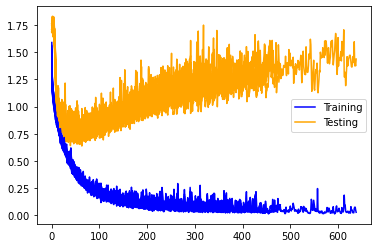

In [20]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

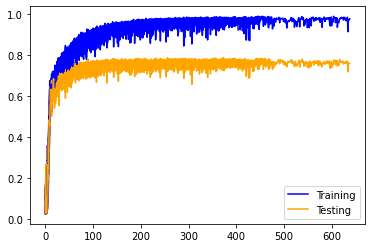

In [21]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

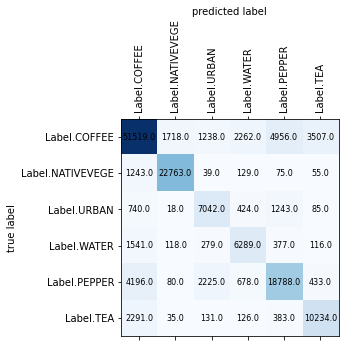

In [22]:
plot_confusion_matrix(conf_matrix, labels)

In [23]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.83729888 0.92038654 0.64287018 0.6347396  0.72759662 0.70921691]
Mean precision:  0.745351457227327

Recalls:  [0.79016871 0.9365948  0.73722781 0.7212156  0.71166667 0.77530303]
Mean recall:  0.7786961016435939

F-Score:  [0.81305137 0.92841994 0.68682337 0.6752201  0.71954349 0.740789  ]
Mean f-score:  0.7606412096428937


# COASTAL_AEROSOL, BLUE, GREEN, RED, NIR, SWIR1, SWIR2, PANCHROMATIC

In [24]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
]

model_name = "coastal_aerosol_blue_green_red_nir_swir1_swir2_panchromatic"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 9, 9, 8)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 8)           32        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 32)          2336      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 64)         

57/57 [==============================] - 0s 8ms/step - loss: 0.1552 - accuracy: 0.8908 - val_loss: 0.8424 - val_accuracy: 0.7636
Epoch 101/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1715 - accuracy: 0.8971 - val_loss: 0.7875 - val_accuracy: 0.7864
Epoch 102/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1874 - accuracy: 0.8793 - val_loss: 0.7637 - val_accuracy: 0.7899
Epoch 103/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1645 - accuracy: 0.8950 - val_loss: 0.7608 - val_accuracy: 0.7906
Epoch 104/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1639 - accuracy: 0.9072 - val_loss: 0.8069 - val_accuracy: 0.7881
Epoch 105/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1509 - accuracy: 0.8908 - val_loss: 0.8931 - val_accuracy: 0.7668
Epoch 106/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2671 - accuracy: 0.8610 - val_loss: 0.8934 - val_accuracy: 0.7414
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1203 - accuracy: 0.9190 - val_loss: 1.0391 - val_accuracy: 0.7657
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1077 - accuracy: 0.9262 - val_loss: 0.9799 - val_accuracy: 0.7875
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1021 - accuracy: 0.9249 - val_loss: 1.0007 - val_accuracy: 0.7967
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0771 - accuracy: 0.9467 - val_loss: 1.0193 - val_accuracy: 0.8014
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1154 - accuracy: 0.9345 - val_loss: 0.9791 - val_accuracy: 0.8075
Epoch 162/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0865 - accuracy: 0.9392 - val_loss: 1.0850 - val_accuracy: 0.7824
Epoch 163/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2432 - accuracy: 0.8894 - val_loss: 0.8658 - val_accuracy

Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1036 - accuracy: 0.9433 - val_loss: 1.0421 - val_accuracy: 0.7974
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9530 - val_loss: 1.0412 - val_accuracy: 0.7919
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1289 - accuracy: 0.9265 - val_loss: 1.0429 - val_accuracy: 0.8001
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0633 - accuracy: 0.9498 - val_loss: 1.1159 - val_accuracy: 0.7828
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0697 - accuracy: 0.9542 - val_loss: 1.0680 - val_accuracy: 0.8094
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0559 - accuracy: 0.9716 - val_loss: 1.0747 - val_accuracy: 0.8029
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1109 - accuracy: 0.9453 - val_loss: 1.1180 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0620 - accuracy: 0.9659 - val_loss: 1.1718 - val_accuracy: 0.7997
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.9592 - val_loss: 1.2507 - val_accuracy: 0.8006
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0424 - accuracy: 0.9748 - val_loss: 1.1391 - val_accuracy: 0.8061
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0298 - accuracy: 0.9790 - val_loss: 1.2051 - val_accuracy: 0.8086
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0782 - accuracy: 0.9562 - val_loss: 1.3231 - val_accuracy: 0.7613
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1152 - accuracy: 0.9308 - val_loss: 1.1325 - val_accuracy: 0.7907
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0622 - accuracy: 0.9557 - val_loss: 1.1502 - val_accuracy:

Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9772 - val_loss: 1.2485 - val_accuracy: 0.8111
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9874 - val_loss: 1.2497 - val_accuracy: 0.8062
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1197 - accuracy: 0.9543 - val_loss: 1.3213 - val_accuracy: 0.7986
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0861 - accuracy: 0.9552 - val_loss: 1.1541 - val_accuracy: 0.8047
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.9746 - val_loss: 1.2082 - val_accuracy: 0.8031
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0344 - accuracy: 0.9750 - val_loss: 1.2058 - val_accuracy: 0.8071
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0473 - accuracy: 0.9695 - val_loss: 1.2918 - val_accuracy:

Epoch 32/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5629 - accuracy: 0.7453 - val_loss: 0.8404 - val_accuracy: 0.7029
Epoch 33/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5384 - accuracy: 0.7363 - val_loss: 0.7773 - val_accuracy: 0.7089
Epoch 34/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5450 - accuracy: 0.7396 - val_loss: 0.7765 - val_accuracy: 0.7323
Epoch 35/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.4506 - accuracy: 0.7749 - val_loss: 0.6734 - val_accuracy: 0.7613
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4710 - accuracy: 0.7756 - val_loss: 0.7216 - val_accuracy: 0.7464
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5113 - accuracy: 0.7796 - val_loss: 0.7492 - val_accuracy: 0.7428
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4877 - accuracy: 0.7670 - val_loss: 0.6884 - val_accuracy: 0.756

57/57 [==============================] - 0s 8ms/step - loss: 0.1353 - accuracy: 0.9428 - val_loss: 0.9270 - val_accuracy: 0.7910
Epoch 147/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1352 - accuracy: 0.9206 - val_loss: 0.9143 - val_accuracy: 0.7874
Epoch 148/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1143 - accuracy: 0.9230 - val_loss: 0.9258 - val_accuracy: 0.7967
Epoch 149/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1236 - accuracy: 0.9204 - val_loss: 0.9103 - val_accuracy: 0.7964
Epoch 150/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1025 - accuracy: 0.9428 - val_loss: 0.9224 - val_accuracy: 0.8024
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1191 - accuracy: 0.9253 - val_loss: 0.9307 - val_accuracy: 0.7944
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1429 - accuracy: 0.9197 - val_loss: 0.8304 - val_accuracy: 0.7971
Epoch 1

Epoch 203/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0742 - accuracy: 0.9562 - val_loss: 0.9665 - val_accuracy: 0.7978
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0556 - accuracy: 0.9594 - val_loss: 1.0047 - val_accuracy: 0.8039
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0616 - accuracy: 0.9665 - val_loss: 1.0386 - val_accuracy: 0.8016
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9658 - val_loss: 1.1308 - val_accuracy: 0.7874
Epoch 207/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0738 - accuracy: 0.9585 - val_loss: 1.0005 - val_accuracy: 0.8103
Epoch 208/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0704 - accuracy: 0.9594 - val_loss: 1.1067 - val_accuracy: 0.7795
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0954 - accuracy: 0.9479 - val_loss: 0.9952 - val_accuracy:

Epoch 260/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0748 - accuracy: 0.9636 - val_loss: 1.0816 - val_accuracy: 0.8042
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0360 - accuracy: 0.9799 - val_loss: 1.2098 - val_accuracy: 0.7814
Epoch 262/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9642 - val_loss: 1.0802 - val_accuracy: 0.7971
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1211 - accuracy: 0.9475 - val_loss: 1.0281 - val_accuracy: 0.7929
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1160 - accuracy: 0.9525 - val_loss: 0.9670 - val_accuracy: 0.7998
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9562 - val_loss: 1.0138 - val_accuracy: 0.8088
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0502 - accuracy: 0.9780 - val_loss: 1.0747 - val_accuracy:


Validation  1 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6672 - accuracy: 0.2226 - val_loss: 1.7166 - val_accuracy: 0.4442
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.1612 - accuracy: 0.4129 - val_loss: 1.7402 - val_accuracy: 0.1974
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.0945 - accuracy: 0.4074 - val_loss: 1.6880 - val_accuracy: 0.4151
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0554 - accuracy: 0.4067 - val_loss: 1.7390 - val_accuracy: 0.0942
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0486 - accuracy: 0.4024 - val_loss: 1.7407 - val_accuracy: 0.2611
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9834 - accuracy: 0.4412 - val_loss: 1.7015 - val_accuracy: 0.1607
Epoch 7/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.9746 - accuracy

Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2887 - accuracy: 0.8373 - val_loss: 0.7446 - val_accuracy: 0.7374
Epoch 59/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.3862 - accuracy: 0.7829 - val_loss: 0.6790 - val_accuracy: 0.7617
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3194 - accuracy: 0.8196 - val_loss: 0.6737 - val_accuracy: 0.7694
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3248 - accuracy: 0.8276 - val_loss: 0.7235 - val_accuracy: 0.7473
Epoch 62/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2566 - accuracy: 0.8495 - val_loss: 0.7239 - val_accuracy: 0.7533
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2596 - accuracy: 0.8398 - val_loss: 0.6996 - val_accuracy: 0.7494
Epoch 64/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3099 - accuracy: 0.8255 - val_loss: 0.7028 - val_accuracy: 0.755

Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0683 - accuracy: 0.9507 - val_loss: 0.9440 - val_accuracy: 0.8046
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0848 - accuracy: 0.9551 - val_loss: 0.9847 - val_accuracy: 0.7909
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1756 - accuracy: 0.9184 - val_loss: 0.9045 - val_accuracy: 0.8035
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.9212 - val_loss: 0.9165 - val_accuracy: 0.7944
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1128 - accuracy: 0.9289 - val_loss: 0.9442 - val_accuracy: 0.7986
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1027 - accuracy: 0.9414 - val_loss: 0.9083 - val_accuracy: 0.8156
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1217 - accuracy: 0.9485 - val_loss: 0.9082 - val_accuracy:

Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9644 - val_loss: 0.9848 - val_accuracy: 0.8038
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0866 - accuracy: 0.9620 - val_loss: 1.0108 - val_accuracy: 0.8059
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0724 - accuracy: 0.9665 - val_loss: 1.0325 - val_accuracy: 0.7967
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0470 - accuracy: 0.9694 - val_loss: 1.0488 - val_accuracy: 0.8127
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0504 - accuracy: 0.9678 - val_loss: 1.0827 - val_accuracy: 0.8087
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9734 - val_loss: 1.1100 - val_accuracy: 0.8078
Epoch 235/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0452 - accuracy: 0.9733 - val_loss: 1.1877 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0721 - accuracy: 0.9664 - val_loss: 1.1840 - val_accuracy: 0.7990
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0712 - accuracy: 0.9695 - val_loss: 1.1129 - val_accuracy: 0.8027
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0446 - accuracy: 0.9640 - val_loss: 1.1192 - val_accuracy: 0.8107
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0663 - accuracy: 0.9791 - val_loss: 1.1899 - val_accuracy: 0.8066
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9728 - val_loss: 1.1245 - val_accuracy: 0.8133
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.9669 - val_loss: 1.1105 - val_accuracy: 0.7963
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0459 - accuracy: 0.9755 - val_loss: 1.0659 - val_accuracy:

Epoch 343/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0461 - accuracy: 0.9763 - val_loss: 1.2350 - val_accuracy: 0.8035
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0807 - accuracy: 0.9633 - val_loss: 1.1528 - val_accuracy: 0.7838
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0534 - accuracy: 0.9693 - val_loss: 1.1433 - val_accuracy: 0.8031
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 0.9786 - val_loss: 1.2400 - val_accuracy: 0.8046
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0349 - accuracy: 0.9826 - val_loss: 1.2418 - val_accuracy: 0.8055
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0259 - accuracy: 0.9850 - val_loss: 1.2361 - val_accuracy: 0.8087
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0297 - accuracy: 0.9803 - val_loss: 1.2608 - val_accuracy:

Epoch 17/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.7721 - accuracy: 0.6398 - val_loss: 0.8682 - val_accuracy: 0.6611
Epoch 18/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6833 - accuracy: 0.6871 - val_loss: 0.9823 - val_accuracy: 0.6172
Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6668 - accuracy: 0.6645 - val_loss: 0.9971 - val_accuracy: 0.6107
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7096 - accuracy: 0.6483 - val_loss: 0.8485 - val_accuracy: 0.6697
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6147 - accuracy: 0.6944 - val_loss: 0.8168 - val_accuracy: 0.6872
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6670 - accuracy: 0.6777 - val_loss: 0.7830 - val_accuracy: 0.6816
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6081 - accuracy: 0.6924 - val_loss: 0.8178 - val_accuracy: 0.6755

57/57 [==============================] - 0s 8ms/step - loss: 0.1671 - accuracy: 0.8913 - val_loss: 0.7287 - val_accuracy: 0.8054
Epoch 132/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.9310 - val_loss: 0.7904 - val_accuracy: 0.8084
Epoch 133/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1251 - accuracy: 0.9130 - val_loss: 0.9488 - val_accuracy: 0.7802
Epoch 134/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1857 - accuracy: 0.8924 - val_loss: 0.7757 - val_accuracy: 0.7937
Epoch 135/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1644 - accuracy: 0.9097 - val_loss: 0.7555 - val_accuracy: 0.8148
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1120 - accuracy: 0.9316 - val_loss: 0.7789 - val_accuracy: 0.8038
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1349 - accuracy: 0.9185 - val_loss: 0.7569 - val_accuracy: 0.8165
Epoch 1

Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0952 - accuracy: 0.9350 - val_loss: 0.9296 - val_accuracy: 0.8078
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9529 - val_loss: 0.9922 - val_accuracy: 0.7742
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0727 - accuracy: 0.9437 - val_loss: 0.8925 - val_accuracy: 0.8092
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0999 - accuracy: 0.9583 - val_loss: 0.9611 - val_accuracy: 0.7709
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0977 - accuracy: 0.9302 - val_loss: 0.8421 - val_accuracy: 0.8161
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0787 - accuracy: 0.9581 - val_loss: 0.9389 - val_accuracy: 0.8047
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9656 - val_loss: 0.9983 - val_accuracy:

Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1520 - accuracy: 0.9212 - val_loss: 0.8582 - val_accuracy: 0.8089
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0997 - accuracy: 0.9430 - val_loss: 0.8839 - val_accuracy: 0.8073
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0605 - accuracy: 0.9587 - val_loss: 0.9816 - val_accuracy: 0.8038
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.9576 - val_loss: 1.0206 - val_accuracy: 0.8121
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0622 - accuracy: 0.9660 - val_loss: 0.9519 - val_accuracy: 0.8004
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0554 - accuracy: 0.9683 - val_loss: 0.9908 - val_accuracy: 0.8146
Epoch 251/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0587 - accuracy: 0.9613 - val_loss: 0.9888 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.2356 - accuracy: 0.8471 - val_loss: 0.6230 - val_accuracy: 0.7983
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2131 - accuracy: 0.8804 - val_loss: 0.7097 - val_accuracy: 0.7780
Epoch 76/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2619 - accuracy: 0.8508 - val_loss: 0.7321 - val_accuracy: 0.7685
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2325 - accuracy: 0.8565 - val_loss: 0.7410 - val_accuracy: 0.7727
Epoch 78/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2361 - accuracy: 0.8630 - val_loss: 0.7049 - val_accuracy: 0.7861
Epoch 79/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2212 - accuracy: 0.8687 - val_loss: 0.6924 - val_accuracy: 0.7861
Epoch 80/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2069 - accuracy: 0.8803 - val_loss: 0.7048 - val_accuracy: 0.7922
Epoch 81/200

Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1492 - accuracy: 0.9297 - val_loss: 1.0077 - val_accuracy: 0.7876
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0903 - accuracy: 0.9407 - val_loss: 0.8926 - val_accuracy: 0.8088
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0608 - accuracy: 0.9569 - val_loss: 0.9195 - val_accuracy: 0.8202
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 0.9649 - val_loss: 0.8885 - val_accuracy: 0.8175
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0608 - accuracy: 0.9610 - val_loss: 0.9924 - val_accuracy: 0.7996
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0885 - accuracy: 0.9469 - val_loss: 0.9690 - val_accuracy: 0.8180
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0559 - accuracy: 0.9683 - val_loss: 1.0137 - val_accuracy:

Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0536 - accuracy: 0.9725 - val_loss: 1.0766 - val_accuracy: 0.8088
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9623 - val_loss: 1.0505 - val_accuracy: 0.8142
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9671 - val_loss: 1.1207 - val_accuracy: 0.8058
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1015 - accuracy: 0.9406 - val_loss: 1.0762 - val_accuracy: 0.7935
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0855 - accuracy: 0.9481 - val_loss: 0.9877 - val_accuracy: 0.7882
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0858 - accuracy: 0.9562 - val_loss: 1.0019 - val_accuracy: 0.7982
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0924 - accuracy: 0.9521 - val_loss: 0.9388 - val_accuracy:

Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0441 - accuracy: 0.9768 - val_loss: 1.0881 - val_accuracy: 0.7985
Epoch 303/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0438 - accuracy: 0.9738 - val_loss: 0.9962 - val_accuracy: 0.8253
Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.9785 - val_loss: 1.2240 - val_accuracy: 0.7823
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0833 - accuracy: 0.9665 - val_loss: 1.0392 - val_accuracy: 0.8030
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.9713 - val_loss: 1.0987 - val_accuracy: 0.8130
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 0.9829 - val_loss: 1.0871 - val_accuracy: 0.8127
Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0850 - accuracy: 0.9602 - val_loss: 1.0238 - val_accuracy:

Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1101 - accuracy: 0.9518 - val_loss: 1.1776 - val_accuracy: 0.7954
Epoch 360/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1195 - accuracy: 0.9328 - val_loss: 1.0513 - val_accuracy: 0.8031
Epoch 361/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0671 - accuracy: 0.9613 - val_loss: 1.0335 - val_accuracy: 0.8175
Epoch 362/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 0.9730 - val_loss: 0.9954 - val_accuracy: 0.8099
Epoch 363/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0532 - accuracy: 0.9749 - val_loss: 1.0200 - val_accuracy: 0.8179
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0570 - accuracy: 0.9743 - val_loss: 1.0850 - val_accuracy: 0.8133
Epoch 365/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0667 - accuracy: 0.9657 - val_loss: 1.1351 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5785 - accuracy: 0.7164 - val_loss: 0.7623 - val_accuracy: 0.7078
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5757 - accuracy: 0.7092 - val_loss: 0.8062 - val_accuracy: 0.6919
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6187 - accuracy: 0.7097 - val_loss: 0.8679 - val_accuracy: 0.6771
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5738 - accuracy: 0.7254 - val_loss: 0.7900 - val_accuracy: 0.6980
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5129 - accuracy: 0.7422 - val_loss: 0.7155 - val_accuracy: 0.7245
Epoch 28/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5296 - accuracy: 0.7474 - val_loss: 0.7780 - val_accuracy: 0.7053
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5224 - accuracy: 0.7278 - val_loss: 0.7215 - val_accuracy: 0.7241

57/57 [==============================] - 1s 9ms/step - loss: 0.1445 - accuracy: 0.9143 - val_loss: 0.9263 - val_accuracy: 0.7795
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1037 - accuracy: 0.9284 - val_loss: 0.8263 - val_accuracy: 0.7900
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1050 - accuracy: 0.9390 - val_loss: 0.9248 - val_accuracy: 0.7919
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0902 - accuracy: 0.9385 - val_loss: 0.9252 - val_accuracy: 0.7932
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0996 - accuracy: 0.9449 - val_loss: 0.9410 - val_accuracy: 0.7877
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1169 - accuracy: 0.9302 - val_loss: 0.8651 - val_accuracy: 0.7872
Epoch 143/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0938 - accuracy: 0.9351 - val_loss: 0.9452 - val_accuracy: 0.7719
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0752 - accuracy: 0.9495 - val_loss: 1.0377 - val_accuracy: 0.7873
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9522 - val_loss: 1.0368 - val_accuracy: 0.7869
Epoch 196/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0597 - accuracy: 0.9610 - val_loss: 0.9896 - val_accuracy: 0.7917
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9714 - val_loss: 1.1577 - val_accuracy: 0.7801
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1074 - accuracy: 0.9338 - val_loss: 0.9960 - val_accuracy: 0.7922
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0926 - accuracy: 0.9503 - val_loss: 1.0659 - val_accuracy: 0.7960
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1049 - accuracy: 0.9553 - val_loss: 1.1103 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0925 - accuracy: 0.9588 - val_loss: 1.2412 - val_accuracy: 0.7938
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0443 - accuracy: 0.9792 - val_loss: 1.2964 - val_accuracy: 0.7887
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0602 - accuracy: 0.9644 - val_loss: 1.3208 - val_accuracy: 0.7784
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.9668 - val_loss: 1.2704 - val_accuracy: 0.7951
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0554 - accuracy: 0.9620 - val_loss: 1.2065 - val_accuracy: 0.8017
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9851 - val_loss: 1.2346 - val_accuracy: 0.8029
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.9791 - val_loss: 1.2276 - val_accuracy:

Epoch 26/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6573 - accuracy: 0.6879 - val_loss: 0.8195 - val_accuracy: 0.6854
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6272 - accuracy: 0.6720 - val_loss: 0.8259 - val_accuracy: 0.6812
Epoch 28/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6319 - accuracy: 0.6958 - val_loss: 0.8573 - val_accuracy: 0.6738
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5779 - accuracy: 0.7081 - val_loss: 0.9272 - val_accuracy: 0.6390
Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5419 - accuracy: 0.6972 - val_loss: 0.8075 - val_accuracy: 0.6913
Epoch 31/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5536 - accuracy: 0.7196 - val_loss: 0.8520 - val_accuracy: 0.6635
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5553 - accuracy: 0.7258 - val_loss: 0.7452 - val_accuracy: 0.7215

57/57 [==============================] - 0s 8ms/step - loss: 0.1631 - accuracy: 0.8973 - val_loss: 0.8240 - val_accuracy: 0.7974
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1781 - accuracy: 0.8989 - val_loss: 0.8769 - val_accuracy: 0.7905
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1342 - accuracy: 0.9257 - val_loss: 0.8288 - val_accuracy: 0.8002
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9325 - val_loss: 0.8986 - val_accuracy: 0.7926
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1007 - accuracy: 0.9381 - val_loss: 0.8944 - val_accuracy: 0.8110
Epoch 145/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0986 - accuracy: 0.9345 - val_loss: 0.9759 - val_accuracy: 0.7944
Epoch 146/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1324 - accuracy: 0.9160 - val_loss: 0.9687 - val_accuracy: 0.7829
Epoch 

Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1020 - accuracy: 0.9324 - val_loss: 1.0350 - val_accuracy: 0.8036
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1317 - accuracy: 0.9403 - val_loss: 1.0205 - val_accuracy: 0.7750
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1465 - accuracy: 0.9056 - val_loss: 0.9267 - val_accuracy: 0.8102
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0985 - accuracy: 0.9482 - val_loss: 0.9419 - val_accuracy: 0.8074
Epoch 201/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1183 - accuracy: 0.9334 - val_loss: 0.9484 - val_accuracy: 0.8119
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0914 - accuracy: 0.9415 - val_loss: 0.8565 - val_accuracy: 0.8187
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0809 - accuracy: 0.9507 - val_loss: 0.9272 - val_accuracy:

Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0633 - accuracy: 0.9554 - val_loss: 1.0297 - val_accuracy: 0.8173
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0330 - accuracy: 0.9805 - val_loss: 1.0623 - val_accuracy: 0.8134
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0709 - accuracy: 0.9708 - val_loss: 1.0251 - val_accuracy: 0.8068
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1000 - accuracy: 0.9503 - val_loss: 1.0488 - val_accuracy: 0.8133
Epoch 258/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1003 - accuracy: 0.9580 - val_loss: 1.0264 - val_accuracy: 0.8019
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0633 - accuracy: 0.9573 - val_loss: 1.0952 - val_accuracy: 0.8154
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9601 - val_loss: 0.9897 - val_accuracy:

Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0756 - accuracy: 0.9559 - val_loss: 0.9957 - val_accuracy: 0.8142
Epoch 312/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9654 - val_loss: 1.1103 - val_accuracy: 0.8126
Epoch 313/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9661 - val_loss: 1.0554 - val_accuracy: 0.8064
Epoch 314/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0665 - accuracy: 0.9740 - val_loss: 1.0719 - val_accuracy: 0.8050
Epoch 315/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0330 - accuracy: 0.9729 - val_loss: 1.0630 - val_accuracy: 0.8180
Epoch 316/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.9754 - val_loss: 1.1528 - val_accuracy: 0.8096
Epoch 317/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0427 - accuracy: 0.9733 - val_loss: 1.1082 - val_accuracy:

Epoch 368/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0674 - accuracy: 0.9660 - val_loss: 1.1160 - val_accuracy: 0.8226
Epoch 369/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0353 - accuracy: 0.9850 - val_loss: 1.1772 - val_accuracy: 0.8089
Epoch 370/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0871 - accuracy: 0.9658 - val_loss: 1.3301 - val_accuracy: 0.7898
Epoch 371/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1761 - accuracy: 0.9314 - val_loss: 1.0701 - val_accuracy: 0.8020
Epoch 372/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0775 - accuracy: 0.9588 - val_loss: 1.0391 - val_accuracy: 0.8072
Epoch 373/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0396 - accuracy: 0.9796 - val_loss: 1.0181 - val_accuracy: 0.8159
Epoch 374/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0525 - accuracy: 0.9732 - val_loss: 1.0745 - val_accuracy

57/57 [==============================] - 0s 8ms/step - loss: 0.3739 - accuracy: 0.8004 - val_loss: 0.7748 - val_accuracy: 0.7342
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3072 - accuracy: 0.8224 - val_loss: 0.7653 - val_accuracy: 0.7460
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2874 - accuracy: 0.8478 - val_loss: 0.7369 - val_accuracy: 0.7377
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3108 - accuracy: 0.8355 - val_loss: 0.7243 - val_accuracy: 0.7589
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2678 - accuracy: 0.8268 - val_loss: 0.8264 - val_accuracy: 0.7092
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3009 - accuracy: 0.8352 - val_loss: 0.8320 - val_accuracy: 0.7352
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2996 - accuracy: 0.8264 - val_loss: 0.7419 - val_accuracy: 0.7458
Epoch 66/2000

Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.9393 - val_loss: 0.9386 - val_accuracy: 0.7947
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0817 - accuracy: 0.9602 - val_loss: 0.9672 - val_accuracy: 0.7982
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1257 - accuracy: 0.9461 - val_loss: 1.1305 - val_accuracy: 0.7553
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1302 - accuracy: 0.9137 - val_loss: 0.9683 - val_accuracy: 0.7903
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0895 - accuracy: 0.9437 - val_loss: 0.9820 - val_accuracy: 0.8065
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9644 - val_loss: 0.9643 - val_accuracy: 0.8009
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9576 - val_loss: 1.0083 - val_accuracy:

Epoch 230/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0398 - accuracy: 0.9783 - val_loss: 1.2388 - val_accuracy: 0.7931
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0694 - accuracy: 0.9596 - val_loss: 1.1445 - val_accuracy: 0.8016
Epoch 232/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0773 - accuracy: 0.9627 - val_loss: 1.4285 - val_accuracy: 0.7347
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1038 - accuracy: 0.9243 - val_loss: 1.1512 - val_accuracy: 0.8055
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0792 - accuracy: 0.9662 - val_loss: 1.1232 - val_accuracy: 0.8019
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0483 - accuracy: 0.9705 - val_loss: 1.1174 - val_accuracy: 0.8026
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0661 - accuracy: 0.9598 - val_loss: 1.0710 - val_accuracy

Epoch 287/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0376 - accuracy: 0.9781 - val_loss: 1.1517 - val_accuracy: 0.7928
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0534 - accuracy: 0.9727 - val_loss: 1.1891 - val_accuracy: 0.7926
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.9690 - val_loss: 1.2824 - val_accuracy: 0.7861
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1150 - accuracy: 0.9427 - val_loss: 1.0529 - val_accuracy: 0.8009
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0520 - accuracy: 0.9692 - val_loss: 1.1007 - val_accuracy: 0.8039
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0735 - accuracy: 0.9667 - val_loss: 1.2831 - val_accuracy: 0.7572
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1802 - accuracy: 0.9173 - val_loss: 1.0578 - val_accuracy:

Epoch 344/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0289 - accuracy: 0.9879 - val_loss: 1.2452 - val_accuracy: 0.7933
Epoch 345/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0936 - accuracy: 0.9669 - val_loss: 1.2003 - val_accuracy: 0.7901
Epoch 346/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0494 - accuracy: 0.9705 - val_loss: 1.1234 - val_accuracy: 0.7874
Epoch 347/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0457 - accuracy: 0.9761 - val_loss: 1.2220 - val_accuracy: 0.8038
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0335 - accuracy: 0.9815 - val_loss: 1.2237 - val_accuracy: 0.7988
Epoch 349/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0392 - accuracy: 0.9774 - val_loss: 1.4236 - val_accuracy: 0.7850
Epoch 350/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0659 - accuracy: 0.9644 - val_loss: 1.2036 - val_accur

57/57 [==============================] - 0s 8ms/step - loss: 0.2380 - accuracy: 0.8389 - val_loss: 0.7169 - val_accuracy: 0.7673
Epoch 81/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2398 - accuracy: 0.8358 - val_loss: 0.6628 - val_accuracy: 0.7869
Epoch 82/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.8624 - val_loss: 0.7723 - val_accuracy: 0.7479
Epoch 83/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2172 - accuracy: 0.8579 - val_loss: 0.7880 - val_accuracy: 0.7548
Epoch 84/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2957 - accuracy: 0.8272 - val_loss: 0.7374 - val_accuracy: 0.7785
Epoch 85/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2957 - accuracy: 0.8267 - val_loss: 0.8008 - val_accuracy: 0.7298
Epoch 86/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2834 - accuracy: 0.8020 - val_loss: 0.6774 - val_accuracy: 0.7799
Epoch 87/2000

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1393 - accuracy: 0.9216 - val_loss: 0.8561 - val_accuracy: 0.8043
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1190 - accuracy: 0.9228 - val_loss: 0.8316 - val_accuracy: 0.8178
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0719 - accuracy: 0.9606 - val_loss: 0.8789 - val_accuracy: 0.8112
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0748 - accuracy: 0.9488 - val_loss: 0.9084 - val_accuracy: 0.8085
Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1884 - accuracy: 0.8912 - val_loss: 0.8453 - val_accuracy: 0.7963
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1024 - accuracy: 0.9398 - val_loss: 0.8251 - val_accuracy: 0.8062
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1045 - accuracy: 0.9448 - val_loss: 0.8554 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9491 - val_loss: 0.9398 - val_accuracy: 0.8146
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0552 - accuracy: 0.9613 - val_loss: 0.9912 - val_accuracy: 0.7937
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1068 - accuracy: 0.9465 - val_loss: 0.8615 - val_accuracy: 0.8119
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0879 - accuracy: 0.9546 - val_loss: 0.8816 - val_accuracy: 0.8144
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.9572 - val_loss: 0.9263 - val_accuracy: 0.8049
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9659 - val_loss: 0.8908 - val_accuracy: 0.8188
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0598 - accuracy: 0.9609 - val_loss: 0.8850 - val_accuracy:

Epoch 308/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1181 - accuracy: 0.9317 - val_loss: 0.9302 - val_accuracy: 0.8058
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9673 - val_loss: 1.0430 - val_accuracy: 0.8156
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.9580 - val_loss: 0.9985 - val_accuracy: 0.8188
Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0337 - accuracy: 0.9747 - val_loss: 1.0427 - val_accuracy: 0.8201
Epoch 312/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0374 - accuracy: 0.9685 - val_loss: 1.0863 - val_accuracy: 0.8243
Epoch 313/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0404 - accuracy: 0.9747 - val_loss: 1.0950 - val_accuracy: 0.8106
Epoch 314/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9693 - val_loss: 1.0459 - val_accuracy:

Epoch 365/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9809 - val_loss: 1.1280 - val_accuracy: 0.8171
Epoch 366/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9815 - val_loss: 1.1991 - val_accuracy: 0.8186
Epoch 367/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.9668 - val_loss: 1.1944 - val_accuracy: 0.8286
Epoch 368/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0396 - accuracy: 0.9820 - val_loss: 1.2898 - val_accuracy: 0.7864
Epoch 369/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1445 - accuracy: 0.9327 - val_loss: 1.1282 - val_accuracy: 0.8016
Epoch 370/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9596 - val_loss: 1.0309 - val_accuracy: 0.8115
Epoch 371/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1495 - accuracy: 0.9480 - val_loss: 0.9719 - val_accuracy

Epoch 422/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0463 - accuracy: 0.9776 - val_loss: 1.1955 - val_accuracy: 0.8104
Epoch 423/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0441 - accuracy: 0.9749 - val_loss: 1.1283 - val_accuracy: 0.7992
Epoch 424/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0601 - accuracy: 0.9693 - val_loss: 1.1490 - val_accuracy: 0.7872
Epoch 425/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.9771 - val_loss: 1.0612 - val_accuracy: 0.8165
Epoch 426/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.9709 - val_loss: 1.2040 - val_accuracy: 0.7986
Epoch 427/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0801 - accuracy: 0.9601 - val_loss: 1.2850 - val_accuracy: 0.7802
Epoch 428/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.9490 - val_loss: 1.1432 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.2978 - accuracy: 0.8372 - val_loss: 0.8248 - val_accuracy: 0.7162
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3313 - accuracy: 0.8131 - val_loss: 0.7802 - val_accuracy: 0.7393
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2916 - accuracy: 0.8350 - val_loss: 0.7075 - val_accuracy: 0.7726
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2309 - accuracy: 0.8580 - val_loss: 0.7723 - val_accuracy: 0.7415
Epoch 72/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2330 - accuracy: 0.8542 - val_loss: 0.6841 - val_accuracy: 0.7821
Epoch 73/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2494 - accuracy: 0.8463 - val_loss: 0.8141 - val_accuracy: 0.7451
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3063 - accuracy: 0.8570 - val_loss: 0.7137 - val_accuracy: 0.7686
Epoch 75/2000

Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0977 - accuracy: 0.9375 - val_loss: 0.9239 - val_accuracy: 0.8051
Epoch 183/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0827 - accuracy: 0.9629 - val_loss: 1.0653 - val_accuracy: 0.7745
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.9264 - val_loss: 1.0388 - val_accuracy: 0.7874
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0755 - accuracy: 0.9458 - val_loss: 0.9856 - val_accuracy: 0.8016
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1147 - accuracy: 0.9454 - val_loss: 1.0165 - val_accuracy: 0.7730
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1043 - accuracy: 0.9333 - val_loss: 1.0355 - val_accuracy: 0.7838
Epoch 188/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0966 - accuracy: 0.9446 - val_loss: 1.0976 - val_accuracy

Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9496 - val_loss: 1.2547 - val_accuracy: 0.7690
Epoch 240/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.9567 - val_loss: 1.1281 - val_accuracy: 0.7863
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0975 - accuracy: 0.9501 - val_loss: 1.0457 - val_accuracy: 0.7902
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1022 - accuracy: 0.9557 - val_loss: 1.0984 - val_accuracy: 0.7931
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0820 - accuracy: 0.9532 - val_loss: 0.9812 - val_accuracy: 0.7937
Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0788 - accuracy: 0.9483 - val_loss: 1.0324 - val_accuracy: 0.8002
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9664 - val_loss: 1.1739 - val_accuracy:

Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9750 - val_loss: 1.1652 - val_accuracy: 0.8051
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.9835 - val_loss: 1.2422 - val_accuracy: 0.7963
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0361 - accuracy: 0.9750 - val_loss: 1.1286 - val_accuracy: 0.8099
Epoch 299/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0406 - accuracy: 0.9766 - val_loss: 1.0961 - val_accuracy: 0.8214
Epoch 300/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0507 - accuracy: 0.9736 - val_loss: 1.0873 - val_accuracy: 0.8159
Epoch 301/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.9780 - val_loss: 1.1421 - val_accuracy: 0.8064
Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.9783 - val_loss: 1.2566 - val_accuracy:

Epoch 353/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0417 - accuracy: 0.9684 - val_loss: 1.1279 - val_accuracy: 0.8008
Epoch 354/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0460 - accuracy: 0.9787 - val_loss: 1.1530 - val_accuracy: 0.8112
Epoch 355/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0490 - accuracy: 0.9809 - val_loss: 1.1320 - val_accuracy: 0.8083
Epoch 356/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0498 - accuracy: 0.9761 - val_loss: 1.4094 - val_accuracy: 0.7829
Epoch 357/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0731 - accuracy: 0.9617 - val_loss: 1.1890 - val_accuracy: 0.7897
Epoch 358/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0507 - accuracy: 0.9783 - val_loss: 1.2652 - val_accuracy: 0.7933
Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0388 - accuracy: 0.9742 - val_loss: 1.1509 - val_accurac

Epoch 410/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0301 - accuracy: 0.9864 - val_loss: 1.2400 - val_accuracy: 0.8116
Epoch 411/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0388 - accuracy: 0.9805 - val_loss: 1.3775 - val_accuracy: 0.7781
Epoch 412/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0555 - accuracy: 0.9712 - val_loss: 1.2447 - val_accuracy: 0.8108
Epoch 413/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0370 - accuracy: 0.9854 - val_loss: 1.1836 - val_accuracy: 0.8134
Epoch 414/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0555 - accuracy: 0.9774 - val_loss: 1.2133 - val_accuracy: 0.8061
Epoch 415/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0409 - accuracy: 0.9793 - val_loss: 1.3551 - val_accuracy: 0.7943
Epoch 416/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0870 - accuracy: 0.9694 - val_loss: 1.3467 - val_accur

57/57 [==============================] - 1s 12ms/step - loss: 0.3818 - accuracy: 0.8043 - val_loss: 0.7987 - val_accuracy: 0.7424
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3421 - accuracy: 0.8201 - val_loss: 0.6716 - val_accuracy: 0.7634
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2936 - accuracy: 0.8388 - val_loss: 0.6597 - val_accuracy: 0.7702
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3102 - accuracy: 0.8341 - val_loss: 0.7710 - val_accuracy: 0.7466
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3182 - accuracy: 0.8105 - val_loss: 0.7834 - val_accuracy: 0.7322
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2731 - accuracy: 0.8560 - val_loss: 0.7006 - val_accuracy: 0.7511
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2719 - accuracy: 0.8346 - val_loss: 0.7122 - val_accuracy: 0.7725
Epoch 70/200

Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1422 - accuracy: 0.9216 - val_loss: 0.9671 - val_accuracy: 0.7847
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9342 - val_loss: 1.0980 - val_accuracy: 0.7733
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0721 - accuracy: 0.9532 - val_loss: 1.0862 - val_accuracy: 0.7979
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1086 - accuracy: 0.9497 - val_loss: 1.0853 - val_accuracy: 0.7841
Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0868 - accuracy: 0.9425 - val_loss: 1.0478 - val_accuracy: 0.8010
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0697 - accuracy: 0.9556 - val_loss: 1.2214 - val_accuracy: 0.7792
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9523 - val_loss: 1.1329 - val_accuracy:

Epoch 234/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0944 - accuracy: 0.9652 - val_loss: 1.1350 - val_accuracy: 0.8010
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0518 - accuracy: 0.9670 - val_loss: 1.3139 - val_accuracy: 0.7804

Validation  3 , fold  2 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.5829 - accuracy: 0.2253 - val_loss: 1.7414 - val_accuracy: 0.0934
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.3253 - accuracy: 0.3070 - val_loss: 1.7049 - val_accuracy: 0.0913
Epoch 3/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1770 - accuracy: 0.3765 - val_loss: 1.7461 - val_accuracy: 0.0915
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1674 - accuracy: 0.3814 - val_loss: 1.6536 - val_accuracy: 0.2958
Epoch 5/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.0752 - accur

Epoch 56/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3631 - accuracy: 0.7993 - val_loss: 0.7079 - val_accuracy: 0.7411
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3380 - accuracy: 0.8090 - val_loss: 0.7754 - val_accuracy: 0.7312
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3824 - accuracy: 0.8161 - val_loss: 0.8541 - val_accuracy: 0.6812
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3638 - accuracy: 0.7909 - val_loss: 0.8625 - val_accuracy: 0.6962
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3712 - accuracy: 0.7752 - val_loss: 0.7234 - val_accuracy: 0.7350
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3273 - accuracy: 0.8124 - val_loss: 0.7260 - val_accuracy: 0.7348
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2988 - accuracy: 0.8191 - val_loss: 0.7120 - val_accuracy: 0.7480

Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1493 - accuracy: 0.9261 - val_loss: 0.9345 - val_accuracy: 0.7952
Epoch 171/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0745 - accuracy: 0.9492 - val_loss: 1.0652 - val_accuracy: 0.7751
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1273 - accuracy: 0.9234 - val_loss: 0.9817 - val_accuracy: 0.7806
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1147 - accuracy: 0.9215 - val_loss: 0.9202 - val_accuracy: 0.7954
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0972 - accuracy: 0.9346 - val_loss: 0.9352 - val_accuracy: 0.7996
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1013 - accuracy: 0.9368 - val_loss: 0.9005 - val_accuracy: 0.7945
Epoch 176/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1354 - accuracy: 0.9108 - val_loss: 0.9232 - val_accuracy:

Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0921 - accuracy: 0.9460 - val_loss: 0.9881 - val_accuracy: 0.7985
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0878 - accuracy: 0.9436 - val_loss: 0.9711 - val_accuracy: 0.7952
Epoch 229/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0995 - accuracy: 0.9463 - val_loss: 0.9856 - val_accuracy: 0.8091
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9516 - val_loss: 1.0485 - val_accuracy: 0.7973
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0758 - accuracy: 0.9486 - val_loss: 1.0013 - val_accuracy: 0.8061
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0680 - accuracy: 0.9643 - val_loss: 0.9978 - val_accuracy: 0.8057
Epoch 233/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0568 - accuracy: 0.9655 - val_loss: 1.0173 - val_accuracy:

Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0885 - accuracy: 0.9570 - val_loss: 1.3152 - val_accuracy: 0.7685
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1219 - accuracy: 0.9385 - val_loss: 1.2730 - val_accuracy: 0.7624
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1956 - accuracy: 0.9431 - val_loss: 1.2621 - val_accuracy: 0.7726
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1694 - accuracy: 0.9112 - val_loss: 1.1400 - val_accuracy: 0.7533
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1255 - accuracy: 0.9121 - val_loss: 1.0271 - val_accuracy: 0.7913
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0647 - accuracy: 0.9583 - val_loss: 0.9610 - val_accuracy: 0.8045
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0405 - accuracy: 0.9751 - val_loss: 1.0235 - val_accuracy:

Epoch 341/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0862 - accuracy: 0.9513 - val_loss: 1.1953 - val_accuracy: 0.7834
Epoch 342/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0923 - accuracy: 0.9691 - val_loss: 1.1800 - val_accuracy: 0.7833
Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9632 - val_loss: 1.1263 - val_accuracy: 0.8015
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0352 - accuracy: 0.9837 - val_loss: 1.1751 - val_accuracy: 0.8051
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0324 - accuracy: 0.9804 - val_loss: 1.2633 - val_accuracy: 0.8026
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0247 - accuracy: 0.9828 - val_loss: 1.2377 - val_accuracy: 0.7969
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0403 - accuracy: 0.9738 - val_loss: 1.3152 - val_accuracy:

Epoch 398/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0745 - accuracy: 0.9694 - val_loss: 1.2466 - val_accuracy: 0.8054
Epoch 399/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0959 - accuracy: 0.9525 - val_loss: 1.2648 - val_accuracy: 0.7880
Epoch 400/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0664 - accuracy: 0.9629 - val_loss: 1.2324 - val_accuracy: 0.7803
Epoch 401/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0491 - accuracy: 0.9738 - val_loss: 1.1643 - val_accuracy: 0.8076
Epoch 402/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0265 - accuracy: 0.9798 - val_loss: 1.2890 - val_accuracy: 0.7937
Epoch 403/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0375 - accuracy: 0.9782 - val_loss: 1.3277 - val_accuracy: 0.7916
Epoch 404/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0573 - accuracy: 0.9707 - val_loss: 1.2466 - val_accurac

Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3737 - accuracy: 0.7971 - val_loss: 0.8193 - val_accuracy: 0.7074
Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3627 - accuracy: 0.7987 - val_loss: 0.7200 - val_accuracy: 0.7412
Epoch 50/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3669 - accuracy: 0.8110 - val_loss: 0.6363 - val_accuracy: 0.7745
Epoch 51/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3223 - accuracy: 0.8494 - val_loss: 0.7163 - val_accuracy: 0.7358
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3193 - accuracy: 0.8446 - val_loss: 0.7090 - val_accuracy: 0.7491
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3262 - accuracy: 0.8343 - val_loss: 0.7321 - val_accuracy: 0.7479
Epoch 54/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3643 - accuracy: 0.8156 - val_loss: 0.6386 - val_accuracy: 0.782

Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0783 - accuracy: 0.9550 - val_loss: 0.9263 - val_accuracy: 0.8057
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0797 - accuracy: 0.9518 - val_loss: 0.9726 - val_accuracy: 0.7975
Epoch 164/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0850 - accuracy: 0.9509 - val_loss: 0.9062 - val_accuracy: 0.8169
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1340 - accuracy: 0.9343 - val_loss: 1.0761 - val_accuracy: 0.7709
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9168 - val_loss: 0.8879 - val_accuracy: 0.8134
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0718 - accuracy: 0.9611 - val_loss: 0.9068 - val_accuracy: 0.8019
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0694 - accuracy: 0.9602 - val_loss: 0.9376 - val_accuracy:

Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0825 - accuracy: 0.9576 - val_loss: 1.0565 - val_accuracy: 0.7989
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0522 - accuracy: 0.9693 - val_loss: 1.0770 - val_accuracy: 0.8239
Epoch 221/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.9672 - val_loss: 1.1589 - val_accuracy: 0.7993
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0575 - accuracy: 0.9681 - val_loss: 1.0856 - val_accuracy: 0.8221
Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0646 - accuracy: 0.9592 - val_loss: 1.1592 - val_accuracy: 0.8121
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0852 - accuracy: 0.9558 - val_loss: 1.0240 - val_accuracy: 0.8133
Epoch 225/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0601 - accuracy: 0.9726 - val_loss: 1.0508 - val_accuracy:

Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0405 - accuracy: 0.9751 - val_loss: 1.0463 - val_accuracy: 0.8100
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9700 - val_loss: 1.1891 - val_accuracy: 0.8069
Epoch 278/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0525 - accuracy: 0.9714 - val_loss: 1.1492 - val_accuracy: 0.8102
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0755 - accuracy: 0.9712 - val_loss: 1.1743 - val_accuracy: 0.7855
Epoch 280/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1665 - accuracy: 0.9447 - val_loss: 0.9901 - val_accuracy: 0.8100
Epoch 281/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0673 - accuracy: 0.9592 - val_loss: 1.0321 - val_accuracy: 0.8069
Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0707 - accuracy: 0.9675 - val_loss: 1.0604 - val_accuracy:

Epoch 333/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.9681 - val_loss: 1.0380 - val_accuracy: 0.8032
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0332 - accuracy: 0.9806 - val_loss: 1.1004 - val_accuracy: 0.8081
Epoch 335/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0387 - accuracy: 0.9806 - val_loss: 1.0830 - val_accuracy: 0.8213
Epoch 336/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0319 - accuracy: 0.9814 - val_loss: 1.0749 - val_accuracy: 0.8183
Epoch 337/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9903 - val_loss: 1.2181 - val_accuracy: 0.8042
Epoch 338/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1682 - accuracy: 0.9474 - val_loss: 0.9935 - val_accuracy: 0.8140
Epoch 339/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 1.0516 - val_accuracy

Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0834 - accuracy: 0.9548 - val_loss: 1.2349 - val_accuracy: 0.8209
Epoch 391/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0291 - accuracy: 0.9857 - val_loss: 1.3033 - val_accuracy: 0.8020
Epoch 392/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0202 - accuracy: 0.9872 - val_loss: 1.2646 - val_accuracy: 0.8092
Epoch 393/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0349 - accuracy: 0.9829 - val_loss: 1.2919 - val_accuracy: 0.8302
Epoch 394/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0201 - accuracy: 0.9915 - val_loss: 1.3457 - val_accuracy: 0.8251
Epoch 395/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0263 - accuracy: 0.9838 - val_loss: 1.3316 - val_accuracy: 0.8253
Epoch 396/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9873 - val_loss: 1.4039 - val_accuracy:

Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5148 - accuracy: 0.7361 - val_loss: 0.8280 - val_accuracy: 0.7126
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4910 - accuracy: 0.7612 - val_loss: 0.9562 - val_accuracy: 0.6291
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4815 - accuracy: 0.7329 - val_loss: 0.7674 - val_accuracy: 0.7318
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3901 - accuracy: 0.7949 - val_loss: 0.8240 - val_accuracy: 0.7084
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4383 - accuracy: 0.7607 - val_loss: 0.7460 - val_accuracy: 0.7320
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4276 - accuracy: 0.7796 - val_loss: 0.7701 - val_accuracy: 0.7302
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4139 - accuracy: 0.8013 - val_loss: 0.6595 - val_accuracy: 0.7575

Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0933 - accuracy: 0.9425 - val_loss: 1.0483 - val_accuracy: 0.7804
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1290 - accuracy: 0.9231 - val_loss: 0.8584 - val_accuracy: 0.8036
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1006 - accuracy: 0.9359 - val_loss: 0.8805 - val_accuracy: 0.7998
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9326 - val_loss: 0.8763 - val_accuracy: 0.8039
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9433 - val_loss: 0.9363 - val_accuracy: 0.7988
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0807 - accuracy: 0.9456 - val_loss: 1.0599 - val_accuracy: 0.7878
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9031 - val_loss: 0.8802 - val_accuracy:

Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0769 - accuracy: 0.9544 - val_loss: 1.0791 - val_accuracy: 0.8040
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2247 - accuracy: 0.9388 - val_loss: 0.9859 - val_accuracy: 0.7928
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1074 - accuracy: 0.9398 - val_loss: 0.9429 - val_accuracy: 0.7977
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0744 - accuracy: 0.9529 - val_loss: 1.0189 - val_accuracy: 0.8040
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9676 - val_loss: 0.9856 - val_accuracy: 0.8107
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0644 - accuracy: 0.9517 - val_loss: 1.0647 - val_accuracy: 0.7945
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0476 - accuracy: 0.9705 - val_loss: 1.1585 - val_accuracy:

Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1115 - accuracy: 0.9440 - val_loss: 0.9635 - val_accuracy: 0.7931
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0985 - accuracy: 0.9453 - val_loss: 1.0302 - val_accuracy: 0.7769
Epoch 271/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1224 - accuracy: 0.9282 - val_loss: 0.9705 - val_accuracy: 0.7913
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9580 - val_loss: 0.9557 - val_accuracy: 0.7954
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0753 - accuracy: 0.9548 - val_loss: 0.9870 - val_accuracy: 0.7956
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0666 - accuracy: 0.9597 - val_loss: 0.9528 - val_accuracy: 0.8055
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0573 - accuracy: 0.9676 - val_loss: 1.0510 - val_accuracy:

Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5250 - accuracy: 0.7387 - val_loss: 0.6805 - val_accuracy: 0.7496
Epoch 31/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4684 - accuracy: 0.7604 - val_loss: 0.7564 - val_accuracy: 0.7017
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5133 - accuracy: 0.7443 - val_loss: 0.6986 - val_accuracy: 0.7260
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4475 - accuracy: 0.7731 - val_loss: 0.7402 - val_accuracy: 0.7138
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5479 - accuracy: 0.7719 - val_loss: 0.8565 - val_accuracy: 0.6982
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4932 - accuracy: 0.7545 - val_loss: 0.8121 - val_accuracy: 0.6955
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4856 - accuracy: 0.7596 - val_loss: 0.7191 - val_accuracy: 0.7293

57/57 [==============================] - 0s 7ms/step - loss: 0.1801 - accuracy: 0.9102 - val_loss: 0.8429 - val_accuracy: 0.7842
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1448 - accuracy: 0.9101 - val_loss: 0.8572 - val_accuracy: 0.7826
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9217 - val_loss: 0.8360 - val_accuracy: 0.7936
Epoch 147/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1388 - accuracy: 0.9214 - val_loss: 0.8322 - val_accuracy: 0.7791
Epoch 148/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1001 - accuracy: 0.9331 - val_loss: 0.8424 - val_accuracy: 0.8043
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1079 - accuracy: 0.9328 - val_loss: 0.8931 - val_accuracy: 0.8034
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0725 - accuracy: 0.9465 - val_loss: 0.8826 - val_accuracy: 0.8057
Epoch 1

Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0773 - accuracy: 0.9558 - val_loss: 0.9973 - val_accuracy: 0.8050
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1603 - accuracy: 0.9281 - val_loss: 0.9257 - val_accuracy: 0.7962
Epoch 203/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0646 - accuracy: 0.9666 - val_loss: 0.9989 - val_accuracy: 0.8054
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0681 - accuracy: 0.9619 - val_loss: 1.0414 - val_accuracy: 0.7960
Epoch 205/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0866 - accuracy: 0.9470 - val_loss: 0.9311 - val_accuracy: 0.8115
Epoch 206/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0632 - accuracy: 0.9634 - val_loss: 0.9156 - val_accuracy: 0.8108
Epoch 207/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0612 - accuracy: 0.9566 - val_loss: 0.9034 - val_accuracy:

Epoch 258/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0401 - accuracy: 0.9836 - val_loss: 1.1453 - val_accuracy: 0.8038
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0455 - accuracy: 0.9741 - val_loss: 1.1634 - val_accuracy: 0.7954
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0617 - accuracy: 0.9671 - val_loss: 1.2019 - val_accuracy: 0.8021
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.9513 - val_loss: 1.0522 - val_accuracy: 0.8111
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0521 - accuracy: 0.9725 - val_loss: 1.0916 - val_accuracy: 0.7916
Epoch 263/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0594 - accuracy: 0.9636 - val_loss: 1.0822 - val_accuracy: 0.7883
Epoch 264/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0601 - accuracy: 0.9623 - val_loss: 1.0446 - val_accuracy:

Epoch 315/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1046 - accuracy: 0.9514 - val_loss: 1.1395 - val_accuracy: 0.7970
Epoch 316/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9645 - val_loss: 1.1109 - val_accuracy: 0.8182
Epoch 317/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0373 - accuracy: 0.9745 - val_loss: 1.2087 - val_accuracy: 0.8134
Epoch 318/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0224 - accuracy: 0.9871 - val_loss: 1.1686 - val_accuracy: 0.8213
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0328 - accuracy: 0.9790 - val_loss: 1.3665 - val_accuracy: 0.7708
Epoch 320/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0868 - accuracy: 0.9452 - val_loss: 1.1858 - val_accuracy: 0.8099
Epoch 321/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0803 - accuracy: 0.9691 - val_loss: 1.3129 - val_accuracy

Epoch 372/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0414 - accuracy: 0.9781 - val_loss: 1.2787 - val_accuracy: 0.7962
Epoch 373/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9717 - val_loss: 1.2974 - val_accuracy: 0.8163
Epoch 374/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0360 - accuracy: 0.9853 - val_loss: 1.2833 - val_accuracy: 0.8087
Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 0.9862 - val_loss: 1.2789 - val_accuracy: 0.8126
Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0321 - accuracy: 0.9816 - val_loss: 1.3487 - val_accuracy: 0.8165
Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 0.9839 - val_loss: 1.3651 - val_accuracy: 0.8074
Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.9775 - val_loss: 1.3670 - val_accuracy:

Epoch 27/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5983 - accuracy: 0.6851 - val_loss: 0.7800 - val_accuracy: 0.6934
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6175 - accuracy: 0.6973 - val_loss: 0.8494 - val_accuracy: 0.6657
Epoch 29/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5976 - accuracy: 0.6902 - val_loss: 0.8327 - val_accuracy: 0.6771
Epoch 30/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5367 - accuracy: 0.7431 - val_loss: 0.7636 - val_accuracy: 0.6967
Epoch 31/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5778 - accuracy: 0.7048 - val_loss: 0.7923 - val_accuracy: 0.6808
Epoch 32/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5396 - accuracy: 0.7152 - val_loss: 0.7182 - val_accuracy: 0.7230
Epoch 33/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.5560 - accuracy: 0.7402 - val_loss: 0.8615 - val_accuracy: 0.6

57/57 [==============================] - 1s 9ms/step - loss: 0.1475 - accuracy: 0.9259 - val_loss: 0.7359 - val_accuracy: 0.7895
Epoch 142/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1449 - accuracy: 0.9089 - val_loss: 0.8435 - val_accuracy: 0.7740
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1600 - accuracy: 0.9131 - val_loss: 0.7139 - val_accuracy: 0.7990
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1993 - accuracy: 0.9073 - val_loss: 0.7662 - val_accuracy: 0.7752
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1026 - accuracy: 0.9376 - val_loss: 0.7684 - val_accuracy: 0.7942
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1343 - accuracy: 0.9244 - val_loss: 0.7862 - val_accuracy: 0.7979
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1141 - accuracy: 0.9359 - val_loss: 0.8231 - val_accuracy: 0.7881
Epoch 

Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0692 - accuracy: 0.9577 - val_loss: 0.9472 - val_accuracy: 0.7938
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0855 - accuracy: 0.9417 - val_loss: 1.0137 - val_accuracy: 0.7892
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0773 - accuracy: 0.9605 - val_loss: 0.9359 - val_accuracy: 0.8027
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0958 - accuracy: 0.9426 - val_loss: 0.9025 - val_accuracy: 0.8025
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0995 - accuracy: 0.9510 - val_loss: 0.9013 - val_accuracy: 0.7949
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9563 - val_loss: 0.9139 - val_accuracy: 0.8063
Epoch 204/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0585 - accuracy: 0.9746 - val_loss: 1.0080 - val_accuracy:

Epoch 255/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.9602 - val_loss: 0.9624 - val_accuracy: 0.7964
Epoch 256/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0663 - accuracy: 0.9588 - val_loss: 0.9566 - val_accuracy: 0.8061
Epoch 257/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0559 - accuracy: 0.9623 - val_loss: 1.0518 - val_accuracy: 0.8010
Epoch 258/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0678 - accuracy: 0.9603 - val_loss: 1.1707 - val_accuracy: 0.7858
Epoch 259/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0843 - accuracy: 0.9594 - val_loss: 0.9795 - val_accuracy: 0.8047
Epoch 260/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0874 - accuracy: 0.9681 - val_loss: 0.9267 - val_accuracy: 0.8040
Epoch 261/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0951 - accuracy: 0.9558 - val_loss: 1.0324 - val_accurac

57/57 [==============================] - 0s 7ms/step - loss: 0.3959 - accuracy: 0.7876 - val_loss: 0.6975 - val_accuracy: 0.7494
Epoch 59/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2932 - accuracy: 0.8066 - val_loss: 0.8386 - val_accuracy: 0.7069
Epoch 60/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.3129 - accuracy: 0.8076 - val_loss: 0.6550 - val_accuracy: 0.7738
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3076 - accuracy: 0.8131 - val_loss: 0.6870 - val_accuracy: 0.7529
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3635 - accuracy: 0.8102 - val_loss: 0.7461 - val_accuracy: 0.7378
Epoch 63/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3328 - accuracy: 0.8137 - val_loss: 0.6456 - val_accuracy: 0.7874
Epoch 64/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2717 - accuracy: 0.8520 - val_loss: 0.6903 - val_accuracy: 0.7658
Epoch 65/200

Epoch 172/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.9329 - val_loss: 0.8885 - val_accuracy: 0.8097
Epoch 173/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0938 - accuracy: 0.9432 - val_loss: 0.9279 - val_accuracy: 0.8089
Epoch 174/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0997 - accuracy: 0.9420 - val_loss: 0.9117 - val_accuracy: 0.8144
Epoch 175/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0745 - accuracy: 0.9527 - val_loss: 0.9496 - val_accuracy: 0.8092
Epoch 176/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0858 - accuracy: 0.9494 - val_loss: 0.8930 - val_accuracy: 0.8138
Epoch 177/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1127 - accuracy: 0.9366 - val_loss: 0.9163 - val_accuracy: 0.8011
Epoch 178/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1044 - accuracy: 0.9325 - val_loss: 0.9286 - val_accurac

Epoch 229/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0566 - accuracy: 0.9640 - val_loss: 1.0511 - val_accuracy: 0.8059
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0655 - accuracy: 0.9578 - val_loss: 1.0504 - val_accuracy: 0.8103
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0581 - accuracy: 0.9695 - val_loss: 1.1818 - val_accuracy: 0.7978
Epoch 232/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1454 - accuracy: 0.9428 - val_loss: 1.0485 - val_accuracy: 0.8125
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9587 - val_loss: 1.0794 - val_accuracy: 0.8043
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9537 - val_loss: 1.1023 - val_accuracy: 0.7838
Epoch 235/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0926 - accuracy: 0.9426 - val_loss: 1.0088 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9796 - val_loss: 1.1708 - val_accuracy: 0.8178
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0550 - accuracy: 0.9715 - val_loss: 1.1920 - val_accuracy: 0.8167
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1135 - accuracy: 0.9495 - val_loss: 1.1301 - val_accuracy: 0.7869
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 0.9465 - val_loss: 1.0549 - val_accuracy: 0.7989
Epoch 290/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 0.9553 - val_loss: 1.1897 - val_accuracy: 0.8091
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0670 - accuracy: 0.9619 - val_loss: 1.1687 - val_accuracy: 0.8000
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0836 - accuracy: 0.9597 - val_loss: 1.1644 - val_accuracy:

57/57 [==============================] - 1s 16ms/step - loss: 0.2984 - accuracy: 0.8301 - val_loss: 0.6976 - val_accuracy: 0.7793
Epoch 74/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.2523 - accuracy: 0.8655 - val_loss: 0.7857 - val_accuracy: 0.7605
Epoch 75/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.2237 - accuracy: 0.8562 - val_loss: 0.7269 - val_accuracy: 0.7715
Epoch 76/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.2481 - accuracy: 0.8569 - val_loss: 0.8258 - val_accuracy: 0.7633
Epoch 77/2000
57/57 [==============================] - 1s 15ms/step - loss: 0.2898 - accuracy: 0.8478 - val_loss: 0.7344 - val_accuracy: 0.7770
Epoch 78/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.2251 - accuracy: 0.8798 - val_loss: 0.7960 - val_accuracy: 0.7548
Epoch 79/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.1985 - accuracy: 0.8810 - val_loss: 0.7888 - val_accuracy: 0.7658
Epoch 

57/57 [==============================] - 1s 9ms/step - loss: 0.1469 - accuracy: 0.9224 - val_loss: 0.8309 - val_accuracy: 0.7903
Epoch 131/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1262 - accuracy: 0.9207 - val_loss: 0.8498 - val_accuracy: 0.7962
Epoch 132/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1051 - accuracy: 0.9311 - val_loss: 0.8960 - val_accuracy: 0.7992
Epoch 133/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1371 - accuracy: 0.9047 - val_loss: 0.8739 - val_accuracy: 0.7988
Epoch 134/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1345 - accuracy: 0.9158 - val_loss: 0.8873 - val_accuracy: 0.7998
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1335 - accuracy: 0.9236 - val_loss: 0.9579 - val_accuracy: 0.7751
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1185 - accuracy: 0.9279 - val_loss: 0.8695 - val_accuracy: 0.7970
Epoc

Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0968 - accuracy: 0.9373 - val_loss: 0.9395 - val_accuracy: 0.7982
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.9377 - val_loss: 0.9716 - val_accuracy: 0.8072
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9420 - val_loss: 1.0030 - val_accuracy: 0.8027
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.9545 - val_loss: 1.0878 - val_accuracy: 0.7860
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0769 - accuracy: 0.9409 - val_loss: 0.9618 - val_accuracy: 0.8061
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0673 - accuracy: 0.9625 - val_loss: 1.0982 - val_accuracy: 0.7975
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.9541 - val_loss: 0.9601 - val_accuracy:

Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0583 - accuracy: 0.9581 - val_loss: 1.0680 - val_accuracy: 0.7954
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.9599 - val_loss: 1.0580 - val_accuracy: 0.8093
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0540 - accuracy: 0.9732 - val_loss: 0.9989 - val_accuracy: 0.8051
Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.9714 - val_loss: 1.1359 - val_accuracy: 0.8008
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0603 - accuracy: 0.9565 - val_loss: 1.0608 - val_accuracy: 0.8131
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0563 - accuracy: 0.9655 - val_loss: 1.1639 - val_accuracy: 0.8078
Epoch 250/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0577 - accuracy: 0.9694 - val_loss: 1.0751 - val_accuracy:

Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0693 - accuracy: 0.9557 - val_loss: 1.0767 - val_accuracy: 0.8135
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0582 - accuracy: 0.9653 - val_loss: 1.1101 - val_accuracy: 0.8125
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0464 - accuracy: 0.9761 - val_loss: 1.1849 - val_accuracy: 0.7925
Epoch 304/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0731 - accuracy: 0.9520 - val_loss: 1.1365 - val_accuracy: 0.8099
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9692 - val_loss: 1.1064 - val_accuracy: 0.7988
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1304 - accuracy: 0.9584 - val_loss: 1.0535 - val_accuracy: 0.8102
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0547 - accuracy: 0.9704 - val_loss: 1.0613 - val_accuracy:

Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0575 - accuracy: 0.9789 - val_loss: 1.1552 - val_accuracy: 0.8138
Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.9762 - val_loss: 1.2838 - val_accuracy: 0.8095
Epoch 360/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9646 - val_loss: 1.1689 - val_accuracy: 0.8024
Epoch 361/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.9655 - val_loss: 1.1031 - val_accuracy: 0.7891
Epoch 362/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0776 - accuracy: 0.9589 - val_loss: 1.0387 - val_accuracy: 0.8019
Epoch 363/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0443 - accuracy: 0.9723 - val_loss: 1.1355 - val_accuracy: 0.8050
Epoch 364/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0218 - accuracy: 0.9874 - val_loss: 1.1379 - val_accuracy

Epoch 415/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.9608 - val_loss: 1.1895 - val_accuracy: 0.8054
Epoch 416/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0481 - accuracy: 0.9745 - val_loss: 1.1839 - val_accuracy: 0.8087
Epoch 417/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0264 - accuracy: 0.9875 - val_loss: 1.2357 - val_accuracy: 0.8083
Epoch 418/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0318 - accuracy: 0.9855 - val_loss: 1.2601 - val_accuracy: 0.8076
Epoch 419/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0379 - accuracy: 0.9771 - val_loss: 1.2147 - val_accuracy: 0.8100
Epoch 420/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0445 - accuracy: 0.9757 - val_loss: 1.1994 - val_accuracy: 0.8163
Epoch 421/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0266 - accuracy: 0.9892 - val_loss: 1.3544 - val_accuracy:

Epoch 472/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0391 - accuracy: 0.9819 - val_loss: 1.4445 - val_accuracy: 0.7937
Epoch 473/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0521 - accuracy: 0.9707 - val_loss: 1.3870 - val_accuracy: 0.8021
Epoch 474/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0571 - accuracy: 0.9660 - val_loss: 1.2601 - val_accuracy: 0.8115
Epoch 475/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0484 - accuracy: 0.9795 - val_loss: 1.2680 - val_accuracy: 0.7977
Epoch 476/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0320 - accuracy: 0.9747 - val_loss: 1.3394 - val_accuracy: 0.8004
Epoch 477/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.9723 - val_loss: 1.2991 - val_accuracy: 0.8049
Epoch 478/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0369 - accuracy: 0.9829 - val_loss: 1.2508 - val_accurac

57/57 [==============================] - 0s 8ms/step - loss: 0.2920 - accuracy: 0.8632 - val_loss: 0.7443 - val_accuracy: 0.7651
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2311 - accuracy: 0.8838 - val_loss: 0.7844 - val_accuracy: 0.7563
Epoch 76/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2271 - accuracy: 0.8692 - val_loss: 0.8222 - val_accuracy: 0.7583
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2384 - accuracy: 0.8694 - val_loss: 0.7408 - val_accuracy: 0.7598
Epoch 78/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2340 - accuracy: 0.8816 - val_loss: 0.7121 - val_accuracy: 0.7768
Epoch 79/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.8776 - val_loss: 0.6999 - val_accuracy: 0.7758
Epoch 80/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2548 - accuracy: 0.8619 - val_loss: 0.7148 - val_accuracy: 0.7732
Epoch 81/2000

Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0592 - accuracy: 0.9687 - val_loss: 0.9202 - val_accuracy: 0.8026
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0661 - accuracy: 0.9573 - val_loss: 0.9424 - val_accuracy: 0.8099
Epoch 190/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0837 - accuracy: 0.9473 - val_loss: 0.9999 - val_accuracy: 0.7929
Epoch 191/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0977 - accuracy: 0.9519 - val_loss: 0.9237 - val_accuracy: 0.7907
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9419 - val_loss: 0.9727 - val_accuracy: 0.7872
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0652 - accuracy: 0.9525 - val_loss: 0.9688 - val_accuracy: 0.7969
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0771 - accuracy: 0.9536 - val_loss: 0.9166 - val_accuracy:

Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.9646 - val_loss: 0.9338 - val_accuracy: 0.8110
Epoch 246/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0408 - accuracy: 0.9782 - val_loss: 1.1481 - val_accuracy: 0.7764
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.9643 - val_loss: 1.0461 - val_accuracy: 0.7914
Epoch 248/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0491 - accuracy: 0.9746 - val_loss: 1.0768 - val_accuracy: 0.8005
Epoch 249/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0385 - accuracy: 0.9830 - val_loss: 1.0387 - val_accuracy: 0.8007
Epoch 250/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0508 - accuracy: 0.9688 - val_loss: 0.9744 - val_accuracy: 0.8042
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9658 - val_loss: 0.9612 - val_accuracy:

Epoch 302/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0817 - accuracy: 0.9742 - val_loss: 1.0899 - val_accuracy: 0.7855
Epoch 303/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0615 - accuracy: 0.9703 - val_loss: 1.0100 - val_accuracy: 0.8040
Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0623 - accuracy: 0.9654 - val_loss: 1.0597 - val_accuracy: 0.8096
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0494 - accuracy: 0.9834 - val_loss: 1.0425 - val_accuracy: 0.8066
Epoch 306/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0268 - accuracy: 0.9844 - val_loss: 1.1223 - val_accuracy: 0.8138
Epoch 307/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0265 - accuracy: 0.9864 - val_loss: 1.1446 - val_accuracy: 0.8001
Epoch 308/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0371 - accuracy: 0.9800 - val_loss: 1.1090 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6773 - accuracy: 0.6851 - val_loss: 0.7268 - val_accuracy: 0.7221
Epoch 24/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6168 - accuracy: 0.6999 - val_loss: 0.7072 - val_accuracy: 0.7316
Epoch 25/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.6226 - accuracy: 0.6777 - val_loss: 0.7388 - val_accuracy: 0.7244
Epoch 26/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6106 - accuracy: 0.7048 - val_loss: 0.7241 - val_accuracy: 0.7355
Epoch 27/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6391 - accuracy: 0.6939 - val_loss: 0.7123 - val_accuracy: 0.7331
Epoch 28/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5578 - accuracy: 0.7176 - val_loss: 0.7506 - val_accuracy: 0.7165
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5675 - accuracy: 0.7162 - val_loss: 0.7354 - val_accuracy: 0.720

57/57 [==============================] - 0s 8ms/step - loss: 0.2224 - accuracy: 0.8935 - val_loss: 0.8861 - val_accuracy: 0.7855
Epoch 138/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1776 - accuracy: 0.9040 - val_loss: 0.7285 - val_accuracy: 0.8054
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1429 - accuracy: 0.9056 - val_loss: 0.7870 - val_accuracy: 0.8115
Epoch 140/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0802 - accuracy: 0.9503 - val_loss: 0.8985 - val_accuracy: 0.7990
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1049 - accuracy: 0.9226 - val_loss: 0.8654 - val_accuracy: 0.8146
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9525 - val_loss: 0.8582 - val_accuracy: 0.8175
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1024 - accuracy: 0.9461 - val_loss: 0.8541 - val_accuracy: 0.8138
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0910 - accuracy: 0.9427 - val_loss: 0.8753 - val_accuracy: 0.8114
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0866 - accuracy: 0.9536 - val_loss: 0.8680 - val_accuracy: 0.8198
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 0.9512 - val_loss: 0.9707 - val_accuracy: 0.8034
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1072 - accuracy: 0.9330 - val_loss: 0.9667 - val_accuracy: 0.8017
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0754 - accuracy: 0.9506 - val_loss: 1.0192 - val_accuracy: 0.7979
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1332 - accuracy: 0.9451 - val_loss: 0.8964 - val_accuracy: 0.8103
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9468 - val_loss: 0.8810 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0494 - accuracy: 0.9654 - val_loss: 1.0467 - val_accuracy: 0.8121
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.9692 - val_loss: 1.0280 - val_accuracy: 0.8263
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0489 - accuracy: 0.9735 - val_loss: 1.0876 - val_accuracy: 0.7913
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1678 - accuracy: 0.9268 - val_loss: 1.1102 - val_accuracy: 0.7874
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2054 - accuracy: 0.9083 - val_loss: 0.9022 - val_accuracy: 0.7964
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1260 - accuracy: 0.9244 - val_loss: 0.9081 - val_accuracy: 0.8156
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.9555 - val_loss: 0.9908 - val_accuracy:

Epoch 308/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0334 - accuracy: 0.9788 - val_loss: 1.1385 - val_accuracy: 0.8016
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0801 - accuracy: 0.9576 - val_loss: 1.0756 - val_accuracy: 0.8215
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.9756 - val_loss: 1.1313 - val_accuracy: 0.8228
Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0455 - accuracy: 0.9794 - val_loss: 1.1127 - val_accuracy: 0.8184
Epoch 312/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0692 - accuracy: 0.9680 - val_loss: 1.1882 - val_accuracy: 0.8008
Epoch 313/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0848 - accuracy: 0.9544 - val_loss: 1.0620 - val_accuracy: 0.8206
Epoch 314/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0644 - accuracy: 0.9658 - val_loss: 1.0458 - val_accuracy

In [25]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.1949847778898925
mean accuracy:  0.8037387388654722


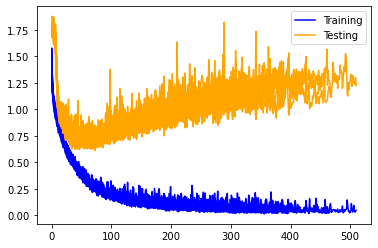

In [26]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

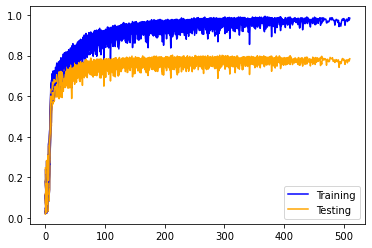

In [27]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

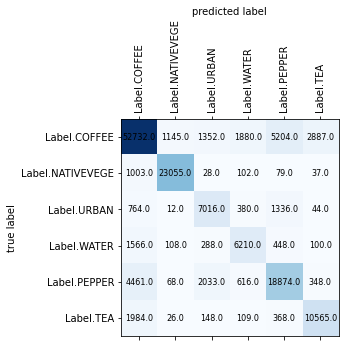

In [28]:
plot_confusion_matrix(conf_matrix, labels)

In [29]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.84357703 0.94433522 0.64574321 0.66795741 0.71739709 0.75566841]
Mean precision:  0.7624463930850532

Recalls:  [0.80877301 0.94860928 0.73450586 0.71215596 0.71492424 0.80037879]
Mean recall:  0.7865578574683275

F-Score:  [0.82580847 0.94646742 0.68727041 0.68934895 0.71615853 0.77738126]
Mean f-score:  0.7737391744978837


# COASTAL_AEROSOL, BLUE, GREEN, RED, NIR, SWIR1, SWIR2, PANCHROMATIC, MNDWI, EVI2, BU

In [9]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
    Band.MNDWI.value,
    Band.EVI2.value,
    Band.BU.value,
]

model_name = "coastal_aerosol_blue_green_red_nir_swir1_swir2_panchromatic_mndwi_evi2, bu"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 11)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 11)          44        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          3200      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 64)         

57/57 [==============================] - 0s 7ms/step - loss: 0.4914 - accuracy: 0.7701 - val_loss: 0.8212 - val_accuracy: 0.7143
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4694 - accuracy: 0.7634 - val_loss: 0.7140 - val_accuracy: 0.7265
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4174 - accuracy: 0.7741 - val_loss: 0.6630 - val_accuracy: 0.7629
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4489 - accuracy: 0.7917 - val_loss: 0.8465 - val_accuracy: 0.6919
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4132 - accuracy: 0.7857 - val_loss: 0.7375 - val_accuracy: 0.7397
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4479 - accuracy: 0.7687 - val_loss: 0.8178 - val_accuracy: 0.7090
Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4394 - accuracy: 0.7643 - val_loss: 0.6470 - val_accuracy: 0.7615
Epoch 50/2000

57/57 [==============================] - 0s 7ms/step - loss: 0.2236 - accuracy: 0.8471 - val_loss: 0.7227 - val_accuracy: 0.7985
Epoch 101/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2490 - accuracy: 0.8642 - val_loss: 0.7545 - val_accuracy: 0.7752
Epoch 102/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2396 - accuracy: 0.8562 - val_loss: 0.6869 - val_accuracy: 0.7885
Epoch 103/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2115 - accuracy: 0.8564 - val_loss: 0.7542 - val_accuracy: 0.7792
Epoch 104/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1983 - accuracy: 0.8801 - val_loss: 0.7901 - val_accuracy: 0.7458
Epoch 105/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2180 - accuracy: 0.8411 - val_loss: 0.8083 - val_accuracy: 0.7545
Epoch 106/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2301 - accuracy: 0.8587 - val_loss: 0.7800 - val_accuracy: 0.7499
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1543 - accuracy: 0.9029 - val_loss: 0.7773 - val_accuracy: 0.7994
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.9225 - val_loss: 0.8405 - val_accuracy: 0.7903
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1379 - accuracy: 0.9046 - val_loss: 0.8103 - val_accuracy: 0.8046
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1355 - accuracy: 0.9170 - val_loss: 0.7851 - val_accuracy: 0.8092
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1493 - accuracy: 0.9098 - val_loss: 0.7549 - val_accuracy: 0.8065
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1851 - accuracy: 0.8924 - val_loss: 0.7519 - val_accuracy: 0.8037
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1356 - accuracy: 0.9124 - val_loss: 0.8162 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1034 - accuracy: 0.9417 - val_loss: 0.8703 - val_accuracy: 0.8084
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.9196 - val_loss: 0.8179 - val_accuracy: 0.8096
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1071 - accuracy: 0.9303 - val_loss: 0.8856 - val_accuracy: 0.8001
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9190 - val_loss: 0.9986 - val_accuracy: 0.7511
Epoch 218/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1637 - accuracy: 0.8950 - val_loss: 0.7922 - val_accuracy: 0.8139
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9371 - val_loss: 0.8191 - val_accuracy: 0.8131
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0934 - accuracy: 0.9488 - val_loss: 0.8334 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1093 - accuracy: 0.9179 - val_loss: 0.8763 - val_accuracy: 0.8282
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1599 - accuracy: 0.9329 - val_loss: 0.9220 - val_accuracy: 0.8071
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0919 - accuracy: 0.9372 - val_loss: 0.9035 - val_accuracy: 0.8132
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1507 - accuracy: 0.9318 - val_loss: 0.9598 - val_accuracy: 0.7978
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0997 - accuracy: 0.9376 - val_loss: 1.0307 - val_accuracy: 0.8059
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9388 - val_loss: 0.9351 - val_accuracy: 0.8031
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9565 - val_loss: 0.9064 - val_accuracy:

Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0482 - accuracy: 0.9696 - val_loss: 1.0660 - val_accuracy: 0.8132
Epoch 329/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0615 - accuracy: 0.9603 - val_loss: 1.0428 - val_accuracy: 0.8108
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9424 - val_loss: 1.0966 - val_accuracy: 0.8023
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1031 - accuracy: 0.9375 - val_loss: 0.9086 - val_accuracy: 0.8164
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0830 - accuracy: 0.9468 - val_loss: 0.9798 - val_accuracy: 0.8100
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0908 - accuracy: 0.9450 - val_loss: 1.0080 - val_accuracy: 0.7997
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1200 - accuracy: 0.9461 - val_loss: 0.9088 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.8578 - accuracy: 0.6003 - val_loss: 0.9282 - val_accuracy: 0.6309
Epoch 14/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8279 - accuracy: 0.6370 - val_loss: 0.9674 - val_accuracy: 0.5914
Epoch 15/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7824 - accuracy: 0.6250 - val_loss: 0.9097 - val_accuracy: 0.6400
Epoch 16/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7455 - accuracy: 0.6650 - val_loss: 0.8503 - val_accuracy: 0.6717
Epoch 17/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7548 - accuracy: 0.6731 - val_loss: 0.9366 - val_accuracy: 0.6322
Epoch 18/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7651 - accuracy: 0.6495 - val_loss: 0.9617 - val_accuracy: 0.6252
Epoch 19/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7070 - accuracy: 0.6634 - val_loss: 0.8831 - val_accuracy: 0.6541
Epoch 20/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.3356 - accuracy: 0.8100 - val_loss: 0.6669 - val_accuracy: 0.7674
Epoch 71/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3386 - accuracy: 0.8156 - val_loss: 0.6170 - val_accuracy: 0.7674
Epoch 72/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3557 - accuracy: 0.7948 - val_loss: 0.7967 - val_accuracy: 0.7205
Epoch 73/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.3468 - accuracy: 0.7891 - val_loss: 0.6713 - val_accuracy: 0.7659
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3477 - accuracy: 0.8018 - val_loss: 0.6728 - val_accuracy: 0.7546
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3561 - accuracy: 0.7933 - val_loss: 0.6880 - val_accuracy: 0.7637
Epoch 76/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3138 - accuracy: 0.8223 - val_loss: 0.6339 - val_accuracy: 0.7631
Epoch 77/200

57/57 [==============================] - 0s 8ms/step - loss: 0.2489 - accuracy: 0.8590 - val_loss: 0.8805 - val_accuracy: 0.7084
Epoch 128/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2761 - accuracy: 0.8430 - val_loss: 0.6785 - val_accuracy: 0.7844
Epoch 129/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2301 - accuracy: 0.8677 - val_loss: 0.8067 - val_accuracy: 0.7628
Epoch 130/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2426 - accuracy: 0.8515 - val_loss: 0.7041 - val_accuracy: 0.7856
Epoch 131/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1762 - accuracy: 0.8923 - val_loss: 0.8205 - val_accuracy: 0.7426
Epoch 132/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2220 - accuracy: 0.8565 - val_loss: 0.7075 - val_accuracy: 0.7791
Epoch 133/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2077 - accuracy: 0.8830 - val_loss: 0.6898 - val_accuracy: 0.7922
Epoch 1

Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.9279 - val_loss: 0.7301 - val_accuracy: 0.8179
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1344 - accuracy: 0.9281 - val_loss: 0.8432 - val_accuracy: 0.7830
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1116 - accuracy: 0.9134 - val_loss: 0.8593 - val_accuracy: 0.7875
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1226 - accuracy: 0.9246 - val_loss: 0.8175 - val_accuracy: 0.7905
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1715 - accuracy: 0.9101 - val_loss: 0.8667 - val_accuracy: 0.7921
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1368 - accuracy: 0.9115 - val_loss: 0.8068 - val_accuracy: 0.7902
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1531 - accuracy: 0.9041 - val_loss: 0.8314 - val_accuracy:

Epoch 241/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1309 - accuracy: 0.9411 - val_loss: 0.8362 - val_accuracy: 0.8046
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0680 - accuracy: 0.9570 - val_loss: 0.9275 - val_accuracy: 0.8026
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9479 - val_loss: 0.8589 - val_accuracy: 0.8100
Epoch 244/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1022 - accuracy: 0.9479 - val_loss: 0.8694 - val_accuracy: 0.8068
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1214 - accuracy: 0.9277 - val_loss: 0.9013 - val_accuracy: 0.7948
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1037 - accuracy: 0.9441 - val_loss: 0.9067 - val_accuracy: 0.8043
Epoch 247/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1004 - accuracy: 0.9432 - val_loss: 0.9382 - val_accuracy

57/57 [==============================] - 0s 8ms/step - loss: 0.8518 - accuracy: 0.6029 - val_loss: 0.9027 - val_accuracy: 0.6696
Epoch 14/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8168 - accuracy: 0.6233 - val_loss: 0.9067 - val_accuracy: 0.6725
Epoch 15/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7905 - accuracy: 0.6309 - val_loss: 0.9177 - val_accuracy: 0.6523
Epoch 16/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8616 - accuracy: 0.5995 - val_loss: 0.9934 - val_accuracy: 0.5872
Epoch 17/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7451 - accuracy: 0.6114 - val_loss: 1.0030 - val_accuracy: 0.5930
Epoch 18/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7426 - accuracy: 0.6059 - val_loss: 0.9260 - val_accuracy: 0.6400
Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7630 - accuracy: 0.6323 - val_loss: 0.7852 - val_accuracy: 0.7184
Epoch 20/2000

57/57 [==============================] - 1s 9ms/step - loss: 0.3529 - accuracy: 0.7879 - val_loss: 0.7695 - val_accuracy: 0.7043
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3541 - accuracy: 0.7859 - val_loss: 0.6921 - val_accuracy: 0.7399
Epoch 72/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3259 - accuracy: 0.8056 - val_loss: 0.7975 - val_accuracy: 0.7172
Epoch 73/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3546 - accuracy: 0.7833 - val_loss: 0.6791 - val_accuracy: 0.7508
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3257 - accuracy: 0.8034 - val_loss: 0.6903 - val_accuracy: 0.7574
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3478 - accuracy: 0.7779 - val_loss: 0.7420 - val_accuracy: 0.7377
Epoch 76/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.3213 - accuracy: 0.8041 - val_loss: 0.6628 - val_accuracy: 0.7605
Epoch 77/200

57/57 [==============================] - 0s 8ms/step - loss: 0.2195 - accuracy: 0.8483 - val_loss: 0.7241 - val_accuracy: 0.7829
Epoch 128/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1864 - accuracy: 0.8882 - val_loss: 0.7102 - val_accuracy: 0.7887
Epoch 129/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1956 - accuracy: 0.8686 - val_loss: 0.7277 - val_accuracy: 0.7846
Epoch 130/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1869 - accuracy: 0.8894 - val_loss: 0.7103 - val_accuracy: 0.7792
Epoch 131/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1947 - accuracy: 0.8625 - val_loss: 0.7340 - val_accuracy: 0.7834
Epoch 132/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.8640 - val_loss: 0.7156 - val_accuracy: 0.7815
Epoch 133/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2215 - accuracy: 0.8498 - val_loss: 0.6865 - val_accuracy: 0.7929
Epoch 

Epoch 184/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1821 - accuracy: 0.9093 - val_loss: 0.9925 - val_accuracy: 0.7711
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2171 - accuracy: 0.8715 - val_loss: 0.8043 - val_accuracy: 0.7800
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1932 - accuracy: 0.8938 - val_loss: 0.7931 - val_accuracy: 0.7926
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1405 - accuracy: 0.9150 - val_loss: 0.7831 - val_accuracy: 0.7945
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2299 - accuracy: 0.9097 - val_loss: 0.7964 - val_accuracy: 0.7899
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1753 - accuracy: 0.9007 - val_loss: 0.8038 - val_accuracy: 0.7834
Epoch 190/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1302 - accuracy: 0.9171 - val_loss: 0.8453 - val_accuracy:

Epoch 241/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1018 - accuracy: 0.9373 - val_loss: 0.8391 - val_accuracy: 0.8083
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0743 - accuracy: 0.9494 - val_loss: 0.9049 - val_accuracy: 0.8024
Epoch 243/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.9366 - val_loss: 0.9033 - val_accuracy: 0.8004
Epoch 244/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1242 - accuracy: 0.9194 - val_loss: 0.8974 - val_accuracy: 0.8028
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1406 - accuracy: 0.9353 - val_loss: 0.9036 - val_accuracy: 0.7910
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1549 - accuracy: 0.9089 - val_loss: 0.7811 - val_accuracy: 0.7912
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1200 - accuracy: 0.9306 - val_loss: 0.9000 - val_accuracy:

Epoch 298/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1189 - accuracy: 0.9388 - val_loss: 0.8082 - val_accuracy: 0.8134
Epoch 299/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0988 - accuracy: 0.9498 - val_loss: 0.8834 - val_accuracy: 0.7971
Epoch 300/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1066 - accuracy: 0.9360 - val_loss: 0.8789 - val_accuracy: 0.7907
Epoch 301/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9299 - val_loss: 0.8288 - val_accuracy: 0.8126
Epoch 302/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0756 - accuracy: 0.9607 - val_loss: 0.8887 - val_accuracy: 0.8161
Epoch 303/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0633 - accuracy: 0.9544 - val_loss: 0.9484 - val_accuracy: 0.7944
Epoch 304/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0860 - accuracy: 0.9475 - val_loss: 0.8945 - val_accuracy

Epoch 355/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0854 - accuracy: 0.9516 - val_loss: 0.9344 - val_accuracy: 0.8026
Epoch 356/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1246 - accuracy: 0.9320 - val_loss: 0.9640 - val_accuracy: 0.7670
Epoch 357/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0926 - accuracy: 0.9393 - val_loss: 0.9711 - val_accuracy: 0.7878
Epoch 358/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0877 - accuracy: 0.9454 - val_loss: 0.8933 - val_accuracy: 0.8116
Epoch 359/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0888 - accuracy: 0.9514 - val_loss: 0.9007 - val_accuracy: 0.8112
Epoch 360/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0776 - accuracy: 0.9356 - val_loss: 0.9524 - val_accuracy: 0.8164
Epoch 361/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0520 - accuracy: 0.9630 - val_loss: 1.0823 - val_accurac

Epoch 412/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0771 - accuracy: 0.9475 - val_loss: 0.9481 - val_accuracy: 0.8161
Epoch 413/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0519 - accuracy: 0.9620 - val_loss: 0.9904 - val_accuracy: 0.8156
Epoch 414/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0525 - accuracy: 0.9654 - val_loss: 1.2068 - val_accuracy: 0.7932
Epoch 415/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1587 - accuracy: 0.9357 - val_loss: 0.9422 - val_accuracy: 0.8053
Epoch 416/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1068 - accuracy: 0.9483 - val_loss: 0.9859 - val_accuracy: 0.8122
Epoch 417/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0954 - accuracy: 0.9569 - val_loss: 1.0573 - val_accuracy: 0.7856
Epoch 418/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1212 - accuracy: 0.9299 - val_loss: 0.9576 - val_acc

Epoch 469/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1278 - accuracy: 0.9261 - val_loss: 0.9093 - val_accuracy: 0.8205
Epoch 470/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0546 - accuracy: 0.9697 - val_loss: 1.0074 - val_accuracy: 0.8068
Epoch 471/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0578 - accuracy: 0.9667 - val_loss: 1.0202 - val_accuracy: 0.8089
Epoch 472/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0697 - accuracy: 0.9528 - val_loss: 0.9885 - val_accuracy: 0.8145
Epoch 473/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0839 - accuracy: 0.9564 - val_loss: 0.9755 - val_accuracy: 0.8157
Epoch 474/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0545 - accuracy: 0.9702 - val_loss: 0.9599 - val_accuracy: 0.8163
Epoch 475/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0566 - accuracy: 0.9618 - val_loss: 0.9734 - val_accuracy

57/57 [==============================] - 0s 8ms/step - loss: 1.1679 - accuracy: 0.4141 - val_loss: 1.7380 - val_accuracy: 0.1548
Epoch 4/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.0737 - accuracy: 0.4036 - val_loss: 1.7084 - val_accuracy: 0.4412
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0516 - accuracy: 0.4442 - val_loss: 1.7206 - val_accuracy: 0.1281
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0501 - accuracy: 0.4414 - val_loss: 1.6706 - val_accuracy: 0.4975
Epoch 7/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9481 - accuracy: 0.4963 - val_loss: 1.6916 - val_accuracy: 0.4486
Epoch 8/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.9605 - accuracy: 0.5145 - val_loss: 1.7204 - val_accuracy: 0.4404
Epoch 9/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.9642 - accuracy: 0.5486 - val_loss: 1.5222 - val_accuracy: 0.5273
Epoch 10/2000
57/57

57/57 [==============================] - 1s 9ms/step - loss: 0.3727 - accuracy: 0.7951 - val_loss: 0.6773 - val_accuracy: 0.7567
Epoch 61/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3617 - accuracy: 0.7997 - val_loss: 0.6631 - val_accuracy: 0.7571
Epoch 62/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4024 - accuracy: 0.7930 - val_loss: 0.7005 - val_accuracy: 0.7480
Epoch 63/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3440 - accuracy: 0.8132 - val_loss: 0.7593 - val_accuracy: 0.7276
Epoch 64/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3302 - accuracy: 0.8404 - val_loss: 0.6711 - val_accuracy: 0.7652
Epoch 65/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.3796 - accuracy: 0.7910 - val_loss: 0.7774 - val_accuracy: 0.7272
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3682 - accuracy: 0.7851 - val_loss: 0.7711 - val_accuracy: 0.7351
Epoch 67/200

57/57 [==============================] - 1s 9ms/step - loss: 0.2303 - accuracy: 0.8655 - val_loss: 0.7040 - val_accuracy: 0.7922
Epoch 118/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2103 - accuracy: 0.8650 - val_loss: 0.7166 - val_accuracy: 0.7701
Epoch 119/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2549 - accuracy: 0.8667 - val_loss: 0.7658 - val_accuracy: 0.7371
Epoch 120/2000
57/57 [==============================] - 1s 16ms/step - loss: 0.3388 - accuracy: 0.8282 - val_loss: 0.6651 - val_accuracy: 0.7941
Epoch 121/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2076 - accuracy: 0.8811 - val_loss: 0.7225 - val_accuracy: 0.7730
Epoch 122/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2297 - accuracy: 0.8685 - val_loss: 0.6662 - val_accuracy: 0.7861
Epoch 123/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.2380 - accuracy: 0.8640 - val_loss: 0.6761 - val_accuracy: 0.7924
Epoch

Epoch 174/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1528 - accuracy: 0.9189 - val_loss: 0.7848 - val_accuracy: 0.7929
Epoch 175/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1359 - accuracy: 0.9203 - val_loss: 0.7246 - val_accuracy: 0.8149
Epoch 176/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1377 - accuracy: 0.9240 - val_loss: 0.8227 - val_accuracy: 0.7924
Epoch 177/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1279 - accuracy: 0.9249 - val_loss: 0.8166 - val_accuracy: 0.8016
Epoch 178/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1369 - accuracy: 0.9397 - val_loss: 0.8104 - val_accuracy: 0.7766
Epoch 179/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2114 - accuracy: 0.8991 - val_loss: 0.7455 - val_accuracy: 0.7935
Epoch 180/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1435 - accuracy: 0.9036 - val_loss: 0.7510 - val_accura

Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1205 - accuracy: 0.9326 - val_loss: 0.8146 - val_accuracy: 0.8213
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.9509 - val_loss: 0.8973 - val_accuracy: 0.8027
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0825 - accuracy: 0.9507 - val_loss: 0.9923 - val_accuracy: 0.7755
Epoch 234/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2649 - accuracy: 0.8856 - val_loss: 0.8495 - val_accuracy: 0.8016
Epoch 235/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1584 - accuracy: 0.9184 - val_loss: 0.8718 - val_accuracy: 0.7762
Epoch 236/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1380 - accuracy: 0.9184 - val_loss: 0.7982 - val_accuracy: 0.8099
Epoch 237/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0819 - accuracy: 0.9483 - val_loss: 0.7981 - val_accurac

Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9505 - val_loss: 0.9120 - val_accuracy: 0.8027
Epoch 289/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0843 - accuracy: 0.9468 - val_loss: 0.9894 - val_accuracy: 0.8085
Epoch 290/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0591 - accuracy: 0.9585 - val_loss: 0.9730 - val_accuracy: 0.8089
Epoch 291/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1543 - accuracy: 0.9290 - val_loss: 0.9436 - val_accuracy: 0.8176
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9452 - val_loss: 0.9177 - val_accuracy: 0.8145
Epoch 293/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2443 - accuracy: 0.9201 - val_loss: 0.8645 - val_accuracy: 0.8108
Epoch 294/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1041 - accuracy: 0.9425 - val_loss: 0.8548 - val_accuracy

Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1157 - accuracy: 0.9382 - val_loss: 0.9308 - val_accuracy: 0.8229
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1175 - accuracy: 0.9513 - val_loss: 0.9733 - val_accuracy: 0.8133
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0759 - accuracy: 0.9576 - val_loss: 0.9744 - val_accuracy: 0.8245
Epoch 348/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0849 - accuracy: 0.9546 - val_loss: 0.9991 - val_accuracy: 0.8248
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9715 - val_loss: 1.0825 - val_accuracy: 0.8180
Epoch 350/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1807 - accuracy: 0.9256 - val_loss: 0.8392 - val_accuracy: 0.8027
Epoch 351/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1092 - accuracy: 0.9352 - val_loss: 0.8708 - val_accuracy:

Epoch 40/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5081 - accuracy: 0.7476 - val_loss: 0.7168 - val_accuracy: 0.7226
Epoch 41/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.4600 - accuracy: 0.7774 - val_loss: 0.7992 - val_accuracy: 0.6849
Epoch 42/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.4667 - accuracy: 0.7840 - val_loss: 0.7324 - val_accuracy: 0.7230
Epoch 43/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.4861 - accuracy: 0.7723 - val_loss: 0.7462 - val_accuracy: 0.7158
Epoch 44/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.4506 - accuracy: 0.7354 - val_loss: 0.6422 - val_accuracy: 0.7537
Epoch 45/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4708 - accuracy: 0.7723 - val_loss: 0.7785 - val_accuracy: 0.7115
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4844 - accuracy: 0.7609 - val_loss: 0.7682 - val_accuracy: 0

57/57 [==============================] - 0s 8ms/step - loss: 0.2082 - accuracy: 0.8691 - val_loss: 0.7745 - val_accuracy: 0.7532
Epoch 98/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2434 - accuracy: 0.8525 - val_loss: 0.6645 - val_accuracy: 0.7808
Epoch 99/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2515 - accuracy: 0.8529 - val_loss: 0.7859 - val_accuracy: 0.7669
Epoch 100/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2544 - accuracy: 0.8488 - val_loss: 0.6993 - val_accuracy: 0.7826
Epoch 101/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1999 - accuracy: 0.8912 - val_loss: 0.7461 - val_accuracy: 0.7796
Epoch 102/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2254 - accuracy: 0.8721 - val_loss: 0.7624 - val_accuracy: 0.7570
Epoch 103/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2677 - accuracy: 0.8433 - val_loss: 0.7304 - val_accuracy: 0.7739
Epoch 104

Epoch 154/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1658 - accuracy: 0.9043 - val_loss: 0.7607 - val_accuracy: 0.8024
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1671 - accuracy: 0.8897 - val_loss: 0.7378 - val_accuracy: 0.7874
Epoch 156/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1686 - accuracy: 0.9022 - val_loss: 0.7043 - val_accuracy: 0.8032
Epoch 157/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1455 - accuracy: 0.9072 - val_loss: 0.7734 - val_accuracy: 0.7943
Epoch 158/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1733 - accuracy: 0.8984 - val_loss: 0.8166 - val_accuracy: 0.7694
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2566 - accuracy: 0.8576 - val_loss: 0.7624 - val_accuracy: 0.8023
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1355 - accuracy: 0.9244 - val_loss: 0.8149 - val_accuracy:

Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9449 - val_loss: 0.9032 - val_accuracy: 0.7966
Epoch 212/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0788 - accuracy: 0.9448 - val_loss: 0.9850 - val_accuracy: 0.7822
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9163 - val_loss: 1.0852 - val_accuracy: 0.7641
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2011 - accuracy: 0.9036 - val_loss: 0.8749 - val_accuracy: 0.7727
Epoch 215/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2037 - accuracy: 0.9017 - val_loss: 0.9881 - val_accuracy: 0.7217
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1983 - accuracy: 0.8898 - val_loss: 0.8076 - val_accuracy: 0.7614
Epoch 217/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.9170 - val_loss: 0.8043 - val_accuracy:

Epoch 268/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0740 - accuracy: 0.9479 - val_loss: 0.9180 - val_accuracy: 0.8187
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0927 - accuracy: 0.9575 - val_loss: 0.9154 - val_accuracy: 0.8218
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0818 - accuracy: 0.9485 - val_loss: 0.9460 - val_accuracy: 0.7975
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1431 - accuracy: 0.9356 - val_loss: 0.8538 - val_accuracy: 0.7800
Epoch 272/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1753 - accuracy: 0.9102 - val_loss: 0.8117 - val_accuracy: 0.7958
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1372 - accuracy: 0.9306 - val_loss: 0.8304 - val_accuracy: 0.7931
Epoch 274/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1681 - accuracy: 0.9170 - val_loss: 0.7774 - val_accuracy:

Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0945 - accuracy: 0.9541 - val_loss: 0.9154 - val_accuracy: 0.8096
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9570 - val_loss: 0.8856 - val_accuracy: 0.8214
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9388 - val_loss: 0.9211 - val_accuracy: 0.8161
Epoch 328/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0797 - accuracy: 0.9608 - val_loss: 0.9109 - val_accuracy: 0.8016
Epoch 329/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0980 - accuracy: 0.9477 - val_loss: 0.9178 - val_accuracy: 0.8116
Epoch 330/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0885 - accuracy: 0.9406 - val_loss: 0.9788 - val_accuracy: 0.7979
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0834 - accuracy: 0.9417 - val_loss: 0.9812 - val_accuracy:

Epoch 382/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0731 - accuracy: 0.9510 - val_loss: 0.9760 - val_accuracy: 0.8148
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0428 - accuracy: 0.9714 - val_loss: 1.1019 - val_accuracy: 0.7950
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1487 - accuracy: 0.9325 - val_loss: 0.9815 - val_accuracy: 0.7764
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.9366 - val_loss: 0.9148 - val_accuracy: 0.8076
Epoch 386/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0601 - accuracy: 0.9580 - val_loss: 0.9918 - val_accuracy: 0.8070
Epoch 387/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0960 - accuracy: 0.9582 - val_loss: 0.8581 - val_accuracy: 0.8005
Epoch 388/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0991 - accuracy: 0.9483 - val_loss: 0.8576 - val_accuracy:

Epoch 439/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1189 - accuracy: 0.9423 - val_loss: 1.0160 - val_accuracy: 0.8241
Epoch 440/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1075 - accuracy: 0.9462 - val_loss: 0.9308 - val_accuracy: 0.8073
Epoch 441/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0650 - accuracy: 0.9565 - val_loss: 0.9603 - val_accuracy: 0.8107
Epoch 442/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0724 - accuracy: 0.9592 - val_loss: 0.9513 - val_accuracy: 0.8020
Epoch 443/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0657 - accuracy: 0.9574 - val_loss: 0.9815 - val_accuracy: 0.7986
Epoch 444/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0552 - accuracy: 0.9632 - val_loss: 1.0226 - val_accuracy: 0.8068
Epoch 445/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9708 - val_loss: 0.9750 - val_accuracy:

Epoch 496/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0473 - accuracy: 0.9629 - val_loss: 1.2434 - val_accuracy: 0.8068
Epoch 497/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1533 - accuracy: 0.9414 - val_loss: 0.9610 - val_accuracy: 0.8111
Epoch 498/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9602 - val_loss: 0.9639 - val_accuracy: 0.8228
Epoch 499/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0540 - accuracy: 0.9665 - val_loss: 1.0116 - val_accuracy: 0.8194
Epoch 500/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0603 - accuracy: 0.9702 - val_loss: 1.0575 - val_accuracy: 0.8115
Epoch 501/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0555 - accuracy: 0.9659 - val_loss: 1.1146 - val_accuracy: 0.8050
Epoch 502/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0995 - accuracy: 0.9547 - val_loss: 1.0894 - val_accuracy:

Epoch 553/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0678 - accuracy: 0.9669 - val_loss: 1.0371 - val_accuracy: 0.7982
Epoch 554/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.9603 - val_loss: 1.0129 - val_accuracy: 0.8157
Epoch 555/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0767 - accuracy: 0.9795 - val_loss: 1.0658 - val_accuracy: 0.7962
Epoch 556/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0670 - accuracy: 0.9674 - val_loss: 1.0907 - val_accuracy: 0.8076
Epoch 557/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9506 - val_loss: 1.1189 - val_accuracy: 0.7910
Epoch 558/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1842 - accuracy: 0.9300 - val_loss: 0.8737 - val_accuracy: 0.8017
Epoch 559/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 0.9619 - val_loss: 0.8555 - val_accuracy

Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5368 - accuracy: 0.7287 - val_loss: 0.8037 - val_accuracy: 0.6834
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4650 - accuracy: 0.7530 - val_loss: 0.7924 - val_accuracy: 0.7020
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5045 - accuracy: 0.7389 - val_loss: 0.7674 - val_accuracy: 0.7157
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4870 - accuracy: 0.7360 - val_loss: 0.7410 - val_accuracy: 0.7233
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4813 - accuracy: 0.7279 - val_loss: 0.8460 - val_accuracy: 0.6684
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5151 - accuracy: 0.7379 - val_loss: 0.7653 - val_accuracy: 0.7083
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5000 - accuracy: 0.7485 - val_loss: 0.7093 - val_accuracy: 0.7313

57/57 [==============================] - 0s 8ms/step - loss: 0.3021 - accuracy: 0.8265 - val_loss: 0.7008 - val_accuracy: 0.7686
Epoch 92/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2278 - accuracy: 0.8505 - val_loss: 0.7202 - val_accuracy: 0.7717
Epoch 93/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2766 - accuracy: 0.8299 - val_loss: 0.6895 - val_accuracy: 0.7838
Epoch 94/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2260 - accuracy: 0.8648 - val_loss: 0.7918 - val_accuracy: 0.7414
Epoch 95/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2407 - accuracy: 0.8550 - val_loss: 0.7787 - val_accuracy: 0.7628
Epoch 96/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2111 - accuracy: 0.8614 - val_loss: 0.7793 - val_accuracy: 0.7651
Epoch 97/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2696 - accuracy: 0.8394 - val_loss: 0.6446 - val_accuracy: 0.7896
Epoch 98/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.2046 - accuracy: 0.8845 - val_loss: 0.7426 - val_accuracy: 0.7945
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2135 - accuracy: 0.8900 - val_loss: 0.8442 - val_accuracy: 0.7729
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2245 - accuracy: 0.8550 - val_loss: 0.7587 - val_accuracy: 0.7933
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1520 - accuracy: 0.8836 - val_loss: 0.7900 - val_accuracy: 0.7949
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2824 - accuracy: 0.8614 - val_loss: 0.7795 - val_accuracy: 0.7811
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1779 - accuracy: 0.8888 - val_loss: 0.7601 - val_accuracy: 0.7925
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2254 - accuracy: 0.8763 - val_loss: 0.8045 - val_accuracy: 0.7776
Epoch 1

Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1013 - accuracy: 0.9398 - val_loss: 0.8303 - val_accuracy: 0.8029
Epoch 206/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.9200 - val_loss: 0.8536 - val_accuracy: 0.8169
Epoch 207/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1414 - accuracy: 0.9145 - val_loss: 0.7822 - val_accuracy: 0.8131
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1295 - accuracy: 0.9310 - val_loss: 0.8670 - val_accuracy: 0.8023
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1219 - accuracy: 0.9206 - val_loss: 0.8315 - val_accuracy: 0.8032
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1277 - accuracy: 0.9029 - val_loss: 0.8410 - val_accuracy: 0.8004
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.9129 - val_loss: 0.8522 - val_accuracy:

Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0826 - accuracy: 0.9583 - val_loss: 0.9120 - val_accuracy: 0.7983
Epoch 263/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1079 - accuracy: 0.9205 - val_loss: 1.0300 - val_accuracy: 0.7729
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.9191 - val_loss: 0.9267 - val_accuracy: 0.8012
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0900 - accuracy: 0.9393 - val_loss: 0.9511 - val_accuracy: 0.7998
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0707 - accuracy: 0.9488 - val_loss: 0.8864 - val_accuracy: 0.8172
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0748 - accuracy: 0.9505 - val_loss: 0.9710 - val_accuracy: 0.8050
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1115 - accuracy: 0.9277 - val_loss: 0.8751 - val_accuracy:

Epoch 319/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0932 - accuracy: 0.9435 - val_loss: 1.0315 - val_accuracy: 0.7978
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0983 - accuracy: 0.9449 - val_loss: 0.9380 - val_accuracy: 0.8175
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1203 - accuracy: 0.9316 - val_loss: 1.0664 - val_accuracy: 0.8005
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 0.9555 - val_loss: 1.0067 - val_accuracy: 0.7961
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0902 - accuracy: 0.9354 - val_loss: 0.9622 - val_accuracy: 0.8162
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1697 - accuracy: 0.9361 - val_loss: 0.9599 - val_accuracy: 0.7909
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.9179 - val_loss: 0.8630 - val_accuracy:

Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.9701 - val_loss: 1.0381 - val_accuracy: 0.8051
Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9548 - val_loss: 1.0251 - val_accuracy: 0.8160
Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9692 - val_loss: 1.0147 - val_accuracy: 0.8252
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0836 - accuracy: 0.9543 - val_loss: 1.1841 - val_accuracy: 0.7994
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1436 - accuracy: 0.9337 - val_loss: 0.9531 - val_accuracy: 0.7800
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0973 - accuracy: 0.9325 - val_loss: 0.9017 - val_accuracy: 0.8016
Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0992 - accuracy: 0.9410 - val_loss: 0.9472 - val_accuracy:

Epoch 433/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9710 - val_loss: 1.0228 - val_accuracy: 0.8137
Epoch 434/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0891 - accuracy: 0.9575 - val_loss: 1.0935 - val_accuracy: 0.8046
Epoch 435/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0979 - accuracy: 0.9454 - val_loss: 0.9467 - val_accuracy: 0.8179
Epoch 436/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9720 - val_loss: 0.9893 - val_accuracy: 0.8207
Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0555 - accuracy: 0.9647 - val_loss: 1.0158 - val_accuracy: 0.8086
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.9647 - val_loss: 0.9811 - val_accuracy: 0.8241
Epoch 439/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.9702 - val_loss: 0.9989 - val_accuracy:


Validation  2 , fold  2 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6338 - accuracy: 0.2232 - val_loss: 1.7728 - val_accuracy: 0.0855
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1729 - accuracy: 0.3727 - val_loss: 1.7673 - val_accuracy: 0.0917
Epoch 3/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1122 - accuracy: 0.3639 - val_loss: 1.6961 - val_accuracy: 0.1843
Epoch 4/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0820 - accuracy: 0.3945 - val_loss: 1.6568 - val_accuracy: 0.4416
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0448 - accuracy: 0.4179 - val_loss: 1.6697 - val_accuracy: 0.5060
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9592 - accuracy: 0.5022 - val_loss: 1.6443 - val_accuracy: 0.4697
Epoch 7/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.9308 - accuracy:

Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3899 - accuracy: 0.7796 - val_loss: 0.8700 - val_accuracy: 0.6660
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4491 - accuracy: 0.7316 - val_loss: 0.6593 - val_accuracy: 0.7494
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4012 - accuracy: 0.7746 - val_loss: 0.8976 - val_accuracy: 0.6472
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4068 - accuracy: 0.7481 - val_loss: 0.7888 - val_accuracy: 0.7042
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4722 - accuracy: 0.7310 - val_loss: 0.7625 - val_accuracy: 0.7243
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4611 - accuracy: 0.7445 - val_loss: 0.7306 - val_accuracy: 0.7175
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3697 - accuracy: 0.8006 - val_loss: 0.8096 - val_accuracy: 0.6884

57/57 [==============================] - 0s 8ms/step - loss: 0.2553 - accuracy: 0.8459 - val_loss: 0.6628 - val_accuracy: 0.7931
Epoch 116/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2696 - accuracy: 0.8555 - val_loss: 0.6548 - val_accuracy: 0.7989
Epoch 117/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2895 - accuracy: 0.8555 - val_loss: 0.6558 - val_accuracy: 0.7868
Epoch 118/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2085 - accuracy: 0.8738 - val_loss: 0.7112 - val_accuracy: 0.7766
Epoch 119/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2132 - accuracy: 0.8734 - val_loss: 0.7583 - val_accuracy: 0.7537
Epoch 120/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2395 - accuracy: 0.8516 - val_loss: 0.6908 - val_accuracy: 0.7812
Epoch 121/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2229 - accuracy: 0.8579 - val_loss: 0.6919 - val_accuracy: 0.7829
Epoch 1

Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1663 - accuracy: 0.8808 - val_loss: 0.7921 - val_accuracy: 0.7959
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1773 - accuracy: 0.9025 - val_loss: 0.7982 - val_accuracy: 0.7897
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1827 - accuracy: 0.9141 - val_loss: 0.7758 - val_accuracy: 0.7936
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1563 - accuracy: 0.8990 - val_loss: 0.7461 - val_accuracy: 0.7974
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1695 - accuracy: 0.8912 - val_loss: 0.7162 - val_accuracy: 0.8202
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1705 - accuracy: 0.9158 - val_loss: 0.7338 - val_accuracy: 0.8081
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1745 - accuracy: 0.8981 - val_loss: 0.7121 - val_accuracy:

Epoch 229/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1069 - accuracy: 0.9285 - val_loss: 0.9073 - val_accuracy: 0.8034
Epoch 230/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1407 - accuracy: 0.9195 - val_loss: 0.8358 - val_accuracy: 0.8138
Epoch 231/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1354 - accuracy: 0.9289 - val_loss: 0.8579 - val_accuracy: 0.7838
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2132 - accuracy: 0.8681 - val_loss: 0.8155 - val_accuracy: 0.7945
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1337 - accuracy: 0.9120 - val_loss: 0.7458 - val_accuracy: 0.8152
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1082 - accuracy: 0.9338 - val_loss: 0.8417 - val_accuracy: 0.7932
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1596 - accuracy: 0.8962 - val_loss: 0.8226 - val_accuracy

Epoch 286/2000
57/57 [==============================] - 1s 15ms/step - loss: 0.1442 - accuracy: 0.9253 - val_loss: 0.8665 - val_accuracy: 0.7879
Epoch 287/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1168 - accuracy: 0.9251 - val_loss: 0.8111 - val_accuracy: 0.8081
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0830 - accuracy: 0.9397 - val_loss: 0.8854 - val_accuracy: 0.8165
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0874 - accuracy: 0.9500 - val_loss: 0.9309 - val_accuracy: 0.7917
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9063 - val_loss: 0.8018 - val_accuracy: 0.8083
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0842 - accuracy: 0.9478 - val_loss: 0.9121 - val_accuracy: 0.7963
Epoch 292/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1498 - accuracy: 0.9186 - val_loss: 0.8597 - val_accura

Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1218 - accuracy: 0.9304 - val_loss: 0.9116 - val_accuracy: 0.8135
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0814 - accuracy: 0.9480 - val_loss: 0.9269 - val_accuracy: 0.8066
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0878 - accuracy: 0.9411 - val_loss: 0.9161 - val_accuracy: 0.8176
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0736 - accuracy: 0.9614 - val_loss: 0.9496 - val_accuracy: 0.8141
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1069 - accuracy: 0.9527 - val_loss: 0.9864 - val_accuracy: 0.7879
Epoch 348/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1892 - accuracy: 0.9084 - val_loss: 0.9344 - val_accuracy: 0.7773
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1083 - accuracy: 0.9269 - val_loss: 0.8607 - val_accuracy:

Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6278 - accuracy: 0.7023 - val_loss: 0.7287 - val_accuracy: 0.7195
Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5280 - accuracy: 0.7257 - val_loss: 0.7438 - val_accuracy: 0.7211
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5200 - accuracy: 0.7276 - val_loss: 0.8207 - val_accuracy: 0.6949
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5440 - accuracy: 0.7205 - val_loss: 0.6715 - val_accuracy: 0.7538
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5137 - accuracy: 0.7532 - val_loss: 0.7380 - val_accuracy: 0.7217
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5448 - accuracy: 0.7385 - val_loss: 0.7376 - val_accuracy: 0.7272
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4705 - accuracy: 0.7508 - val_loss: 0.9456 - val_accuracy: 0.6355

57/57 [==============================] - 0s 8ms/step - loss: 0.2634 - accuracy: 0.8518 - val_loss: 0.7712 - val_accuracy: 0.7617
Epoch 88/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2418 - accuracy: 0.8619 - val_loss: 0.7512 - val_accuracy: 0.7741
Epoch 89/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2440 - accuracy: 0.8704 - val_loss: 0.6593 - val_accuracy: 0.7856
Epoch 90/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2374 - accuracy: 0.8695 - val_loss: 0.6796 - val_accuracy: 0.7939
Epoch 91/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2251 - accuracy: 0.8831 - val_loss: 0.7580 - val_accuracy: 0.7644
Epoch 92/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2128 - accuracy: 0.8697 - val_loss: 0.6909 - val_accuracy: 0.7803
Epoch 93/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2365 - accuracy: 0.8636 - val_loss: 0.7524 - val_accuracy: 0.7656
Epoch 94/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.9256 - val_loss: 0.9024 - val_accuracy: 0.7732
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1766 - accuracy: 0.8989 - val_loss: 0.7669 - val_accuracy: 0.8073
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1987 - accuracy: 0.9027 - val_loss: 0.7802 - val_accuracy: 0.8042
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1518 - accuracy: 0.9126 - val_loss: 0.7437 - val_accuracy: 0.8077
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9124 - val_loss: 0.8150 - val_accuracy: 0.7861
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1744 - accuracy: 0.9115 - val_loss: 0.7549 - val_accuracy: 0.7962
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1892 - accuracy: 0.8972 - val_loss: 0.7741 - val_accuracy: 0.8015
Epoch 1

Epoch 201/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.1249 - accuracy: 0.9269 - val_loss: 0.8157 - val_accuracy: 0.8220
Epoch 202/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0892 - accuracy: 0.9537 - val_loss: 0.8929 - val_accuracy: 0.8178
Epoch 203/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0913 - accuracy: 0.9428 - val_loss: 0.8910 - val_accuracy: 0.8062
Epoch 204/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1125 - accuracy: 0.9310 - val_loss: 0.9733 - val_accuracy: 0.7971
Epoch 205/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1634 - accuracy: 0.9082 - val_loss: 0.8100 - val_accuracy: 0.8099
Epoch 206/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1137 - accuracy: 0.9173 - val_loss: 0.7909 - val_accuracy: 0.8215
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1153 - accuracy: 0.9374 - val_loss: 0.7963 - val_accur

Epoch 258/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0859 - accuracy: 0.9498 - val_loss: 1.0066 - val_accuracy: 0.8145
Epoch 259/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0778 - accuracy: 0.9536 - val_loss: 0.9525 - val_accuracy: 0.8112
Epoch 260/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0934 - accuracy: 0.9477 - val_loss: 0.8735 - val_accuracy: 0.8122
Epoch 261/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0864 - accuracy: 0.9576 - val_loss: 0.9778 - val_accuracy: 0.8085
Epoch 262/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0799 - accuracy: 0.9558 - val_loss: 0.9980 - val_accuracy: 0.8146
Epoch 263/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1098 - accuracy: 0.9501 - val_loss: 1.0066 - val_accuracy: 0.8202
Epoch 264/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1180 - accuracy: 0.9310 - val_loss: 1.0437 - val_acc

Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5161 - accuracy: 0.7332 - val_loss: 0.7379 - val_accuracy: 0.7150
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5744 - accuracy: 0.7116 - val_loss: 0.7100 - val_accuracy: 0.7289
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4932 - accuracy: 0.7220 - val_loss: 0.8647 - val_accuracy: 0.6743
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5510 - accuracy: 0.7131 - val_loss: 0.7533 - val_accuracy: 0.7046
Epoch 40/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5022 - accuracy: 0.7101 - val_loss: 0.6644 - val_accuracy: 0.7411
Epoch 41/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.5256 - accuracy: 0.7275 - val_loss: 0.6880 - val_accuracy: 0.7343
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5396 - accuracy: 0.7462 - val_loss: 0.6941 - val_accuracy: 0.726

57/57 [==============================] - 0s 8ms/step - loss: 0.3092 - accuracy: 0.8351 - val_loss: 0.6908 - val_accuracy: 0.7727
Epoch 94/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2581 - accuracy: 0.8422 - val_loss: 0.6998 - val_accuracy: 0.7704
Epoch 95/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.2606 - accuracy: 0.8616 - val_loss: 0.7806 - val_accuracy: 0.7462
Epoch 96/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2651 - accuracy: 0.8319 - val_loss: 0.7318 - val_accuracy: 0.7652
Epoch 97/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2571 - accuracy: 0.8401 - val_loss: 0.7849 - val_accuracy: 0.7603
Epoch 98/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2519 - accuracy: 0.8350 - val_loss: 0.7103 - val_accuracy: 0.7764
Epoch 99/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2155 - accuracy: 0.8550 - val_loss: 0.7358 - val_accuracy: 0.7675
Epoch 100/2

Epoch 150/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1617 - accuracy: 0.8964 - val_loss: 0.7222 - val_accuracy: 0.8087
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 0.9110 - val_loss: 0.8128 - val_accuracy: 0.7914
Epoch 152/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1728 - accuracy: 0.8994 - val_loss: 0.7956 - val_accuracy: 0.7883
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1558 - accuracy: 0.8988 - val_loss: 0.8852 - val_accuracy: 0.7724
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1859 - accuracy: 0.8857 - val_loss: 0.7604 - val_accuracy: 0.7913
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1843 - accuracy: 0.9059 - val_loss: 1.1103 - val_accuracy: 0.7241
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3752 - accuracy: 0.8284 - val_loss: 0.7486 - val_accuracy

Epoch 207/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1547 - accuracy: 0.9050 - val_loss: 0.8664 - val_accuracy: 0.7903
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2013 - accuracy: 0.8939 - val_loss: 0.8847 - val_accuracy: 0.7909
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1521 - accuracy: 0.9107 - val_loss: 0.7896 - val_accuracy: 0.8021
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1699 - accuracy: 0.9096 - val_loss: 0.9082 - val_accuracy: 0.7538
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1883 - accuracy: 0.8797 - val_loss: 0.7483 - val_accuracy: 0.8053
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1722 - accuracy: 0.9102 - val_loss: 0.8642 - val_accuracy: 0.8016
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.9186 - val_loss: 0.7841 - val_accuracy:

Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9553 - val_loss: 0.9615 - val_accuracy: 0.7963
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0997 - accuracy: 0.9387 - val_loss: 0.8749 - val_accuracy: 0.8184
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9573 - val_loss: 0.9024 - val_accuracy: 0.8167
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0894 - accuracy: 0.9417 - val_loss: 0.9486 - val_accuracy: 0.8108
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9401 - val_loss: 0.9272 - val_accuracy: 0.8084
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0965 - accuracy: 0.9434 - val_loss: 0.9191 - val_accuracy: 0.8149
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0954 - accuracy: 0.9377 - val_loss: 0.9759 - val_accuracy:

Epoch 321/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0874 - accuracy: 0.9512 - val_loss: 1.1460 - val_accuracy: 0.7886
Epoch 322/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1379 - accuracy: 0.9273 - val_loss: 0.9702 - val_accuracy: 0.8095
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0716 - accuracy: 0.9558 - val_loss: 1.0023 - val_accuracy: 0.8045
Epoch 324/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0960 - accuracy: 0.9287 - val_loss: 1.0004 - val_accuracy: 0.7988
Epoch 325/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0903 - accuracy: 0.9453 - val_loss: 0.9111 - val_accuracy: 0.8042
Epoch 326/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1215 - accuracy: 0.9374 - val_loss: 0.8945 - val_accuracy: 0.8036
Epoch 327/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0939 - accuracy: 0.9578 - val_loss: 0.9566 - val_accuracy:

Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9550 - val_loss: 1.0243 - val_accuracy: 0.8175
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0689 - accuracy: 0.9677 - val_loss: 1.1045 - val_accuracy: 0.8013
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1890 - accuracy: 0.9221 - val_loss: 1.0228 - val_accuracy: 0.7950
Epoch 381/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0683 - accuracy: 0.9600 - val_loss: 1.0250 - val_accuracy: 0.8107
Epoch 382/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0907 - accuracy: 0.9495 - val_loss: 0.9518 - val_accuracy: 0.8099
Epoch 383/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0504 - accuracy: 0.9661 - val_loss: 1.0902 - val_accuracy: 0.7859
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0694 - accuracy: 0.9540 - val_loss: 1.1649 - val_accurac

Epoch 435/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0585 - accuracy: 0.9718 - val_loss: 1.0369 - val_accuracy: 0.8209
Epoch 436/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9708 - val_loss: 1.1502 - val_accuracy: 0.8188
Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0449 - accuracy: 0.9730 - val_loss: 1.1677 - val_accuracy: 0.8093
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0665 - accuracy: 0.9594 - val_loss: 1.2047 - val_accuracy: 0.8110
Epoch 439/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.9477 - val_loss: 1.0511 - val_accuracy: 0.8190
Epoch 440/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.9512 - val_loss: 0.9879 - val_accuracy: 0.8187
Epoch 441/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0537 - accuracy: 0.9635 - val_loss: 1.0993 - val_accuracy:

Epoch 492/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0844 - accuracy: 0.9552 - val_loss: 1.0893 - val_accuracy: 0.8149
Epoch 493/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0779 - accuracy: 0.9539 - val_loss: 1.0746 - val_accuracy: 0.8049
Epoch 494/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0563 - accuracy: 0.9560 - val_loss: 1.0393 - val_accuracy: 0.8153
Epoch 495/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0441 - accuracy: 0.9735 - val_loss: 1.0506 - val_accuracy: 0.8194
Epoch 496/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0542 - accuracy: 0.9721 - val_loss: 1.1395 - val_accuracy: 0.8137
Epoch 497/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0689 - accuracy: 0.9670 - val_loss: 1.1734 - val_accuracy: 0.8020
Epoch 498/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0549 - accuracy: 0.9613 - val_loss: 1.1812 - val_accuracy

Epoch 549/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1071 - accuracy: 0.9548 - val_loss: 1.0845 - val_accuracy: 0.8178
Epoch 550/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0658 - accuracy: 0.9723 - val_loss: 1.1004 - val_accuracy: 0.8144
Epoch 551/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.9244 - val_loss: 1.0324 - val_accuracy: 0.8146
Epoch 552/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0432 - accuracy: 0.9699 - val_loss: 1.1018 - val_accuracy: 0.8137
Epoch 553/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0914 - accuracy: 0.9637 - val_loss: 1.0924 - val_accuracy: 0.8088
Epoch 554/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0678 - accuracy: 0.9692 - val_loss: 1.1287 - val_accuracy: 0.8180
Epoch 555/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0485 - accuracy: 0.9694 - val_loss: 1.1005 - val_accuracy:

Epoch 606/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0504 - accuracy: 0.9609 - val_loss: 1.0741 - val_accuracy: 0.8201
Epoch 607/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0324 - accuracy: 0.9737 - val_loss: 1.0668 - val_accuracy: 0.8302
Epoch 608/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0293 - accuracy: 0.9845 - val_loss: 1.1708 - val_accuracy: 0.8218
Epoch 609/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0332 - accuracy: 0.9826 - val_loss: 1.2428 - val_accuracy: 0.7983
Epoch 610/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0490 - accuracy: 0.9570 - val_loss: 1.1629 - val_accuracy: 0.8173
Epoch 611/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0522 - accuracy: 0.9721 - val_loss: 1.3853 - val_accuracy: 0.7792
Epoch 612/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0491 - accuracy: 0.9601 - val_loss: 1.1470 - val_accuracy:

Epoch 51/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.3946 - accuracy: 0.7938 - val_loss: 0.8461 - val_accuracy: 0.6858
Epoch 52/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4345 - accuracy: 0.7631 - val_loss: 0.8177 - val_accuracy: 0.7129
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4157 - accuracy: 0.7949 - val_loss: 0.7156 - val_accuracy: 0.7375
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4175 - accuracy: 0.8015 - val_loss: 0.7396 - val_accuracy: 0.7156
Epoch 55/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3895 - accuracy: 0.7899 - val_loss: 0.8465 - val_accuracy: 0.6947
Epoch 56/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3933 - accuracy: 0.8024 - val_loss: 0.7231 - val_accuracy: 0.7222
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4376 - accuracy: 0.7810 - val_loss: 0.7176 - val_accuracy: 0.742

57/57 [==============================] - 0s 8ms/step - loss: 0.2360 - accuracy: 0.8758 - val_loss: 0.6921 - val_accuracy: 0.7878
Epoch 109/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1892 - accuracy: 0.8956 - val_loss: 0.7560 - val_accuracy: 0.7719
Epoch 110/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2107 - accuracy: 0.8801 - val_loss: 0.7020 - val_accuracy: 0.7792
Epoch 111/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1952 - accuracy: 0.8881 - val_loss: 0.7233 - val_accuracy: 0.7898
Epoch 112/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1865 - accuracy: 0.8752 - val_loss: 0.7324 - val_accuracy: 0.7779
Epoch 113/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2068 - accuracy: 0.8811 - val_loss: 0.7967 - val_accuracy: 0.7582
Epoch 114/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2299 - accuracy: 0.8524 - val_loss: 0.7417 - val_accuracy: 0.7802
Epoch 1

Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.9090 - val_loss: 0.7802 - val_accuracy: 0.7974
Epoch 166/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1206 - accuracy: 0.9345 - val_loss: 0.9320 - val_accuracy: 0.7515
Epoch 167/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1391 - accuracy: 0.9133 - val_loss: 0.8423 - val_accuracy: 0.7907
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1301 - accuracy: 0.9251 - val_loss: 0.8754 - val_accuracy: 0.7811
Epoch 169/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1519 - accuracy: 0.9202 - val_loss: 0.7485 - val_accuracy: 0.7982
Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1792 - accuracy: 0.9043 - val_loss: 0.8892 - val_accuracy: 0.7627
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2098 - accuracy: 0.9050 - val_loss: 0.7712 - val_accuracy:

Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1589 - accuracy: 0.9138 - val_loss: 0.8133 - val_accuracy: 0.7925
Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1181 - accuracy: 0.9380 - val_loss: 0.8093 - val_accuracy: 0.8008
Epoch 224/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1340 - accuracy: 0.9350 - val_loss: 0.9250 - val_accuracy: 0.7819
Epoch 225/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1376 - accuracy: 0.9218 - val_loss: 0.8687 - val_accuracy: 0.7814
Epoch 226/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1386 - accuracy: 0.9262 - val_loss: 0.8284 - val_accuracy: 0.7918
Epoch 227/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1095 - accuracy: 0.9437 - val_loss: 0.8178 - val_accuracy: 0.8065
Epoch 228/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1203 - accuracy: 0.9406 - val_loss: 0.8242 - val_accuracy

Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0840 - accuracy: 0.9546 - val_loss: 0.8857 - val_accuracy: 0.8035
Epoch 280/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0744 - accuracy: 0.9625 - val_loss: 0.8891 - val_accuracy: 0.7974
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0924 - accuracy: 0.9628 - val_loss: 0.9427 - val_accuracy: 0.8007
Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0774 - accuracy: 0.9535 - val_loss: 0.9526 - val_accuracy: 0.8013
Epoch 283/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0610 - accuracy: 0.9688 - val_loss: 0.9387 - val_accuracy: 0.8096
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 0.9608 - val_loss: 0.9811 - val_accuracy: 0.8069
Epoch 285/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.9488 - val_loss: 0.9940 - val_accuracy

Epoch 336/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1663 - accuracy: 0.9252 - val_loss: 0.8757 - val_accuracy: 0.7869
Epoch 337/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9434 - val_loss: 0.9344 - val_accuracy: 0.8008
Epoch 338/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0575 - accuracy: 0.9636 - val_loss: 0.8748 - val_accuracy: 0.8179
Epoch 339/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0683 - accuracy: 0.9645 - val_loss: 0.9332 - val_accuracy: 0.8089
Epoch 340/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9565 - val_loss: 1.3348 - val_accuracy: 0.7610
Epoch 341/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1382 - accuracy: 0.9282 - val_loss: 0.9961 - val_accuracy: 0.7979
Epoch 342/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0580 - accuracy: 0.9655 - val_loss: 1.0184 - val_accuracy:

Epoch 393/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1012 - accuracy: 0.9600 - val_loss: 0.9539 - val_accuracy: 0.8077
Epoch 394/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0473 - accuracy: 0.9713 - val_loss: 0.9888 - val_accuracy: 0.8146
Epoch 395/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 0.9665 - val_loss: 1.0447 - val_accuracy: 0.8097
Epoch 396/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0845 - accuracy: 0.9624 - val_loss: 1.1381 - val_accuracy: 0.7941
Epoch 397/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9561 - val_loss: 1.1780 - val_accuracy: 0.7888
Epoch 398/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1438 - accuracy: 0.9328 - val_loss: 1.0008 - val_accuracy: 0.7977
Epoch 399/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0768 - accuracy: 0.9653 - val_loss: 0.9819 - val_accuracy:

Epoch 450/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0601 - accuracy: 0.9729 - val_loss: 1.0504 - val_accuracy: 0.8160
Epoch 451/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0922 - accuracy: 0.9667 - val_loss: 1.1046 - val_accuracy: 0.8088
Epoch 452/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.9746 - val_loss: 1.1000 - val_accuracy: 0.8002
Epoch 453/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9626 - val_loss: 1.1322 - val_accuracy: 0.8055
Epoch 454/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.9765 - val_loss: 1.2234 - val_accuracy: 0.8092
Epoch 455/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0698 - accuracy: 0.9549 - val_loss: 1.1125 - val_accuracy: 0.8150

Validation  3 , fold  1 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6567

Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3949 - accuracy: 0.8063 - val_loss: 0.6657 - val_accuracy: 0.7417
Epoch 53/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3969 - accuracy: 0.8054 - val_loss: 0.7448 - val_accuracy: 0.7229
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3877 - accuracy: 0.8019 - val_loss: 0.6216 - val_accuracy: 0.7733
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3857 - accuracy: 0.7970 - val_loss: 0.6373 - val_accuracy: 0.7550
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3977 - accuracy: 0.8071 - val_loss: 0.6709 - val_accuracy: 0.7541
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4471 - accuracy: 0.7829 - val_loss: 0.6822 - val_accuracy: 0.7466
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3726 - accuracy: 0.7996 - val_loss: 0.6262 - val_accuracy: 0.7694

57/57 [==============================] - 0s 8ms/step - loss: 0.2426 - accuracy: 0.8692 - val_loss: 0.7039 - val_accuracy: 0.7925
Epoch 110/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2124 - accuracy: 0.8721 - val_loss: 0.7409 - val_accuracy: 0.7795
Epoch 111/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2357 - accuracy: 0.8568 - val_loss: 0.6970 - val_accuracy: 0.7815
Epoch 112/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2145 - accuracy: 0.8816 - val_loss: 0.7061 - val_accuracy: 0.7868
Epoch 113/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3320 - accuracy: 0.8674 - val_loss: 0.6156 - val_accuracy: 0.8031
Epoch 114/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2552 - accuracy: 0.8769 - val_loss: 0.7309 - val_accuracy: 0.7675
Epoch 115/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2498 - accuracy: 0.8797 - val_loss: 0.6511 - val_accuracy: 0.8028
Epoch 1

Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1963 - accuracy: 0.9019 - val_loss: 0.7220 - val_accuracy: 0.7899
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1505 - accuracy: 0.9212 - val_loss: 0.6906 - val_accuracy: 0.8071
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1582 - accuracy: 0.9168 - val_loss: 0.8036 - val_accuracy: 0.7934
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1829 - accuracy: 0.8996 - val_loss: 0.7461 - val_accuracy: 0.7990
Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1643 - accuracy: 0.9080 - val_loss: 0.7251 - val_accuracy: 0.8141
Epoch 171/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1378 - accuracy: 0.9224 - val_loss: 0.9225 - val_accuracy: 0.7721
Epoch 172/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1627 - accuracy: 0.9097 - val_loss: 0.7281 - val_accuracy

Epoch 223/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0822 - accuracy: 0.9512 - val_loss: 0.8175 - val_accuracy: 0.8131
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0991 - accuracy: 0.9479 - val_loss: 0.7576 - val_accuracy: 0.8256
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0921 - accuracy: 0.9496 - val_loss: 0.8312 - val_accuracy: 0.8213
Epoch 226/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1029 - accuracy: 0.9455 - val_loss: 0.7836 - val_accuracy: 0.8173
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1517 - accuracy: 0.9355 - val_loss: 0.7922 - val_accuracy: 0.8145
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1202 - accuracy: 0.9415 - val_loss: 0.8039 - val_accuracy: 0.7957
Epoch 229/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1005 - accuracy: 0.9284 - val_loss: 0.7884 - val_accurac

57/57 [==============================] - 1s 10ms/step - loss: 0.0901 - accuracy: 0.9501 - val_loss: 0.8572 - val_accuracy: 0.8211
Epoch 280/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0947 - accuracy: 0.9500 - val_loss: 0.8693 - val_accuracy: 0.8221
Epoch 281/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0798 - accuracy: 0.9484 - val_loss: 0.8929 - val_accuracy: 0.8134
Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9332 - val_loss: 0.8083 - val_accuracy: 0.8240
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0846 - accuracy: 0.9581 - val_loss: 0.8038 - val_accuracy: 0.8318
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0651 - accuracy: 0.9682 - val_loss: 0.9397 - val_accuracy: 0.8054
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0840 - accuracy: 0.9542 - val_loss: 0.9571 - val_accuracy: 0.8191
Epoc

Epoch 336/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0856 - accuracy: 0.9590 - val_loss: 0.9281 - val_accuracy: 0.8131
Epoch 337/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1318 - accuracy: 0.9346 - val_loss: 0.8882 - val_accuracy: 0.8120
Epoch 338/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1255 - accuracy: 0.9338 - val_loss: 0.8429 - val_accuracy: 0.8169
Epoch 339/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.9219 - val_loss: 0.8145 - val_accuracy: 0.8153
Epoch 340/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9484 - val_loss: 0.8723 - val_accuracy: 0.8001
Epoch 341/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1018 - accuracy: 0.9392 - val_loss: 0.8876 - val_accuracy: 0.8184
Epoch 342/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0750 - accuracy: 0.9603 - val_loss: 0.8244 - val_accuracy

Epoch 393/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0481 - accuracy: 0.9727 - val_loss: 1.0253 - val_accuracy: 0.8164
Epoch 394/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0553 - accuracy: 0.9687 - val_loss: 1.0422 - val_accuracy: 0.8188
Epoch 395/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0917 - accuracy: 0.9530 - val_loss: 0.9739 - val_accuracy: 0.8172
Epoch 396/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9517 - val_loss: 1.0197 - val_accuracy: 0.8297
Epoch 397/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.9652 - val_loss: 0.9225 - val_accuracy: 0.8222
Epoch 398/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1391 - accuracy: 0.9414 - val_loss: 0.9470 - val_accuracy: 0.8052
Epoch 399/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.1527 - accuracy: 0.9248 - val_loss: 0.8947 - val_accuracy

Epoch 450/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0453 - accuracy: 0.9752 - val_loss: 1.0076 - val_accuracy: 0.8208
Epoch 451/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.9757 - val_loss: 1.0284 - val_accuracy: 0.8156
Epoch 452/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9692 - val_loss: 1.0045 - val_accuracy: 0.8200
Epoch 453/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1651 - accuracy: 0.9451 - val_loss: 0.8967 - val_accuracy: 0.8086
Epoch 454/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1090 - accuracy: 0.9535 - val_loss: 0.9475 - val_accuracy: 0.8112
Epoch 455/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9680 - val_loss: 0.9362 - val_accuracy: 0.8280
Epoch 456/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9607 - val_loss: 0.9511 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.7038 - accuracy: 0.6475 - val_loss: 0.8802 - val_accuracy: 0.6440
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7681 - accuracy: 0.6558 - val_loss: 0.8402 - val_accuracy: 0.6834
Epoch 25/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.6779 - accuracy: 0.6853 - val_loss: 0.8980 - val_accuracy: 0.6521
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6638 - accuracy: 0.6840 - val_loss: 0.7899 - val_accuracy: 0.7070
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6137 - accuracy: 0.7110 - val_loss: 0.7738 - val_accuracy: 0.7096
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6267 - accuracy: 0.7176 - val_loss: 0.7498 - val_accuracy: 0.7199
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6172 - accuracy: 0.7066 - val_loss: 0.8508 - val_accuracy: 0.6641

57/57 [==============================] - 0s 8ms/step - loss: 0.2913 - accuracy: 0.8255 - val_loss: 0.6802 - val_accuracy: 0.7686
Epoch 81/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3111 - accuracy: 0.8425 - val_loss: 0.6636 - val_accuracy: 0.7698
Epoch 82/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3364 - accuracy: 0.8075 - val_loss: 0.8247 - val_accuracy: 0.7173
Epoch 83/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3709 - accuracy: 0.7855 - val_loss: 0.6604 - val_accuracy: 0.7652
Epoch 84/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2604 - accuracy: 0.8365 - val_loss: 0.6375 - val_accuracy: 0.7671
Epoch 85/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3448 - accuracy: 0.8086 - val_loss: 0.6964 - val_accuracy: 0.7475
Epoch 86/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3360 - accuracy: 0.8205 - val_loss: 0.7474 - val_accuracy: 0.7435
Epoch 87/2000

57/57 [==============================] - 1s 10ms/step - loss: 0.2912 - accuracy: 0.8471 - val_loss: 0.7573 - val_accuracy: 0.7460
Epoch 138/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2252 - accuracy: 0.8644 - val_loss: 0.6880 - val_accuracy: 0.7817
Epoch 139/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2572 - accuracy: 0.8315 - val_loss: 0.6978 - val_accuracy: 0.7785
Epoch 140/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2378 - accuracy: 0.8672 - val_loss: 0.6753 - val_accuracy: 0.7918
Epoch 141/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.2085 - accuracy: 0.8827 - val_loss: 0.7178 - val_accuracy: 0.7971
Epoch 142/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2088 - accuracy: 0.8696 - val_loss: 0.6974 - val_accuracy: 0.7985
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1699 - accuracy: 0.8867 - val_loss: 0.6818 - val_accuracy: 0.7962
Epo

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1557 - accuracy: 0.9026 - val_loss: 0.8377 - val_accuracy: 0.7689
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1571 - accuracy: 0.8903 - val_loss: 0.7572 - val_accuracy: 0.7971
Epoch 196/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1400 - accuracy: 0.9245 - val_loss: 0.7762 - val_accuracy: 0.8077
Epoch 197/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1620 - accuracy: 0.8883 - val_loss: 0.7985 - val_accuracy: 0.7906
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1622 - accuracy: 0.9014 - val_loss: 0.7376 - val_accuracy: 0.7979
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1411 - accuracy: 0.9099 - val_loss: 0.7592 - val_accuracy: 0.7924
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1157 - accuracy: 0.9097 - val_loss: 0.8738 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1203 - accuracy: 0.9269 - val_loss: 0.8866 - val_accuracy: 0.7977
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1331 - accuracy: 0.9169 - val_loss: 0.9355 - val_accuracy: 0.7918
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2340 - accuracy: 0.9068 - val_loss: 0.8511 - val_accuracy: 0.7815
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1717 - accuracy: 0.8947 - val_loss: 0.8389 - val_accuracy: 0.7849
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9124 - val_loss: 0.9279 - val_accuracy: 0.7819
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1058 - accuracy: 0.9311 - val_loss: 0.8573 - val_accuracy: 0.8142
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1679 - accuracy: 0.8996 - val_loss: 0.9052 - val_accuracy:

Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1040 - accuracy: 0.9247 - val_loss: 0.9368 - val_accuracy: 0.7952
Epoch 309/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0885 - accuracy: 0.9391 - val_loss: 0.9297 - val_accuracy: 0.8104
Epoch 310/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1120 - accuracy: 0.9391 - val_loss: 1.0454 - val_accuracy: 0.7689
Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2097 - accuracy: 0.8733 - val_loss: 0.7962 - val_accuracy: 0.8019
Epoch 312/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0944 - accuracy: 0.9418 - val_loss: 0.8340 - val_accuracy: 0.8150
Epoch 313/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1093 - accuracy: 0.9505 - val_loss: 0.8902 - val_accuracy: 0.8066
Epoch 314/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1328 - accuracy: 0.9215 - val_loss: 0.8602 - val_accuracy:

Epoch 365/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.9469 - val_loss: 0.9050 - val_accuracy: 0.8069
Epoch 366/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9586 - val_loss: 0.9444 - val_accuracy: 0.8015
Epoch 367/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.9447 - val_loss: 0.9168 - val_accuracy: 0.8159
Epoch 368/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0786 - accuracy: 0.9468 - val_loss: 0.9573 - val_accuracy: 0.8112
Epoch 369/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9566 - val_loss: 1.0268 - val_accuracy: 0.7951
Epoch 370/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1054 - accuracy: 0.9252 - val_loss: 1.0298 - val_accuracy: 0.7954

Validation  3 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.7214

Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4331 - accuracy: 0.7846 - val_loss: 0.6179 - val_accuracy: 0.7674
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4323 - accuracy: 0.7674 - val_loss: 0.7066 - val_accuracy: 0.7324
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4274 - accuracy: 0.7613 - val_loss: 0.6395 - val_accuracy: 0.7635
Epoch 55/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3772 - accuracy: 0.7794 - val_loss: 0.7226 - val_accuracy: 0.7249
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4507 - accuracy: 0.7396 - val_loss: 0.6457 - val_accuracy: 0.7670
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3961 - accuracy: 0.7826 - val_loss: 0.6197 - val_accuracy: 0.7658
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4250 - accuracy: 0.7757 - val_loss: 0.7180 - val_accuracy: 0.7286

57/57 [==============================] - 0s 8ms/step - loss: 0.2184 - accuracy: 0.8501 - val_loss: 0.6410 - val_accuracy: 0.8001
Epoch 110/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1937 - accuracy: 0.8821 - val_loss: 0.7623 - val_accuracy: 0.7568
Epoch 111/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2215 - accuracy: 0.8447 - val_loss: 0.6705 - val_accuracy: 0.7686
Epoch 112/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2058 - accuracy: 0.8583 - val_loss: 0.6753 - val_accuracy: 0.7886
Epoch 113/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2032 - accuracy: 0.8644 - val_loss: 0.6476 - val_accuracy: 0.7940
Epoch 114/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2423 - accuracy: 0.8600 - val_loss: 0.7704 - val_accuracy: 0.7514
Epoch 115/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2344 - accuracy: 0.8690 - val_loss: 0.6483 - val_accuracy: 0.7967
Epoch 1

Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1903 - accuracy: 0.9005 - val_loss: 0.6759 - val_accuracy: 0.7988
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1404 - accuracy: 0.8996 - val_loss: 0.7089 - val_accuracy: 0.7978
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1728 - accuracy: 0.9128 - val_loss: 0.7490 - val_accuracy: 0.8021
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1248 - accuracy: 0.9186 - val_loss: 0.6970 - val_accuracy: 0.8144
Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1651 - accuracy: 0.9154 - val_loss: 0.7568 - val_accuracy: 0.8039
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1518 - accuracy: 0.9144 - val_loss: 0.8272 - val_accuracy: 0.7502
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1821 - accuracy: 0.8844 - val_loss: 0.7699 - val_accuracy:

Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1726 - accuracy: 0.8921 - val_loss: 0.7622 - val_accuracy: 0.8008
Epoch 224/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.9127 - val_loss: 0.9971 - val_accuracy: 0.7282
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1844 - accuracy: 0.8817 - val_loss: 0.7640 - val_accuracy: 0.7990
Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1464 - accuracy: 0.9026 - val_loss: 0.7879 - val_accuracy: 0.7855
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1229 - accuracy: 0.9205 - val_loss: 0.7732 - val_accuracy: 0.7986
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1319 - accuracy: 0.9160 - val_loss: 0.7935 - val_accuracy: 0.7818
Epoch 229/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1267 - accuracy: 0.9069 - val_loss: 0.7518 - val_accuracy:

Epoch 280/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0920 - accuracy: 0.9414 - val_loss: 0.9313 - val_accuracy: 0.7823
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1242 - accuracy: 0.9202 - val_loss: 0.7930 - val_accuracy: 0.8161
Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0790 - accuracy: 0.9577 - val_loss: 0.8319 - val_accuracy: 0.8061
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1452 - accuracy: 0.9307 - val_loss: 0.7872 - val_accuracy: 0.8157
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0749 - accuracy: 0.9496 - val_loss: 0.8271 - val_accuracy: 0.8163
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.9327 - val_loss: 0.8135 - val_accuracy: 0.8055
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1037 - accuracy: 0.9294 - val_loss: 0.8255 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 1.0961 - accuracy: 0.4094 - val_loss: 1.7971 - val_accuracy: 0.0968
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0285 - accuracy: 0.4345 - val_loss: 1.7011 - val_accuracy: 0.1742
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9875 - accuracy: 0.4396 - val_loss: 1.6321 - val_accuracy: 0.3132
Epoch 7/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9566 - accuracy: 0.4557 - val_loss: 1.6307 - val_accuracy: 0.4626
Epoch 8/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9131 - accuracy: 0.4763 - val_loss: 1.5655 - val_accuracy: 0.5174
Epoch 9/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8882 - accuracy: 0.5444 - val_loss: 1.3883 - val_accuracy: 0.5256
Epoch 10/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9253 - accuracy: 0.5266 - val_loss: 1.3162 - val_accuracy: 0.5393
Epoch 11/2000
57/5

57/57 [==============================] - 0s 8ms/step - loss: 0.4188 - accuracy: 0.7574 - val_loss: 0.8285 - val_accuracy: 0.6926
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4373 - accuracy: 0.7722 - val_loss: 0.6392 - val_accuracy: 0.7669
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3911 - accuracy: 0.7912 - val_loss: 0.6952 - val_accuracy: 0.7451
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3898 - accuracy: 0.7761 - val_loss: 0.7291 - val_accuracy: 0.7211
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3316 - accuracy: 0.8048 - val_loss: 0.7033 - val_accuracy: 0.7458
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4081 - accuracy: 0.7866 - val_loss: 0.6328 - val_accuracy: 0.7772
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3459 - accuracy: 0.8105 - val_loss: 0.7157 - val_accuracy: 0.7435
Epoch 68/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.2721 - accuracy: 0.8419 - val_loss: 0.7442 - val_accuracy: 0.7431
Epoch 119/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2573 - accuracy: 0.8476 - val_loss: 0.6565 - val_accuracy: 0.7907
Epoch 120/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1980 - accuracy: 0.8740 - val_loss: 0.7999 - val_accuracy: 0.7403
Epoch 121/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.8702 - val_loss: 0.6937 - val_accuracy: 0.7728
Epoch 122/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2244 - accuracy: 0.8614 - val_loss: 0.8125 - val_accuracy: 0.7342
Epoch 123/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2302 - accuracy: 0.8642 - val_loss: 0.7320 - val_accuracy: 0.7865
Epoch 124/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2189 - accuracy: 0.8643 - val_loss: 0.6911 - val_accuracy: 0.7765
Epoch 1

Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1770 - accuracy: 0.8897 - val_loss: 0.6795 - val_accuracy: 0.8015
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1816 - accuracy: 0.9023 - val_loss: 0.8004 - val_accuracy: 0.7709
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1726 - accuracy: 0.8951 - val_loss: 0.7176 - val_accuracy: 0.8004
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1609 - accuracy: 0.9089 - val_loss: 0.7506 - val_accuracy: 0.7994
Epoch 179/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1446 - accuracy: 0.9057 - val_loss: 0.7063 - val_accuracy: 0.8116
Epoch 180/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1532 - accuracy: 0.9095 - val_loss: 0.6873 - val_accuracy: 0.8034
Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1476 - accuracy: 0.9061 - val_loss: 0.7317 - val_accuracy

Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1332 - accuracy: 0.9165 - val_loss: 0.7341 - val_accuracy: 0.8182
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1131 - accuracy: 0.9460 - val_loss: 0.8358 - val_accuracy: 0.8154
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1632 - accuracy: 0.9104 - val_loss: 0.8148 - val_accuracy: 0.8023
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1201 - accuracy: 0.9265 - val_loss: 0.9280 - val_accuracy: 0.7935
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1589 - accuracy: 0.9013 - val_loss: 0.8067 - val_accuracy: 0.7958
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1024 - accuracy: 0.9385 - val_loss: 0.8182 - val_accuracy: 0.8138
Epoch 238/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1267 - accuracy: 0.9271 - val_loss: 0.7698 - val_accuracy:

Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0695 - accuracy: 0.9617 - val_loss: 0.8936 - val_accuracy: 0.7986
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1220 - accuracy: 0.9293 - val_loss: 0.8894 - val_accuracy: 0.8233
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0933 - accuracy: 0.9562 - val_loss: 0.8702 - val_accuracy: 0.8243
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9411 - val_loss: 0.9059 - val_accuracy: 0.8195
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0917 - accuracy: 0.9528 - val_loss: 0.8740 - val_accuracy: 0.8123
Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1105 - accuracy: 0.9268 - val_loss: 0.8213 - val_accuracy: 0.8215
Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1010 - accuracy: 0.9322 - val_loss: 0.8960 - val_accuracy:

Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0899 - accuracy: 0.9403 - val_loss: 0.8587 - val_accuracy: 0.8096
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0767 - accuracy: 0.9506 - val_loss: 0.8992 - val_accuracy: 0.8233
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1031 - accuracy: 0.9425 - val_loss: 0.9225 - val_accuracy: 0.7975
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1011 - accuracy: 0.9507 - val_loss: 0.9049 - val_accuracy: 0.8088
Epoch 350/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1514 - accuracy: 0.9274 - val_loss: 0.9132 - val_accuracy: 0.8038
Epoch 351/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1128 - accuracy: 0.9508 - val_loss: 0.8958 - val_accuracy: 0.8233
Epoch 352/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0956 - accuracy: 0.9547 - val_loss: 0.8626 - val_accuracy:

Epoch 403/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0687 - accuracy: 0.9653 - val_loss: 1.0707 - val_accuracy: 0.8182
Epoch 404/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.9560 - val_loss: 1.0788 - val_accuracy: 0.8091
Epoch 405/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1065 - accuracy: 0.9455 - val_loss: 1.0592 - val_accuracy: 0.8004
Epoch 406/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1010 - accuracy: 0.9515 - val_loss: 1.0885 - val_accuracy: 0.7893
Epoch 407/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1770 - accuracy: 0.9178 - val_loss: 0.9019 - val_accuracy: 0.7992
Epoch 408/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1146 - accuracy: 0.9378 - val_loss: 0.9397 - val_accuracy: 0.8140
Epoch 409/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0963 - accuracy: 0.9513 - val_loss: 0.9211 - val_accuracy:

Epoch 460/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0807 - accuracy: 0.9541 - val_loss: 1.0221 - val_accuracy: 0.8146
Epoch 461/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0761 - accuracy: 0.9575 - val_loss: 1.0166 - val_accuracy: 0.7928
Epoch 462/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0956 - accuracy: 0.9298 - val_loss: 0.9116 - val_accuracy: 0.8218
Epoch 463/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9563 - val_loss: 0.8990 - val_accuracy: 0.8172
Epoch 464/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0982 - accuracy: 0.9581 - val_loss: 0.9321 - val_accuracy: 0.8243
Epoch 465/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0678 - accuracy: 0.9622 - val_loss: 0.8900 - val_accuracy: 0.8290
Epoch 466/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0711 - accuracy: 0.9661 - val_loss: 0.9280 - val_accuracy:

Epoch 517/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0552 - accuracy: 0.9721 - val_loss: 1.0092 - val_accuracy: 0.8272
Epoch 518/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0372 - accuracy: 0.9758 - val_loss: 1.0105 - val_accuracy: 0.8213
Epoch 519/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0700 - accuracy: 0.9710 - val_loss: 1.0626 - val_accuracy: 0.8050
Epoch 520/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9501 - val_loss: 0.9883 - val_accuracy: 0.8247
Epoch 521/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9762 - val_loss: 1.0100 - val_accuracy: 0.8327
Epoch 522/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0363 - accuracy: 0.9789 - val_loss: 1.0556 - val_accuracy: 0.8182
Epoch 523/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9786 - val_loss: 1.0948 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.8199 - accuracy: 0.6257 - val_loss: 1.0010 - val_accuracy: 0.5955
Epoch 16/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8144 - accuracy: 0.6337 - val_loss: 0.9186 - val_accuracy: 0.6511
Epoch 17/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8489 - accuracy: 0.6431 - val_loss: 0.8379 - val_accuracy: 0.6793
Epoch 18/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7421 - accuracy: 0.6558 - val_loss: 0.9576 - val_accuracy: 0.6081
Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7066 - accuracy: 0.6622 - val_loss: 0.8902 - val_accuracy: 0.6523
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7893 - accuracy: 0.6255 - val_loss: 0.8977 - val_accuracy: 0.6602
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7090 - accuracy: 0.6463 - val_loss: 0.8702 - val_accuracy: 0.6590
Epoch 22/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.3243 - accuracy: 0.8357 - val_loss: 0.7979 - val_accuracy: 0.7168
Epoch 73/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4098 - accuracy: 0.8025 - val_loss: 0.7446 - val_accuracy: 0.7226
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3236 - accuracy: 0.8181 - val_loss: 0.7141 - val_accuracy: 0.7384
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3136 - accuracy: 0.8240 - val_loss: 0.6915 - val_accuracy: 0.7498
Epoch 76/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3269 - accuracy: 0.8016 - val_loss: 0.7780 - val_accuracy: 0.7318
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3436 - accuracy: 0.8090 - val_loss: 0.6986 - val_accuracy: 0.7443
Epoch 78/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3263 - accuracy: 0.8018 - val_loss: 0.6758 - val_accuracy: 0.7495
Epoch 79/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.1990 - accuracy: 0.8748 - val_loss: 0.8383 - val_accuracy: 0.7586
Epoch 130/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1994 - accuracy: 0.8746 - val_loss: 0.7103 - val_accuracy: 0.7871
Epoch 131/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 0.8753 - val_loss: 0.7234 - val_accuracy: 0.7982
Epoch 132/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2109 - accuracy: 0.8747 - val_loss: 0.6954 - val_accuracy: 0.7903
Epoch 133/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1596 - accuracy: 0.8876 - val_loss: 0.7560 - val_accuracy: 0.7948
Epoch 134/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2036 - accuracy: 0.8969 - val_loss: 0.7138 - val_accuracy: 0.7924
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1769 - accuracy: 0.8963 - val_loss: 0.7472 - val_accuracy: 0.7834
Epoch 1

Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1724 - accuracy: 0.8790 - val_loss: 0.8083 - val_accuracy: 0.7861
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1709 - accuracy: 0.9007 - val_loss: 0.7493 - val_accuracy: 0.7998
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 0.9091 - val_loss: 0.7705 - val_accuracy: 0.7973
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1333 - accuracy: 0.9157 - val_loss: 0.7475 - val_accuracy: 0.8096
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1274 - accuracy: 0.9369 - val_loss: 0.7778 - val_accuracy: 0.8045
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1599 - accuracy: 0.9009 - val_loss: 0.7276 - val_accuracy: 0.8043
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1227 - accuracy: 0.9265 - val_loss: 0.7550 - val_accuracy:

Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0877 - accuracy: 0.9403 - val_loss: 0.8783 - val_accuracy: 0.8000
Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1173 - accuracy: 0.9325 - val_loss: 0.9436 - val_accuracy: 0.7776
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9112 - val_loss: 0.8562 - val_accuracy: 0.7963
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1143 - accuracy: 0.9265 - val_loss: 1.0538 - val_accuracy: 0.7686
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1875 - accuracy: 0.8978 - val_loss: 0.8465 - val_accuracy: 0.8001
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1253 - accuracy: 0.9380 - val_loss: 0.8030 - val_accuracy: 0.7924
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1285 - accuracy: 0.9317 - val_loss: 0.8998 - val_accuracy:

Epoch 33/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5796 - accuracy: 0.7106 - val_loss: 0.8324 - val_accuracy: 0.6573
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5870 - accuracy: 0.6833 - val_loss: 0.7348 - val_accuracy: 0.7121
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5356 - accuracy: 0.7329 - val_loss: 0.6980 - val_accuracy: 0.7271
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5024 - accuracy: 0.7527 - val_loss: 0.6815 - val_accuracy: 0.7300
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5098 - accuracy: 0.7291 - val_loss: 0.7036 - val_accuracy: 0.7390
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4792 - accuracy: 0.7459 - val_loss: 0.6729 - val_accuracy: 0.7341
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5158 - accuracy: 0.7313 - val_loss: 0.7045 - val_accuracy: 0.7109

57/57 [==============================] - 0s 8ms/step - loss: 0.2461 - accuracy: 0.8651 - val_loss: 0.5856 - val_accuracy: 0.8120
Epoch 91/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2039 - accuracy: 0.8718 - val_loss: 0.6255 - val_accuracy: 0.7826
Epoch 92/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2344 - accuracy: 0.8652 - val_loss: 0.6120 - val_accuracy: 0.7970
Epoch 93/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2190 - accuracy: 0.8660 - val_loss: 0.6339 - val_accuracy: 0.7892
Epoch 94/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2168 - accuracy: 0.8610 - val_loss: 0.6747 - val_accuracy: 0.7858
Epoch 95/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2631 - accuracy: 0.8357 - val_loss: 0.6665 - val_accuracy: 0.7724
Epoch 96/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2263 - accuracy: 0.8508 - val_loss: 0.6254 - val_accuracy: 0.8043
Epoch 97/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.1698 - accuracy: 0.8968 - val_loss: 0.6850 - val_accuracy: 0.8170
Epoch 148/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1431 - accuracy: 0.9050 - val_loss: 0.6941 - val_accuracy: 0.8126
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1707 - accuracy: 0.8840 - val_loss: 0.6897 - val_accuracy: 0.8075
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1347 - accuracy: 0.9103 - val_loss: 0.7548 - val_accuracy: 0.8028
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1545 - accuracy: 0.9019 - val_loss: 0.6920 - val_accuracy: 0.8048
Epoch 152/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1803 - accuracy: 0.9044 - val_loss: 0.7449 - val_accuracy: 0.8062
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1532 - accuracy: 0.9158 - val_loss: 0.7183 - val_accuracy: 0.8211
Epoch 

Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1641 - accuracy: 0.9086 - val_loss: 0.8278 - val_accuracy: 0.7971
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1129 - accuracy: 0.9302 - val_loss: 0.7944 - val_accuracy: 0.7951
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1405 - accuracy: 0.9134 - val_loss: 0.8130 - val_accuracy: 0.7873
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1760 - accuracy: 0.9035 - val_loss: 0.7569 - val_accuracy: 0.8158
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.9288 - val_loss: 1.0302 - val_accuracy: 0.7644
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2304 - accuracy: 0.8786 - val_loss: 0.7778 - val_accuracy: 0.8016
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1324 - accuracy: 0.9307 - val_loss: 0.6808 - val_accuracy:

Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0860 - accuracy: 0.9412 - val_loss: 0.8200 - val_accuracy: 0.8213
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0749 - accuracy: 0.9480 - val_loss: 0.8025 - val_accuracy: 0.8331
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0569 - accuracy: 0.9658 - val_loss: 0.8421 - val_accuracy: 0.8192
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.9584 - val_loss: 0.8395 - val_accuracy: 0.8225
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9575 - val_loss: 0.8314 - val_accuracy: 0.8278
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9534 - val_loss: 0.8734 - val_accuracy: 0.8090
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.9214 - val_loss: 0.8657 - val_accuracy:

Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1095 - accuracy: 0.9472 - val_loss: 1.0093 - val_accuracy: 0.7876
Epoch 319/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1291 - accuracy: 0.9319 - val_loss: 0.8867 - val_accuracy: 0.8089
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1389 - accuracy: 0.9212 - val_loss: 0.8599 - val_accuracy: 0.8020
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9441 - val_loss: 0.8634 - val_accuracy: 0.8112
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0715 - accuracy: 0.9506 - val_loss: 0.8497 - val_accuracy: 0.8202
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0818 - accuracy: 0.9479 - val_loss: 0.8411 - val_accuracy: 0.8249
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0769 - accuracy: 0.9569 - val_loss: 0.8330 - val_accuracy:

Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1077 - accuracy: 0.9435 - val_loss: 0.9906 - val_accuracy: 0.8055
Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1391 - accuracy: 0.9374 - val_loss: 1.0253 - val_accuracy: 0.7978
Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9427 - val_loss: 0.9103 - val_accuracy: 0.8237
Epoch 378/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9383 - val_loss: 0.8799 - val_accuracy: 0.8165
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0855 - accuracy: 0.9536 - val_loss: 0.8919 - val_accuracy: 0.8126
Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0593 - accuracy: 0.9625 - val_loss: 0.9169 - val_accuracy: 0.8260
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.9658 - val_loss: 0.9409 - val_accuracy:

Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5030 - accuracy: 0.7227 - val_loss: 0.7579 - val_accuracy: 0.7062
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4889 - accuracy: 0.7552 - val_loss: 0.7233 - val_accuracy: 0.7186
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4604 - accuracy: 0.7618 - val_loss: 0.7361 - val_accuracy: 0.7172
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4966 - accuracy: 0.7404 - val_loss: 0.7802 - val_accuracy: 0.7061
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4765 - accuracy: 0.7378 - val_loss: 0.7313 - val_accuracy: 0.7270
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5399 - accuracy: 0.7205 - val_loss: 0.6934 - val_accuracy: 0.7339
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4671 - accuracy: 0.7587 - val_loss: 0.7527 - val_accuracy: 0.7081

57/57 [==============================] - 0s 8ms/step - loss: 0.2566 - accuracy: 0.8421 - val_loss: 0.7286 - val_accuracy: 0.7617
Epoch 98/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2554 - accuracy: 0.8554 - val_loss: 0.6385 - val_accuracy: 0.7955
Epoch 99/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2404 - accuracy: 0.8503 - val_loss: 0.7114 - val_accuracy: 0.7705
Epoch 100/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2772 - accuracy: 0.8570 - val_loss: 0.7452 - val_accuracy: 0.7526
Epoch 101/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3055 - accuracy: 0.8480 - val_loss: 0.7157 - val_accuracy: 0.7696
Epoch 102/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1992 - accuracy: 0.8741 - val_loss: 0.7458 - val_accuracy: 0.7723
Epoch 103/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2127 - accuracy: 0.8565 - val_loss: 0.7479 - val_accuracy: 0.7795
Epoch 104

57/57 [==============================] - 0s 8ms/step - loss: 0.1408 - accuracy: 0.9219 - val_loss: 0.7358 - val_accuracy: 0.7861
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1988 - accuracy: 0.8834 - val_loss: 0.7993 - val_accuracy: 0.7884
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1959 - accuracy: 0.8853 - val_loss: 0.8046 - val_accuracy: 0.7715
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2786 - accuracy: 0.8526 - val_loss: 0.7105 - val_accuracy: 0.7907
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1695 - accuracy: 0.9058 - val_loss: 0.7655 - val_accuracy: 0.7867
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2166 - accuracy: 0.8749 - val_loss: 0.7972 - val_accuracy: 0.7872
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1786 - accuracy: 0.8995 - val_loss: 0.7624 - val_accuracy: 0.7890
Epoch 1

Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1577 - accuracy: 0.8965 - val_loss: 0.7450 - val_accuracy: 0.8092
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1319 - accuracy: 0.9183 - val_loss: 0.8015 - val_accuracy: 0.7960
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1113 - accuracy: 0.9395 - val_loss: 0.8167 - val_accuracy: 0.8103
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1097 - accuracy: 0.9292 - val_loss: 0.8345 - val_accuracy: 0.8130
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0969 - accuracy: 0.9406 - val_loss: 0.8745 - val_accuracy: 0.8023
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9438 - val_loss: 0.8919 - val_accuracy: 0.8012
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1220 - accuracy: 0.9187 - val_loss: 0.8536 - val_accuracy:

Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1035 - accuracy: 0.9299 - val_loss: 0.8455 - val_accuracy: 0.8192
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9454 - val_loss: 1.0828 - val_accuracy: 0.7806
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1710 - accuracy: 0.8976 - val_loss: 0.9403 - val_accuracy: 0.7994
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1005 - accuracy: 0.9405 - val_loss: 0.9081 - val_accuracy: 0.7958
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0886 - accuracy: 0.9502 - val_loss: 0.8743 - val_accuracy: 0.8096
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0813 - accuracy: 0.9443 - val_loss: 0.8970 - val_accuracy: 0.8103
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0964 - accuracy: 0.9528 - val_loss: 0.9172 - val_accuracy:

Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0758 - accuracy: 0.9643 - val_loss: 0.9417 - val_accuracy: 0.8153
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1392 - accuracy: 0.9331 - val_loss: 0.8995 - val_accuracy: 0.7924
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1652 - accuracy: 0.9216 - val_loss: 0.8618 - val_accuracy: 0.8108
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1028 - accuracy: 0.9349 - val_loss: 0.9049 - val_accuracy: 0.8123
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0889 - accuracy: 0.9470 - val_loss: 0.8911 - val_accuracy: 0.8097
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0804 - accuracy: 0.9597 - val_loss: 0.9241 - val_accuracy: 0.8148
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0679 - accuracy: 0.9513 - val_loss: 0.9315 - val_accuracy:

Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9537 - val_loss: 1.0222 - val_accuracy: 0.8050
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.9472 - val_loss: 0.9778 - val_accuracy: 0.8148
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.9692 - val_loss: 1.0594 - val_accuracy: 0.8080
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.9620 - val_loss: 1.0145 - val_accuracy: 0.8074
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0833 - accuracy: 0.9454 - val_loss: 1.0097 - val_accuracy: 0.8157
Epoch 387/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1411 - accuracy: 0.9351 - val_loss: 1.0440 - val_accuracy: 0.7974
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1373 - accuracy: 0.9362 - val_loss: 1.0665 - val_accuracy:

Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7033 - accuracy: 0.6956 - val_loss: 0.7594 - val_accuracy: 0.7069
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6514 - accuracy: 0.6981 - val_loss: 0.7040 - val_accuracy: 0.7321
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6274 - accuracy: 0.7127 - val_loss: 0.7752 - val_accuracy: 0.6996
Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6579 - accuracy: 0.7080 - val_loss: 0.7728 - val_accuracy: 0.6948
Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6466 - accuracy: 0.7088 - val_loss: 0.7337 - val_accuracy: 0.7188
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6358 - accuracy: 0.7095 - val_loss: 0.7311 - val_accuracy: 0.7236
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5862 - accuracy: 0.7112 - val_loss: 0.8755 - val_accuracy: 0.6656

57/57 [==============================] - 0s 8ms/step - loss: 0.3828 - accuracy: 0.7708 - val_loss: 0.6727 - val_accuracy: 0.7593
Epoch 85/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3531 - accuracy: 0.8008 - val_loss: 0.7229 - val_accuracy: 0.7594
Epoch 86/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3748 - accuracy: 0.8207 - val_loss: 0.6303 - val_accuracy: 0.7882
Epoch 87/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3483 - accuracy: 0.8088 - val_loss: 0.6578 - val_accuracy: 0.7795
Epoch 88/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2665 - accuracy: 0.8625 - val_loss: 0.7626 - val_accuracy: 0.7571
Epoch 89/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3243 - accuracy: 0.8385 - val_loss: 0.7876 - val_accuracy: 0.7382
Epoch 90/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2832 - accuracy: 0.8332 - val_loss: 0.6963 - val_accuracy: 0.7659
Epoch 91/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.1989 - accuracy: 0.8704 - val_loss: 0.8219 - val_accuracy: 0.7697
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1882 - accuracy: 0.8863 - val_loss: 0.8407 - val_accuracy: 0.7713
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2984 - accuracy: 0.8499 - val_loss: 0.7089 - val_accuracy: 0.7845
Epoch 144/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2228 - accuracy: 0.8666 - val_loss: 0.7963 - val_accuracy: 0.7644
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2022 - accuracy: 0.8696 - val_loss: 0.8681 - val_accuracy: 0.7689
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2094 - accuracy: 0.8738 - val_loss: 0.7200 - val_accuracy: 0.7967
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1870 - accuracy: 0.8772 - val_loss: 0.7281 - val_accuracy: 0.7922
Epoch 

Epoch 198/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1435 - accuracy: 0.9074 - val_loss: 0.7822 - val_accuracy: 0.8039
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1177 - accuracy: 0.9179 - val_loss: 0.8645 - val_accuracy: 0.7897
Epoch 200/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1242 - accuracy: 0.9261 - val_loss: 0.8235 - val_accuracy: 0.8007
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1080 - accuracy: 0.9331 - val_loss: 0.8684 - val_accuracy: 0.7865
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1684 - accuracy: 0.8814 - val_loss: 0.8668 - val_accuracy: 0.7944
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3007 - accuracy: 0.8773 - val_loss: 0.7585 - val_accuracy: 0.7812
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2883 - accuracy: 0.8671 - val_loss: 0.7839 - val_accuracy:

Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2006 - accuracy: 0.8950 - val_loss: 0.8280 - val_accuracy: 0.7929
Epoch 256/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1645 - accuracy: 0.9110 - val_loss: 0.8098 - val_accuracy: 0.7973
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0871 - accuracy: 0.9499 - val_loss: 0.9082 - val_accuracy: 0.8024
Epoch 258/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0976 - accuracy: 0.9358 - val_loss: 0.8256 - val_accuracy: 0.8026
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9393 - val_loss: 0.9973 - val_accuracy: 0.7819
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1299 - accuracy: 0.9203 - val_loss: 0.8692 - val_accuracy: 0.8055
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1028 - accuracy: 0.9405 - val_loss: 0.9101 - val_accuracy:

Epoch 312/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1538 - accuracy: 0.9177 - val_loss: 1.0688 - val_accuracy: 0.7711
Epoch 313/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1901 - accuracy: 0.9175 - val_loss: 0.7715 - val_accuracy: 0.8171
Epoch 314/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1069 - accuracy: 0.9380 - val_loss: 0.8543 - val_accuracy: 0.8144
Epoch 315/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9443 - val_loss: 0.8867 - val_accuracy: 0.8111
Epoch 316/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.9563 - val_loss: 0.8984 - val_accuracy: 0.8141
Epoch 317/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1612 - accuracy: 0.9279 - val_loss: 0.8776 - val_accuracy: 0.8055
Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.9342 - val_loss: 0.8513 - val_accuracy:

Epoch 369/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1154 - accuracy: 0.9528 - val_loss: 0.9430 - val_accuracy: 0.8100
Epoch 370/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1138 - accuracy: 0.9423 - val_loss: 1.0100 - val_accuracy: 0.8019
Epoch 371/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1002 - accuracy: 0.9508 - val_loss: 0.9545 - val_accuracy: 0.8103
Epoch 372/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0601 - accuracy: 0.9660 - val_loss: 1.0076 - val_accuracy: 0.8064
Epoch 373/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1831 - accuracy: 0.9346 - val_loss: 0.8980 - val_accuracy: 0.8065
Epoch 374/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9348 - val_loss: 0.8706 - val_accuracy: 0.8214
Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.9554 - val_loss: 0.9214 - val_accuracy:

Epoch 426/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9419 - val_loss: 1.0119 - val_accuracy: 0.8046
Epoch 427/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.9485 - val_loss: 1.0383 - val_accuracy: 0.8167
Epoch 428/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0622 - accuracy: 0.9577 - val_loss: 1.0860 - val_accuracy: 0.8191
Epoch 429/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0579 - accuracy: 0.9645 - val_loss: 1.0963 - val_accuracy: 0.8275
Epoch 430/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0509 - accuracy: 0.9664 - val_loss: 1.0806 - val_accuracy: 0.8145
Epoch 431/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0431 - accuracy: 0.9724 - val_loss: 1.1342 - val_accuracy: 0.8163
Epoch 432/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0434 - accuracy: 0.9778 - val_loss: 1.1965 - val_accuracy:

Epoch 483/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1029 - accuracy: 0.9518 - val_loss: 1.1342 - val_accuracy: 0.8076
Epoch 484/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0767 - accuracy: 0.9519 - val_loss: 1.0618 - val_accuracy: 0.8116
Epoch 485/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0676 - accuracy: 0.9605 - val_loss: 1.0459 - val_accuracy: 0.8100
Epoch 486/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0704 - accuracy: 0.9653 - val_loss: 1.0076 - val_accuracy: 0.8050
Epoch 487/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0647 - accuracy: 0.9590 - val_loss: 0.9939 - val_accuracy: 0.8190
Epoch 488/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0383 - accuracy: 0.9763 - val_loss: 1.0796 - val_accuracy: 0.8099
Epoch 489/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0754 - accuracy: 0.9485 - val_loss: 1.0540 - val_accuracy:

Epoch 540/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0593 - accuracy: 0.9662 - val_loss: 1.0804 - val_accuracy: 0.8206
Epoch 541/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0554 - accuracy: 0.9696 - val_loss: 1.1015 - val_accuracy: 0.8121
Epoch 542/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0663 - accuracy: 0.9604 - val_loss: 1.0977 - val_accuracy: 0.8121
Epoch 543/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0532 - accuracy: 0.9657 - val_loss: 1.0540 - val_accuracy: 0.8163
Epoch 544/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9776 - val_loss: 1.1447 - val_accuracy: 0.8178
Epoch 545/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9373 - val_loss: 1.0065 - val_accuracy: 0.8064
Epoch 546/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0725 - accuracy: 0.9609 - val_loss: 1.0543 - val_accuracy:

Epoch 597/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0858 - accuracy: 0.9556 - val_loss: 1.1165 - val_accuracy: 0.7924
Epoch 598/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1170 - accuracy: 0.9486 - val_loss: 0.9766 - val_accuracy: 0.8142
Epoch 599/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0583 - accuracy: 0.9690 - val_loss: 0.9678 - val_accuracy: 0.8190
Epoch 600/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0719 - accuracy: 0.9621 - val_loss: 0.9851 - val_accuracy: 0.8206
Epoch 601/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0575 - accuracy: 0.9765 - val_loss: 1.0334 - val_accuracy: 0.8214
Epoch 602/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0558 - accuracy: 0.9749 - val_loss: 1.0042 - val_accuracy: 0.8146
Epoch 603/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.9798 - val_loss: 1.0374 - val_accuracy:

Epoch 37/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4548 - accuracy: 0.7762 - val_loss: 0.7906 - val_accuracy: 0.7093
Epoch 38/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4761 - accuracy: 0.7724 - val_loss: 0.8507 - val_accuracy: 0.6867
Epoch 39/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5161 - accuracy: 0.7528 - val_loss: 0.7811 - val_accuracy: 0.7194
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4445 - accuracy: 0.7885 - val_loss: 0.6534 - val_accuracy: 0.7511
Epoch 41/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4417 - accuracy: 0.7805 - val_loss: 0.7365 - val_accuracy: 0.7238
Epoch 42/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4164 - accuracy: 0.7715 - val_loss: 0.6767 - val_accuracy: 0.7420
Epoch 43/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4449 - accuracy: 0.7735 - val_loss: 0.7621 - val_accuracy: 0.7145

57/57 [==============================] - 0s 8ms/step - loss: 0.2340 - accuracy: 0.8629 - val_loss: 0.7095 - val_accuracy: 0.7708
Epoch 95/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1897 - accuracy: 0.8761 - val_loss: 0.6719 - val_accuracy: 0.7765
Epoch 96/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2235 - accuracy: 0.8535 - val_loss: 0.7522 - val_accuracy: 0.7624
Epoch 97/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2166 - accuracy: 0.8680 - val_loss: 0.7078 - val_accuracy: 0.7872
Epoch 98/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2241 - accuracy: 0.8709 - val_loss: 0.6750 - val_accuracy: 0.7964
Epoch 99/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.8835 - val_loss: 0.6753 - val_accuracy: 0.7864
Epoch 100/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2420 - accuracy: 0.8717 - val_loss: 0.7064 - val_accuracy: 0.7780
Epoch 101/20

57/57 [==============================] - 0s 8ms/step - loss: 0.1334 - accuracy: 0.9166 - val_loss: 0.7527 - val_accuracy: 0.8024
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1277 - accuracy: 0.9031 - val_loss: 0.7295 - val_accuracy: 0.8085
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1400 - accuracy: 0.9156 - val_loss: 0.7909 - val_accuracy: 0.7989
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1569 - accuracy: 0.9078 - val_loss: 0.7582 - val_accuracy: 0.7974
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1552 - accuracy: 0.9201 - val_loss: 0.7485 - val_accuracy: 0.7826
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1434 - accuracy: 0.8966 - val_loss: 0.7478 - val_accuracy: 0.7806
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1424 - accuracy: 0.9062 - val_loss: 0.7555 - val_accuracy: 0.7971
Epoch 1

Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1048 - accuracy: 0.9468 - val_loss: 0.8070 - val_accuracy: 0.8008
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0910 - accuracy: 0.9346 - val_loss: 0.7872 - val_accuracy: 0.8125
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1448 - accuracy: 0.9155 - val_loss: 0.9833 - val_accuracy: 0.7701
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1768 - accuracy: 0.9017 - val_loss: 0.7769 - val_accuracy: 0.7918
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1281 - accuracy: 0.9348 - val_loss: 0.8237 - val_accuracy: 0.8062
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9397 - val_loss: 0.8272 - val_accuracy: 0.8072
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0858 - accuracy: 0.9396 - val_loss: 0.8224 - val_accuracy:

Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1215 - accuracy: 0.9373 - val_loss: 0.9200 - val_accuracy: 0.8103
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9478 - val_loss: 0.8607 - val_accuracy: 0.8083
Epoch 267/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1153 - accuracy: 0.9366 - val_loss: 0.9045 - val_accuracy: 0.7943
Epoch 268/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0999 - accuracy: 0.9458 - val_loss: 0.8743 - val_accuracy: 0.8100
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0972 - accuracy: 0.9367 - val_loss: 0.8631 - val_accuracy: 0.8140
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0749 - accuracy: 0.9500 - val_loss: 0.8669 - val_accuracy: 0.8156
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0520 - accuracy: 0.9679 - val_loss: 0.9967 - val_accuracy:

Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0637 - accuracy: 0.9651 - val_loss: 1.0206 - val_accuracy: 0.7821
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1377 - accuracy: 0.9353 - val_loss: 0.8859 - val_accuracy: 0.7933
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2550 - accuracy: 0.9229 - val_loss: 0.7594 - val_accuracy: 0.8173
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9616 - val_loss: 0.8862 - val_accuracy: 0.8152
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0843 - accuracy: 0.9495 - val_loss: 0.8659 - val_accuracy: 0.8026
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1396 - accuracy: 0.9371 - val_loss: 0.9010 - val_accuracy: 0.8140
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0797 - accuracy: 0.9642 - val_loss: 0.8758 - val_accuracy:

Epoch 379/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0571 - accuracy: 0.9647 - val_loss: 1.0566 - val_accuracy: 0.8156
Epoch 380/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0630 - accuracy: 0.9558 - val_loss: 1.0492 - val_accuracy: 0.8228
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0458 - accuracy: 0.9699 - val_loss: 1.0917 - val_accuracy: 0.8122
Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0872 - accuracy: 0.9631 - val_loss: 1.0760 - val_accuracy: 0.8008
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0465 - accuracy: 0.9705 - val_loss: 1.1432 - val_accuracy: 0.8243
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0334 - accuracy: 0.9784 - val_loss: 1.1201 - val_accuracy: 0.8012
Epoch 385/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0583 - accuracy: 0.9597 - val_loss: 1.0614 - val_accuracy:

Epoch 436/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0667 - accuracy: 0.9631 - val_loss: 0.9562 - val_accuracy: 0.8178
Epoch 437/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0688 - accuracy: 0.9747 - val_loss: 0.9549 - val_accuracy: 0.8243
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.9684 - val_loss: 0.9821 - val_accuracy: 0.8289
Epoch 439/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0724 - accuracy: 0.9616 - val_loss: 0.9475 - val_accuracy: 0.8168
Epoch 440/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 0.9696 - val_loss: 0.9418 - val_accuracy: 0.8270
Epoch 441/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0378 - accuracy: 0.9751 - val_loss: 0.9935 - val_accuracy: 0.8160
Epoch 442/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0375 - accuracy: 0.9741 - val_loss: 1.0370 - val_accuracy:

Epoch 493/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0438 - accuracy: 0.9634 - val_loss: 1.0649 - val_accuracy: 0.8171
Epoch 494/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0500 - accuracy: 0.9665 - val_loss: 1.1757 - val_accuracy: 0.8093
Epoch 495/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0983 - accuracy: 0.9674 - val_loss: 1.1631 - val_accuracy: 0.8122
Epoch 496/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0646 - accuracy: 0.9706 - val_loss: 1.0618 - val_accuracy: 0.8140
Epoch 497/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0575 - accuracy: 0.9618 - val_loss: 1.0644 - val_accuracy: 0.8222
Epoch 498/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0433 - accuracy: 0.9769 - val_loss: 1.0857 - val_accuracy: 0.8230
Epoch 499/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0483 - accuracy: 0.9690 - val_loss: 1.0636 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.8287 - accuracy: 0.6198 - val_loss: 1.0685 - val_accuracy: 0.6162
Epoch 12/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8142 - accuracy: 0.5969 - val_loss: 0.9766 - val_accuracy: 0.6637
Epoch 13/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7837 - accuracy: 0.6418 - val_loss: 0.9524 - val_accuracy: 0.6632
Epoch 14/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7575 - accuracy: 0.6344 - val_loss: 0.9281 - val_accuracy: 0.6679
Epoch 15/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7879 - accuracy: 0.6210 - val_loss: 0.8963 - val_accuracy: 0.6721
Epoch 16/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7449 - accuracy: 0.6575 - val_loss: 0.9154 - val_accuracy: 0.6449
Epoch 17/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6818 - accuracy: 0.6837 - val_loss: 0.9131 - val_accuracy: 0.6579
Epoch 18/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.3142 - accuracy: 0.7886 - val_loss: 0.7543 - val_accuracy: 0.7278
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3257 - accuracy: 0.8029 - val_loss: 0.7799 - val_accuracy: 0.7423
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3645 - accuracy: 0.7863 - val_loss: 0.7073 - val_accuracy: 0.7651
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3684 - accuracy: 0.8113 - val_loss: 0.7773 - val_accuracy: 0.7329
Epoch 72/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3416 - accuracy: 0.7894 - val_loss: 0.7106 - val_accuracy: 0.7534
Epoch 73/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3235 - accuracy: 0.8122 - val_loss: 0.7374 - val_accuracy: 0.7510
Epoch 74/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.2997 - accuracy: 0.8168 - val_loss: 0.7004 - val_accuracy: 0.7616
Epoch 75/200

57/57 [==============================] - 1s 9ms/step - loss: 0.2215 - accuracy: 0.8616 - val_loss: 0.7831 - val_accuracy: 0.7864
Epoch 126/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1657 - accuracy: 0.8856 - val_loss: 0.7188 - val_accuracy: 0.7914
Epoch 127/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2144 - accuracy: 0.8569 - val_loss: 0.7920 - val_accuracy: 0.7864
Epoch 128/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2050 - accuracy: 0.8659 - val_loss: 0.7930 - val_accuracy: 0.7688
Epoch 129/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2178 - accuracy: 0.8533 - val_loss: 0.7618 - val_accuracy: 0.7891
Epoch 130/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1988 - accuracy: 0.8742 - val_loss: 0.7665 - val_accuracy: 0.7893
Epoch 131/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2078 - accuracy: 0.8731 - val_loss: 0.8655 - val_accuracy: 0.7492
Epoch 1

Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1290 - accuracy: 0.9206 - val_loss: 0.8344 - val_accuracy: 0.7947
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.9215 - val_loss: 0.8550 - val_accuracy: 0.7986
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1354 - accuracy: 0.9166 - val_loss: 0.8910 - val_accuracy: 0.7947
Epoch 185/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1960 - accuracy: 0.8999 - val_loss: 0.8479 - val_accuracy: 0.7960
Epoch 186/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2053 - accuracy: 0.8980 - val_loss: 0.8081 - val_accuracy: 0.7978
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1139 - accuracy: 0.9343 - val_loss: 0.8937 - val_accuracy: 0.7722
Epoch 188/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1909 - accuracy: 0.8862 - val_loss: 0.7732 - val_accuracy:

Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9234 - val_loss: 1.0311 - val_accuracy: 0.7941
Epoch 240/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0756 - accuracy: 0.9519 - val_loss: 1.0310 - val_accuracy: 0.7914
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1858 - accuracy: 0.8999 - val_loss: 0.9199 - val_accuracy: 0.7736
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1911 - accuracy: 0.9026 - val_loss: 0.9302 - val_accuracy: 0.7886
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1601 - accuracy: 0.9160 - val_loss: 0.8709 - val_accuracy: 0.7845
Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1809 - accuracy: 0.8991 - val_loss: 0.8550 - val_accuracy: 0.8021
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1180 - accuracy: 0.9328 - val_loss: 0.9466 - val_accuracy:

Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9548 - val_loss: 1.0392 - val_accuracy: 0.7952
Epoch 297/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0766 - accuracy: 0.9626 - val_loss: 0.9984 - val_accuracy: 0.8001
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2578 - accuracy: 0.8763 - val_loss: 0.9718 - val_accuracy: 0.7886
Epoch 299/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1219 - accuracy: 0.9464 - val_loss: 0.9736 - val_accuracy: 0.7836
Epoch 300/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0795 - accuracy: 0.9526 - val_loss: 0.9417 - val_accuracy: 0.8019
Epoch 301/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0843 - accuracy: 0.9543 - val_loss: 1.1359 - val_accuracy: 0.7826
Epoch 302/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1313 - accuracy: 0.9131 - val_loss: 0.9991 - val_accuracy:

In [10]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.019834371027438
mean accuracy:  0.8102414548484423


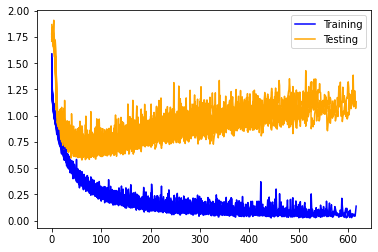

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

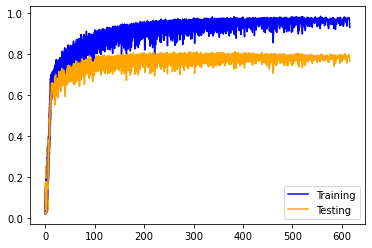

In [12]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

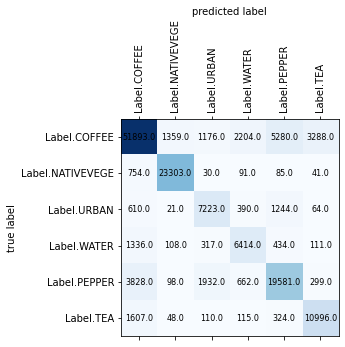

In [13]:
plot_confusion_matrix(conf_matrix, labels)

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.86447991 0.93447488 0.66954023 0.64945322 0.72662164 0.74302318]
Mean precision:  0.7645988424665022

Recalls:  [0.79590491 0.95881336 0.75617672 0.73555046 0.74170455 0.8330303 ]
Mean recall:  0.8035300493581877

F-Score:  [0.82877631 0.94648768 0.71022616 0.68982577 0.73408563 0.78545662]
Mean f-score:  0.7824763615467182


# BLUE, GREEN, RED, NIR, SWIR1, SWIR2, PANCHROMATIC

In [16]:
bands = [
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
]

model_name = "blue_green_red_nir_swir1_swir2_panchromatic"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 64)         

57/57 [==============================] - 0s 8ms/step - loss: 0.2752 - accuracy: 0.8594 - val_loss: 0.7409 - val_accuracy: 0.7624
Epoch 101/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2341 - accuracy: 0.8545 - val_loss: 0.7089 - val_accuracy: 0.7826
Epoch 102/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2003 - accuracy: 0.8922 - val_loss: 0.7172 - val_accuracy: 0.7834
Epoch 103/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1810 - accuracy: 0.8834 - val_loss: 0.7379 - val_accuracy: 0.7923
Epoch 104/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2423 - accuracy: 0.8646 - val_loss: 0.7823 - val_accuracy: 0.7653
Epoch 105/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2030 - accuracy: 0.8796 - val_loss: 0.7974 - val_accuracy: 0.7831
Epoch 106/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2126 - accuracy: 0.8890 - val_loss: 0.7882 - val_accuracy: 0.7713
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.9152 - val_loss: 0.8233 - val_accuracy: 0.7998
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1372 - accuracy: 0.9185 - val_loss: 0.8628 - val_accuracy: 0.7904
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1893 - accuracy: 0.9150 - val_loss: 1.0125 - val_accuracy: 0.7573
Epoch 160/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2032 - accuracy: 0.8931 - val_loss: 0.8611 - val_accuracy: 0.7701
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1230 - accuracy: 0.9237 - val_loss: 0.8562 - val_accuracy: 0.7754
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1045 - accuracy: 0.9338 - val_loss: 0.8742 - val_accuracy: 0.7888
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1513 - accuracy: 0.9097 - val_loss: 0.8065 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0978 - accuracy: 0.9348 - val_loss: 0.9376 - val_accuracy: 0.7766
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0994 - accuracy: 0.9444 - val_loss: 0.8398 - val_accuracy: 0.8050
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0761 - accuracy: 0.9490 - val_loss: 0.8602 - val_accuracy: 0.8113
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1085 - accuracy: 0.9505 - val_loss: 0.9997 - val_accuracy: 0.7854
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1310 - accuracy: 0.9217 - val_loss: 0.8784 - val_accuracy: 0.8012
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.9583 - val_loss: 0.9282 - val_accuracy: 0.8085
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1225 - accuracy: 0.9367 - val_loss: 0.9434 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0516 - accuracy: 0.9651 - val_loss: 1.0313 - val_accuracy: 0.8020
Epoch 272/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0494 - accuracy: 0.9666 - val_loss: 1.0323 - val_accuracy: 0.8027
Epoch 273/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0725 - accuracy: 0.9593 - val_loss: 1.0244 - val_accuracy: 0.8109
Epoch 274/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0554 - accuracy: 0.9683 - val_loss: 1.0427 - val_accuracy: 0.7999
Epoch 275/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0784 - accuracy: 0.9625 - val_loss: 0.9732 - val_accuracy: 0.7980
Epoch 276/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0662 - accuracy: 0.9613 - val_loss: 1.0173 - val_accuracy: 0.7985
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.9625 - val_loss: 1.0554 - val_accuracy:

Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4561 - accuracy: 0.7540 - val_loss: 0.8731 - val_accuracy: 0.6838
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5139 - accuracy: 0.7364 - val_loss: 0.7736 - val_accuracy: 0.7247
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5289 - accuracy: 0.7415 - val_loss: 0.8524 - val_accuracy: 0.6844
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5156 - accuracy: 0.7497 - val_loss: 0.8252 - val_accuracy: 0.6886
Epoch 46/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4887 - accuracy: 0.7661 - val_loss: 0.8727 - val_accuracy: 0.6852
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4764 - accuracy: 0.7690 - val_loss: 0.7506 - val_accuracy: 0.7211
Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4454 - accuracy: 0.7974 - val_loss: 0.8708 - val_accuracy: 0.6753

Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1046 - accuracy: 0.9412 - val_loss: 0.9672 - val_accuracy: 0.7909
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1124 - accuracy: 0.9421 - val_loss: 0.9566 - val_accuracy: 0.7848
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1433 - accuracy: 0.9231 - val_loss: 0.8948 - val_accuracy: 0.7836
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1062 - accuracy: 0.9373 - val_loss: 0.9229 - val_accuracy: 0.7860
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1018 - accuracy: 0.9357 - val_loss: 0.9485 - val_accuracy: 0.7849
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1149 - accuracy: 0.9447 - val_loss: 0.9663 - val_accuracy: 0.7855
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.9429 - val_loss: 0.9073 - val_accuracy:

Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0485 - accuracy: 0.9776 - val_loss: 1.0997 - val_accuracy: 0.7951
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0693 - accuracy: 0.9673 - val_loss: 1.1098 - val_accuracy: 0.7931
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.9585 - val_loss: 1.1370 - val_accuracy: 0.7943
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1232 - accuracy: 0.9479 - val_loss: 1.0822 - val_accuracy: 0.7836
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0905 - accuracy: 0.9494 - val_loss: 1.0508 - val_accuracy: 0.7960
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9661 - val_loss: 1.1171 - val_accuracy: 0.7868
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0794 - accuracy: 0.9484 - val_loss: 1.1521 - val_accuracy:

Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1281 - accuracy: 0.9345 - val_loss: 1.2687 - val_accuracy: 0.7527
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1753 - accuracy: 0.9208 - val_loss: 1.0479 - val_accuracy: 0.7902
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9585 - val_loss: 1.0748 - val_accuracy: 0.7890
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0641 - accuracy: 0.9667 - val_loss: 1.1024 - val_accuracy: 0.7962
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0634 - accuracy: 0.9584 - val_loss: 1.1339 - val_accuracy: 0.8064
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0615 - accuracy: 0.9579 - val_loss: 1.1176 - val_accuracy: 0.7969
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0569 - accuracy: 0.9641 - val_loss: 1.1553 - val_accuracy:

Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5273 - accuracy: 0.7506 - val_loss: 0.7367 - val_accuracy: 0.7224
Epoch 37/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5268 - accuracy: 0.7614 - val_loss: 0.7579 - val_accuracy: 0.7224
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5269 - accuracy: 0.7460 - val_loss: 0.7278 - val_accuracy: 0.7271
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4967 - accuracy: 0.7592 - val_loss: 0.8718 - val_accuracy: 0.7029
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4613 - accuracy: 0.7765 - val_loss: 0.7722 - val_accuracy: 0.7054
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5272 - accuracy: 0.7487 - val_loss: 0.7223 - val_accuracy: 0.7282
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4902 - accuracy: 0.7558 - val_loss: 0.8066 - val_accuracy: 0.7063

57/57 [==============================] - 0s 8ms/step - loss: 0.1547 - accuracy: 0.9146 - val_loss: 1.0523 - val_accuracy: 0.7579
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1542 - accuracy: 0.9088 - val_loss: 1.0625 - val_accuracy: 0.7426
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2499 - accuracy: 0.9030 - val_loss: 1.0717 - val_accuracy: 0.7430
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1510 - accuracy: 0.9009 - val_loss: 0.9361 - val_accuracy: 0.7665
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1199 - accuracy: 0.9336 - val_loss: 0.9752 - val_accuracy: 0.7709
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1057 - accuracy: 0.9316 - val_loss: 0.9944 - val_accuracy: 0.7724
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1275 - accuracy: 0.9250 - val_loss: 1.1273 - val_accuracy: 0.7681
Epoch 1

Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0557 - accuracy: 0.9619 - val_loss: 1.1863 - val_accuracy: 0.7916
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 0.9559 - val_loss: 1.2105 - val_accuracy: 0.7749
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0722 - accuracy: 0.9488 - val_loss: 1.1057 - val_accuracy: 0.7845
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0632 - accuracy: 0.9653 - val_loss: 1.1417 - val_accuracy: 0.7875
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0782 - accuracy: 0.9444 - val_loss: 1.2476 - val_accuracy: 0.7796
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0790 - accuracy: 0.9552 - val_loss: 1.2553 - val_accuracy: 0.7879
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0955 - accuracy: 0.9520 - val_loss: 1.2021 - val_accuracy:

Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0537 - accuracy: 0.9699 - val_loss: 1.1413 - val_accuracy: 0.7921
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0367 - accuracy: 0.9801 - val_loss: 1.2687 - val_accuracy: 0.7855
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0911 - accuracy: 0.9463 - val_loss: 1.2498 - val_accuracy: 0.7701
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0819 - accuracy: 0.9479 - val_loss: 1.1595 - val_accuracy: 0.7979
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9597 - val_loss: 1.2574 - val_accuracy: 0.7650
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.9649 - val_loss: 1.2309 - val_accuracy: 0.7817
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0690 - accuracy: 0.9643 - val_loss: 1.1702 - val_accuracy:

Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0409 - accuracy: 0.9789 - val_loss: 1.3380 - val_accuracy: 0.7803
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9704 - val_loss: 1.4457 - val_accuracy: 0.7570
Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.9416 - val_loss: 1.1710 - val_accuracy: 0.7814
Epoch 324/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0933 - accuracy: 0.9569 - val_loss: 1.1834 - val_accuracy: 0.7834
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0795 - accuracy: 0.9621 - val_loss: 1.1821 - val_accuracy: 0.7865
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0399 - accuracy: 0.9732 - val_loss: 1.1654 - val_accuracy: 0.7937
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0695 - accuracy: 0.9634 - val_loss: 1.2541 - val_accuracy:

Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0343 - accuracy: 0.9857 - val_loss: 1.4689 - val_accuracy: 0.7973
Epoch 379/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1169 - accuracy: 0.9627 - val_loss: 1.3182 - val_accuracy: 0.7846
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0743 - accuracy: 0.9639 - val_loss: 1.1703 - val_accuracy: 0.7836
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0592 - accuracy: 0.9663 - val_loss: 1.2107 - val_accuracy: 0.7940
Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0453 - accuracy: 0.9736 - val_loss: 1.3143 - val_accuracy: 0.7933
Epoch 383/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0569 - accuracy: 0.9636 - val_loss: 1.3407 - val_accuracy: 0.7863
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0513 - accuracy: 0.9671 - val_loss: 1.2730 - val_accuracy:

Epoch 435/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0628 - accuracy: 0.9659 - val_loss: 1.5696 - val_accuracy: 0.7465
Epoch 436/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0600 - accuracy: 0.9594 - val_loss: 1.3954 - val_accuracy: 0.7846
Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1567 - accuracy: 0.9298 - val_loss: 1.2327 - val_accuracy: 0.7472
Epoch 438/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1483 - accuracy: 0.9203 - val_loss: 1.1735 - val_accuracy: 0.7745
Epoch 439/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0614 - accuracy: 0.9526 - val_loss: 1.2465 - val_accuracy: 0.7981
Epoch 440/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1071 - accuracy: 0.9566 - val_loss: 1.3178 - val_accuracy: 0.7800
Epoch 441/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0577 - accuracy: 0.9709 - val_loss: 1.2579 - val_accuracy:

Epoch 492/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.9665 - val_loss: 1.5742 - val_accuracy: 0.7939
Epoch 493/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0335 - accuracy: 0.9791 - val_loss: 1.4128 - val_accuracy: 0.7914
Epoch 494/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0203 - accuracy: 0.9867 - val_loss: 1.5162 - val_accuracy: 0.7939
Epoch 495/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.9773 - val_loss: 1.4447 - val_accuracy: 0.7872
Epoch 496/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9791 - val_loss: 1.4632 - val_accuracy: 0.7917
Epoch 497/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9787 - val_loss: 1.4401 - val_accuracy: 0.7901
Epoch 498/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9853 - val_loss: 1.4876 - val_accuracy:

Epoch 549/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0411 - accuracy: 0.9835 - val_loss: 1.4287 - val_accuracy: 0.7924
Epoch 550/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0228 - accuracy: 0.9863 - val_loss: 1.4749 - val_accuracy: 0.7922
Epoch 551/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9668 - val_loss: 1.4519 - val_accuracy: 0.7875
Epoch 552/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0909 - accuracy: 0.9563 - val_loss: 1.3642 - val_accuracy: 0.7901
Epoch 553/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0766 - accuracy: 0.9686 - val_loss: 1.3259 - val_accuracy: 0.7886
Epoch 554/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0512 - accuracy: 0.9770 - val_loss: 1.3876 - val_accuracy: 0.7773
Epoch 555/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0411 - accuracy: 0.9736 - val_loss: 1.3399 - val_accuracy:

Epoch 606/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0267 - accuracy: 0.9888 - val_loss: 1.3773 - val_accuracy: 0.7973
Epoch 607/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9916 - val_loss: 1.4141 - val_accuracy: 0.7969
Epoch 608/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9802 - val_loss: 1.4178 - val_accuracy: 0.7884
Epoch 609/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0316 - accuracy: 0.9868 - val_loss: 1.4463 - val_accuracy: 0.7886
Epoch 610/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0311 - accuracy: 0.9807 - val_loss: 1.5022 - val_accuracy: 0.7842
Epoch 611/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0477 - accuracy: 0.9715 - val_loss: 1.5730 - val_accuracy: 0.7814
Epoch 612/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1715 - accuracy: 0.9650 - val_loss: 1.4609 - val_accuracy:

Epoch 663/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0395 - accuracy: 0.9829 - val_loss: 1.5923 - val_accuracy: 0.7910
Epoch 664/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0442 - accuracy: 0.9794 - val_loss: 1.4657 - val_accuracy: 0.7937
Epoch 665/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9889 - val_loss: 1.4762 - val_accuracy: 0.7893
Epoch 666/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9704 - val_loss: 1.5440 - val_accuracy: 0.7909
Epoch 667/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9876 - val_loss: 1.5335 - val_accuracy: 0.7967
Epoch 668/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0205 - accuracy: 0.9905 - val_loss: 1.4813 - val_accuracy: 0.7996
Epoch 669/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0200 - accuracy: 0.9883 - val_loss: 1.4891 - val_accuracy:

Epoch 720/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0559 - accuracy: 0.9781 - val_loss: 1.6488 - val_accuracy: 0.7848
Epoch 721/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9823 - val_loss: 1.6359 - val_accuracy: 0.7808
Epoch 722/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9835 - val_loss: 1.6123 - val_accuracy: 0.7846
Epoch 723/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0262 - accuracy: 0.9833 - val_loss: 1.5304 - val_accuracy: 0.7944
Epoch 724/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0142 - accuracy: 0.9916 - val_loss: 1.6635 - val_accuracy: 0.7947
Epoch 725/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1488 - accuracy: 0.9722 - val_loss: 1.3605 - val_accuracy: 0.7660
Epoch 726/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.9646 - val_loss: 1.5064 - val_accuracy:

Epoch 777/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1308 - accuracy: 0.9559 - val_loss: 1.3606 - val_accuracy: 0.7899
Epoch 778/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0302 - accuracy: 0.9801 - val_loss: 1.3528 - val_accuracy: 0.8031
Epoch 779/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0176 - accuracy: 0.9925 - val_loss: 1.4419 - val_accuracy: 0.7982
Epoch 780/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0449 - accuracy: 0.9790 - val_loss: 1.4643 - val_accuracy: 0.7829
Epoch 781/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0768 - accuracy: 0.9663 - val_loss: 1.5076 - val_accuracy: 0.7861
Epoch 782/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.9793 - val_loss: 1.5223 - val_accuracy: 0.7791
Epoch 783/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0619 - accuracy: 0.9733 - val_loss: 1.5885 - val_accuracy:

Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4154 - accuracy: 0.7745 - val_loss: 0.7524 - val_accuracy: 0.7369
Epoch 50/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3780 - accuracy: 0.8010 - val_loss: 0.9309 - val_accuracy: 0.6736
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3766 - accuracy: 0.7895 - val_loss: 0.8422 - val_accuracy: 0.6925
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3886 - accuracy: 0.7855 - val_loss: 0.7637 - val_accuracy: 0.7343
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3633 - accuracy: 0.7889 - val_loss: 0.7873 - val_accuracy: 0.7324
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4062 - accuracy: 0.7747 - val_loss: 0.8257 - val_accuracy: 0.7188
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3651 - accuracy: 0.7974 - val_loss: 0.7958 - val_accuracy: 0.7259

Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1403 - accuracy: 0.9249 - val_loss: 1.2233 - val_accuracy: 0.7293
Epoch 164/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1343 - accuracy: 0.9121 - val_loss: 0.9604 - val_accuracy: 0.7715
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1094 - accuracy: 0.9300 - val_loss: 0.9827 - val_accuracy: 0.7897
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1716 - accuracy: 0.9086 - val_loss: 0.9882 - val_accuracy: 0.7557
Epoch 167/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1376 - accuracy: 0.9152 - val_loss: 1.0140 - val_accuracy: 0.7553
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1572 - accuracy: 0.9026 - val_loss: 0.9847 - val_accuracy: 0.7679
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1286 - accuracy: 0.9169 - val_loss: 0.9137 - val_accuracy

Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9499 - val_loss: 1.0764 - val_accuracy: 0.7701
Epoch 221/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 0.9384 - val_loss: 1.1747 - val_accuracy: 0.7591
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1144 - accuracy: 0.9285 - val_loss: 1.0926 - val_accuracy: 0.7510
Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9338 - val_loss: 1.0562 - val_accuracy: 0.7916
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9479 - val_loss: 1.0653 - val_accuracy: 0.7779
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0756 - accuracy: 0.9620 - val_loss: 1.1245 - val_accuracy: 0.8004
Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1034 - accuracy: 0.9604 - val_loss: 1.0813 - val_accuracy:

Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6956 - accuracy: 0.6805 - val_loss: 0.8505 - val_accuracy: 0.6648
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6832 - accuracy: 0.6576 - val_loss: 0.9069 - val_accuracy: 0.6390
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6724 - accuracy: 0.6616 - val_loss: 0.9051 - val_accuracy: 0.6301
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6623 - accuracy: 0.6487 - val_loss: 0.8044 - val_accuracy: 0.6819
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.6725 - val_loss: 0.9147 - val_accuracy: 0.6396
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5863 - accuracy: 0.6898 - val_loss: 0.8472 - val_accuracy: 0.6858
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6524 - accuracy: 0.6550 - val_loss: 1.1929 - val_accuracy: 0.5472

57/57 [==============================] - 0s 7ms/step - loss: 0.1145 - accuracy: 0.9288 - val_loss: 0.9515 - val_accuracy: 0.7734
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1035 - accuracy: 0.9197 - val_loss: 1.0024 - val_accuracy: 0.7815
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1080 - accuracy: 0.9266 - val_loss: 0.8893 - val_accuracy: 0.7836
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1084 - accuracy: 0.9247 - val_loss: 0.8918 - val_accuracy: 0.7992
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0763 - accuracy: 0.9518 - val_loss: 0.9125 - val_accuracy: 0.7989
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.9381 - val_loss: 0.9212 - val_accuracy: 0.7841
Epoch 140/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1250 - accuracy: 0.9304 - val_loss: 0.9027 - val_accuracy: 0.7884
Epoch 1

Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1093 - accuracy: 0.9382 - val_loss: 1.0049 - val_accuracy: 0.7979
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0761 - accuracy: 0.9591 - val_loss: 1.0209 - val_accuracy: 0.7951
Epoch 193/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0788 - accuracy: 0.9515 - val_loss: 1.0254 - val_accuracy: 0.7812
Epoch 194/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0907 - accuracy: 0.9418 - val_loss: 1.0372 - val_accuracy: 0.7954
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1021 - accuracy: 0.9329 - val_loss: 1.0012 - val_accuracy: 0.7842
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9412 - val_loss: 1.0084 - val_accuracy: 0.7956
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0837 - accuracy: 0.9468 - val_loss: 1.1650 - val_accuracy:

Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.9580 - val_loss: 1.2114 - val_accuracy: 0.7989
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.9789 - val_loss: 1.1918 - val_accuracy: 0.7906
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0796 - accuracy: 0.9584 - val_loss: 1.1713 - val_accuracy: 0.8011
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1040 - accuracy: 0.9512 - val_loss: 1.0450 - val_accuracy: 0.7883
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9538 - val_loss: 1.0875 - val_accuracy: 0.7770
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0793 - accuracy: 0.9677 - val_loss: 1.0854 - val_accuracy: 0.7860
Epoch 254/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0706 - accuracy: 0.9490 - val_loss: 1.1182 - val_accuracy:

Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.9633 - val_loss: 1.2323 - val_accuracy: 0.7785
Epoch 306/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1139 - accuracy: 0.9560 - val_loss: 1.1938 - val_accuracy: 0.7517
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 0.9486 - val_loss: 1.2820 - val_accuracy: 0.7845
Epoch 308/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0634 - accuracy: 0.9622 - val_loss: 1.2820 - val_accuracy: 0.7888
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0807 - accuracy: 0.9636 - val_loss: 1.2782 - val_accuracy: 0.7983
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0649 - accuracy: 0.9684 - val_loss: 1.1759 - val_accuracy: 0.8012
Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9665 - val_loss: 1.1814 - val_accuracy:

Epoch 362/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0792 - accuracy: 0.9582 - val_loss: 1.2254 - val_accuracy: 0.7707
Epoch 363/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0772 - accuracy: 0.9515 - val_loss: 1.1906 - val_accuracy: 0.7893
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0493 - accuracy: 0.9643 - val_loss: 1.2373 - val_accuracy: 0.7986
Epoch 365/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0581 - accuracy: 0.9740 - val_loss: 1.2970 - val_accuracy: 0.7849
Epoch 366/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.0668 - accuracy: 0.9602 - val_loss: 1.3231 - val_accuracy: 0.7988
Epoch 367/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9811 - val_loss: 1.3863 - val_accuracy: 0.7852
Epoch 368/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0452 - accuracy: 0.9781 - val_loss: 1.3492 - val_accuracy

Epoch 419/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9731 - val_loss: 1.2277 - val_accuracy: 0.7993
Epoch 420/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0430 - accuracy: 0.9739 - val_loss: 1.3812 - val_accuracy: 0.7912
Epoch 421/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.9533 - val_loss: 1.2566 - val_accuracy: 0.7864
Epoch 422/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9732 - val_loss: 1.2826 - val_accuracy: 0.7975
Epoch 423/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.9748 - val_loss: 1.2907 - val_accuracy: 0.7963
Epoch 424/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0339 - accuracy: 0.9790 - val_loss: 1.3246 - val_accuracy: 0.7959
Epoch 425/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.9727 - val_loss: 1.2994 - val_accuracy:

Epoch 476/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9665 - val_loss: 1.4238 - val_accuracy: 0.7899
Epoch 477/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0616 - accuracy: 0.9731 - val_loss: 1.4278 - val_accuracy: 0.7950
Epoch 478/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0367 - accuracy: 0.9811 - val_loss: 1.3994 - val_accuracy: 0.7901
Epoch 479/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9736 - val_loss: 1.3637 - val_accuracy: 0.8032

Validation  2 , fold  1 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6664 - accuracy: 0.1368 - val_loss: 1.7786 - val_accuracy: 0.0653
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.1914 - accuracy: 0.3582 - val_loss: 1.7333 - val_accuracy: 0.4392
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1412 - a

Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4223 - accuracy: 0.7770 - val_loss: 0.6675 - val_accuracy: 0.7675
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3402 - accuracy: 0.8244 - val_loss: 0.8214 - val_accuracy: 0.7215
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3032 - accuracy: 0.8271 - val_loss: 0.6652 - val_accuracy: 0.7706
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3871 - accuracy: 0.8218 - val_loss: 0.7135 - val_accuracy: 0.7433
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4284 - accuracy: 0.7817 - val_loss: 0.7811 - val_accuracy: 0.7132
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3482 - accuracy: 0.8201 - val_loss: 0.6732 - val_accuracy: 0.7792
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3148 - accuracy: 0.8325 - val_loss: 0.7309 - val_accuracy: 0.7609

Epoch 168/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.9414 - val_loss: 1.0066 - val_accuracy: 0.7685
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.9380 - val_loss: 1.2268 - val_accuracy: 0.7330
Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1667 - accuracy: 0.9125 - val_loss: 0.9224 - val_accuracy: 0.7887
Epoch 171/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1274 - accuracy: 0.9289 - val_loss: 0.8766 - val_accuracy: 0.7934
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0899 - accuracy: 0.9451 - val_loss: 0.9939 - val_accuracy: 0.7842
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1053 - accuracy: 0.9246 - val_loss: 0.9750 - val_accuracy: 0.7842
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1517 - accuracy: 0.9241 - val_loss: 0.8887 - val_accuracy:

Epoch 225/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1421 - accuracy: 0.9241 - val_loss: 1.0450 - val_accuracy: 0.7847
Epoch 226/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1038 - accuracy: 0.9472 - val_loss: 1.0362 - val_accuracy: 0.7834
Epoch 227/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0637 - accuracy: 0.9672 - val_loss: 1.0564 - val_accuracy: 0.7894
Epoch 228/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0600 - accuracy: 0.9654 - val_loss: 1.1207 - val_accuracy: 0.7868
Epoch 229/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0769 - accuracy: 0.9585 - val_loss: 1.0778 - val_accuracy: 0.7887
Epoch 230/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0616 - accuracy: 0.9579 - val_loss: 1.0009 - val_accuracy: 0.7961
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9558 - val_loss: 0.9958 - val_accura

Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9498 - val_loss: 1.1599 - val_accuracy: 0.7937
Epoch 283/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0436 - accuracy: 0.9603 - val_loss: 1.2741 - val_accuracy: 0.7880
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0633 - accuracy: 0.9624 - val_loss: 1.3697 - val_accuracy: 0.7478
Epoch 285/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1896 - accuracy: 0.9060 - val_loss: 1.0562 - val_accuracy: 0.7914
Epoch 286/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0535 - accuracy: 0.9658 - val_loss: 1.1661 - val_accuracy: 0.7902
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.9673 - val_loss: 1.2452 - val_accuracy: 0.7828
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0840 - accuracy: 0.9503 - val_loss: 1.0982 - val_accuracy

Epoch 339/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0414 - accuracy: 0.9712 - val_loss: 1.1806 - val_accuracy: 0.7860
Epoch 340/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0558 - accuracy: 0.9724 - val_loss: 1.2906 - val_accuracy: 0.7736
Epoch 341/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0705 - accuracy: 0.9643 - val_loss: 1.1208 - val_accuracy: 0.7915
Epoch 342/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0550 - accuracy: 0.9663 - val_loss: 1.1394 - val_accuracy: 0.7961
Epoch 343/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0273 - accuracy: 0.9772 - val_loss: 1.1813 - val_accuracy: 0.7923
Epoch 344/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0776 - accuracy: 0.9625 - val_loss: 1.2021 - val_accuracy: 0.7812
Epoch 345/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0490 - accuracy: 0.9739 - val_loss: 1.2907 - val_accura

Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5381 - accuracy: 0.7303 - val_loss: 0.8282 - val_accuracy: 0.6902
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4836 - accuracy: 0.7574 - val_loss: 0.7349 - val_accuracy: 0.7112
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4257 - accuracy: 0.7605 - val_loss: 0.7471 - val_accuracy: 0.7111
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4464 - accuracy: 0.7584 - val_loss: 0.7167 - val_accuracy: 0.7348
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4139 - accuracy: 0.7727 - val_loss: 0.8221 - val_accuracy: 0.6918
Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4056 - accuracy: 0.7707 - val_loss: 0.8036 - val_accuracy: 0.6888
Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3744 - accuracy: 0.7900 - val_loss: 0.7588 - val_accuracy: 0.7191

Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1743 - accuracy: 0.9215 - val_loss: 0.9746 - val_accuracy: 0.7612
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1197 - accuracy: 0.9294 - val_loss: 0.8711 - val_accuracy: 0.7825
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.9361 - val_loss: 0.8829 - val_accuracy: 0.7966
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1099 - accuracy: 0.9381 - val_loss: 0.9263 - val_accuracy: 0.7679
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9413 - val_loss: 0.8924 - val_accuracy: 0.7962
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1009 - accuracy: 0.9388 - val_loss: 0.9005 - val_accuracy: 0.7910
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0749 - accuracy: 0.9612 - val_loss: 0.9406 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0559 - accuracy: 0.9612 - val_loss: 1.0110 - val_accuracy: 0.7855
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.9452 - val_loss: 0.9527 - val_accuracy: 0.7907
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9354 - val_loss: 0.9128 - val_accuracy: 0.8001
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0858 - accuracy: 0.9527 - val_loss: 0.8504 - val_accuracy: 0.8065
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0995 - accuracy: 0.9456 - val_loss: 0.9938 - val_accuracy: 0.7749
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0706 - accuracy: 0.9553 - val_loss: 1.0501 - val_accuracy: 0.7659
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0797 - accuracy: 0.9555 - val_loss: 0.9619 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9790 - val_loss: 1.1379 - val_accuracy: 0.7922
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0436 - accuracy: 0.9697 - val_loss: 1.1041 - val_accuracy: 0.8069
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0425 - accuracy: 0.9834 - val_loss: 1.1773 - val_accuracy: 0.7937
Epoch 274/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0590 - accuracy: 0.9734 - val_loss: 1.0408 - val_accuracy: 0.8001
Epoch 275/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0585 - accuracy: 0.9736 - val_loss: 1.1066 - val_accuracy: 0.8057
Epoch 276/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0433 - accuracy: 0.9712 - val_loss: 1.1215 - val_accuracy: 0.8021
Epoch 277/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0455 - accuracy: 0.9786 - val_loss: 1.1566 - val_accurac

Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9761 - val_loss: 1.0753 - val_accuracy: 0.8015
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0272 - accuracy: 0.9816 - val_loss: 1.1665 - val_accuracy: 0.7912
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0382 - accuracy: 0.9836 - val_loss: 1.4426 - val_accuracy: 0.7564
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.9442 - val_loss: 1.1875 - val_accuracy: 0.7830
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1159 - accuracy: 0.9487 - val_loss: 1.0753 - val_accuracy: 0.8039
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0663 - accuracy: 0.9679 - val_loss: 1.0309 - val_accuracy: 0.7990
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0614 - accuracy: 0.9651 - val_loss: 1.0974 - val_accuracy:

Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9684 - val_loss: 1.1135 - val_accuracy: 0.7903
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0418 - accuracy: 0.9704 - val_loss: 1.1411 - val_accuracy: 0.8036
Epoch 387/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0298 - accuracy: 0.9813 - val_loss: 1.1615 - val_accuracy: 0.7960
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0482 - accuracy: 0.9737 - val_loss: 1.2215 - val_accuracy: 0.7948
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9726 - val_loss: 1.2343 - val_accuracy: 0.8106
Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0782 - accuracy: 0.9696 - val_loss: 1.3432 - val_accuracy: 0.7717
Epoch 391/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9713 - val_loss: 1.2498 - val_accuracy:

Epoch 442/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0422 - accuracy: 0.9785 - val_loss: 1.1783 - val_accuracy: 0.8107
Epoch 443/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.9835 - val_loss: 1.2803 - val_accuracy: 0.7940
Epoch 444/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9742 - val_loss: 1.2415 - val_accuracy: 0.7950
Epoch 445/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9866 - val_loss: 1.2653 - val_accuracy: 0.8030
Epoch 446/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9864 - val_loss: 1.3384 - val_accuracy: 0.7948
Epoch 447/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0615 - accuracy: 0.9677 - val_loss: 1.1945 - val_accuracy: 0.8102
Epoch 448/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0713 - accuracy: 0.9652 - val_loss: 1.1735 - val_accuracy

Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.6868 - val_loss: 0.9581 - val_accuracy: 0.6312
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6901 - accuracy: 0.7012 - val_loss: 1.0047 - val_accuracy: 0.6187
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.6856 - val_loss: 0.9601 - val_accuracy: 0.6624
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7081 - accuracy: 0.6945 - val_loss: 0.8554 - val_accuracy: 0.6827
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7088 - accuracy: 0.6857 - val_loss: 0.8327 - val_accuracy: 0.6886
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6361 - accuracy: 0.7250 - val_loss: 0.7828 - val_accuracy: 0.7089
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6309 - accuracy: 0.7431 - val_loss: 0.7901 - val_accuracy: 0.7046

57/57 [==============================] - 0s 8ms/step - loss: 0.1567 - accuracy: 0.9061 - val_loss: 0.8827 - val_accuracy: 0.7761
Epoch 134/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1685 - accuracy: 0.8938 - val_loss: 0.9189 - val_accuracy: 0.7846
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1561 - accuracy: 0.9141 - val_loss: 0.9213 - val_accuracy: 0.7621
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1442 - accuracy: 0.9180 - val_loss: 0.8537 - val_accuracy: 0.7796
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 0.9166 - val_loss: 0.9048 - val_accuracy: 0.7834
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1484 - accuracy: 0.9177 - val_loss: 0.8632 - val_accuracy: 0.7751
Epoch 139/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1362 - accuracy: 0.9050 - val_loss: 0.9144 - val_accuracy: 0.7814
Epoch 1

Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1027 - accuracy: 0.9543 - val_loss: 1.0919 - val_accuracy: 0.7734
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1088 - accuracy: 0.9415 - val_loss: 1.0637 - val_accuracy: 0.7840
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1004 - accuracy: 0.9510 - val_loss: 1.0262 - val_accuracy: 0.7931
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.9430 - val_loss: 1.0240 - val_accuracy: 0.7643
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1461 - accuracy: 0.9099 - val_loss: 0.9700 - val_accuracy: 0.7795
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1147 - accuracy: 0.9411 - val_loss: 1.0293 - val_accuracy: 0.7799
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0952 - accuracy: 0.9447 - val_loss: 0.9662 - val_accuracy:

Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1000 - accuracy: 0.9539 - val_loss: 1.0626 - val_accuracy: 0.7894
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.9716 - val_loss: 1.0595 - val_accuracy: 0.7990
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0886 - accuracy: 0.9525 - val_loss: 1.2446 - val_accuracy: 0.7912
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0695 - accuracy: 0.9691 - val_loss: 1.2242 - val_accuracy: 0.7970
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0702 - accuracy: 0.9560 - val_loss: 1.2242 - val_accuracy: 0.7817
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy: 0.9400 - val_loss: 1.3137 - val_accuracy: 0.7675
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.9403 - val_loss: 1.1678 - val_accuracy:

Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1283 - accuracy: 0.9280 - val_loss: 1.2305 - val_accuracy: 0.7791
Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.9599 - val_loss: 1.1539 - val_accuracy: 0.7954
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.9792 - val_loss: 1.1510 - val_accuracy: 0.7996
Epoch 307/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0511 - accuracy: 0.9724 - val_loss: 1.2258 - val_accuracy: 0.7960
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0636 - accuracy: 0.9638 - val_loss: 1.3768 - val_accuracy: 0.7802
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.9455 - val_loss: 1.2314 - val_accuracy: 0.7928
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0854 - accuracy: 0.9617 - val_loss: 1.1501 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3206 - accuracy: 0.8086 - val_loss: 0.6495 - val_accuracy: 0.7883
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3494 - accuracy: 0.8040 - val_loss: 0.7684 - val_accuracy: 0.7437
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3542 - accuracy: 0.7923 - val_loss: 0.8011 - val_accuracy: 0.7211
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2937 - accuracy: 0.8137 - val_loss: 0.7926 - val_accuracy: 0.7384
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3099 - accuracy: 0.8281 - val_loss: 0.9128 - val_accuracy: 0.6826
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3140 - accuracy: 0.8085 - val_loss: 0.7813 - val_accuracy: 0.7373
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3472 - accuracy: 0.8046 - val_loss: 0.7928 - val_accuracy: 0.7331
Epoch 65/2000

Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1122 - accuracy: 0.9278 - val_loss: 1.0271 - val_accuracy: 0.7924
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1298 - accuracy: 0.9278 - val_loss: 1.0150 - val_accuracy: 0.7971
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1582 - accuracy: 0.9203 - val_loss: 0.9646 - val_accuracy: 0.7660
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1157 - accuracy: 0.9193 - val_loss: 1.0993 - val_accuracy: 0.7849
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.9244 - val_loss: 1.0162 - val_accuracy: 0.7918
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0974 - accuracy: 0.9453 - val_loss: 0.9603 - val_accuracy: 0.8083
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9497 - val_loss: 0.9730 - val_accuracy:

Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9589 - val_loss: 1.0171 - val_accuracy: 0.8084
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0577 - accuracy: 0.9625 - val_loss: 1.1994 - val_accuracy: 0.7945
Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.9543 - val_loss: 1.1026 - val_accuracy: 0.8112
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0801 - accuracy: 0.9571 - val_loss: 1.1239 - val_accuracy: 0.8015
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0587 - accuracy: 0.9716 - val_loss: 1.2047 - val_accuracy: 0.7964
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0858 - accuracy: 0.9461 - val_loss: 1.1509 - val_accuracy: 0.7973
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0845 - accuracy: 0.9560 - val_loss: 1.1484 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0669 - accuracy: 0.9676 - val_loss: 1.3087 - val_accuracy: 0.7762
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0558 - accuracy: 0.9612 - val_loss: 1.1630 - val_accuracy: 0.8095
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9585 - val_loss: 1.2051 - val_accuracy: 0.8058
Epoch 289/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0851 - accuracy: 0.9531 - val_loss: 1.1726 - val_accuracy: 0.7811
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9481 - val_loss: 1.1372 - val_accuracy: 0.8107
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0335 - accuracy: 0.9803 - val_loss: 1.2248 - val_accuracy: 0.8036
Epoch 292/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.9753 - val_loss: 1.3109 - val_accuracy:

Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0520 - accuracy: 0.9745 - val_loss: 1.2298 - val_accuracy: 0.8068
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0364 - accuracy: 0.9867 - val_loss: 1.2860 - val_accuracy: 0.8111
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0617 - accuracy: 0.9665 - val_loss: 1.2342 - val_accuracy: 0.7887
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0942 - accuracy: 0.9572 - val_loss: 1.2728 - val_accuracy: 0.7964
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0610 - accuracy: 0.9630 - val_loss: 1.3601 - val_accuracy: 0.8083
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0669 - accuracy: 0.9651 - val_loss: 1.2979 - val_accuracy: 0.8045
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0532 - accuracy: 0.9768 - val_loss: 1.2812 - val_accuracy:

Epoch 400/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0523 - accuracy: 0.9716 - val_loss: 1.2423 - val_accuracy: 0.7971
Epoch 401/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0615 - accuracy: 0.9578 - val_loss: 1.2355 - val_accuracy: 0.8114
Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0344 - accuracy: 0.9773 - val_loss: 1.5938 - val_accuracy: 0.7910
Epoch 403/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0562 - accuracy: 0.9626 - val_loss: 1.2254 - val_accuracy: 0.8148
Epoch 404/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0375 - accuracy: 0.9766 - val_loss: 1.2328 - val_accuracy: 0.8092
Epoch 405/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0336 - accuracy: 0.9794 - val_loss: 1.3491 - val_accuracy: 0.8103
Epoch 406/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.9821 - val_loss: 1.5483 - val_accuracy:

Epoch 457/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0663 - accuracy: 0.9668 - val_loss: 1.1661 - val_accuracy: 0.8031
Epoch 458/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.9651 - val_loss: 1.1961 - val_accuracy: 0.7931
Epoch 459/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9720 - val_loss: 1.2603 - val_accuracy: 0.8062
Epoch 460/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9658 - val_loss: 1.3061 - val_accuracy: 0.8026
Epoch 461/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0971 - accuracy: 0.9639 - val_loss: 1.2809 - val_accuracy: 0.7803
Epoch 462/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9323 - val_loss: 1.1306 - val_accuracy: 0.7981
Epoch 463/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0335 - accuracy: 0.9845 - val_loss: 1.2108 - val_accuracy:

Epoch 514/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 1.4273 - val_accuracy: 0.8080
Epoch 515/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0352 - accuracy: 0.9842 - val_loss: 1.4192 - val_accuracy: 0.8100

Validation  2 , fold  5 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6467 - accuracy: 0.1632 - val_loss: 1.6862 - val_accuracy: 0.1646
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2390 - accuracy: 0.3443 - val_loss: 1.7078 - val_accuracy: 0.0912
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2069 - accuracy: 0.4190 - val_loss: 1.6693 - val_accuracy: 0.3311
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1159 - accuracy: 0.4148 - val_loss: 1.6652 - val_accuracy: 0.4516
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0663 - accur

Epoch 56/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3394 - accuracy: 0.8070 - val_loss: 0.7083 - val_accuracy: 0.7538
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3568 - accuracy: 0.7958 - val_loss: 0.6753 - val_accuracy: 0.7590
Epoch 58/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3635 - accuracy: 0.8153 - val_loss: 0.7172 - val_accuracy: 0.7388
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3132 - accuracy: 0.8395 - val_loss: 0.6408 - val_accuracy: 0.7622
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3164 - accuracy: 0.8123 - val_loss: 0.7122 - val_accuracy: 0.7517
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3051 - accuracy: 0.8243 - val_loss: 0.7614 - val_accuracy: 0.7363
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3015 - accuracy: 0.8240 - val_loss: 0.6966 - val_accuracy: 0.7598

Epoch 170/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0916 - accuracy: 0.9447 - val_loss: 1.0230 - val_accuracy: 0.7914
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2007 - accuracy: 0.9194 - val_loss: 0.8697 - val_accuracy: 0.7825
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1047 - accuracy: 0.9366 - val_loss: 0.8754 - val_accuracy: 0.8064
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1162 - accuracy: 0.9279 - val_loss: 0.8958 - val_accuracy: 0.7973
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1005 - accuracy: 0.9389 - val_loss: 0.9191 - val_accuracy: 0.8116
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9455 - val_loss: 1.4151 - val_accuracy: 0.7465
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2545 - accuracy: 0.8755 - val_loss: 0.8997 - val_accuracy:

Epoch 227/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.9584 - val_loss: 1.0567 - val_accuracy: 0.7928
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9437 - val_loss: 0.9661 - val_accuracy: 0.8009
Epoch 229/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0613 - accuracy: 0.9602 - val_loss: 0.9900 - val_accuracy: 0.7943
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0589 - accuracy: 0.9579 - val_loss: 1.0322 - val_accuracy: 0.8089
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0842 - accuracy: 0.9635 - val_loss: 1.0571 - val_accuracy: 0.7983
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9609 - val_loss: 1.0196 - val_accuracy: 0.7989
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9660 - val_loss: 1.0301 - val_accuracy:

Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0388 - accuracy: 0.9763 - val_loss: 1.2631 - val_accuracy: 0.7932
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0647 - accuracy: 0.9620 - val_loss: 1.2264 - val_accuracy: 0.8073
Epoch 286/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0529 - accuracy: 0.9743 - val_loss: 1.2031 - val_accuracy: 0.7958
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2015 - accuracy: 0.9398 - val_loss: 1.1139 - val_accuracy: 0.7954
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0982 - accuracy: 0.9484 - val_loss: 1.0002 - val_accuracy: 0.8045
Epoch 289/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0621 - accuracy: 0.9765 - val_loss: 1.0514 - val_accuracy: 0.8012
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.9696 - val_loss: 1.0200 - val_accuracy:

Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4771 - accuracy: 0.7433 - val_loss: 0.7382 - val_accuracy: 0.7313
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4402 - accuracy: 0.7717 - val_loss: 0.8305 - val_accuracy: 0.6996
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3895 - accuracy: 0.7968 - val_loss: 0.7961 - val_accuracy: 0.7029
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4111 - accuracy: 0.7717 - val_loss: 0.7086 - val_accuracy: 0.7421
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4080 - accuracy: 0.7927 - val_loss: 0.8011 - val_accuracy: 0.7113
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4533 - accuracy: 0.7766 - val_loss: 0.7892 - val_accuracy: 0.7110
Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4010 - accuracy: 0.7872 - val_loss: 0.7556 - val_accuracy: 0.7332

Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1191 - accuracy: 0.9309 - val_loss: 0.9297 - val_accuracy: 0.7800
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1096 - accuracy: 0.9444 - val_loss: 0.8694 - val_accuracy: 0.8080
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1005 - accuracy: 0.9499 - val_loss: 0.9841 - val_accuracy: 0.7780
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0968 - accuracy: 0.9421 - val_loss: 0.9808 - val_accuracy: 0.7841
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1594 - accuracy: 0.9163 - val_loss: 0.8601 - val_accuracy: 0.7934
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1757 - accuracy: 0.9104 - val_loss: 0.8435 - val_accuracy: 0.7941
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0918 - accuracy: 0.9455 - val_loss: 0.8393 - val_accuracy:

Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9371 - val_loss: 1.0038 - val_accuracy: 0.7682
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0908 - accuracy: 0.9318 - val_loss: 0.9147 - val_accuracy: 0.7985
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0760 - accuracy: 0.9685 - val_loss: 0.9468 - val_accuracy: 0.8046
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0711 - accuracy: 0.9592 - val_loss: 0.9265 - val_accuracy: 0.7972
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0603 - accuracy: 0.9647 - val_loss: 1.0974 - val_accuracy: 0.7842
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.9476 - val_loss: 1.0530 - val_accuracy: 0.7822
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0834 - accuracy: 0.9532 - val_loss: 0.9820 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.3086 - accuracy: 0.8495 - val_loss: 0.8348 - val_accuracy: 0.7285
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3231 - accuracy: 0.8234 - val_loss: 0.7488 - val_accuracy: 0.7583
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2635 - accuracy: 0.8706 - val_loss: 0.7451 - val_accuracy: 0.7594
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2516 - accuracy: 0.8360 - val_loss: 0.7797 - val_accuracy: 0.7617
Epoch 73/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2824 - accuracy: 0.8339 - val_loss: 0.8530 - val_accuracy: 0.7427
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3080 - accuracy: 0.8036 - val_loss: 0.7955 - val_accuracy: 0.7480
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.8536 - val_loss: 0.8411 - val_accuracy: 0.7167
Epoch 76/2000

Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1067 - accuracy: 0.9424 - val_loss: 1.1113 - val_accuracy: 0.7450
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1229 - accuracy: 0.9137 - val_loss: 0.9488 - val_accuracy: 0.8028
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.9521 - val_loss: 1.0242 - val_accuracy: 0.7941
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0999 - accuracy: 0.9432 - val_loss: 0.9618 - val_accuracy: 0.7956
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1346 - accuracy: 0.9344 - val_loss: 0.9534 - val_accuracy: 0.8020
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0791 - accuracy: 0.9507 - val_loss: 1.0354 - val_accuracy: 0.8020
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9492 - val_loss: 1.0501 - val_accuracy:

Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1154 - accuracy: 0.9573 - val_loss: 1.1281 - val_accuracy: 0.7909
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9533 - val_loss: 1.1455 - val_accuracy: 0.8002
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.9579 - val_loss: 1.1252 - val_accuracy: 0.8058
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9602 - val_loss: 1.0971 - val_accuracy: 0.8050
Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0590 - accuracy: 0.9583 - val_loss: 1.1375 - val_accuracy: 0.7933
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.9477 - val_loss: 1.1621 - val_accuracy: 0.7789
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1228 - accuracy: 0.9274 - val_loss: 0.9856 - val_accuracy:

Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0415 - accuracy: 0.9706 - val_loss: 1.1587 - val_accuracy: 0.8088
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0610 - accuracy: 0.9733 - val_loss: 1.1497 - val_accuracy: 0.7969
Epoch 299/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0570 - accuracy: 0.9709 - val_loss: 1.2313 - val_accuracy: 0.7920
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0474 - accuracy: 0.9724 - val_loss: 1.2607 - val_accuracy: 0.8016
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0514 - accuracy: 0.9741 - val_loss: 1.4521 - val_accuracy: 0.7865
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0709 - accuracy: 0.9657 - val_loss: 1.3284 - val_accuracy: 0.7917
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0912 - accuracy: 0.9662 - val_loss: 1.3148 - val_accuracy:

Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4194 - accuracy: 0.7682 - val_loss: 0.7136 - val_accuracy: 0.7409
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4100 - accuracy: 0.7895 - val_loss: 0.7526 - val_accuracy: 0.7276
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4196 - accuracy: 0.7879 - val_loss: 0.7011 - val_accuracy: 0.7432
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4419 - accuracy: 0.7722 - val_loss: 0.8447 - val_accuracy: 0.6964
Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4211 - accuracy: 0.7801 - val_loss: 0.6899 - val_accuracy: 0.7583
Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4268 - accuracy: 0.7731 - val_loss: 0.7147 - val_accuracy: 0.7234
Epoch 51/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3784 - accuracy: 0.7926 - val_loss: 0.7390 - val_accuracy: 0.7382

Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1016 - accuracy: 0.9311 - val_loss: 0.9389 - val_accuracy: 0.7865
Epoch 160/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1129 - accuracy: 0.9380 - val_loss: 0.9946 - val_accuracy: 0.7637
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1634 - accuracy: 0.8982 - val_loss: 0.8800 - val_accuracy: 0.7716
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1294 - accuracy: 0.9139 - val_loss: 0.9127 - val_accuracy: 0.7882
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1145 - accuracy: 0.9239 - val_loss: 0.9546 - val_accuracy: 0.7887
Epoch 164/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0949 - accuracy: 0.9412 - val_loss: 1.0798 - val_accuracy: 0.7728
Epoch 165/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.9357 - val_loss: 1.0383 - val_accuracy

Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0588 - accuracy: 0.9627 - val_loss: 1.0575 - val_accuracy: 0.7815
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0885 - accuracy: 0.9485 - val_loss: 1.0084 - val_accuracy: 0.7907
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1086 - accuracy: 0.9356 - val_loss: 1.0106 - val_accuracy: 0.7939
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0950 - accuracy: 0.9427 - val_loss: 1.0743 - val_accuracy: 0.7940
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1318 - accuracy: 0.9331 - val_loss: 1.0144 - val_accuracy: 0.7542
Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1738 - accuracy: 0.9205 - val_loss: 0.8862 - val_accuracy: 0.7766
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9545 - val_loss: 0.9432 - val_accuracy:

Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0467 - accuracy: 0.9725 - val_loss: 1.1181 - val_accuracy: 0.8076
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9511 - val_loss: 1.0104 - val_accuracy: 0.7963
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0736 - accuracy: 0.9641 - val_loss: 1.1484 - val_accuracy: 0.7783
Epoch 276/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0922 - accuracy: 0.9556 - val_loss: 1.2325 - val_accuracy: 0.7540
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1720 - accuracy: 0.9092 - val_loss: 0.9915 - val_accuracy: 0.7898
Epoch 278/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 0.9392 - val_loss: 0.9683 - val_accuracy: 0.7992
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0867 - accuracy: 0.9496 - val_loss: 1.0052 - val_accuracy:

Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9618 - val_loss: 1.1196 - val_accuracy: 0.7978
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0760 - accuracy: 0.9448 - val_loss: 1.1468 - val_accuracy: 0.7931
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9584 - val_loss: 1.1264 - val_accuracy: 0.7903
Epoch 333/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0533 - accuracy: 0.9753 - val_loss: 1.1284 - val_accuracy: 0.8031
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0426 - accuracy: 0.9771 - val_loss: 1.1606 - val_accuracy: 0.8002
Epoch 335/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0264 - accuracy: 0.9810 - val_loss: 1.1703 - val_accuracy: 0.8089
Epoch 336/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 0.9838 - val_loss: 1.2581 - val_accuracy:

Epoch 387/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0770 - accuracy: 0.9689 - val_loss: 1.0987 - val_accuracy: 0.7998
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9857 - val_loss: 1.1553 - val_accuracy: 0.8011
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0437 - accuracy: 0.9793 - val_loss: 1.1991 - val_accuracy: 0.7863
Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0317 - accuracy: 0.9810 - val_loss: 1.1601 - val_accuracy: 0.7931
Epoch 391/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0470 - accuracy: 0.9773 - val_loss: 1.2285 - val_accuracy: 0.7989
Epoch 392/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0548 - accuracy: 0.9758 - val_loss: 1.2543 - val_accuracy: 0.7890
Epoch 393/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0397 - accuracy: 0.9761 - val_loss: 1.2365 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4746 - accuracy: 0.7241 - val_loss: 0.8007 - val_accuracy: 0.7012
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5106 - accuracy: 0.7089 - val_loss: 0.7148 - val_accuracy: 0.7370
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5019 - accuracy: 0.7036 - val_loss: 0.7409 - val_accuracy: 0.7210
Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5120 - accuracy: 0.7403 - val_loss: 0.7430 - val_accuracy: 0.7256
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4847 - accuracy: 0.7401 - val_loss: 0.7300 - val_accuracy: 0.7172
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4661 - accuracy: 0.7519 - val_loss: 0.7516 - val_accuracy: 0.7282
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4389 - accuracy: 0.7431 - val_loss: 0.8646 - val_accuracy: 0.6715

57/57 [==============================] - 0s 8ms/step - loss: 0.1108 - accuracy: 0.9295 - val_loss: 0.8701 - val_accuracy: 0.7939
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0983 - accuracy: 0.9337 - val_loss: 0.9422 - val_accuracy: 0.8076
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1704 - accuracy: 0.9083 - val_loss: 0.8769 - val_accuracy: 0.7941
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9210 - val_loss: 0.8748 - val_accuracy: 0.7979
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1215 - accuracy: 0.9247 - val_loss: 0.8421 - val_accuracy: 0.7983
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 0.9283 - val_loss: 0.8735 - val_accuracy: 0.7990
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1157 - accuracy: 0.9262 - val_loss: 0.9356 - val_accuracy: 0.7787
Epoch 1

Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0860 - accuracy: 0.9482 - val_loss: 0.9649 - val_accuracy: 0.7932
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1110 - accuracy: 0.9424 - val_loss: 1.0912 - val_accuracy: 0.7760
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1460 - accuracy: 0.9114 - val_loss: 0.8763 - val_accuracy: 0.8011
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9469 - val_loss: 0.9541 - val_accuracy: 0.8017
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy: 0.9572 - val_loss: 1.0340 - val_accuracy: 0.7757
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1266 - accuracy: 0.9238 - val_loss: 1.0255 - val_accuracy: 0.7705
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0934 - accuracy: 0.9416 - val_loss: 0.8957 - val_accuracy:

Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0561 - accuracy: 0.9628 - val_loss: 1.1764 - val_accuracy: 0.7819
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0919 - accuracy: 0.9560 - val_loss: 1.1434 - val_accuracy: 0.7827
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1546 - accuracy: 0.9061 - val_loss: 1.0363 - val_accuracy: 0.7920
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1334 - accuracy: 0.9313 - val_loss: 1.0057 - val_accuracy: 0.7853
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9474 - val_loss: 1.1299 - val_accuracy: 0.7665
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0790 - accuracy: 0.9529 - val_loss: 0.9643 - val_accuracy: 0.7928
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0732 - accuracy: 0.9571 - val_loss: 1.0272 - val_accuracy:

Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7630 - accuracy: 0.6708 - val_loss: 0.9885 - val_accuracy: 0.6255
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7319 - accuracy: 0.6616 - val_loss: 0.8768 - val_accuracy: 0.6731
Epoch 22/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7122 - accuracy: 0.7093 - val_loss: 0.9088 - val_accuracy: 0.6537
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6706 - accuracy: 0.6990 - val_loss: 0.8471 - val_accuracy: 0.6823
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6681 - accuracy: 0.6908 - val_loss: 0.8826 - val_accuracy: 0.6702
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6003 - accuracy: 0.7209 - val_loss: 0.8423 - val_accuracy: 0.6768
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6810 - accuracy: 0.6964 - val_loss: 0.9027 - val_accuracy: 0.6633

57/57 [==============================] - 0s 8ms/step - loss: 0.1970 - accuracy: 0.9084 - val_loss: 0.9479 - val_accuracy: 0.7571
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1928 - accuracy: 0.8877 - val_loss: 0.8730 - val_accuracy: 0.7932
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1115 - accuracy: 0.9319 - val_loss: 0.9016 - val_accuracy: 0.7811
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0955 - accuracy: 0.9440 - val_loss: 0.8826 - val_accuracy: 0.7842
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1037 - accuracy: 0.9336 - val_loss: 0.8925 - val_accuracy: 0.7897
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9302 - val_loss: 1.0566 - val_accuracy: 0.7836
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1400 - accuracy: 0.9355 - val_loss: 0.9494 - val_accuracy: 0.7612
Epoch 1

Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.9520 - val_loss: 1.0345 - val_accuracy: 0.7918
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0886 - accuracy: 0.9482 - val_loss: 1.0399 - val_accuracy: 0.7922
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0996 - accuracy: 0.9400 - val_loss: 1.0188 - val_accuracy: 0.7861
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.9532 - val_loss: 1.0162 - val_accuracy: 0.7875
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9632 - val_loss: 1.1045 - val_accuracy: 0.7780
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1284 - accuracy: 0.9238 - val_loss: 1.0039 - val_accuracy: 0.7960
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0966 - accuracy: 0.9556 - val_loss: 1.0247 - val_accuracy:

Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.9649 - val_loss: 1.1244 - val_accuracy: 0.7982
Epoch 249/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0540 - accuracy: 0.9655 - val_loss: 1.1116 - val_accuracy: 0.7983
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9582 - val_loss: 1.1431 - val_accuracy: 0.7871
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0622 - accuracy: 0.9649 - val_loss: 1.0552 - val_accuracy: 0.8016
Epoch 252/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.9761 - val_loss: 1.1206 - val_accuracy: 0.8020
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0636 - accuracy: 0.9685 - val_loss: 1.0814 - val_accuracy: 0.8013
Epoch 254/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0462 - accuracy: 0.9690 - val_loss: 1.1319 - val_accuracy:

Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0436 - accuracy: 0.9738 - val_loss: 1.1471 - val_accuracy: 0.7878
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0961 - accuracy: 0.9511 - val_loss: 1.1098 - val_accuracy: 0.8001
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9640 - val_loss: 1.1996 - val_accuracy: 0.8032
Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0482 - accuracy: 0.9765 - val_loss: 1.1692 - val_accuracy: 0.8089
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0393 - accuracy: 0.9762 - val_loss: 1.2843 - val_accuracy: 0.7989
Epoch 310/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1361 - accuracy: 0.9421 - val_loss: 1.2203 - val_accuracy: 0.7651
Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1136 - accuracy: 0.9470 - val_loss: 1.1641 - val_accuracy:

Epoch 362/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.9717 - val_loss: 1.2935 - val_accuracy: 0.7888
Epoch 363/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9855 - val_loss: 1.2469 - val_accuracy: 0.7994
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0255 - accuracy: 0.9830 - val_loss: 1.3303 - val_accuracy: 0.8072
Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0162 - accuracy: 0.9906 - val_loss: 1.3479 - val_accuracy: 0.7875
Epoch 366/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9732 - val_loss: 1.2555 - val_accuracy: 0.8115
Epoch 367/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0253 - accuracy: 0.9881 - val_loss: 1.3503 - val_accuracy: 0.7950
Epoch 368/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0592 - accuracy: 0.9732 - val_loss: 1.2978 - val_accuracy:

Epoch 419/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.9643 - val_loss: 1.2154 - val_accuracy: 0.7978
Epoch 420/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0455 - accuracy: 0.9726 - val_loss: 1.2623 - val_accuracy: 0.7800
Epoch 421/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 0.9793 - val_loss: 1.2982 - val_accuracy: 0.7940
Epoch 422/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9761 - val_loss: 1.1393 - val_accuracy: 0.8085
Epoch 423/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9853 - val_loss: 1.3187 - val_accuracy: 0.7966
Epoch 424/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9827 - val_loss: 1.3051 - val_accuracy: 0.7971
Epoch 425/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0773 - accuracy: 0.9690 - val_loss: 1.2232 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3328 - accuracy: 0.8105 - val_loss: 0.7997 - val_accuracy: 0.7207
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3689 - accuracy: 0.8210 - val_loss: 0.8919 - val_accuracy: 0.7005
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3839 - accuracy: 0.7957 - val_loss: 0.7871 - val_accuracy: 0.7378
Epoch 67/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3577 - accuracy: 0.8203 - val_loss: 0.6724 - val_accuracy: 0.7788
Epoch 68/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3160 - accuracy: 0.8173 - val_loss: 0.8429 - val_accuracy: 0.7265
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3303 - accuracy: 0.8095 - val_loss: 0.6987 - val_accuracy: 0.7747
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3156 - accuracy: 0.8208 - val_loss: 0.6988 - val_accuracy: 0.7873
Epoch 71/2000

Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9423 - val_loss: 0.9118 - val_accuracy: 0.8029
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0992 - accuracy: 0.9458 - val_loss: 0.9239 - val_accuracy: 0.8082
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0931 - accuracy: 0.9437 - val_loss: 1.0335 - val_accuracy: 0.7784
Epoch 181/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0989 - accuracy: 0.9372 - val_loss: 0.9541 - val_accuracy: 0.8009
Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0707 - accuracy: 0.9491 - val_loss: 1.0202 - val_accuracy: 0.7986
Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0952 - accuracy: 0.9403 - val_loss: 0.9731 - val_accuracy: 0.7846
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.9338 - val_loss: 0.9980 - val_accuracy:

Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.9669 - val_loss: 1.0080 - val_accuracy: 0.8089
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0762 - accuracy: 0.9517 - val_loss: 0.9563 - val_accuracy: 0.8008
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1048 - accuracy: 0.9470 - val_loss: 1.0319 - val_accuracy: 0.7814
Epoch 238/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1248 - accuracy: 0.9357 - val_loss: 0.9485 - val_accuracy: 0.7998
Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1130 - accuracy: 0.9376 - val_loss: 0.9363 - val_accuracy: 0.8046
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1147 - accuracy: 0.9299 - val_loss: 0.9795 - val_accuracy: 0.7947
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9496 - val_loss: 1.0636 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7863 - accuracy: 0.6449 - val_loss: 0.9385 - val_accuracy: 0.6382
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7112 - accuracy: 0.6601 - val_loss: 0.7931 - val_accuracy: 0.6864
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7201 - accuracy: 0.6960 - val_loss: 0.7878 - val_accuracy: 0.6975
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6442 - accuracy: 0.6876 - val_loss: 0.8333 - val_accuracy: 0.6944
Epoch 27/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6556 - accuracy: 0.6879 - val_loss: 0.8897 - val_accuracy: 0.6548
Epoch 28/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6078 - accuracy: 0.7150 - val_loss: 0.8533 - val_accuracy: 0.6769
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5779 - accuracy: 0.7213 - val_loss: 0.8407 - val_accuracy: 0.6844

57/57 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.9041 - val_loss: 0.8526 - val_accuracy: 0.7845
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1042 - accuracy: 0.9336 - val_loss: 0.9445 - val_accuracy: 0.7674
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1167 - accuracy: 0.9262 - val_loss: 1.0248 - val_accuracy: 0.7492
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1382 - accuracy: 0.9055 - val_loss: 0.8682 - val_accuracy: 0.7905
Epoch 141/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1043 - accuracy: 0.9346 - val_loss: 0.9486 - val_accuracy: 0.7679
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.9260 - val_loss: 0.9415 - val_accuracy: 0.7830
Epoch 143/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1389 - accuracy: 0.9356 - val_loss: 1.0089 - val_accuracy: 0.7633
Epoch 1

Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0916 - accuracy: 0.9498 - val_loss: 1.0263 - val_accuracy: 0.7918
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0737 - accuracy: 0.9511 - val_loss: 1.0501 - val_accuracy: 0.7950
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1165 - accuracy: 0.9529 - val_loss: 1.2278 - val_accuracy: 0.7882
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.9261 - val_loss: 1.1167 - val_accuracy: 0.7546
Epoch 198/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.8957 - val_loss: 0.9326 - val_accuracy: 0.7758
Epoch 199/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1373 - accuracy: 0.9289 - val_loss: 0.9549 - val_accuracy: 0.7658
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.9296 - val_loss: 0.9659 - val_accuracy:

Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1172 - accuracy: 0.9328 - val_loss: 1.0712 - val_accuracy: 0.7959
Epoch 252/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0624 - accuracy: 0.9664 - val_loss: 1.1028 - val_accuracy: 0.7715
Epoch 253/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1279 - accuracy: 0.9404 - val_loss: 0.9702 - val_accuracy: 0.7874
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0558 - accuracy: 0.9582 - val_loss: 1.0024 - val_accuracy: 0.8023
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0452 - accuracy: 0.9767 - val_loss: 1.1287 - val_accuracy: 0.7878
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0829 - accuracy: 0.9668 - val_loss: 1.0715 - val_accuracy: 0.7903
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9570 - val_loss: 1.0696 - val_accuracy:

Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0835 - accuracy: 0.9546 - val_loss: 1.1688 - val_accuracy: 0.7846
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1151 - accuracy: 0.9602 - val_loss: 1.0732 - val_accuracy: 0.7922
Epoch 310/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.9779 - val_loss: 1.1331 - val_accuracy: 0.7922
Epoch 311/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.9652 - val_loss: 1.1679 - val_accuracy: 0.8007
Epoch 312/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9576 - val_loss: 1.1309 - val_accuracy: 0.7857
Epoch 313/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0742 - accuracy: 0.9609 - val_loss: 1.1139 - val_accuracy: 0.7939
Epoch 314/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0413 - accuracy: 0.9681 - val_loss: 1.1370 - val_accuracy:

Epoch 365/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0427 - accuracy: 0.9806 - val_loss: 1.3652 - val_accuracy: 0.8073
Epoch 366/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0181 - accuracy: 0.9890 - val_loss: 1.3759 - val_accuracy: 0.7979
Epoch 367/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0289 - accuracy: 0.9863 - val_loss: 1.3925 - val_accuracy: 0.7983
Epoch 368/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9708 - val_loss: 1.3749 - val_accuracy: 0.8049
Epoch 369/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9870 - val_loss: 1.3231 - val_accuracy: 0.8066
Epoch 370/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0347 - accuracy: 0.9843 - val_loss: 1.3490 - val_accuracy: 0.8028
Epoch 371/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0280 - accuracy: 0.9808 - val_loss: 1.3876 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4938 - accuracy: 0.7544 - val_loss: 0.7162 - val_accuracy: 0.7435
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4779 - accuracy: 0.7493 - val_loss: 0.7588 - val_accuracy: 0.7234
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5015 - accuracy: 0.7551 - val_loss: 0.8402 - val_accuracy: 0.7042
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4387 - accuracy: 0.7696 - val_loss: 0.8449 - val_accuracy: 0.7095
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4796 - accuracy: 0.7629 - val_loss: 0.7328 - val_accuracy: 0.7361
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4568 - accuracy: 0.7590 - val_loss: 0.7948 - val_accuracy: 0.7186
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5667 - accuracy: 0.7463 - val_loss: 0.6977 - val_accuracy: 0.7608

57/57 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 0.9532 - val_loss: 0.9682 - val_accuracy: 0.7931
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1467 - accuracy: 0.9287 - val_loss: 0.9361 - val_accuracy: 0.8017
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1152 - accuracy: 0.9326 - val_loss: 0.9434 - val_accuracy: 0.7962
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1108 - accuracy: 0.9258 - val_loss: 1.0095 - val_accuracy: 0.7935
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1080 - accuracy: 0.9348 - val_loss: 1.0148 - val_accuracy: 0.7819
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1209 - accuracy: 0.9277 - val_loss: 1.0030 - val_accuracy: 0.7887
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1516 - accuracy: 0.9201 - val_loss: 0.9482 - val_accuracy: 0.7571
Epoch 1

Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1203 - accuracy: 0.9258 - val_loss: 1.0497 - val_accuracy: 0.7891
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1090 - accuracy: 0.9368 - val_loss: 1.0072 - val_accuracy: 0.8085
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1204 - accuracy: 0.9502 - val_loss: 0.9548 - val_accuracy: 0.8017
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0791 - accuracy: 0.9531 - val_loss: 1.0198 - val_accuracy: 0.7950
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0535 - accuracy: 0.9661 - val_loss: 1.0515 - val_accuracy: 0.7978
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0594 - accuracy: 0.9669 - val_loss: 1.0947 - val_accuracy: 0.7989
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1620 - accuracy: 0.9243 - val_loss: 1.0537 - val_accuracy:

Epoch 266/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.9765 - val_loss: 1.2678 - val_accuracy: 0.8138
Epoch 267/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0508 - accuracy: 0.9780 - val_loss: 1.1984 - val_accuracy: 0.8012
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1234 - accuracy: 0.9376 - val_loss: 1.0641 - val_accuracy: 0.8042
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0694 - accuracy: 0.9508 - val_loss: 1.1184 - val_accuracy: 0.7918
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.9728 - val_loss: 1.1781 - val_accuracy: 0.8087
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0569 - accuracy: 0.9601 - val_loss: 1.2667 - val_accuracy: 0.7724
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1094 - accuracy: 0.9358 - val_loss: 1.1010 - val_accuracy:

Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0532 - accuracy: 0.9737 - val_loss: 1.1281 - val_accuracy: 0.7982
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0924 - accuracy: 0.9514 - val_loss: 1.0947 - val_accuracy: 0.8015
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0304 - accuracy: 0.9824 - val_loss: 1.1212 - val_accuracy: 0.8088
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0317 - accuracy: 0.9851 - val_loss: 1.1543 - val_accuracy: 0.7963
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9709 - val_loss: 1.1891 - val_accuracy: 0.8096
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9778 - val_loss: 1.1837 - val_accuracy: 0.7932
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.9603 - val_loss: 1.1309 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.3169 - accuracy: 0.8149 - val_loss: 0.8640 - val_accuracy: 0.7100
Epoch 72/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3389 - accuracy: 0.8074 - val_loss: 0.8480 - val_accuracy: 0.7259
Epoch 73/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3084 - accuracy: 0.8245 - val_loss: 0.7073 - val_accuracy: 0.7717
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2749 - accuracy: 0.8389 - val_loss: 0.8318 - val_accuracy: 0.7363
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3229 - accuracy: 0.8108 - val_loss: 0.7690 - val_accuracy: 0.7515
Epoch 76/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2774 - accuracy: 0.8254 - val_loss: 0.6769 - val_accuracy: 0.7822
Epoch 77/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2192 - accuracy: 0.8722 - val_loss: 0.8348 - val_accuracy: 0.7583
Epoch 78/200

Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0601 - accuracy: 0.9650 - val_loss: 0.9479 - val_accuracy: 0.7974
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0931 - accuracy: 0.9600 - val_loss: 0.9613 - val_accuracy: 0.8009
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0712 - accuracy: 0.9644 - val_loss: 0.9335 - val_accuracy: 0.7936
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9600 - val_loss: 0.9231 - val_accuracy: 0.8122
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9562 - val_loss: 1.0032 - val_accuracy: 0.7804
Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.9392 - val_loss: 0.9732 - val_accuracy: 0.8114
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0942 - accuracy: 0.9536 - val_loss: 1.0022 - val_accuracy:

Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0696 - accuracy: 0.9644 - val_loss: 1.0847 - val_accuracy: 0.7722
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0999 - accuracy: 0.9492 - val_loss: 1.0841 - val_accuracy: 0.7841
Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1530 - accuracy: 0.9286 - val_loss: 1.0519 - val_accuracy: 0.7845
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0831 - accuracy: 0.9432 - val_loss: 1.0167 - val_accuracy: 0.8091
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9646 - val_loss: 1.0594 - val_accuracy: 0.8102
Epoch 247/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1109 - accuracy: 0.9541 - val_loss: 1.0900 - val_accuracy: 0.7846
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 0.9581 - val_loss: 1.1821 - val_accuracy:

Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0603 - accuracy: 0.9607 - val_loss: 1.1015 - val_accuracy: 0.8078
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9799 - val_loss: 1.0875 - val_accuracy: 0.8111
Epoch 301/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0523 - accuracy: 0.9693 - val_loss: 1.2693 - val_accuracy: 0.7671
Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0764 - accuracy: 0.9597 - val_loss: 1.1754 - val_accuracy: 0.7840
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0721 - accuracy: 0.9636 - val_loss: 1.1700 - val_accuracy: 0.7959
Epoch 304/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0865 - accuracy: 0.9531 - val_loss: 1.0921 - val_accuracy: 0.8042
Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0809 - accuracy: 0.9602 - val_loss: 1.1387 - val_accuracy:

Epoch 356/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9740 - val_loss: 1.1950 - val_accuracy: 0.8002

Validation  4 , fold  5 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6546 - accuracy: 0.1861 - val_loss: 1.7160 - val_accuracy: 0.4607
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2213 - accuracy: 0.3322 - val_loss: 1.7086 - val_accuracy: 0.1254
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1323 - accuracy: 0.3775 - val_loss: 1.6933 - val_accuracy: 0.0942
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0187 - accuracy: 0.4259 - val_loss: 1.6653 - val_accuracy: 0.2854
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0326 - accuracy: 0.4524 - val_loss: 1.6314 - val_accuracy: 0.4140
Epoch 6/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.9443 - accurac

Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3673 - accuracy: 0.7874 - val_loss: 0.7643 - val_accuracy: 0.7247
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3849 - accuracy: 0.8022 - val_loss: 0.7482 - val_accuracy: 0.7359
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3716 - accuracy: 0.7962 - val_loss: 0.7440 - val_accuracy: 0.7229
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3452 - accuracy: 0.8012 - val_loss: 0.6677 - val_accuracy: 0.7614
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3238 - accuracy: 0.8172 - val_loss: 0.7255 - val_accuracy: 0.7521
Epoch 62/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3675 - accuracy: 0.7852 - val_loss: 0.6739 - val_accuracy: 0.7522
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3004 - accuracy: 0.8222 - val_loss: 0.7362 - val_accuracy: 0.7411

Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1612 - accuracy: 0.8987 - val_loss: 0.8729 - val_accuracy: 0.7817
Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1476 - accuracy: 0.9142 - val_loss: 0.9570 - val_accuracy: 0.7519
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1075 - accuracy: 0.9285 - val_loss: 0.8757 - val_accuracy: 0.7777
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0941 - accuracy: 0.9359 - val_loss: 0.8988 - val_accuracy: 0.8031
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1006 - accuracy: 0.9413 - val_loss: 1.0138 - val_accuracy: 0.7641
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1248 - accuracy: 0.9255 - val_loss: 0.9412 - val_accuracy: 0.7758
Epoch 177/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0894 - accuracy: 0.9435 - val_loss: 0.8970 - val_accuracy:

Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9200 - val_loss: 0.9897 - val_accuracy: 0.7678
Epoch 229/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.9317 - val_loss: 0.9160 - val_accuracy: 0.7715
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0851 - accuracy: 0.9541 - val_loss: 0.9554 - val_accuracy: 0.7947
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0809 - accuracy: 0.9524 - val_loss: 0.9813 - val_accuracy: 0.7909
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0594 - accuracy: 0.9596 - val_loss: 0.9992 - val_accuracy: 0.8092
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9601 - val_loss: 1.0553 - val_accuracy: 0.7917
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.9586 - val_loss: 1.1271 - val_accuracy:

Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0830 - accuracy: 0.9496 - val_loss: 1.1703 - val_accuracy: 0.7818
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9620 - val_loss: 1.1221 - val_accuracy: 0.7986
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9719 - val_loss: 1.2140 - val_accuracy: 0.7694
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.9547 - val_loss: 1.1140 - val_accuracy: 0.8020
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1234 - accuracy: 0.9509 - val_loss: 1.0629 - val_accuracy: 0.8076
Epoch 290/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9535 - val_loss: 1.0126 - val_accuracy: 0.7917
Epoch 291/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.9692 - val_loss: 1.0822 - val_accuracy:

In [17]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.2393622919714886
mean accuracy:  0.7897397706940514


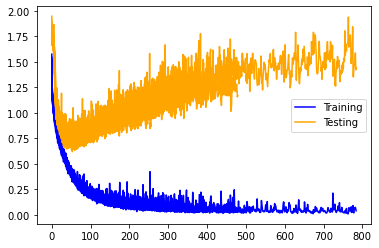

In [18]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

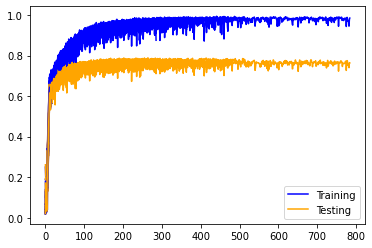

In [19]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

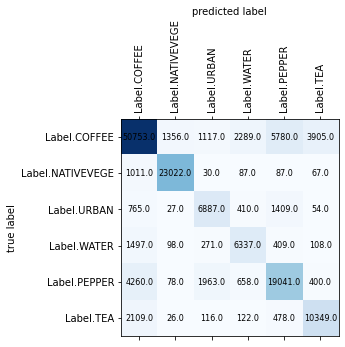

In [20]:
plot_confusion_matrix(conf_matrix, labels)

In [21]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.84035102 0.93558743 0.6632319  0.6399071  0.69993383 0.69535712]
Mean precision:  0.745728067184685

Recalls:  [0.77842025 0.94725148 0.72100084 0.72672018 0.72125    0.78401515]
Mean recall:  0.7797763165264596

F-Score:  [0.80820096 0.94138333 0.69091091 0.6805563  0.71043206 0.73702952]
Mean f-score:  0.7614188475901006


# BLUE, SWIR2, PANCHROMATIC, NDVI, MNDWI

In [8]:
bands = [
    Band.BLUE.value,
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
    Band.NDVI.value,
    Band.MNDWI.value,
]

model_name = "blue_swir2_panchromatic_ndvi_mndwi"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    # Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)), # no need for rescaling
    Input(shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 9, 9, 5)           20        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          1472      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0

KeyboardInterrupt: 

In [23]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.430118323155431
mean accuracy:  0.7524348285982241


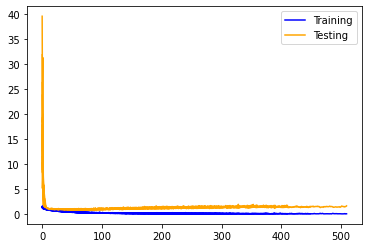

In [24]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

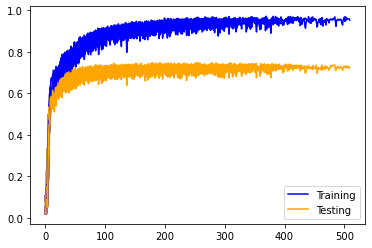

In [25]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

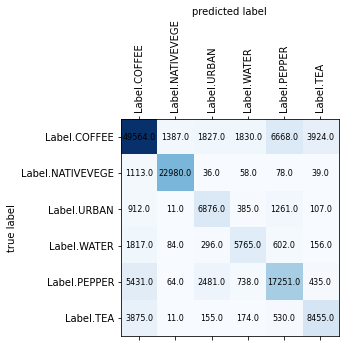

In [26]:
plot_confusion_matrix(conf_matrix, labels)

In [27]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.79034316 0.93654481 0.5891526  0.64413408 0.65369458 0.64463251]
Mean precision:  0.7097502892935131

Recalls:  [0.76018405 0.94552337 0.71984925 0.66112385 0.65344697 0.6405303 ]
Mean recall:  0.730109631981295

F-Score:  [0.77497029 0.94101267 0.64797625 0.65251839 0.65357075 0.64257486]
Mean f-score:  0.7187705370377998


# BLUE, GREEN, RED, NIR, SWIR1, SWIR2, PANCHROMATIC, MNDWI, EVI2, BU

In [9]:
bands = [
    Band.BLUE.value,
    Band.GREEN.value,
    Band.RED.value,
    Band.NIR.value,
    Band.SWIR1.value,
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
    Band.MNDWI.value,
    Band.EVI2.value,
    Band.BU.value,
]

model_name = "blue_green_red_nir_swir1_swir2_panchromatic_mndwi_evi2_bu"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 9, 9, 10)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 10)          40        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 32)          2912      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 64)         

57/57 [==============================] - 0s 8ms/step - loss: 0.1976 - accuracy: 0.8847 - val_loss: 0.7342 - val_accuracy: 0.7750
Epoch 101/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1818 - accuracy: 0.8827 - val_loss: 0.7652 - val_accuracy: 0.7682
Epoch 102/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1733 - accuracy: 0.8874 - val_loss: 0.8734 - val_accuracy: 0.7548
Epoch 103/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2033 - accuracy: 0.8649 - val_loss: 0.7695 - val_accuracy: 0.7852
Epoch 104/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2249 - accuracy: 0.8818 - val_loss: 0.8842 - val_accuracy: 0.7471
Epoch 105/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2214 - accuracy: 0.8760 - val_loss: 0.7640 - val_accuracy: 0.7841
Epoch 106/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1564 - accuracy: 0.9050 - val_loss: 0.8535 - val_accuracy: 0.7693
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1614 - accuracy: 0.9233 - val_loss: 0.8189 - val_accuracy: 0.7949
Epoch 158/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0961 - accuracy: 0.9419 - val_loss: 0.9239 - val_accuracy: 0.7876
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1371 - accuracy: 0.9383 - val_loss: 0.9431 - val_accuracy: 0.7952
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0866 - accuracy: 0.9485 - val_loss: 0.9068 - val_accuracy: 0.7959
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1214 - accuracy: 0.9340 - val_loss: 0.9183 - val_accuracy: 0.7928
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1115 - accuracy: 0.9296 - val_loss: 0.9775 - val_accuracy: 0.7697
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1597 - accuracy: 0.9238 - val_loss: 0.9314 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 0.9502 - val_loss: 1.1055 - val_accuracy: 0.7758
Epoch 215/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1025 - accuracy: 0.9403 - val_loss: 1.0087 - val_accuracy: 0.7872
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0704 - accuracy: 0.9628 - val_loss: 1.1364 - val_accuracy: 0.7573
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0845 - accuracy: 0.9490 - val_loss: 0.9725 - val_accuracy: 0.7910
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0867 - accuracy: 0.9568 - val_loss: 1.0256 - val_accuracy: 0.7990
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1370 - accuracy: 0.9463 - val_loss: 1.0078 - val_accuracy: 0.7862
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0595 - accuracy: 0.9614 - val_loss: 1.1326 - val_accuracy:

Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6509 - accuracy: 0.6819 - val_loss: 0.8050 - val_accuracy: 0.6943
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6676 - accuracy: 0.6846 - val_loss: 0.9779 - val_accuracy: 0.6153
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6761 - accuracy: 0.6670 - val_loss: 0.8912 - val_accuracy: 0.6670
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6404 - accuracy: 0.7152 - val_loss: 0.7767 - val_accuracy: 0.7028
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6292 - accuracy: 0.6975 - val_loss: 0.7952 - val_accuracy: 0.6902
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5584 - accuracy: 0.7242 - val_loss: 0.7422 - val_accuracy: 0.7217
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5814 - accuracy: 0.7313 - val_loss: 0.7845 - val_accuracy: 0.6990

57/57 [==============================] - 0s 8ms/step - loss: 0.1667 - accuracy: 0.9181 - val_loss: 0.9112 - val_accuracy: 0.7622
Epoch 134/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1354 - accuracy: 0.9139 - val_loss: 0.8913 - val_accuracy: 0.7864
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1605 - accuracy: 0.9075 - val_loss: 0.9233 - val_accuracy: 0.7806
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1385 - accuracy: 0.9121 - val_loss: 0.9279 - val_accuracy: 0.7598
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1438 - accuracy: 0.9065 - val_loss: 0.8627 - val_accuracy: 0.7712
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1653 - accuracy: 0.9030 - val_loss: 0.9521 - val_accuracy: 0.7833
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1418 - accuracy: 0.9133 - val_loss: 0.8885 - val_accuracy: 0.7918
Epoch 1

Epoch 190/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1190 - accuracy: 0.9310 - val_loss: 1.0630 - val_accuracy: 0.7856
Epoch 191/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0882 - accuracy: 0.9443 - val_loss: 1.0043 - val_accuracy: 0.7937
Epoch 192/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0762 - accuracy: 0.9536 - val_loss: 1.0453 - val_accuracy: 0.7814
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9442 - val_loss: 1.1293 - val_accuracy: 0.7743
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0949 - accuracy: 0.9374 - val_loss: 1.0782 - val_accuracy: 0.7606
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0866 - accuracy: 0.9388 - val_loss: 1.0197 - val_accuracy: 0.7831
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9343 - val_loss: 1.0529 - val_accuracy:

Epoch 247/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0690 - accuracy: 0.9593 - val_loss: 1.0571 - val_accuracy: 0.7857
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.9686 - val_loss: 1.0905 - val_accuracy: 0.7969
Epoch 249/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0783 - accuracy: 0.9653 - val_loss: 1.1687 - val_accuracy: 0.7846
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0760 - accuracy: 0.9470 - val_loss: 1.1459 - val_accuracy: 0.7928
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.9583 - val_loss: 1.1560 - val_accuracy: 0.8004
Epoch 252/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0543 - accuracy: 0.9656 - val_loss: 1.1582 - val_accuracy: 0.7897
Epoch 253/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0680 - accuracy: 0.9565 - val_loss: 1.1428 - val_accuracy

Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9573 - val_loss: 1.1344 - val_accuracy: 0.7902
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9769 - val_loss: 1.1789 - val_accuracy: 0.8026
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0463 - accuracy: 0.9796 - val_loss: 1.2083 - val_accuracy: 0.7974
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0359 - accuracy: 0.9810 - val_loss: 1.2341 - val_accuracy: 0.7964
Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0357 - accuracy: 0.9818 - val_loss: 1.1652 - val_accuracy: 0.8019
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0450 - accuracy: 0.9691 - val_loss: 1.2973 - val_accuracy: 0.7922
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0643 - accuracy: 0.9695 - val_loss: 1.2946 - val_accuracy:

Epoch 361/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9772 - val_loss: 1.3092 - val_accuracy: 0.8116
Epoch 362/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0423 - accuracy: 0.9788 - val_loss: 1.2928 - val_accuracy: 0.7907

Validation  1 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 10ms/step - loss: 1.6541 - accuracy: 0.2231 - val_loss: 1.8022 - val_accuracy: 0.1132
Epoch 2/2000
57/57 [==============================] - 0s 9ms/step - loss: 1.2182 - accuracy: 0.3801 - val_loss: 1.6944 - val_accuracy: 0.4421
Epoch 3/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1030 - accuracy: 0.4289 - val_loss: 1.8043 - val_accuracy: 0.0911
Epoch 4/2000
57/57 [==============================] - 1s 11ms/step - loss: 1.0451 - accuracy: 0.4499 - val_loss: 1.7126 - val_accuracy: 0.4569
Epoch 5/2000
57/57 [==============================] - 1s 11ms/step - loss: 1.0184 - ac

Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3731 - accuracy: 0.8093 - val_loss: 0.7318 - val_accuracy: 0.7441
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3459 - accuracy: 0.8252 - val_loss: 0.7466 - val_accuracy: 0.7248
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3310 - accuracy: 0.8057 - val_loss: 0.7471 - val_accuracy: 0.7432
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3510 - accuracy: 0.8178 - val_loss: 0.7643 - val_accuracy: 0.7260
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2879 - accuracy: 0.8342 - val_loss: 0.7273 - val_accuracy: 0.7496
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3948 - accuracy: 0.8148 - val_loss: 0.7407 - val_accuracy: 0.7427
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3253 - accuracy: 0.8223 - val_loss: 0.7125 - val_accuracy: 0.7450

Epoch 170/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1198 - accuracy: 0.9518 - val_loss: 1.0541 - val_accuracy: 0.7796
Epoch 171/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1514 - accuracy: 0.9165 - val_loss: 1.0705 - val_accuracy: 0.7697
Epoch 172/2000
57/57 [==============================] - 1s 15ms/step - loss: 0.1264 - accuracy: 0.9311 - val_loss: 0.9522 - val_accuracy: 0.7864
Epoch 173/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0951 - accuracy: 0.9514 - val_loss: 1.0607 - val_accuracy: 0.7559
Epoch 174/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0909 - accuracy: 0.9368 - val_loss: 1.0028 - val_accuracy: 0.7812
Epoch 175/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1354 - accuracy: 0.9259 - val_loss: 0.9471 - val_accuracy: 0.7808
Epoch 176/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1013 - accuracy: 0.9490 - val_loss: 1.0080 - val_ac

Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0991 - accuracy: 0.9551 - val_loss: 1.1571 - val_accuracy: 0.7741
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.9520 - val_loss: 1.0869 - val_accuracy: 0.7747
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.9593 - val_loss: 1.1416 - val_accuracy: 0.7814
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0855 - accuracy: 0.9432 - val_loss: 1.0613 - val_accuracy: 0.7859
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0740 - accuracy: 0.9499 - val_loss: 1.1130 - val_accuracy: 0.7882
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0774 - accuracy: 0.9477 - val_loss: 1.0652 - val_accuracy: 0.7872
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.9742 - val_loss: 1.0774 - val_accuracy:


Validation  1 , fold  4 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6269 - accuracy: 0.1810 - val_loss: 1.8388 - val_accuracy: 0.0654
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2437 - accuracy: 0.3400 - val_loss: 1.8582 - val_accuracy: 0.1129
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2075 - accuracy: 0.3592 - val_loss: 1.7278 - val_accuracy: 0.0946
Epoch 4/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1000 - accuracy: 0.4198 - val_loss: 1.7139 - val_accuracy: 0.3313
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0743 - accuracy: 0.3974 - val_loss: 1.7462 - val_accuracy: 0.0968
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9835 - accuracy: 0.4296 - val_loss: 1.6412 - val_accuracy: 0.4481
Epoch 7/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9913 - accuracy:

Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3205 - accuracy: 0.8108 - val_loss: 0.7217 - val_accuracy: 0.7567
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3199 - accuracy: 0.7890 - val_loss: 0.8888 - val_accuracy: 0.7063
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3280 - accuracy: 0.7793 - val_loss: 0.8254 - val_accuracy: 0.7124
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3334 - accuracy: 0.7944 - val_loss: 0.8246 - val_accuracy: 0.7149
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3151 - accuracy: 0.8168 - val_loss: 0.7895 - val_accuracy: 0.7256
Epoch 63/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3305 - accuracy: 0.8017 - val_loss: 0.7152 - val_accuracy: 0.7449
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3654 - accuracy: 0.8024 - val_loss: 0.7657 - val_accuracy: 0.7457

Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1330 - accuracy: 0.9146 - val_loss: 0.8733 - val_accuracy: 0.7935
Epoch 173/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0904 - accuracy: 0.9351 - val_loss: 0.9160 - val_accuracy: 0.7964
Epoch 174/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1045 - accuracy: 0.9217 - val_loss: 0.9056 - val_accuracy: 0.8032
Epoch 175/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0841 - accuracy: 0.9427 - val_loss: 1.0230 - val_accuracy: 0.7819
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0930 - accuracy: 0.9397 - val_loss: 0.9674 - val_accuracy: 0.8001
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9607 - val_loss: 1.0086 - val_accuracy: 0.7784
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1991 - accuracy: 0.8831 - val_loss: 1.1910 - val_accuracy

Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0989 - accuracy: 0.9364 - val_loss: 1.0539 - val_accuracy: 0.8009
Epoch 230/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0590 - accuracy: 0.9668 - val_loss: 1.0569 - val_accuracy: 0.7963
Epoch 231/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0564 - accuracy: 0.9584 - val_loss: 1.0650 - val_accuracy: 0.8110
Epoch 232/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0436 - accuracy: 0.9800 - val_loss: 1.2390 - val_accuracy: 0.7988
Epoch 233/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1269 - accuracy: 0.9477 - val_loss: 1.2047 - val_accuracy: 0.7837
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1160 - accuracy: 0.9426 - val_loss: 1.1429 - val_accuracy: 0.7823
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0872 - accuracy: 0.9476 - val_loss: 1.1110 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1212 - accuracy: 0.9427 - val_loss: 1.1203 - val_accuracy: 0.7781
Epoch 287/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0971 - accuracy: 0.9415 - val_loss: 1.1551 - val_accuracy: 0.7728
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9493 - val_loss: 1.1206 - val_accuracy: 0.7989
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9640 - val_loss: 1.1776 - val_accuracy: 0.7875
Epoch 290/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0615 - accuracy: 0.9602 - val_loss: 1.0412 - val_accuracy: 0.8015
Epoch 291/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0475 - accuracy: 0.9672 - val_loss: 1.0730 - val_accuracy: 0.8045
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0437 - accuracy: 0.9742 - val_loss: 1.1201 - val_accuracy

Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1090 - accuracy: 0.9531 - val_loss: 1.2574 - val_accuracy: 0.7960
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0746 - accuracy: 0.9579 - val_loss: 1.1624 - val_accuracy: 0.7970
Epoch 345/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0517 - accuracy: 0.9671 - val_loss: 1.1267 - val_accuracy: 0.7918
Epoch 346/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0686 - accuracy: 0.9644 - val_loss: 1.2127 - val_accuracy: 0.8011
Epoch 347/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0452 - accuracy: 0.9667 - val_loss: 1.2808 - val_accuracy: 0.7922
Epoch 348/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0604 - accuracy: 0.9676 - val_loss: 1.2271 - val_accuracy: 0.7912
Epoch 349/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0515 - accuracy: 0.9624 - val_loss: 1.2543 - val_accurac

57/57 [==============================] - 0s 8ms/step - loss: 0.3582 - accuracy: 0.8267 - val_loss: 0.8027 - val_accuracy: 0.7074
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3715 - accuracy: 0.8017 - val_loss: 0.6925 - val_accuracy: 0.7665
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3450 - accuracy: 0.8233 - val_loss: 0.7630 - val_accuracy: 0.7476
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3393 - accuracy: 0.8159 - val_loss: 0.8695 - val_accuracy: 0.6933
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4158 - accuracy: 0.7843 - val_loss: 0.7156 - val_accuracy: 0.7534
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3509 - accuracy: 0.8245 - val_loss: 0.6979 - val_accuracy: 0.7582
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3165 - accuracy: 0.8408 - val_loss: 0.7502 - val_accuracy: 0.7324
Epoch 67/2000

Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1485 - accuracy: 0.9155 - val_loss: 0.9234 - val_accuracy: 0.7707
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1682 - accuracy: 0.8982 - val_loss: 0.9339 - val_accuracy: 0.7829
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1487 - accuracy: 0.9116 - val_loss: 0.8985 - val_accuracy: 0.7846
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1097 - accuracy: 0.9351 - val_loss: 1.0269 - val_accuracy: 0.7488
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1160 - accuracy: 0.9299 - val_loss: 0.9316 - val_accuracy: 0.7842
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9410 - val_loss: 0.9535 - val_accuracy: 0.7925
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0947 - accuracy: 0.9424 - val_loss: 0.9773 - val_accuracy:

Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0861 - accuracy: 0.9578 - val_loss: 1.1104 - val_accuracy: 0.7671
Epoch 232/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0813 - accuracy: 0.9508 - val_loss: 1.0550 - val_accuracy: 0.7852
Epoch 233/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0517 - accuracy: 0.9697 - val_loss: 1.1238 - val_accuracy: 0.7924
Epoch 234/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0691 - accuracy: 0.9612 - val_loss: 1.0723 - val_accuracy: 0.7888
Epoch 235/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0641 - accuracy: 0.9670 - val_loss: 1.0875 - val_accuracy: 0.7959
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.9469 - val_loss: 1.0592 - val_accuracy: 0.7986
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1227 - accuracy: 0.9378 - val_loss: 1.1468 - val_accuracy:

Epoch 288/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0849 - accuracy: 0.9523 - val_loss: 1.0581 - val_accuracy: 0.7871
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0709 - accuracy: 0.9535 - val_loss: 1.1624 - val_accuracy: 0.7831
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0550 - accuracy: 0.9654 - val_loss: 1.1258 - val_accuracy: 0.7956
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0539 - accuracy: 0.9690 - val_loss: 1.2175 - val_accuracy: 0.7924
Epoch 292/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0736 - accuracy: 0.9638 - val_loss: 1.2414 - val_accuracy: 0.7761
Epoch 293/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0362 - accuracy: 0.9757 - val_loss: 1.2410 - val_accuracy: 0.7963
Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3201 - accuracy: 0.9054 - val_loss: 0.9937 - val_accuracy:

Epoch 345/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0441 - accuracy: 0.9729 - val_loss: 1.1200 - val_accuracy: 0.7936
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0492 - accuracy: 0.9764 - val_loss: 1.2645 - val_accuracy: 0.7983
Epoch 347/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0690 - accuracy: 0.9634 - val_loss: 1.2154 - val_accuracy: 0.7997
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9752 - val_loss: 1.2502 - val_accuracy: 0.7831
Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9792 - val_loss: 1.2055 - val_accuracy: 0.7926
Epoch 350/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0594 - accuracy: 0.9702 - val_loss: 1.2487 - val_accuracy: 0.7860
Epoch 351/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1106 - accuracy: 0.9452 - val_loss: 1.1811 - val_accuracy:

Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.9759 - val_loss: 1.1512 - val_accuracy: 0.7845
Epoch 403/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0558 - accuracy: 0.9713 - val_loss: 1.2400 - val_accuracy: 0.7785
Epoch 404/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1243 - accuracy: 0.9392 - val_loss: 1.2975 - val_accuracy: 0.7739
Epoch 405/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1047 - accuracy: 0.9442 - val_loss: 1.1008 - val_accuracy: 0.7836
Epoch 406/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0420 - accuracy: 0.9776 - val_loss: 1.1776 - val_accuracy: 0.7960
Epoch 407/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0429 - accuracy: 0.9706 - val_loss: 1.1371 - val_accuracy: 0.7964
Epoch 408/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0378 - accuracy: 0.9842 - val_loss: 1.1243 - val_accuracy:

Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5493 - accuracy: 0.7315 - val_loss: 0.8468 - val_accuracy: 0.6764
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5222 - accuracy: 0.7200 - val_loss: 0.7668 - val_accuracy: 0.7005
Epoch 35/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4994 - accuracy: 0.7557 - val_loss: 0.7907 - val_accuracy: 0.6930
Epoch 36/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5162 - accuracy: 0.7435 - val_loss: 0.7650 - val_accuracy: 0.7082
Epoch 37/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4892 - accuracy: 0.7603 - val_loss: 0.7742 - val_accuracy: 0.7129
Epoch 38/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5074 - accuracy: 0.7496 - val_loss: 0.9213 - val_accuracy: 0.6405
Epoch 39/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5072 - accuracy: 0.7443 - val_loss: 0.8146 - val_accuracy: 0.6903

57/57 [==============================] - 1s 10ms/step - loss: 0.0981 - accuracy: 0.9409 - val_loss: 1.0311 - val_accuracy: 0.7894
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1129 - accuracy: 0.9300 - val_loss: 0.9831 - val_accuracy: 0.7788
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1425 - accuracy: 0.9176 - val_loss: 0.9539 - val_accuracy: 0.7759
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1725 - accuracy: 0.9072 - val_loss: 0.9699 - val_accuracy: 0.7841
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1264 - accuracy: 0.9149 - val_loss: 0.8979 - val_accuracy: 0.7976
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.9224 - val_loss: 0.9562 - val_accuracy: 0.7819
Epoch 153/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1713 - accuracy: 0.9178 - val_loss: 1.0039 - val_accuracy: 0.7560
Epoch

Epoch 204/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1006 - accuracy: 0.9434 - val_loss: 1.0510 - val_accuracy: 0.7748
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0976 - accuracy: 0.9511 - val_loss: 1.0464 - val_accuracy: 0.7781
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0775 - accuracy: 0.9486 - val_loss: 1.0832 - val_accuracy: 0.7548
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1249 - accuracy: 0.9196 - val_loss: 1.0193 - val_accuracy: 0.7891
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0870 - accuracy: 0.9459 - val_loss: 0.9855 - val_accuracy: 0.8014
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1059 - accuracy: 0.9469 - val_loss: 1.0649 - val_accuracy: 0.7752
Epoch 210/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.1223 - accuracy: 0.9304 - val_loss: 1.0056 - val_accuracy

Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1253 - accuracy: 0.9480 - val_loss: 1.1114 - val_accuracy: 0.7736
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1206 - accuracy: 0.9329 - val_loss: 1.0260 - val_accuracy: 0.7919
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9494 - val_loss: 1.1347 - val_accuracy: 0.7751
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0712 - accuracy: 0.9499 - val_loss: 1.2154 - val_accuracy: 0.7815
Epoch 265/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0693 - accuracy: 0.9575 - val_loss: 1.0985 - val_accuracy: 0.8082
Epoch 266/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0732 - accuracy: 0.9574 - val_loss: 1.1153 - val_accuracy: 0.7907
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0623 - accuracy: 0.9691 - val_loss: 1.1414 - val_accuracy:

Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0341 - accuracy: 0.9860 - val_loss: 1.1473 - val_accuracy: 0.7983
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9778 - val_loss: 1.2150 - val_accuracy: 0.8021
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0403 - accuracy: 0.9755 - val_loss: 1.2034 - val_accuracy: 0.8029
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0571 - accuracy: 0.9765 - val_loss: 1.2142 - val_accuracy: 0.7968
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9637 - val_loss: 1.1609 - val_accuracy: 0.7999
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0465 - accuracy: 0.9698 - val_loss: 1.2148 - val_accuracy: 0.7960
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.9657 - val_loss: 1.3956 - val_accuracy:

Epoch 375/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0460 - accuracy: 0.9763 - val_loss: 1.4475 - val_accuracy: 0.7849
Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0717 - accuracy: 0.9696 - val_loss: 1.2902 - val_accuracy: 0.7823
Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0519 - accuracy: 0.9726 - val_loss: 1.2036 - val_accuracy: 0.7841
Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0438 - accuracy: 0.9714 - val_loss: 1.1719 - val_accuracy: 0.8069
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.9876 - val_loss: 1.2091 - val_accuracy: 0.7876
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1051 - accuracy: 0.9488 - val_loss: 1.2389 - val_accuracy: 0.7903
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0483 - accuracy: 0.9694 - val_loss: 1.2360 - val_accuracy:

Epoch 432/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0305 - accuracy: 0.9873 - val_loss: 1.3672 - val_accuracy: 0.7831
Epoch 433/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 0.9795 - val_loss: 1.2876 - val_accuracy: 0.8059
Epoch 434/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9839 - val_loss: 1.3801 - val_accuracy: 0.8017
Epoch 435/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0318 - accuracy: 0.9822 - val_loss: 1.3568 - val_accuracy: 0.7847
Epoch 436/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0509 - accuracy: 0.9697 - val_loss: 1.2431 - val_accuracy: 0.8021
Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0388 - accuracy: 0.9808 - val_loss: 1.2657 - val_accuracy: 0.7998
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0670 - accuracy: 0.9696 - val_loss: 1.3228 - val_accuracy:

Epoch 489/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0263 - accuracy: 0.9893 - val_loss: 1.4847 - val_accuracy: 0.8050
Epoch 490/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0354 - accuracy: 0.9830 - val_loss: 1.4428 - val_accuracy: 0.8020
Epoch 491/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0580 - accuracy: 0.9773 - val_loss: 1.4352 - val_accuracy: 0.7902
Epoch 492/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1220 - accuracy: 0.9593 - val_loss: 1.4109 - val_accuracy: 0.7725
Epoch 493/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1211 - accuracy: 0.9353 - val_loss: 1.3252 - val_accuracy: 0.7599
Epoch 494/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0543 - accuracy: 0.9649 - val_loss: 1.2364 - val_accuracy: 0.7987
Epoch 495/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0383 - accuracy: 0.9810 - val_loss: 1.3109 - val_accurac

Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5060 - accuracy: 0.7286 - val_loss: 0.8163 - val_accuracy: 0.6945
Epoch 33/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4925 - accuracy: 0.7437 - val_loss: 0.7675 - val_accuracy: 0.7149
Epoch 34/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4927 - accuracy: 0.7433 - val_loss: 0.7913 - val_accuracy: 0.7002
Epoch 35/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4886 - accuracy: 0.7230 - val_loss: 0.8533 - val_accuracy: 0.6705
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5084 - accuracy: 0.6951 - val_loss: 0.8362 - val_accuracy: 0.6891
Epoch 37/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.5226 - accuracy: 0.7202 - val_loss: 0.7278 - val_accuracy: 0.7180
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4325 - accuracy: 0.7636 - val_loss: 0.8772 - val_accuracy: 0.671

57/57 [==============================] - 0s 8ms/step - loss: 0.1240 - accuracy: 0.9266 - val_loss: 0.9906 - val_accuracy: 0.7693
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1203 - accuracy: 0.9342 - val_loss: 0.9529 - val_accuracy: 0.7955
Epoch 148/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1308 - accuracy: 0.9157 - val_loss: 0.8676 - val_accuracy: 0.7959
Epoch 149/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1176 - accuracy: 0.9343 - val_loss: 0.9120 - val_accuracy: 0.7788
Epoch 150/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1468 - accuracy: 0.9036 - val_loss: 0.9812 - val_accuracy: 0.7675
Epoch 151/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1451 - accuracy: 0.9039 - val_loss: 0.9526 - val_accuracy: 0.7697
Epoch 152/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1119 - accuracy: 0.9375 - val_loss: 0.9907 - val_accuracy: 0.7386
Epoch 1

Epoch 203/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1490 - accuracy: 0.9311 - val_loss: 1.1591 - val_accuracy: 0.7422
Epoch 204/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1243 - accuracy: 0.9247 - val_loss: 1.0299 - val_accuracy: 0.7917
Epoch 205/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1422 - accuracy: 0.9346 - val_loss: 1.0472 - val_accuracy: 0.7688
Epoch 206/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0969 - accuracy: 0.9358 - val_loss: 0.9926 - val_accuracy: 0.7857
Epoch 207/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0922 - accuracy: 0.9555 - val_loss: 1.0862 - val_accuracy: 0.7757
Epoch 208/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1545 - accuracy: 0.9314 - val_loss: 1.0221 - val_accuracy: 0.7878
Epoch 209/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1016 - accuracy: 0.9433 - val_loss: 0.9877 - val_acc

Epoch 260/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0403 - accuracy: 0.9686 - val_loss: 1.1068 - val_accuracy: 0.7989
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0647 - accuracy: 0.9590 - val_loss: 1.1804 - val_accuracy: 0.7785
Epoch 262/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0902 - accuracy: 0.9514 - val_loss: 1.1301 - val_accuracy: 0.7876
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0715 - accuracy: 0.9551 - val_loss: 1.0793 - val_accuracy: 0.7952
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0547 - accuracy: 0.9668 - val_loss: 1.1529 - val_accuracy: 0.8000
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0468 - accuracy: 0.9746 - val_loss: 1.2148 - val_accuracy: 0.7659
Epoch 266/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0803 - accuracy: 0.9495 - val_loss: 1.1919 - val_accuracy:

57/57 [==============================] - 1s 9ms/step - loss: 0.2879 - accuracy: 0.8437 - val_loss: 0.7167 - val_accuracy: 0.7656
Epoch 76/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2912 - accuracy: 0.8323 - val_loss: 0.7350 - val_accuracy: 0.7621
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2629 - accuracy: 0.8570 - val_loss: 0.6897 - val_accuracy: 0.7682
Epoch 78/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2907 - accuracy: 0.8383 - val_loss: 0.7173 - val_accuracy: 0.7703
Epoch 79/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2354 - accuracy: 0.8634 - val_loss: 0.7579 - val_accuracy: 0.7484
Epoch 80/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2864 - accuracy: 0.8351 - val_loss: 0.7646 - val_accuracy: 0.7519
Epoch 81/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2763 - accuracy: 0.8297 - val_loss: 0.7462 - val_accuracy: 0.7663
Epoch 82/2000

57/57 [==============================] - 1s 11ms/step - loss: 0.1948 - accuracy: 0.9148 - val_loss: 0.7917 - val_accuracy: 0.7864
Epoch 133/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1174 - accuracy: 0.9383 - val_loss: 0.8674 - val_accuracy: 0.7842
Epoch 134/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1165 - accuracy: 0.9295 - val_loss: 0.8733 - val_accuracy: 0.7772
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1414 - accuracy: 0.9195 - val_loss: 0.8414 - val_accuracy: 0.7893
Epoch 136/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1194 - accuracy: 0.9251 - val_loss: 0.8470 - val_accuracy: 0.7827
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1229 - accuracy: 0.9299 - val_loss: 0.8650 - val_accuracy: 0.8002
Epoch 138/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1524 - accuracy: 0.9258 - val_loss: 0.8537 - val_accuracy: 0.7817
Epoch 

Epoch 189/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0805 - accuracy: 0.9575 - val_loss: 0.9399 - val_accuracy: 0.7936
Epoch 190/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0809 - accuracy: 0.9472 - val_loss: 0.9792 - val_accuracy: 0.7791
Epoch 191/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0904 - accuracy: 0.9391 - val_loss: 1.2512 - val_accuracy: 0.7489
Epoch 192/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1500 - accuracy: 0.9161 - val_loss: 0.9643 - val_accuracy: 0.7808
Epoch 193/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0930 - accuracy: 0.9431 - val_loss: 1.0421 - val_accuracy: 0.7754
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1214 - accuracy: 0.9365 - val_loss: 0.8649 - val_accuracy: 0.7928
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1175 - accuracy: 0.9329 - val_loss: 0.9551 - val_accurac

Epoch 27/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.6815 - accuracy: 0.7102 - val_loss: 0.8592 - val_accuracy: 0.6799
Epoch 28/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6071 - accuracy: 0.7337 - val_loss: 0.9875 - val_accuracy: 0.6210
Epoch 29/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.6425 - accuracy: 0.6872 - val_loss: 0.7334 - val_accuracy: 0.7374
Epoch 30/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5799 - accuracy: 0.7277 - val_loss: 0.7799 - val_accuracy: 0.7295
Epoch 31/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.6116 - accuracy: 0.7100 - val_loss: 0.7421 - val_accuracy: 0.7248
Epoch 32/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5804 - accuracy: 0.7400 - val_loss: 0.9522 - val_accuracy: 0.6586
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6007 - accuracy: 0.6935 - val_loss: 0.7461 - val_accuracy: 0.7

Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1815 - accuracy: 0.9078 - val_loss: 0.9622 - val_accuracy: 0.7765
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1954 - accuracy: 0.9016 - val_loss: 1.0099 - val_accuracy: 0.7419
Epoch 143/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1907 - accuracy: 0.8816 - val_loss: 0.9065 - val_accuracy: 0.7731
Epoch 144/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1429 - accuracy: 0.9131 - val_loss: 0.8863 - val_accuracy: 0.7859
Epoch 145/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1461 - accuracy: 0.9078 - val_loss: 0.9229 - val_accuracy: 0.7936
Epoch 146/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1392 - accuracy: 0.9136 - val_loss: 0.9666 - val_accuracy: 0.7773
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1349 - accuracy: 0.9214 - val_loss: 0.9434 - val_accuracy:

Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1778 - accuracy: 0.9088 - val_loss: 1.0153 - val_accuracy: 0.7798
Epoch 199/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0801 - accuracy: 0.9534 - val_loss: 1.0485 - val_accuracy: 0.7722
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1201 - accuracy: 0.9243 - val_loss: 1.1797 - val_accuracy: 0.7789
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1618 - accuracy: 0.9185 - val_loss: 1.0267 - val_accuracy: 0.7712
Epoch 202/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1194 - accuracy: 0.9267 - val_loss: 1.0058 - val_accuracy: 0.7864
Epoch 203/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1236 - accuracy: 0.9368 - val_loss: 1.0117 - val_accuracy: 0.7777
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0986 - accuracy: 0.9485 - val_loss: 1.0459 - val_accuracy

Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.9621 - val_loss: 1.1436 - val_accuracy: 0.7840
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0755 - accuracy: 0.9533 - val_loss: 1.2669 - val_accuracy: 0.7628
Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2219 - accuracy: 0.9123 - val_loss: 1.1241 - val_accuracy: 0.7808
Epoch 258/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0937 - accuracy: 0.9462 - val_loss: 1.1389 - val_accuracy: 0.7848
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9554 - val_loss: 1.1687 - val_accuracy: 0.7704
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0753 - accuracy: 0.9575 - val_loss: 1.1608 - val_accuracy: 0.7875
Epoch 261/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1163 - accuracy: 0.9366 - val_loss: 1.1095 - val_accuracy:

Epoch 312/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0554 - accuracy: 0.9615 - val_loss: 1.1883 - val_accuracy: 0.7917
Epoch 313/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0327 - accuracy: 0.9805 - val_loss: 1.2199 - val_accuracy: 0.7989
Epoch 314/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0430 - accuracy: 0.9787 - val_loss: 1.2465 - val_accuracy: 0.7859
Epoch 315/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0485 - accuracy: 0.9717 - val_loss: 1.3404 - val_accuracy: 0.7665
Epoch 316/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0512 - accuracy: 0.9744 - val_loss: 1.3165 - val_accuracy: 0.7913
Epoch 317/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0495 - accuracy: 0.9685 - val_loss: 1.2710 - val_accuracy: 0.7954
Epoch 318/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0370 - accuracy: 0.9778 - val_loss: 1.3861 - val_accurac

Epoch 369/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0729 - accuracy: 0.9601 - val_loss: 1.1735 - val_accuracy: 0.7922
Epoch 370/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0710 - accuracy: 0.9669 - val_loss: 1.2183 - val_accuracy: 0.7867
Epoch 371/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0467 - accuracy: 0.9685 - val_loss: 1.3672 - val_accuracy: 0.7537
Epoch 372/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0799 - accuracy: 0.9526 - val_loss: 1.2246 - val_accuracy: 0.7947
Epoch 373/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0660 - accuracy: 0.9645 - val_loss: 1.2005 - val_accuracy: 0.7899
Epoch 374/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0557 - accuracy: 0.9661 - val_loss: 1.2310 - val_accuracy: 0.7940
Epoch 375/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0375 - accuracy: 0.9780 - val_loss: 1.3069 - val_accuracy:

Epoch 426/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.9714 - val_loss: 1.4557 - val_accuracy: 0.7926
Epoch 427/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9776 - val_loss: 1.5525 - val_accuracy: 0.8039
Epoch 428/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0387 - accuracy: 0.9821 - val_loss: 1.4063 - val_accuracy: 0.7803
Epoch 429/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0217 - accuracy: 0.9849 - val_loss: 1.4063 - val_accuracy: 0.7967
Epoch 430/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0529 - accuracy: 0.9724 - val_loss: 1.4949 - val_accuracy: 0.7817
Epoch 431/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0702 - accuracy: 0.9674 - val_loss: 1.4597 - val_accuracy: 0.7918
Epoch 432/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0994 - accuracy: 0.9546 - val_loss: 1.2930 - val_accuracy:

Epoch 48/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3821 - accuracy: 0.8028 - val_loss: 0.8657 - val_accuracy: 0.6681
Epoch 49/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4742 - accuracy: 0.7385 - val_loss: 0.7500 - val_accuracy: 0.7279
Epoch 50/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3854 - accuracy: 0.7994 - val_loss: 0.6967 - val_accuracy: 0.7396
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 0.8019 - val_loss: 0.8066 - val_accuracy: 0.7036
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4211 - accuracy: 0.7838 - val_loss: 0.7459 - val_accuracy: 0.7340
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3592 - accuracy: 0.8232 - val_loss: 0.7087 - val_accuracy: 0.7381
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3693 - accuracy: 0.7953 - val_loss: 0.7687 - val_accuracy: 0.7407

Epoch 162/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1212 - accuracy: 0.9373 - val_loss: 0.9132 - val_accuracy: 0.7784
Epoch 163/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1243 - accuracy: 0.9471 - val_loss: 0.8958 - val_accuracy: 0.7948
Epoch 164/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.1019 - accuracy: 0.9461 - val_loss: 0.9095 - val_accuracy: 0.8024
Epoch 165/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0861 - accuracy: 0.9508 - val_loss: 0.9122 - val_accuracy: 0.7901
Epoch 166/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0797 - accuracy: 0.9479 - val_loss: 0.8623 - val_accuracy: 0.8039
Epoch 167/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.1073 - accuracy: 0.9461 - val_loss: 0.8582 - val_accuracy: 0.8036
Epoch 168/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0921 - accuracy: 0.9467 - val_loss: 0.8968 - val_ac

Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0931 - accuracy: 0.9485 - val_loss: 1.1081 - val_accuracy: 0.7917
Epoch 276/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0600 - accuracy: 0.9689 - val_loss: 1.1362 - val_accuracy: 0.7916
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0689 - accuracy: 0.9572 - val_loss: 1.1240 - val_accuracy: 0.7996
Epoch 278/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0607 - accuracy: 0.9654 - val_loss: 1.1424 - val_accuracy: 0.7817
Epoch 279/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0586 - accuracy: 0.9610 - val_loss: 1.0496 - val_accuracy: 0.7876
Epoch 280/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0878 - accuracy: 0.9628 - val_loss: 1.2126 - val_accuracy: 0.7719
Epoch 281/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0826 - accuracy: 0.9482 - val_loss: 1.1004 - val_accuracy:

Epoch 19/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.7502 - accuracy: 0.6543 - val_loss: 0.9053 - val_accuracy: 0.6680
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7634 - accuracy: 0.6474 - val_loss: 0.9083 - val_accuracy: 0.6648
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7114 - accuracy: 0.6432 - val_loss: 0.8738 - val_accuracy: 0.6842
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7365 - accuracy: 0.6844 - val_loss: 0.9987 - val_accuracy: 0.6293
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6620 - accuracy: 0.6641 - val_loss: 0.9258 - val_accuracy: 0.6489
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6752 - accuracy: 0.6760 - val_loss: 0.8236 - val_accuracy: 0.6794
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6735 - accuracy: 0.6748 - val_loss: 0.8154 - val_accuracy: 0.702

57/57 [==============================] - 0s 9ms/step - loss: 0.1491 - accuracy: 0.9144 - val_loss: 0.9396 - val_accuracy: 0.7739
Epoch 134/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1494 - accuracy: 0.9193 - val_loss: 0.8781 - val_accuracy: 0.7971
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1640 - accuracy: 0.9136 - val_loss: 0.9828 - val_accuracy: 0.7828
Epoch 136/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1222 - accuracy: 0.9289 - val_loss: 1.0586 - val_accuracy: 0.7420
Epoch 137/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2069 - accuracy: 0.8862 - val_loss: 0.8785 - val_accuracy: 0.7808
Epoch 138/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1747 - accuracy: 0.8879 - val_loss: 0.8481 - val_accuracy: 0.7866
Epoch 139/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1266 - accuracy: 0.9242 - val_loss: 0.8710 - val_accuracy: 0.7990
Epoch 1

Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1662 - accuracy: 0.9166 - val_loss: 1.1988 - val_accuracy: 0.7675
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0795 - accuracy: 0.9460 - val_loss: 1.1116 - val_accuracy: 0.7895
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0915 - accuracy: 0.9434 - val_loss: 1.0581 - val_accuracy: 0.7951
Epoch 193/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1264 - accuracy: 0.9283 - val_loss: 1.1174 - val_accuracy: 0.7805
Epoch 194/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1228 - accuracy: 0.9296 - val_loss: 1.0319 - val_accuracy: 0.7871
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0852 - accuracy: 0.9499 - val_loss: 1.0411 - val_accuracy: 0.7823
Epoch 196/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0904 - accuracy: 0.9484 - val_loss: 1.1293 - val_accuracy:

Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1809 - accuracy: 0.9256 - val_loss: 1.1799 - val_accuracy: 0.7883
Epoch 248/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1166 - accuracy: 0.9473 - val_loss: 1.0881 - val_accuracy: 0.7751
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1570 - accuracy: 0.9428 - val_loss: 1.0797 - val_accuracy: 0.8020
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0657 - accuracy: 0.9575 - val_loss: 1.1444 - val_accuracy: 0.7861
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.9671 - val_loss: 1.2272 - val_accuracy: 0.7976
Epoch 252/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0797 - accuracy: 0.9654 - val_loss: 1.1521 - val_accuracy: 0.7960
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0815 - accuracy: 0.9511 - val_loss: 1.2321 - val_accuracy:

Epoch 304/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0803 - accuracy: 0.9598 - val_loss: 1.1894 - val_accuracy: 0.7739
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1423 - accuracy: 0.9190 - val_loss: 1.1740 - val_accuracy: 0.7625
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.9512 - val_loss: 1.1175 - val_accuracy: 0.7837
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9634 - val_loss: 1.1687 - val_accuracy: 0.7888
Epoch 308/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0638 - accuracy: 0.9647 - val_loss: 1.1671 - val_accuracy: 0.8006
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0767 - accuracy: 0.9660 - val_loss: 1.2453 - val_accuracy: 0.7842
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0804 - accuracy: 0.9520 - val_loss: 1.1607 - val_accuracy:

Epoch 361/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0421 - accuracy: 0.9697 - val_loss: 1.2040 - val_accuracy: 0.8021
Epoch 362/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0499 - accuracy: 0.9730 - val_loss: 1.2848 - val_accuracy: 0.7932
Epoch 363/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0458 - accuracy: 0.9764 - val_loss: 1.2711 - val_accuracy: 0.7979
Epoch 364/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0329 - accuracy: 0.9804 - val_loss: 1.4087 - val_accuracy: 0.7830
Epoch 365/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0954 - accuracy: 0.9439 - val_loss: 1.2135 - val_accuracy: 0.7945
Epoch 366/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0391 - accuracy: 0.9774 - val_loss: 1.2398 - val_accuracy: 0.7873
Epoch 367/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0666 - accuracy: 0.9599 - val_loss: 1.2982 - val_accuracy:

Epoch 49/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4314 - accuracy: 0.7707 - val_loss: 0.6605 - val_accuracy: 0.7669
Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4205 - accuracy: 0.7723 - val_loss: 0.8442 - val_accuracy: 0.6678
Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4899 - accuracy: 0.7365 - val_loss: 0.7009 - val_accuracy: 0.7358
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3920 - accuracy: 0.7737 - val_loss: 0.6987 - val_accuracy: 0.7533
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3951 - accuracy: 0.7987 - val_loss: 0.7360 - val_accuracy: 0.7218
Epoch 54/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4146 - accuracy: 0.7768 - val_loss: 0.7469 - val_accuracy: 0.7285
Epoch 55/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3936 - accuracy: 0.7692 - val_loss: 0.7767 - val_accuracy: 0.7158

Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1003 - accuracy: 0.9393 - val_loss: 0.8657 - val_accuracy: 0.8080
Epoch 164/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0831 - accuracy: 0.9489 - val_loss: 1.0018 - val_accuracy: 0.7773
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1083 - accuracy: 0.9352 - val_loss: 0.8626 - val_accuracy: 0.7879
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1325 - accuracy: 0.9357 - val_loss: 0.8917 - val_accuracy: 0.7842
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0966 - accuracy: 0.9428 - val_loss: 0.9990 - val_accuracy: 0.7912
Epoch 168/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1258 - accuracy: 0.9312 - val_loss: 0.9812 - val_accuracy: 0.7632
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2132 - accuracy: 0.8896 - val_loss: 0.8370 - val_accuracy:

Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0801 - accuracy: 0.9484 - val_loss: 1.0594 - val_accuracy: 0.7542
Epoch 221/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1314 - accuracy: 0.9153 - val_loss: 1.0722 - val_accuracy: 0.7663
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1248 - accuracy: 0.9338 - val_loss: 0.9215 - val_accuracy: 0.7988
Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0882 - accuracy: 0.9433 - val_loss: 1.0910 - val_accuracy: 0.7731
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1257 - accuracy: 0.9339 - val_loss: 0.9325 - val_accuracy: 0.7981
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0870 - accuracy: 0.9537 - val_loss: 0.9178 - val_accuracy: 0.8024
Epoch 226/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0627 - accuracy: 0.9579 - val_loss: 1.0543 - val_accuracy:

Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9550 - val_loss: 1.0690 - val_accuracy: 0.7926
Epoch 278/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0624 - accuracy: 0.9589 - val_loss: 1.0541 - val_accuracy: 0.8019
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0528 - accuracy: 0.9754 - val_loss: 1.0928 - val_accuracy: 0.8059
Epoch 280/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0819 - accuracy: 0.9640 - val_loss: 0.9951 - val_accuracy: 0.8039
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9664 - val_loss: 0.9871 - val_accuracy: 0.8102
Epoch 282/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0648 - accuracy: 0.9742 - val_loss: 1.1506 - val_accuracy: 0.7902
Epoch 283/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0814 - accuracy: 0.9603 - val_loss: 1.1193 - val_accuracy:

Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5054 - accuracy: 0.7643 - val_loss: 0.7837 - val_accuracy: 0.6993
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4545 - accuracy: 0.7800 - val_loss: 0.7570 - val_accuracy: 0.7156
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4794 - accuracy: 0.7511 - val_loss: 0.8389 - val_accuracy: 0.6998
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4781 - accuracy: 0.7677 - val_loss: 0.7682 - val_accuracy: 0.7165
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4152 - accuracy: 0.7738 - val_loss: 0.6927 - val_accuracy: 0.7494
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3961 - accuracy: 0.7867 - val_loss: 0.8195 - val_accuracy: 0.6968
Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3923 - accuracy: 0.7837 - val_loss: 0.7942 - val_accuracy: 0.7158

Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1084 - accuracy: 0.9360 - val_loss: 0.8967 - val_accuracy: 0.7883
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9253 - val_loss: 0.9640 - val_accuracy: 0.7932
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1419 - accuracy: 0.9242 - val_loss: 0.9227 - val_accuracy: 0.7869
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1658 - accuracy: 0.9025 - val_loss: 0.8491 - val_accuracy: 0.7815
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0969 - accuracy: 0.9289 - val_loss: 0.8930 - val_accuracy: 0.7798
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 0.9341 - val_loss: 0.8666 - val_accuracy: 0.7964
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1088 - accuracy: 0.9315 - val_loss: 0.9027 - val_accuracy:

Epoch 213/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1038 - accuracy: 0.9400 - val_loss: 1.0831 - val_accuracy: 0.7837
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0869 - accuracy: 0.9507 - val_loss: 1.0839 - val_accuracy: 0.7910
Epoch 215/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0810 - accuracy: 0.9556 - val_loss: 1.2125 - val_accuracy: 0.7618
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1254 - accuracy: 0.9249 - val_loss: 1.1443 - val_accuracy: 0.7716
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1632 - accuracy: 0.9175 - val_loss: 1.0893 - val_accuracy: 0.7613
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1739 - accuracy: 0.9269 - val_loss: 1.1747 - val_accuracy: 0.7764
Epoch 219/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0903 - accuracy: 0.9449 - val_loss: 1.1193 - val_accuracy:

Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0651 - accuracy: 0.9577 - val_loss: 1.1317 - val_accuracy: 0.7918

Validation  3 , fold  4 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6595 - accuracy: 0.1759 - val_loss: 1.7044 - val_accuracy: 0.0877
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1771 - accuracy: 0.3838 - val_loss: 1.8042 - val_accuracy: 0.0877
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0940 - accuracy: 0.3926 - val_loss: 1.7160 - val_accuracy: 0.2372
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0143 - accuracy: 0.4194 - val_loss: 1.6701 - val_accuracy: 0.4419
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9891 - accuracy: 0.4330 - val_loss: 1.6865 - val_accuracy: 0.3356
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9885 - accurac

Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3430 - accuracy: 0.8235 - val_loss: 0.7162 - val_accuracy: 0.7453
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3234 - accuracy: 0.8353 - val_loss: 0.7138 - val_accuracy: 0.7560
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3291 - accuracy: 0.8156 - val_loss: 0.7863 - val_accuracy: 0.7309
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3012 - accuracy: 0.8120 - val_loss: 0.7458 - val_accuracy: 0.7431
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3158 - accuracy: 0.8238 - val_loss: 0.6884 - val_accuracy: 0.7602
Epoch 62/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2923 - accuracy: 0.8279 - val_loss: 0.7236 - val_accuracy: 0.7553
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2902 - accuracy: 0.8276 - val_loss: 0.7907 - val_accuracy: 0.7283

Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1291 - accuracy: 0.9375 - val_loss: 0.9361 - val_accuracy: 0.8023
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0623 - accuracy: 0.9636 - val_loss: 1.0297 - val_accuracy: 0.7853
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0872 - accuracy: 0.9529 - val_loss: 1.0101 - val_accuracy: 0.7757
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.9413 - val_loss: 1.0290 - val_accuracy: 0.7863
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0735 - accuracy: 0.9598 - val_loss: 1.0430 - val_accuracy: 0.7842
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9544 - val_loss: 1.0284 - val_accuracy: 0.8043
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9665 - val_loss: 1.0775 - val_accuracy:

Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1075 - accuracy: 0.9431 - val_loss: 1.0949 - val_accuracy: 0.7916
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9577 - val_loss: 1.1254 - val_accuracy: 0.7842
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.9628 - val_loss: 1.1299 - val_accuracy: 0.7944
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0859 - accuracy: 0.9576 - val_loss: 1.1957 - val_accuracy: 0.7717
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.9577 - val_loss: 1.0974 - val_accuracy: 0.8055
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.9750 - val_loss: 1.2067 - val_accuracy: 0.7982
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9734 - val_loss: 1.1288 - val_accuracy:

Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0522 - accuracy: 0.9724 - val_loss: 1.2610 - val_accuracy: 0.7977
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0757 - accuracy: 0.9618 - val_loss: 1.5489 - val_accuracy: 0.7477
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2143 - accuracy: 0.9332 - val_loss: 1.1306 - val_accuracy: 0.7890
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.9668 - val_loss: 1.0544 - val_accuracy: 0.8049
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.9557 - val_loss: 1.0846 - val_accuracy: 0.7977
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.9640 - val_loss: 1.0891 - val_accuracy: 0.7954
Epoch 291/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0408 - accuracy: 0.9746 - val_loss: 1.2048 - val_accuracy:

57/57 [==============================] - 0s 9ms/step - loss: 0.2453 - accuracy: 0.8612 - val_loss: 0.7518 - val_accuracy: 0.7591
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2897 - accuracy: 0.8511 - val_loss: 0.6877 - val_accuracy: 0.7855
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2693 - accuracy: 0.8655 - val_loss: 0.9528 - val_accuracy: 0.7179
Epoch 76/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3374 - accuracy: 0.8201 - val_loss: 0.8243 - val_accuracy: 0.7450
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2861 - accuracy: 0.8492 - val_loss: 0.7681 - val_accuracy: 0.7641
Epoch 78/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3023 - accuracy: 0.8418 - val_loss: 0.7506 - val_accuracy: 0.7697
Epoch 79/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2464 - accuracy: 0.8575 - val_loss: 0.7905 - val_accuracy: 0.7589
Epoch 80/2000

Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1152 - accuracy: 0.9461 - val_loss: 0.9655 - val_accuracy: 0.7963
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0979 - accuracy: 0.9435 - val_loss: 1.0232 - val_accuracy: 0.7937
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9463 - val_loss: 0.9189 - val_accuracy: 0.7879
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1118 - accuracy: 0.9298 - val_loss: 0.9549 - val_accuracy: 0.7910
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0864 - accuracy: 0.9537 - val_loss: 0.9703 - val_accuracy: 0.7935
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9656 - val_loss: 1.0235 - val_accuracy: 0.7982
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0797 - accuracy: 0.9570 - val_loss: 1.0674 - val_accuracy:

Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.9580 - val_loss: 1.1332 - val_accuracy: 0.7982
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0721 - accuracy: 0.9621 - val_loss: 1.0758 - val_accuracy: 0.7878
Epoch 246/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0976 - accuracy: 0.9451 - val_loss: 1.0065 - val_accuracy: 0.7970
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0565 - accuracy: 0.9588 - val_loss: 1.1222 - val_accuracy: 0.7864
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9478 - val_loss: 1.1758 - val_accuracy: 0.7712
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1039 - accuracy: 0.9448 - val_loss: 1.0868 - val_accuracy: 0.7899
Epoch 250/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.9719 - val_loss: 1.1275 - val_accuracy:

Epoch 301/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0641 - accuracy: 0.9651 - val_loss: 1.2180 - val_accuracy: 0.7901
Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1161 - accuracy: 0.9621 - val_loss: 1.1865 - val_accuracy: 0.7726
Epoch 303/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0871 - accuracy: 0.9473 - val_loss: 1.2288 - val_accuracy: 0.7917
Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9683 - val_loss: 1.1602 - val_accuracy: 0.7940
Epoch 305/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1289 - accuracy: 0.9622 - val_loss: 1.1222 - val_accuracy: 0.7992
Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.9759 - val_loss: 1.2491 - val_accuracy: 0.8015
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0802 - accuracy: 0.9721 - val_loss: 1.2793 - val_accuracy:

Epoch 358/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0842 - accuracy: 0.9596 - val_loss: 1.2264 - val_accuracy: 0.7833
Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0379 - accuracy: 0.9724 - val_loss: 1.2424 - val_accuracy: 0.8031
Epoch 360/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9798 - val_loss: 1.3575 - val_accuracy: 0.7868
Epoch 361/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9664 - val_loss: 1.2198 - val_accuracy: 0.7970
Epoch 362/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.9689 - val_loss: 1.2193 - val_accuracy: 0.7774
Epoch 363/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1342 - accuracy: 0.9510 - val_loss: 1.2406 - val_accuracy: 0.7789
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0768 - accuracy: 0.9647 - val_loss: 1.2363 - val_accuracy:

Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5868 - accuracy: 0.6876 - val_loss: 0.7672 - val_accuracy: 0.6990
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5484 - accuracy: 0.7039 - val_loss: 0.9444 - val_accuracy: 0.6151
Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5435 - accuracy: 0.7003 - val_loss: 0.8181 - val_accuracy: 0.6747
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5482 - accuracy: 0.7056 - val_loss: 0.8316 - val_accuracy: 0.6687
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5136 - accuracy: 0.7046 - val_loss: 0.8936 - val_accuracy: 0.6576
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5631 - accuracy: 0.6642 - val_loss: 0.8426 - val_accuracy: 0.6759
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5580 - accuracy: 0.7029 - val_loss: 0.9439 - val_accuracy: 0.6288

57/57 [==============================] - 0s 8ms/step - loss: 0.1111 - accuracy: 0.9290 - val_loss: 0.8512 - val_accuracy: 0.7953
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1178 - accuracy: 0.9333 - val_loss: 0.9952 - val_accuracy: 0.7738
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0928 - accuracy: 0.9439 - val_loss: 1.0004 - val_accuracy: 0.7747
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0973 - accuracy: 0.9366 - val_loss: 0.9124 - val_accuracy: 0.8008
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0935 - accuracy: 0.9352 - val_loss: 0.9772 - val_accuracy: 0.7869
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1015 - accuracy: 0.9373 - val_loss: 1.0134 - val_accuracy: 0.7758
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0919 - accuracy: 0.9360 - val_loss: 1.0577 - val_accuracy: 0.7729
Epoch 1

Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1132 - accuracy: 0.9386 - val_loss: 1.0631 - val_accuracy: 0.7846
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0936 - accuracy: 0.9528 - val_loss: 0.9954 - val_accuracy: 0.7887
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0693 - accuracy: 0.9679 - val_loss: 1.2323 - val_accuracy: 0.7474
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2143 - accuracy: 0.9148 - val_loss: 0.9935 - val_accuracy: 0.7824
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1184 - accuracy: 0.9266 - val_loss: 1.0254 - val_accuracy: 0.7797
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0624 - accuracy: 0.9564 - val_loss: 1.0380 - val_accuracy: 0.7793
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0768 - accuracy: 0.9514 - val_loss: 1.0787 - val_accuracy:

Epoch 262/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0588 - accuracy: 0.9669 - val_loss: 1.1358 - val_accuracy: 0.7858
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0589 - accuracy: 0.9667 - val_loss: 1.0928 - val_accuracy: 0.7923
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9685 - val_loss: 1.1553 - val_accuracy: 0.8002
Epoch 265/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0698 - accuracy: 0.9719 - val_loss: 1.1901 - val_accuracy: 0.7880
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 0.9509 - val_loss: 1.1213 - val_accuracy: 0.7860
Epoch 267/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1005 - accuracy: 0.9519 - val_loss: 1.1227 - val_accuracy: 0.7728
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0664 - accuracy: 0.9574 - val_loss: 1.1729 - val_accuracy:

Epoch 319/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0433 - accuracy: 0.9794 - val_loss: 1.4527 - val_accuracy: 0.7759
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.9580 - val_loss: 1.1457 - val_accuracy: 0.7871
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0789 - accuracy: 0.9559 - val_loss: 1.1318 - val_accuracy: 0.8012
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0512 - accuracy: 0.9667 - val_loss: 1.1563 - val_accuracy: 0.7925
Epoch 323/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0312 - accuracy: 0.9769 - val_loss: 1.1979 - val_accuracy: 0.7993
Epoch 324/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0518 - accuracy: 0.9715 - val_loss: 1.1486 - val_accuracy: 0.7929
Epoch 325/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0451 - accuracy: 0.9752 - val_loss: 1.1704 - val_accura

57/57 [==============================] - 1s 10ms/step - loss: 0.3618 - accuracy: 0.7855 - val_loss: 0.8166 - val_accuracy: 0.7010
Epoch 61/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3006 - accuracy: 0.8062 - val_loss: 0.7123 - val_accuracy: 0.7601
Epoch 62/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3128 - accuracy: 0.8067 - val_loss: 0.8117 - val_accuracy: 0.7251
Epoch 63/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3501 - accuracy: 0.8066 - val_loss: 0.7588 - val_accuracy: 0.7294
Epoch 64/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3282 - accuracy: 0.8012 - val_loss: 0.7607 - val_accuracy: 0.7262
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2955 - accuracy: 0.8146 - val_loss: 0.7419 - val_accuracy: 0.7413
Epoch 66/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3268 - accuracy: 0.8015 - val_loss: 0.7499 - val_accuracy: 0.7327
Epoch 67/2

Epoch 174/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1281 - accuracy: 0.9322 - val_loss: 0.9057 - val_accuracy: 0.7988
Epoch 175/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0843 - accuracy: 0.9373 - val_loss: 0.9574 - val_accuracy: 0.7985
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0995 - accuracy: 0.9384 - val_loss: 0.9325 - val_accuracy: 0.7822
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1113 - accuracy: 0.9224 - val_loss: 0.9640 - val_accuracy: 0.7874
Epoch 178/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0870 - accuracy: 0.9439 - val_loss: 0.9723 - val_accuracy: 0.7967
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.9230 - val_loss: 0.9233 - val_accuracy: 0.7969
Epoch 180/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1039 - accuracy: 0.9326 - val_loss: 1.0382 - val_accuracy:

Epoch 231/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0603 - accuracy: 0.9642 - val_loss: 1.1418 - val_accuracy: 0.7921
Epoch 232/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0696 - accuracy: 0.9608 - val_loss: 1.2122 - val_accuracy: 0.7947
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.9566 - val_loss: 1.0728 - val_accuracy: 0.7958
Epoch 234/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1019 - accuracy: 0.9464 - val_loss: 1.0549 - val_accuracy: 0.7935
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1103 - accuracy: 0.9398 - val_loss: 1.1589 - val_accuracy: 0.7861
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1516 - accuracy: 0.9232 - val_loss: 1.0285 - val_accuracy: 0.7789
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1430 - accuracy: 0.9242 - val_loss: 1.0307 - val_accuracy:

Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 0.9639 - val_loss: 1.0027 - val_accuracy: 0.7880
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0527 - accuracy: 0.9709 - val_loss: 1.0402 - val_accuracy: 0.7988
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0488 - accuracy: 0.9700 - val_loss: 1.0912 - val_accuracy: 0.8065
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9675 - val_loss: 1.1663 - val_accuracy: 0.7950
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0849 - accuracy: 0.9593 - val_loss: 1.2998 - val_accuracy: 0.7602
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.9530 - val_loss: 1.1298 - val_accuracy: 0.7876
Epoch 294/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1356 - accuracy: 0.9439 - val_loss: 1.0962 - val_accuracy:


Validation  4 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.6523 - accuracy: 0.3082 - val_loss: 1.7738 - val_accuracy: 0.0883
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2440 - accuracy: 0.3607 - val_loss: 1.7164 - val_accuracy: 0.0883
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1495 - accuracy: 0.3957 - val_loss: 1.7377 - val_accuracy: 0.0943
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1093 - accuracy: 0.3793 - val_loss: 1.6874 - val_accuracy: 0.2274
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0766 - accuracy: 0.4225 - val_loss: 1.7219 - val_accuracy: 0.2593
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0455 - accuracy: 0.4858 - val_loss: 1.6696 - val_accuracy: 0.4779
Epoch 7/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9725 - accuracy:

Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3809 - accuracy: 0.8263 - val_loss: 0.7490 - val_accuracy: 0.7346
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3394 - accuracy: 0.8397 - val_loss: 0.7866 - val_accuracy: 0.7290
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3315 - accuracy: 0.8088 - val_loss: 0.6960 - val_accuracy: 0.7647
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3197 - accuracy: 0.8344 - val_loss: 0.8307 - val_accuracy: 0.7237
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3020 - accuracy: 0.8392 - val_loss: 0.7709 - val_accuracy: 0.7340
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3368 - accuracy: 0.8256 - val_loss: 0.7874 - val_accuracy: 0.7202
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3337 - accuracy: 0.8176 - val_loss: 0.7029 - val_accuracy: 0.7614

Epoch 172/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0896 - accuracy: 0.9505 - val_loss: 0.9064 - val_accuracy: 0.8051
Epoch 173/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0837 - accuracy: 0.9480 - val_loss: 0.8978 - val_accuracy: 0.8051
Epoch 174/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0659 - accuracy: 0.9587 - val_loss: 0.9296 - val_accuracy: 0.7951
Epoch 175/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0952 - accuracy: 0.9482 - val_loss: 0.9503 - val_accuracy: 0.7898
Epoch 176/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0990 - accuracy: 0.9386 - val_loss: 0.8983 - val_accuracy: 0.7922
Epoch 177/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1426 - accuracy: 0.9422 - val_loss: 0.9222 - val_accuracy: 0.7874
Epoch 178/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1014 - accuracy: 0.9386 - val_loss: 0.9384 - val_accuracy:

Epoch 229/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0550 - accuracy: 0.9755 - val_loss: 1.0297 - val_accuracy: 0.7918
Epoch 230/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0801 - accuracy: 0.9482 - val_loss: 0.9874 - val_accuracy: 0.7894
Epoch 231/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0576 - accuracy: 0.9630 - val_loss: 0.9774 - val_accuracy: 0.8043
Epoch 232/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0527 - accuracy: 0.9663 - val_loss: 0.9869 - val_accuracy: 0.8035
Epoch 233/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0411 - accuracy: 0.9705 - val_loss: 0.9972 - val_accuracy: 0.8126
Epoch 234/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0500 - accuracy: 0.9720 - val_loss: 1.0471 - val_accuracy: 0.8110
Epoch 235/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0634 - accuracy: 0.9657 - val_loss: 1.0738 - val_accurac

Epoch 286/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0395 - accuracy: 0.9782 - val_loss: 1.1474 - val_accuracy: 0.8047
Epoch 287/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0395 - accuracy: 0.9724 - val_loss: 1.1196 - val_accuracy: 0.8163
Epoch 288/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0551 - accuracy: 0.9744 - val_loss: 1.1245 - val_accuracy: 0.8039
Epoch 289/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0433 - accuracy: 0.9772 - val_loss: 1.2255 - val_accuracy: 0.7981
Epoch 290/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1431 - accuracy: 0.9398 - val_loss: 1.1291 - val_accuracy: 0.7922
Epoch 291/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0870 - accuracy: 0.9505 - val_loss: 1.0520 - val_accuracy: 0.8007
Epoch 292/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0905 - accuracy: 0.9603 - val_loss: 1.2758 - val_accuracy

Epoch 343/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0249 - accuracy: 0.9880 - val_loss: 1.3640 - val_accuracy: 0.7998
Epoch 344/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0665 - accuracy: 0.9675 - val_loss: 1.3540 - val_accuracy: 0.7686
Epoch 345/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1172 - accuracy: 0.9450 - val_loss: 1.3055 - val_accuracy: 0.7821
Epoch 346/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0484 - accuracy: 0.9677 - val_loss: 1.2365 - val_accuracy: 0.8035
Epoch 347/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0457 - accuracy: 0.9797 - val_loss: 1.2367 - val_accuracy: 0.7802
Epoch 348/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0474 - accuracy: 0.9673 - val_loss: 1.2232 - val_accuracy: 0.7819
Epoch 349/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0729 - accuracy: 0.9573 - val_loss: 1.2593 - val_accuracy

Epoch 400/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0642 - accuracy: 0.9615 - val_loss: 1.0943 - val_accuracy: 0.8038
Epoch 401/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0510 - accuracy: 0.9755 - val_loss: 1.1351 - val_accuracy: 0.7940
Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0468 - accuracy: 0.9772 - val_loss: 1.1849 - val_accuracy: 0.8085
Epoch 403/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1031 - accuracy: 0.9669 - val_loss: 1.2242 - val_accuracy: 0.7954
Epoch 404/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0446 - accuracy: 0.9714 - val_loss: 1.2713 - val_accuracy: 0.7890
Epoch 405/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0907 - accuracy: 0.9731 - val_loss: 1.2274 - val_accuracy: 0.7985
Epoch 406/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0529 - accuracy: 0.9760 - val_loss: 1.0948 - val_accurac

Epoch 457/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0314 - accuracy: 0.9805 - val_loss: 1.2914 - val_accuracy: 0.7973
Epoch 458/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0242 - accuracy: 0.9803 - val_loss: 1.2745 - val_accuracy: 0.7989
Epoch 459/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0159 - accuracy: 0.9913 - val_loss: 1.3339 - val_accuracy: 0.7978
Epoch 460/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0302 - accuracy: 0.9852 - val_loss: 1.3160 - val_accuracy: 0.7966
Epoch 461/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0337 - accuracy: 0.9771 - val_loss: 1.3429 - val_accuracy: 0.7956
Epoch 462/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0810 - accuracy: 0.9603 - val_loss: 1.3213 - val_accuracy: 0.7971
Epoch 463/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0741 - accuracy: 0.9742 - val_loss: 1.3746 - val_accuracy:

Epoch 29/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.7165 - accuracy: 0.6827 - val_loss: 0.7451 - val_accuracy: 0.7089
Epoch 30/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.5505 - accuracy: 0.7194 - val_loss: 0.9304 - val_accuracy: 0.6411
Epoch 31/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6282 - accuracy: 0.6635 - val_loss: 0.7001 - val_accuracy: 0.7328
Epoch 32/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.6030 - accuracy: 0.7014 - val_loss: 0.8195 - val_accuracy: 0.6692
Epoch 33/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5416 - accuracy: 0.7053 - val_loss: 0.7838 - val_accuracy: 0.6990
Epoch 34/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5729 - accuracy: 0.7173 - val_loss: 1.0530 - val_accuracy: 0.5724
Epoch 35/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.6338 - accuracy: 0.6694 - val_loss: 0.6829 - val_accuracy: 0.7

57/57 [==============================] - 0s 8ms/step - loss: 0.1588 - accuracy: 0.9185 - val_loss: 0.8282 - val_accuracy: 0.7979
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9254 - val_loss: 0.8958 - val_accuracy: 0.7978
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9281 - val_loss: 0.9683 - val_accuracy: 0.7791
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1555 - accuracy: 0.9163 - val_loss: 0.8740 - val_accuracy: 0.8007
Epoch 147/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1070 - accuracy: 0.9384 - val_loss: 0.9045 - val_accuracy: 0.7925
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1343 - accuracy: 0.9140 - val_loss: 0.9739 - val_accuracy: 0.7966
Epoch 149/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1539 - accuracy: 0.9186 - val_loss: 0.9207 - val_accuracy: 0.7971
Epoch 1

Epoch 200/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0619 - accuracy: 0.9670 - val_loss: 1.0016 - val_accuracy: 0.8057
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1203 - accuracy: 0.9365 - val_loss: 0.9527 - val_accuracy: 0.8032
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0995 - accuracy: 0.9414 - val_loss: 1.0145 - val_accuracy: 0.7902
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1113 - accuracy: 0.9355 - val_loss: 1.0483 - val_accuracy: 0.7765
Epoch 204/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1393 - accuracy: 0.9286 - val_loss: 0.9646 - val_accuracy: 0.8111
Epoch 205/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0960 - accuracy: 0.9469 - val_loss: 0.9521 - val_accuracy: 0.8051
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0695 - accuracy: 0.9639 - val_loss: 1.0383 - val_accuracy

Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0580 - accuracy: 0.9656 - val_loss: 1.1484 - val_accuracy: 0.7985
Epoch 258/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0837 - accuracy: 0.9560 - val_loss: 1.1540 - val_accuracy: 0.7943
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1120 - accuracy: 0.9372 - val_loss: 1.1322 - val_accuracy: 0.8036
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9571 - val_loss: 1.1588 - val_accuracy: 0.7955
Epoch 261/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0524 - accuracy: 0.9621 - val_loss: 1.1665 - val_accuracy: 0.7841
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0699 - accuracy: 0.9607 - val_loss: 1.1635 - val_accuracy: 0.8005
Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9419 - val_loss: 1.1666 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.2855 - accuracy: 0.8543 - val_loss: 0.7486 - val_accuracy: 0.7586
Epoch 72/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2574 - accuracy: 0.8478 - val_loss: 0.7522 - val_accuracy: 0.7674
Epoch 73/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2465 - accuracy: 0.8684 - val_loss: 0.8148 - val_accuracy: 0.7483
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2549 - accuracy: 0.8616 - val_loss: 0.8637 - val_accuracy: 0.7323
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2750 - accuracy: 0.8641 - val_loss: 0.7483 - val_accuracy: 0.7781
Epoch 76/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2420 - accuracy: 0.8606 - val_loss: 0.8893 - val_accuracy: 0.7446
Epoch 77/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2444 - accuracy: 0.8581 - val_loss: 0.7878 - val_accuracy: 0.7553
Epoch 78/2000

Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1466 - accuracy: 0.9370 - val_loss: 1.0467 - val_accuracy: 0.7798
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1084 - accuracy: 0.9285 - val_loss: 1.0363 - val_accuracy: 0.7890
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9279 - val_loss: 1.0801 - val_accuracy: 0.7891
Epoch 188/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0888 - accuracy: 0.9469 - val_loss: 1.0078 - val_accuracy: 0.8097
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0570 - accuracy: 0.9648 - val_loss: 1.0753 - val_accuracy: 0.8035
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9508 - val_loss: 1.0950 - val_accuracy: 0.7689
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.9350 - val_loss: 1.2201 - val_accuracy

Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0423 - accuracy: 0.9754 - val_loss: 1.2746 - val_accuracy: 0.7950
Epoch 243/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0665 - accuracy: 0.9643 - val_loss: 1.2458 - val_accuracy: 0.7935
Epoch 244/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0569 - accuracy: 0.9694 - val_loss: 1.1999 - val_accuracy: 0.7978
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0407 - accuracy: 0.9689 - val_loss: 1.3122 - val_accuracy: 0.7852
Epoch 246/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0517 - accuracy: 0.9731 - val_loss: 1.3337 - val_accuracy: 0.7739
Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9501 - val_loss: 1.6062 - val_accuracy: 0.7264
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1375 - accuracy: 0.9326 - val_loss: 1.2454 - val_accuracy:

In [10]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.2326847732507138
mean accuracy:  0.7947438948933045


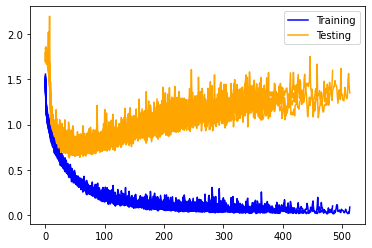

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

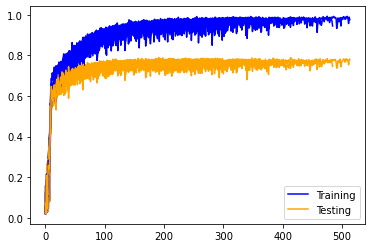

In [12]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

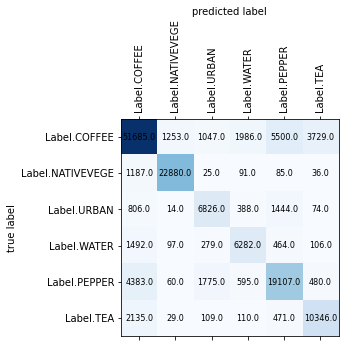

In [13]:
plot_confusion_matrix(conf_matrix, labels)

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.83784529 0.94028685 0.67846139 0.66462124 0.70581065 0.70042651]
Mean precision:  0.7545753210692155

Recalls:  [0.79271472 0.94140882 0.71461474 0.72041284 0.72375    0.78378788]
Mean recall:  0.7794481681187699

F-Score:  [0.81465544 0.9408475  0.69606893 0.69139335 0.71466776 0.73976619]
Mean f-score:  0.7662331972706253
